In [1]:
import os
import cv2
import random
import argparse
import numpy as np
import pandas as pd
from scipy import misc
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, LearningRateScheduler

import matplotlib.pyplot as plt
%matplotlib inline

E:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
E:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
E:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
E:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is 

In [2]:
class RAUNet2D(object):

    def __init__(self, input_shape=(512, 512, 1), num_classes=2, num_filters=8):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.num_filters = num_filters

    def _residual_block_2d(self, x_input, input_channels=None, output_channels=None, kernel_size=(3, 3),
                           stride=1, name='out'):
        if output_channels is None:
            output_channels = x_input.get_shape()[-1].value
        if input_channels is None:
            input_channels = output_channels // 4

        strides = (stride, stride)

        x = BatchNormalization()(x_input)
        x = Activation('relu')(x)
        x = Conv2D(input_channels, (1, 1))(x)

        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(input_channels, kernel_size, padding='same', strides=stride)(x)

        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(output_channels, (1, 1), padding='same')(x)

        if input_channels != output_channels or stride != 1:
            x_input = Conv2D(output_channels, (1, 1), padding='same', strides=strides)(x_input)
        if name == 'out':
            x = Add()([x, x_input])
        else:
            x = Add(name=name)([x, x_input])
        return x

    def _attention_block_2d(self, x, input_channels=None, output_channels=None,
                            encoder_depth=1, name='at'):
        p = 1
        t = 2
        r = 1

        if input_channels is None:
            input_channels = x.get_shape()[-1].value
        if output_channels is None:
            output_channels = input_channels

        for _ in range(p):
            x = self._residual_block_2d(x)

        # Trunk Branch
        output_trunk = x
        for _ in range(t):
            output_trunk = self._residual_block_2d(output_trunk)

        # Soft Mask Branch
        output_soft_mask = MaxPooling2D(padding='same')(x)
        for _ in range(r):
            output_soft_mask = self._residual_block_2d(output_soft_mask)

        skip_connections = []
        for i in range(encoder_depth - 1):
            output_skip_connection = self._residual_block_2d(output_soft_mask)
            skip_connections.append(output_skip_connection)
            output_soft_mask = MaxPooling2D(padding='same')(output_soft_mask)
            for _ in range(r):
                output_soft_mask = self._residual_block_2d(output_soft_mask)

        skip_connections = list(reversed(skip_connections))
        for i in range(encoder_depth - 1):
            for _ in range(r):
                output_soft_mask = self._residual_block_2d(output_soft_mask)
            output_soft_mask = UpSampling2D(size=(2, 2))(output_soft_mask)
            output_soft_mask = Add()([output_soft_mask, skip_connections[i]])

        for i in range(r):
            output_soft_mask = self._residual_block_2d(output_soft_mask)
        output_soft_mask = UpSampling2D(size=(2, 2))(output_soft_mask)

        output_soft_mask = Conv2D(input_channels, (1, 1))(output_soft_mask)
        output_soft_mask = Conv2D(input_channels, (1, 1))(output_soft_mask)
        output_soft_mask = Activation('sigmoid')(output_soft_mask)

        output = Lambda(lambda a: tf.add(a, 1))(output_soft_mask)
        output = Multiply()([output, output_trunk])

        for i in range(p):
            output = self._residual_block_2d(output, name=name)

        return output

    def __call__(self):
        x_input = Input(shape=self.input_shape)

        conv0 = Conv2D(self.num_filters * 4, 3, padding='same')(x_input)
        conv0 = BatchNormalization()(conv0)
        conv0 = Activation('relu')(conv0)
        pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)

        res1 = self._residual_block_2d(pool0, output_channels=self.num_filters * 4)
        pool1 = MaxPooling2D(pool_size=(2, 2))(res1)

        res2 = self._residual_block_2d(pool1, output_channels=self.num_filters * 8)
        pool2 = MaxPooling2D(pool_size=(2, 2))(res2)

        res3 = self._residual_block_2d(pool2, output_channels=self.num_filters * 16)
        pool3 = MaxPooling2D(pool_size=(2, 2))(res3)

        res4 = self._residual_block_2d(pool3, output_channels=self.num_filters * 32)
        pool4 = MaxPooling2D(pool_size=(2, 2))(res4)

        res5 = self._residual_block_2d(pool4, output_channels=self.num_filters * 64)

        res6 = self._residual_block_2d(res5, output_channels=self.num_filters * 64)
        up1 = UpSampling2D(size=(2, 2))(res6)
        atb1 = self._attention_block_2d(res4, encoder_depth=1, name='atten1')
        merged1 = Concatenate(axis=-1)([up1, atb1])

        res7 = self._residual_block_2d(merged1, output_channels=self.num_filters * 32)
        up2 = UpSampling2D(size=(2, 2))(res7)
        atb2 = self._attention_block_2d(res3, encoder_depth=2, name='atten2')
        merged2 = Concatenate(axis=-1)([up2, atb2])

        res8 = self._residual_block_2d(merged2, output_channels=self.num_filters * 16)
        up3 = UpSampling2D(size=(2, 2))(res8)
        atb3 = self._attention_block_2d(res2, encoder_depth=3, name='atten3')
        merged3 = Concatenate(axis=-1)([up3, atb3])

        res9 = self._residual_block_2d(merged3, output_channels=self.num_filters * 8)
        up4 = UpSampling2D(size=(2, 2))(res9)
        atb4 = self._attention_block_2d(res1, encoder_depth=4, name='atten4')
        merged4 = Concatenate(axis=-1)([up4, atb4])

        res10 = self._residual_block_2d(merged4, output_channels=self.num_filters * 4)
        up = UpSampling2D(size=(2, 2))(res10)
        merged = Concatenate(axis=-1)([up, conv0])

        conv1 = Conv2D(self.num_filters * 4, 3, padding='same')(merged)
        conv1 = BatchNormalization()(conv1)
        conv1 = Activation('relu')(conv1)

        if self.num_classes == 2:
            output = Conv2D(1, 3, padding='same', activation='sigmoid')(conv1)
        else:
            output = Conv2D(self.num_classes, 3, padding='same', activation='softmax')(conv1)

        return Model(x_input, output)

In [3]:
model = RAUNet2D(input_shape=(512, 512, 1), num_classes=2, num_filters=8)()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 512, 512, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 32) 0           batch_normalization_v1[0][0]     
_____________________________________

In [5]:
model.load_weights('./tmp4/raunet2d_checkpoint.h5')

In [25]:
def findAndDrawMask(model, imgFile,savePath):
    '''
    model: 你用来识别的模型
    imgFile: 需要识别的图像路径
    savePath:对应的识别后的图片路径
    '''
    img = misc.imread(imgFile)
    #img = cv2.merge([img[:,:,0],img[:,:,1],img[:,:,2]])
    #print(img.shape)
    #m = img[:1150, 420:1700].shape[0]        #获得resize前的图片大小
    #n = img[:1150, 420:1700].shape[1]
    #print(m,n)
    img_resize = misc.imresize(img[:1150, 420:1700], (512, 512), 'bicubic')#将图片resize成512，512
    #print(img.shape)
    img_gray = cv2.cvtColor(img_resize,cv2.COLOR_RGB2GRAY) #RGB转灰度图 程理想写的
    predict = model.predict(img_gray.reshape(1, 512, 512, 1) / 255.)[0]
    predict[predict >= 0.5] = 255
    predict[predict < 0.5] = 0
    predict_reshape = predict.reshape(512,512)
    predict_deResize = misc.imresize(predict_reshape, (1150 ,1280), 'bicubic') #识别后二值化之后的还原的图像
    predict_flat = predict_deResize.reshape(1150 * 1280)
    #grid 保存的是二值化后的网格，网格里面的值本质上就是predict_flat
    grid = np.array([[i // 1280, i % 1280] if predict_flat[i] == 255 else [0, 0] for i in range(len(predict_flat))])
    centroid = np.sum(grid, axis=0) / np.sum(predict_flat == 255)  #获得重心坐标值
    print(centroid)
    cv2.imwrite(savePath+ '.png',predict_deResize)
    try:
        predict_deResize[int(centroid[0])-5:int(centroid[0])+5,int(centroid[1])-5:int(centroid[1])+5 ] = 0
    except:
        print(imgFile, "no SiO2 found in this picture")
    #predict_deResize_centered = misc.imresize(predict.reshape((512,512)), (1150 ,1280), 'bicubic')

    plt.figure(figsize=(20, 20))
    #plt.subplot(1, 2, 1)
    #plt.imshow(img)
    #plt.subplot(1, 2, 2)
   # print( predict[int(centroid[0])][int(centroid[1])][0], np.max(predict), np.min(predict))
   # predict[int(centroid[0])][int(centroid[0])][0] = 255.0
    #print( predict[int(centroid[1])][int(centroid[0])][0])

    cv2.imwrite(savePath+'Centered' + '.png',predict_deResize)
   
    #plt.imshow(predict_deResize)
    #plt.plot(centroid[1], centroid[0], 'ro')
    #plt.figure()
    #plt.imshow(img[:1150, 420:1700])
    
    #plt.savefig(savePath+'Centered' + '.png')
    #返回了中心值方便后续的计算和流线图的绘制 程理想
    return predict, centroid 

0497.bmp


E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  del sys.path[0]
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


[577.54343532 483.23809315]
0498.bmp
[587.90221566 508.47405219]
0499.bmp
[609.74684719 499.42705302]
0500.bmp
[602.25514788 483.51011786]
0501.bmp
[602.59641322 480.55748234]
0502.bmp
[610.61164995 493.06502811]
0503.bmp
[616.00994024 483.02085727]
0504.bmp
[616.19589616 481.97160186]
0505.bmp
[613.17650802 472.47868414]
0506.bmp
[613.27967368 469.49190435]
0507.bmp
[612.51379518 469.48246988]
0508.bmp
[613.14193803 467.58434449]
0509.bmp
[610.43406688 469.75147185]
0510.bmp
[610.21408712 463.96124884]
0511.bmp
[610.14449418 459.02041182]
0512.bmp
[608.356901   463.33010043]
0513.bmp
[611.42974734 459.84343203]
0514.bmp
[614.61175955 459.14472026]
0515.bmp
[612.54783526 455.7719843 ]
0516.bmp
[616.19048201 453.91942086]
0517.bmp
[615.06212437 454.56635594]
0518.bmp
[618.29881833 452.84859155]
0519.bmp
[615.7482145  454.85153129]
0520.bmp
[608.54969055 463.14859557]
0521.bmp
[601.69216969 469.0856531 ]
0522.bmp
[587.3859206  483.86794897]
0523.bmp
[609.31987786 452.62577099]
0524.bmp
[

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


[nan nan]
./2019 APMCM Problems/2019 APMCM Problem A Attachment/0586.bmp no SiO2 found in this picture
0587.bmp
[nan nan]
./2019 APMCM Problems/2019 APMCM Problem A Attachment/0587.bmp no SiO2 found in this picture
0588.bmp
[677.22556391 530.4887218 ]
0589.bmp
[nan nan]
./2019 APMCM Problems/2019 APMCM Problem A Attachment/0589.bmp no SiO2 found in this picture
0590.bmp
[nan nan]
./2019 APMCM Problems/2019 APMCM Problem A Attachment/0590.bmp no SiO2 found in this picture
0591.bmp
[nan nan]
./2019 APMCM Problems/2019 APMCM Problem A Attachment/0591.bmp no SiO2 found in this picture
0592.bmp
[nan nan]
./2019 APMCM Problems/2019 APMCM Problem A Attachment/0592.bmp no SiO2 found in this picture
0593.bmp
[nan nan]
./2019 APMCM Problems/2019 APMCM Problem A Attachment/0593.bmp no SiO2 found in this picture
0594.bmp
[nan nan]
./2019 APMCM Problems/2019 APMCM Problem A Attachment/0594.bmp no SiO2 found in this picture
0595.bmp
[671.5 553. ]
0596.bmp
[622.9673913  549.79347826]
0597.bmp
[nan na

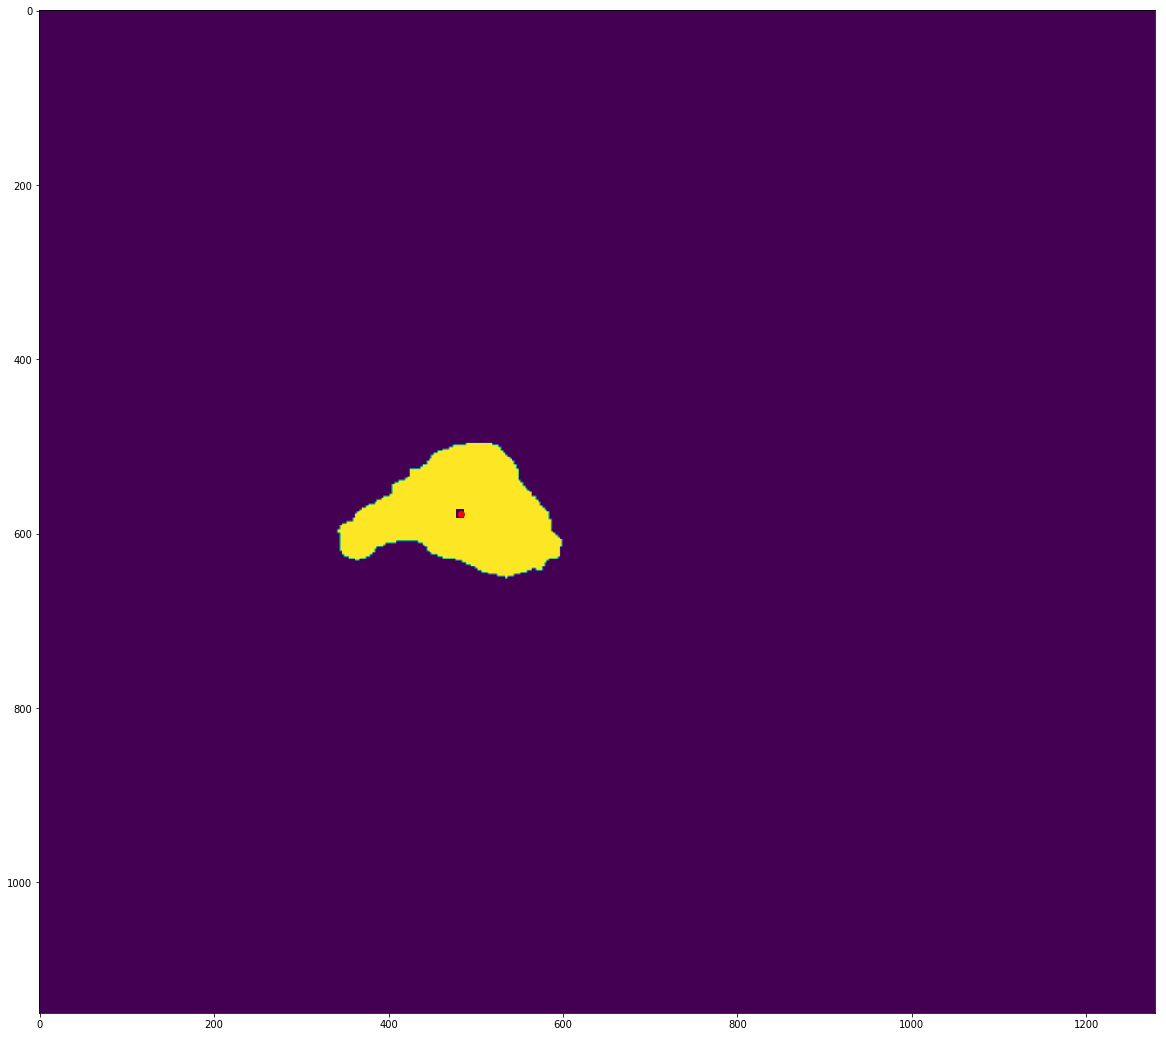

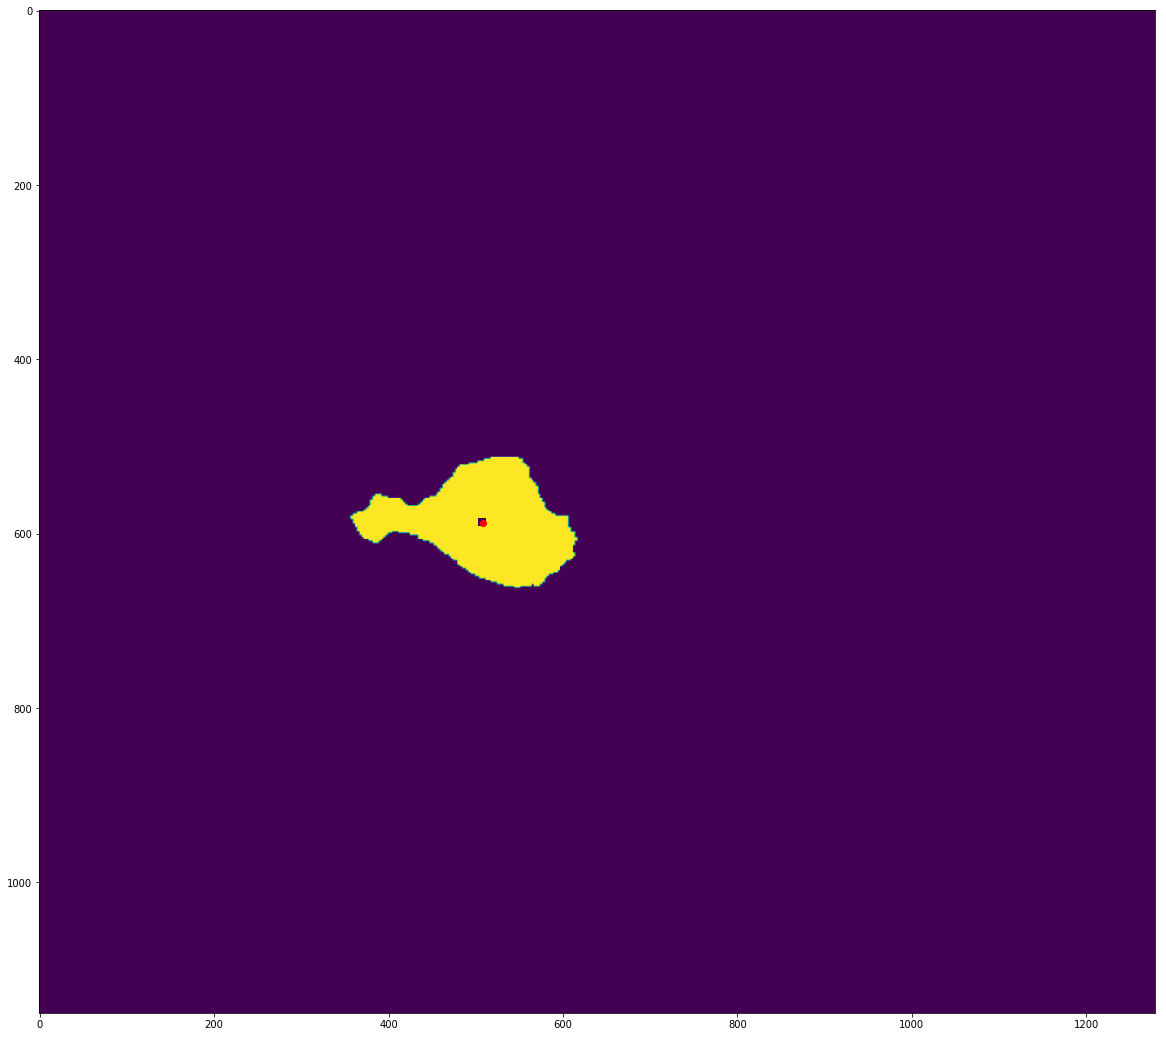

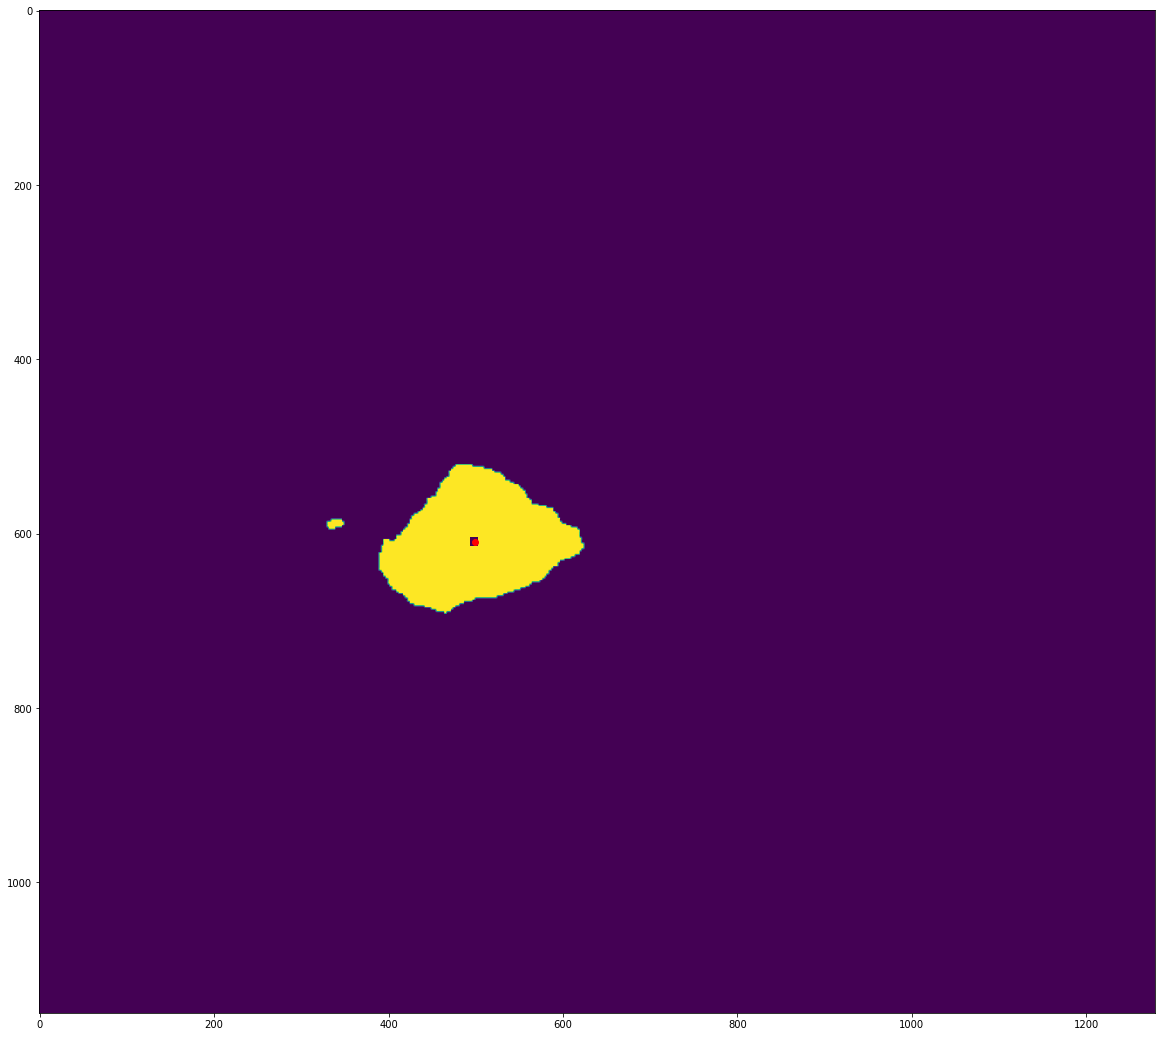

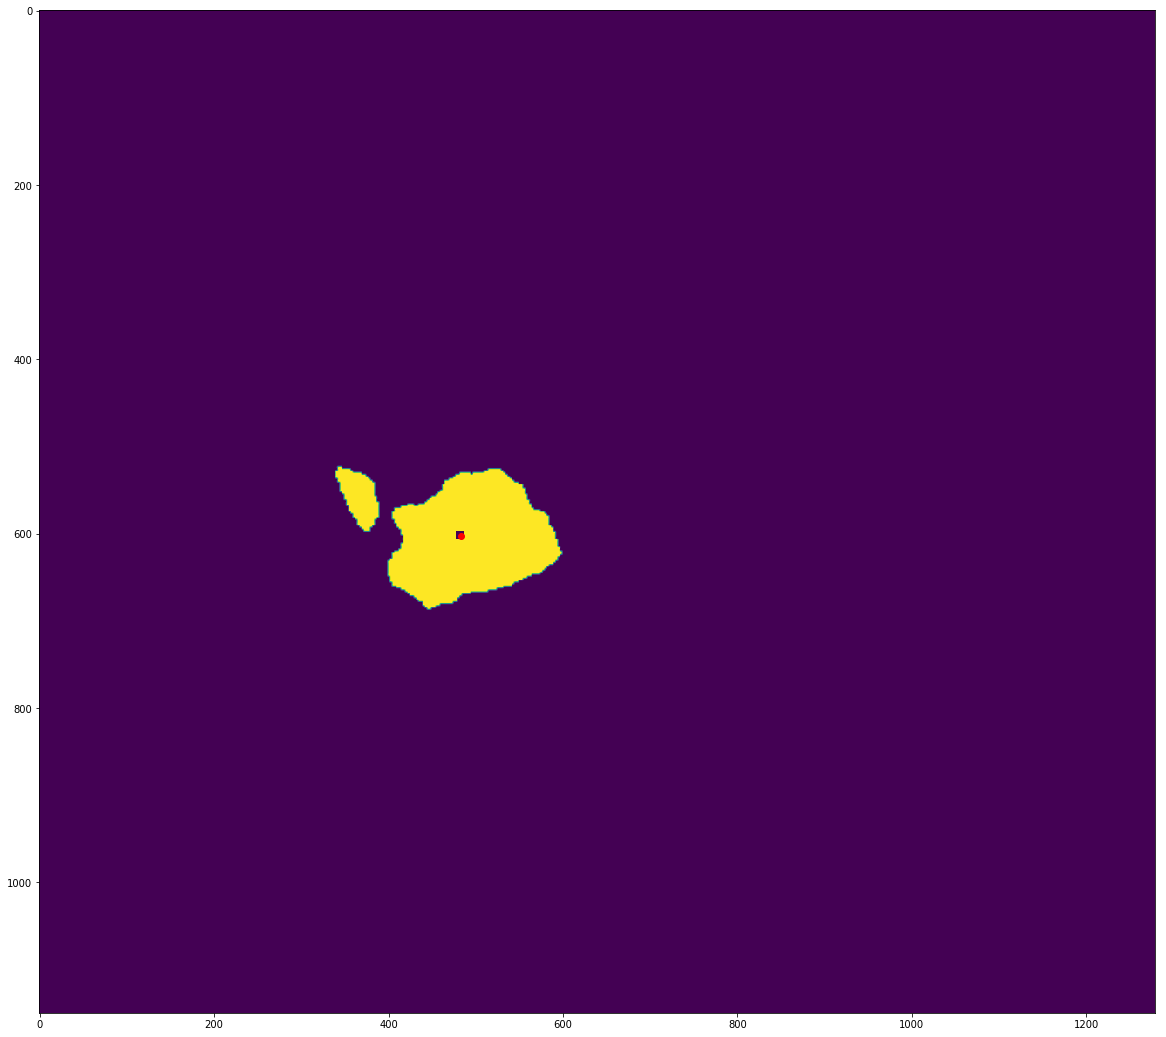

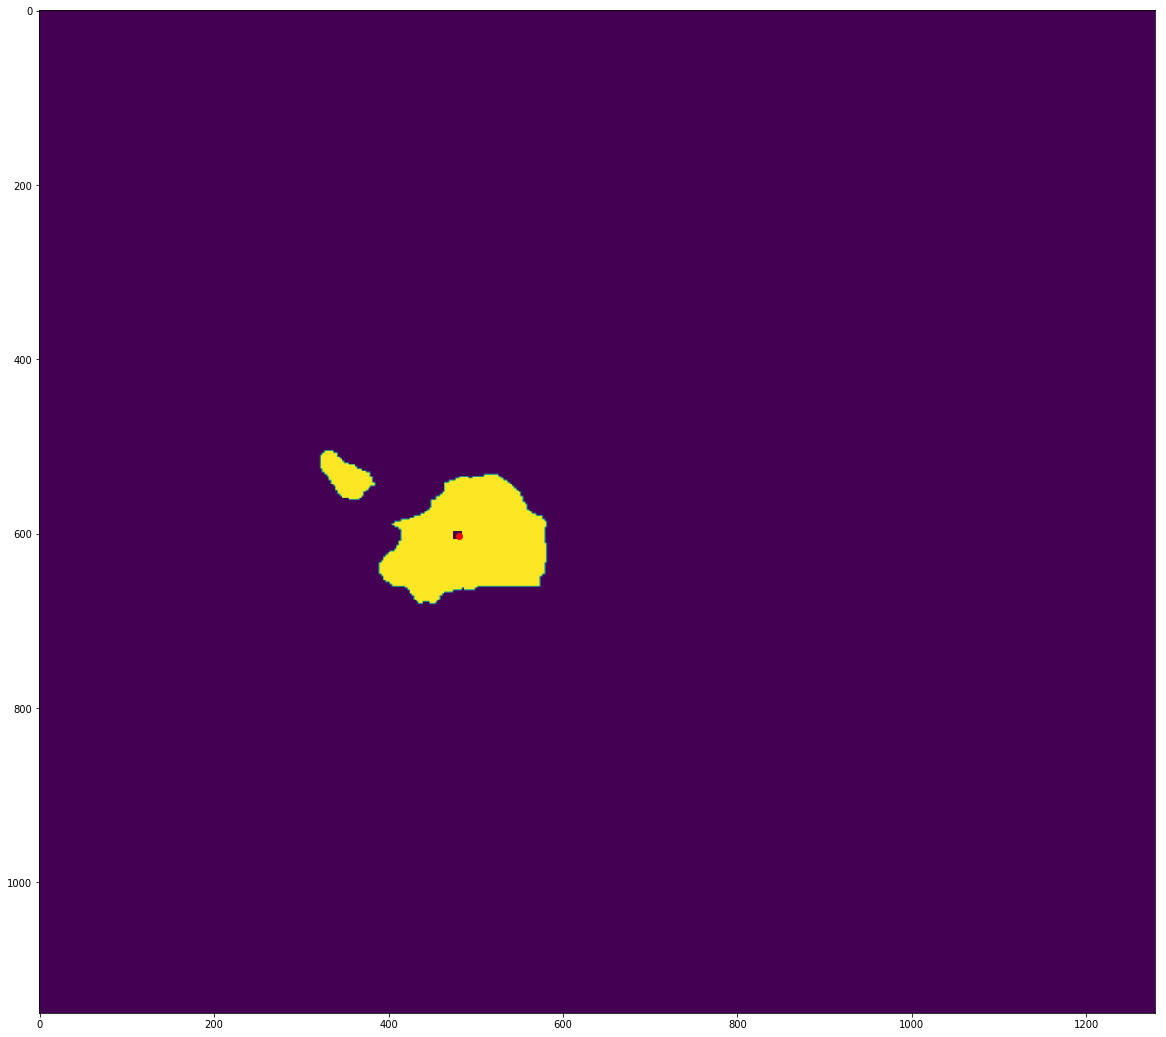

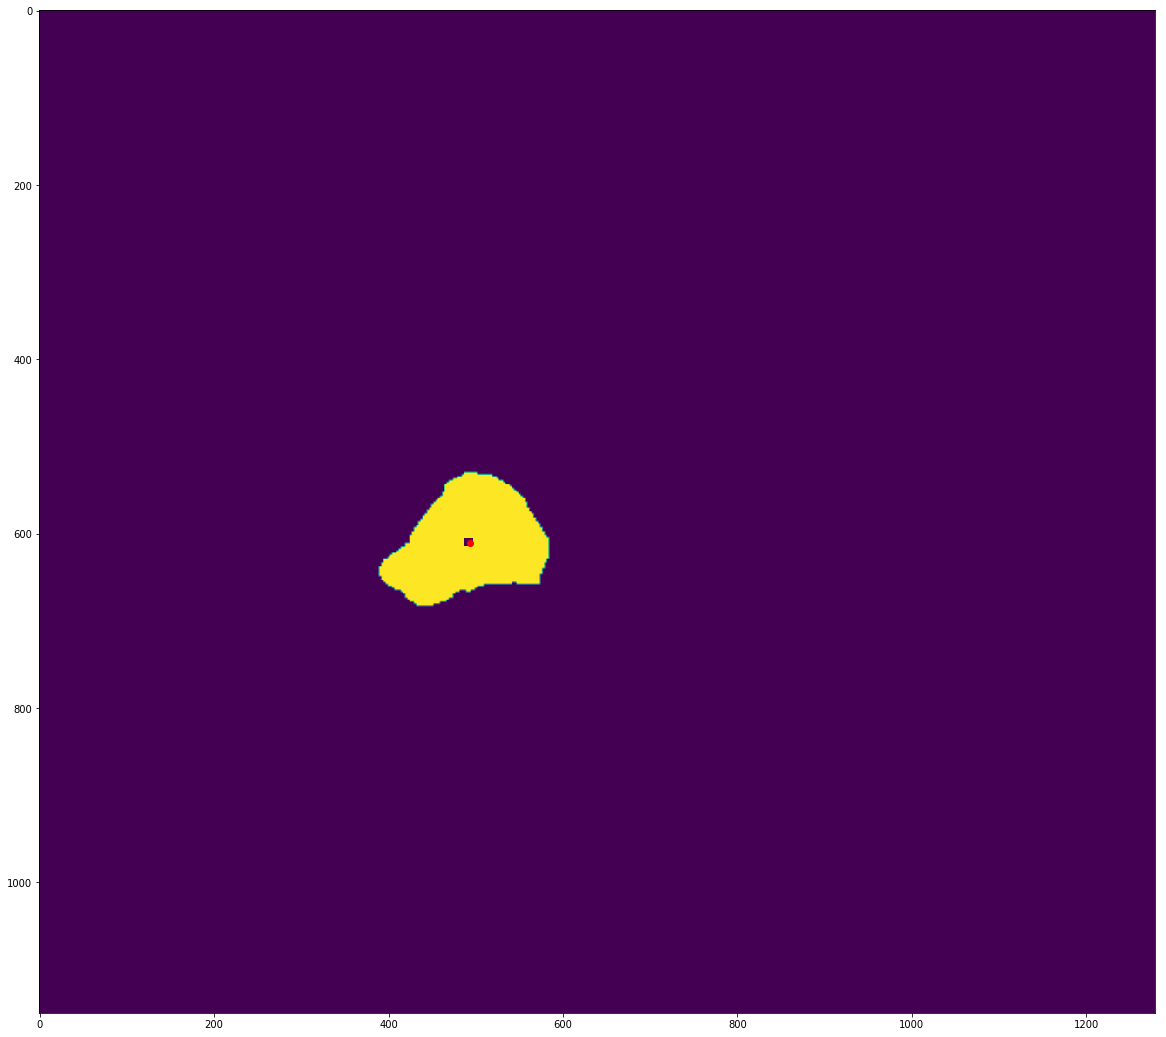

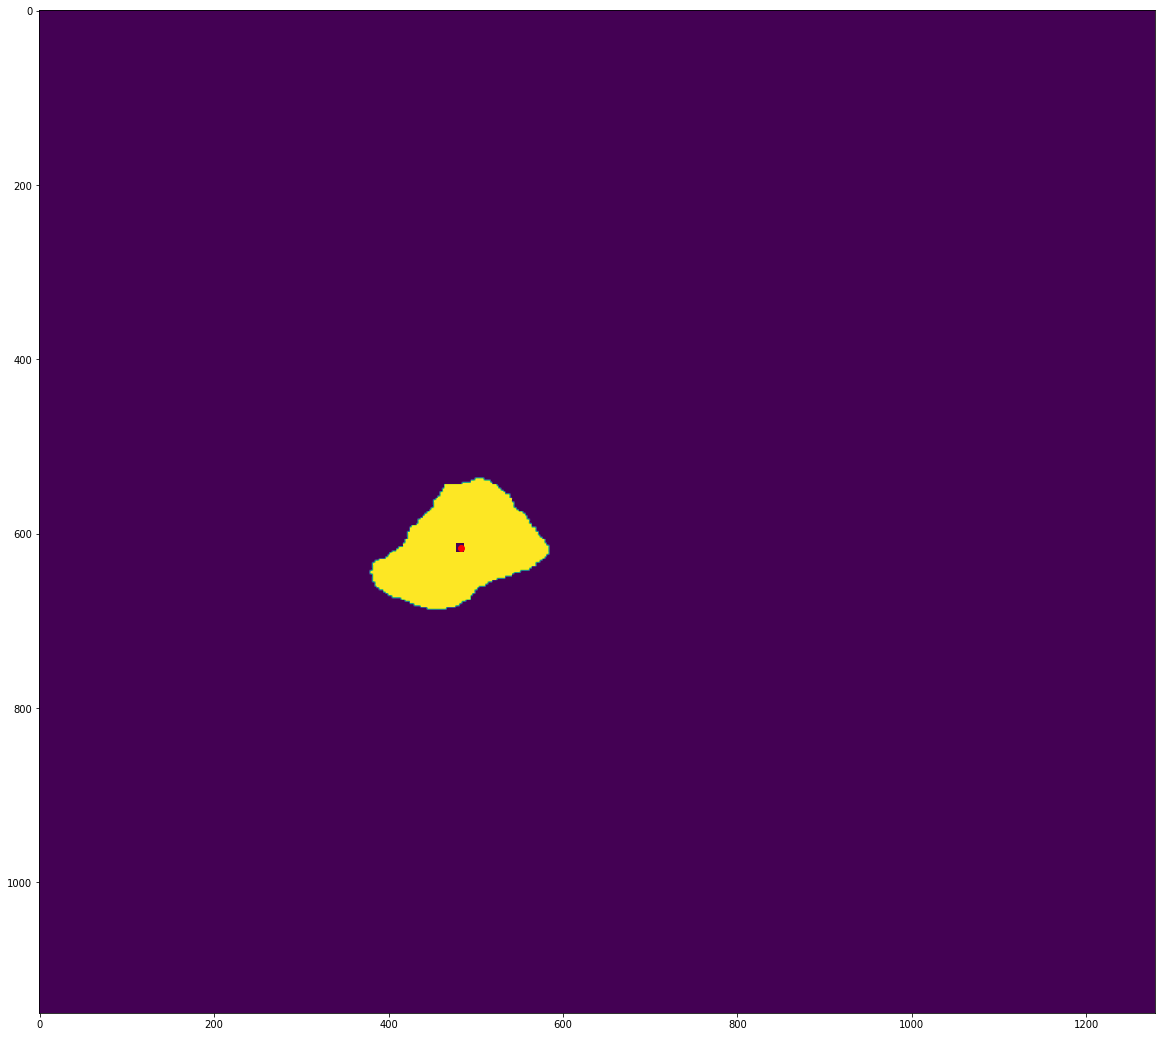

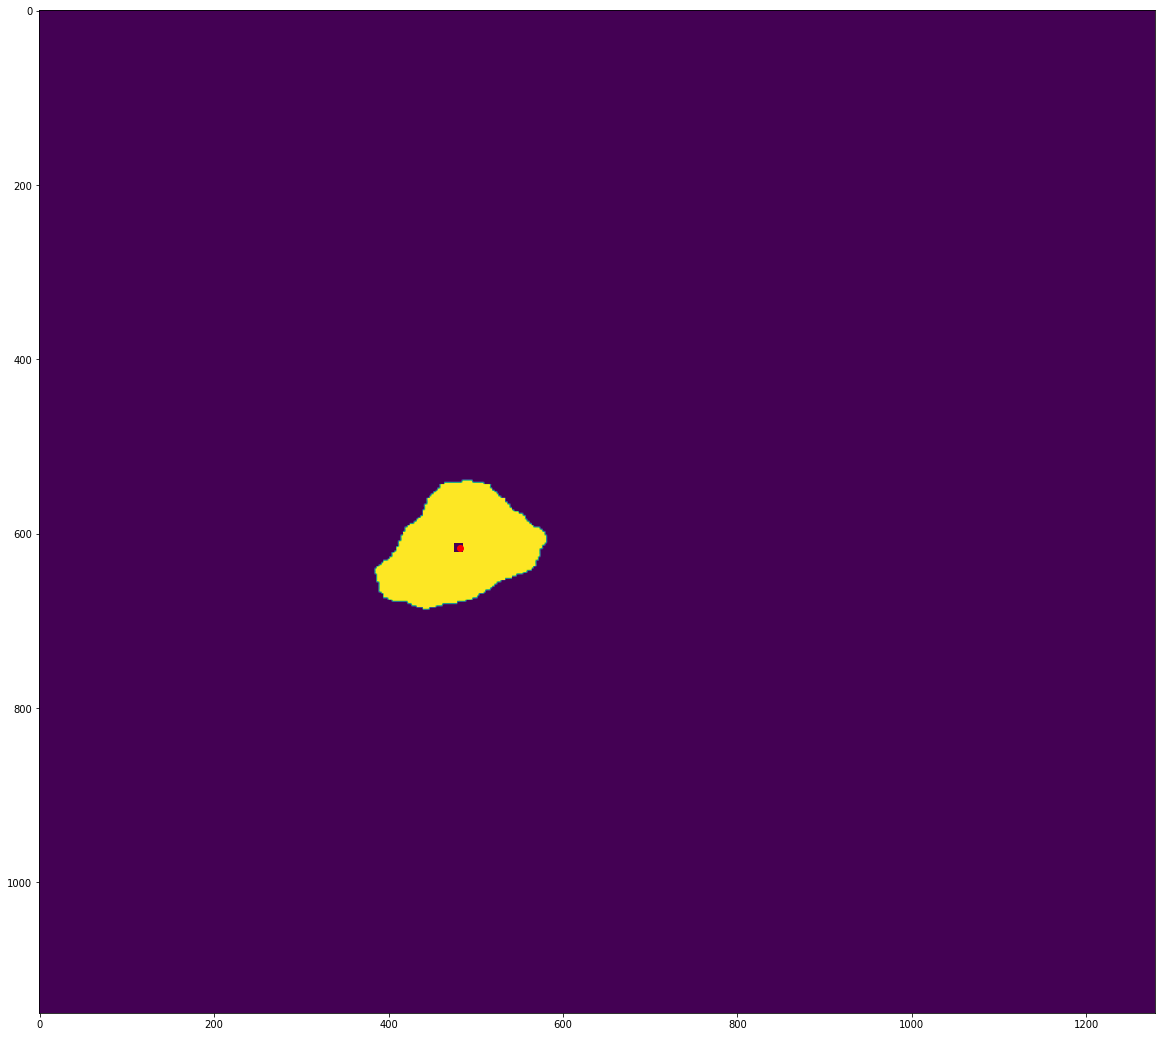

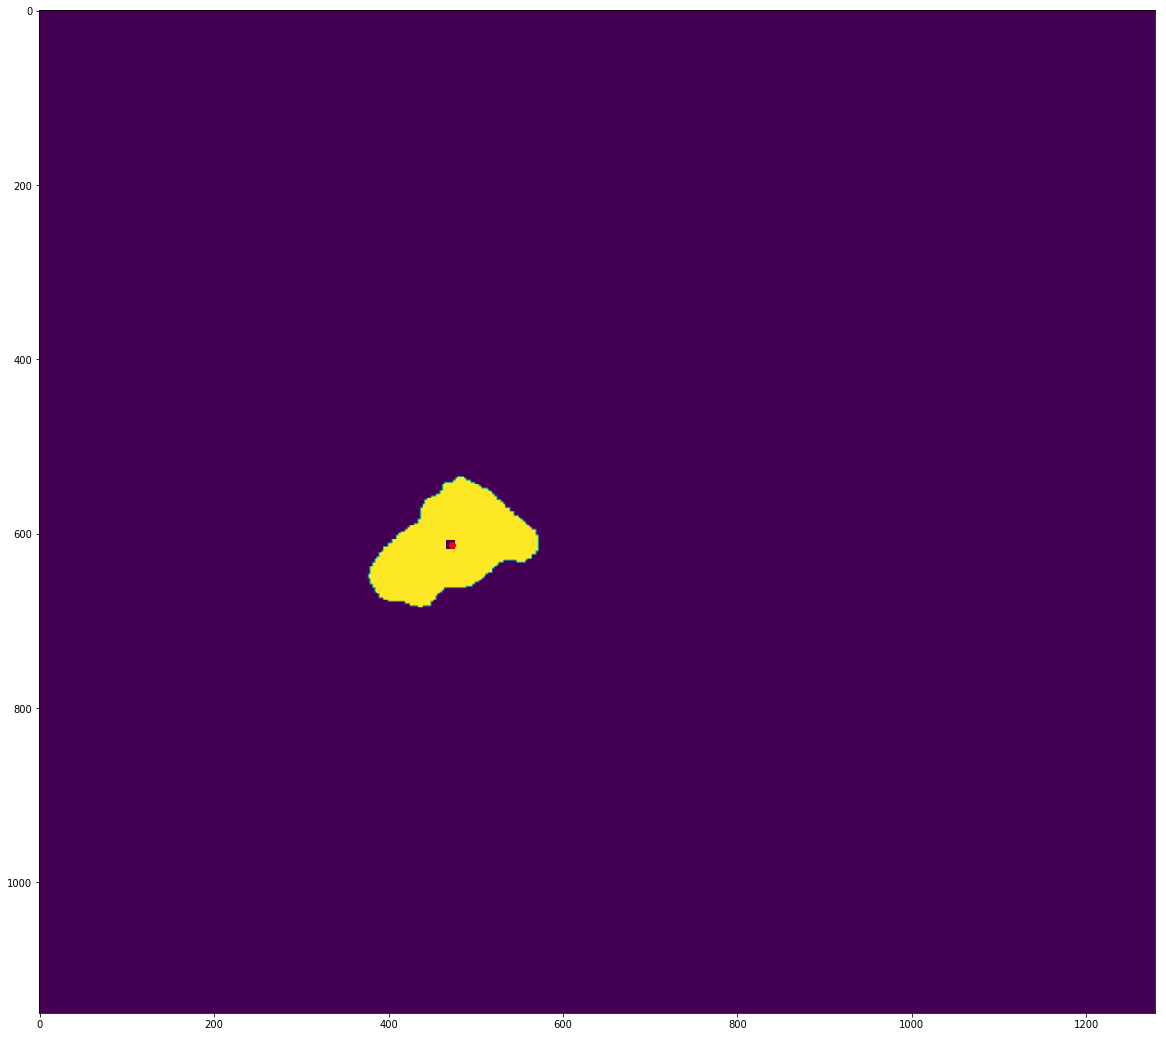

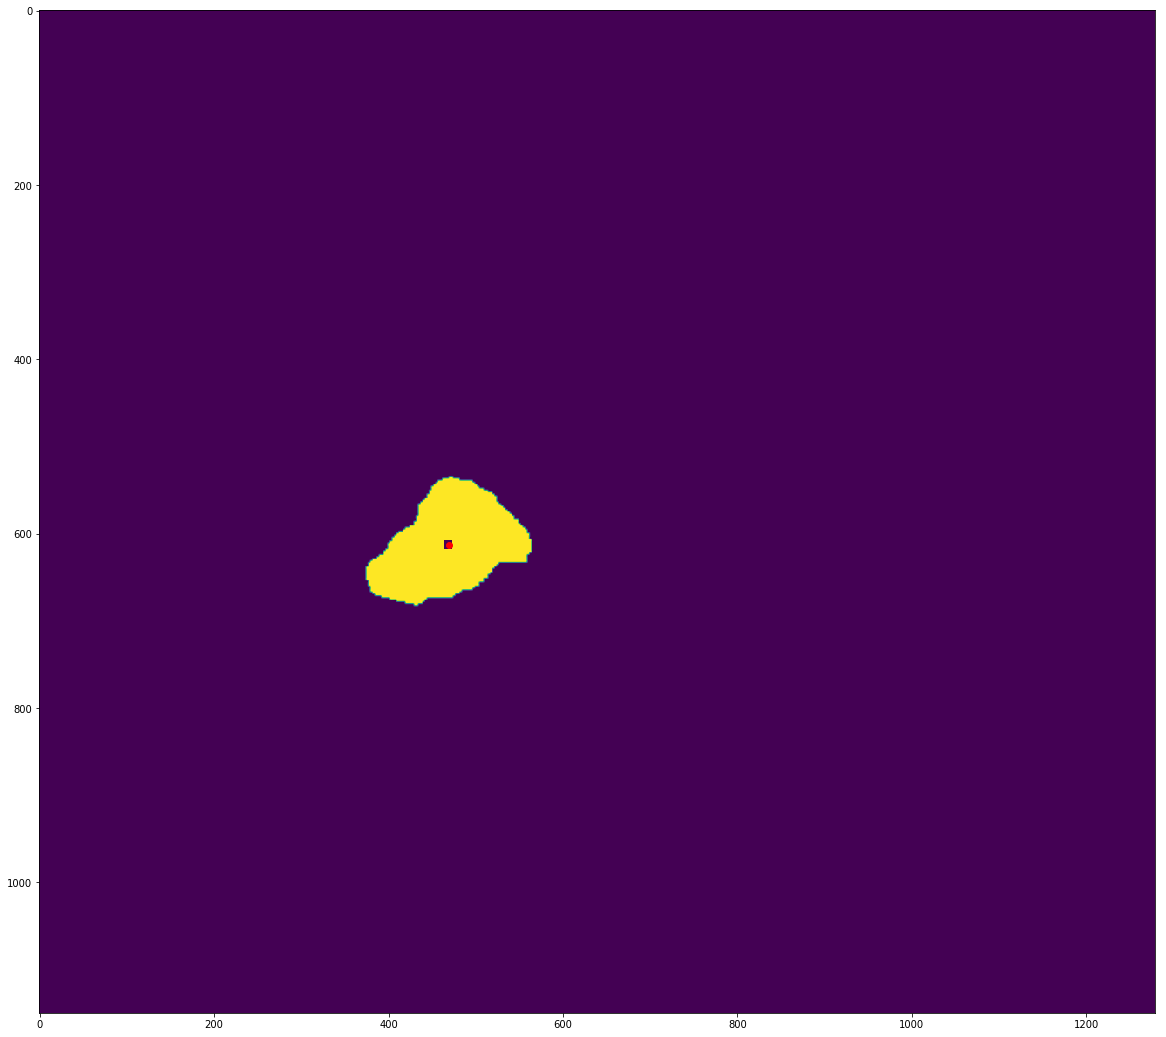

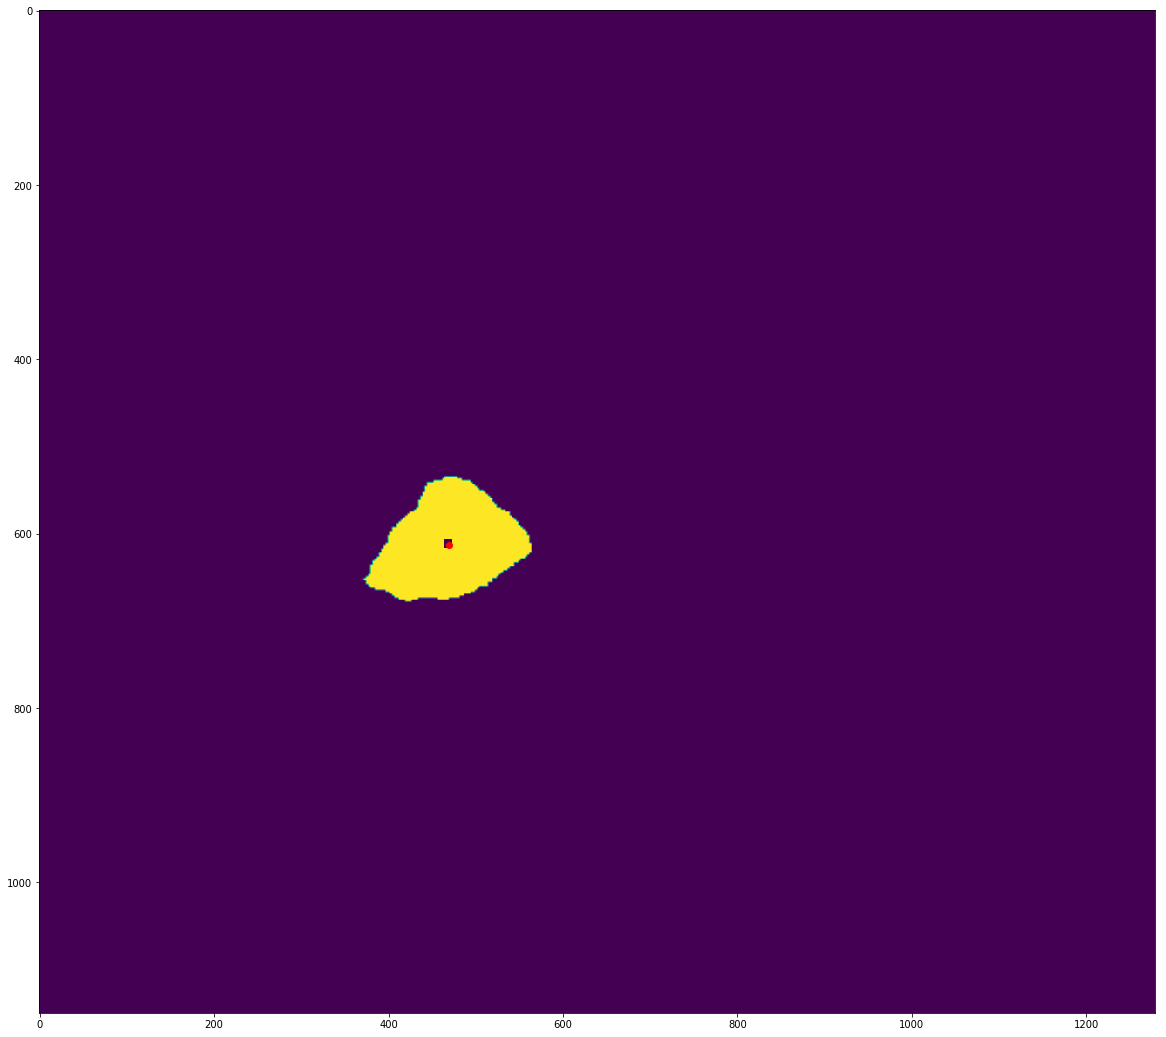

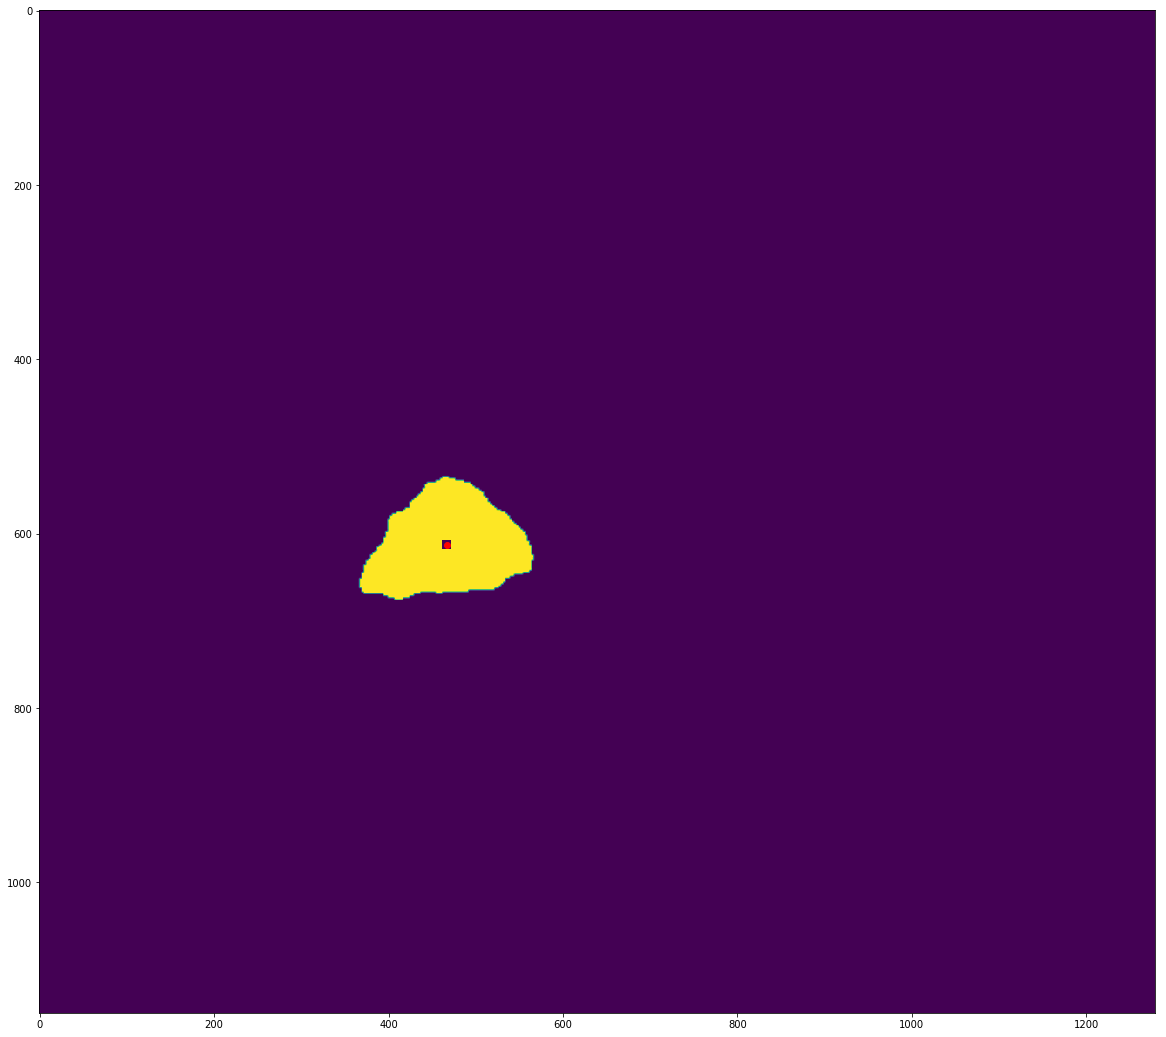

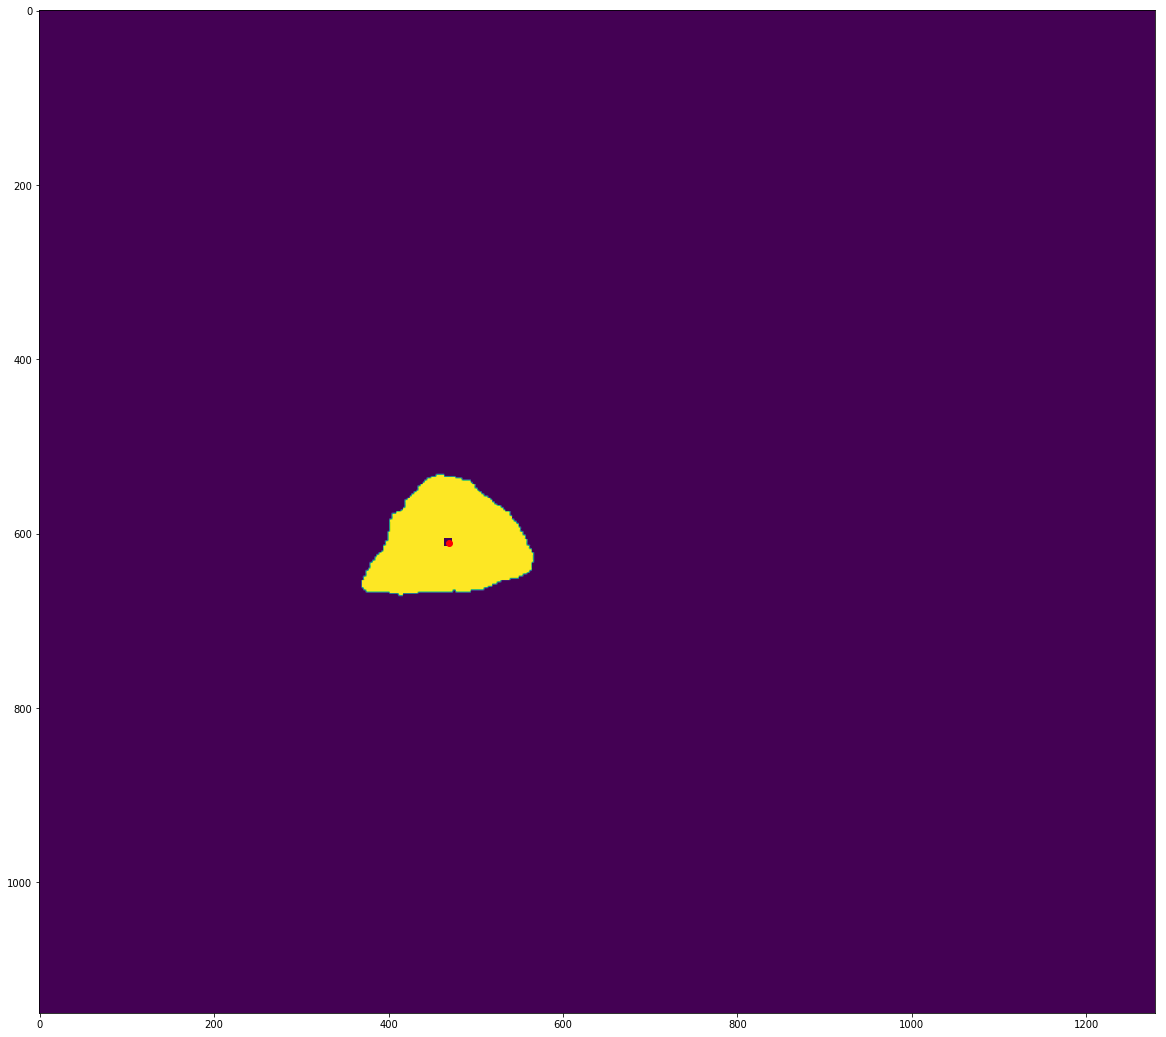

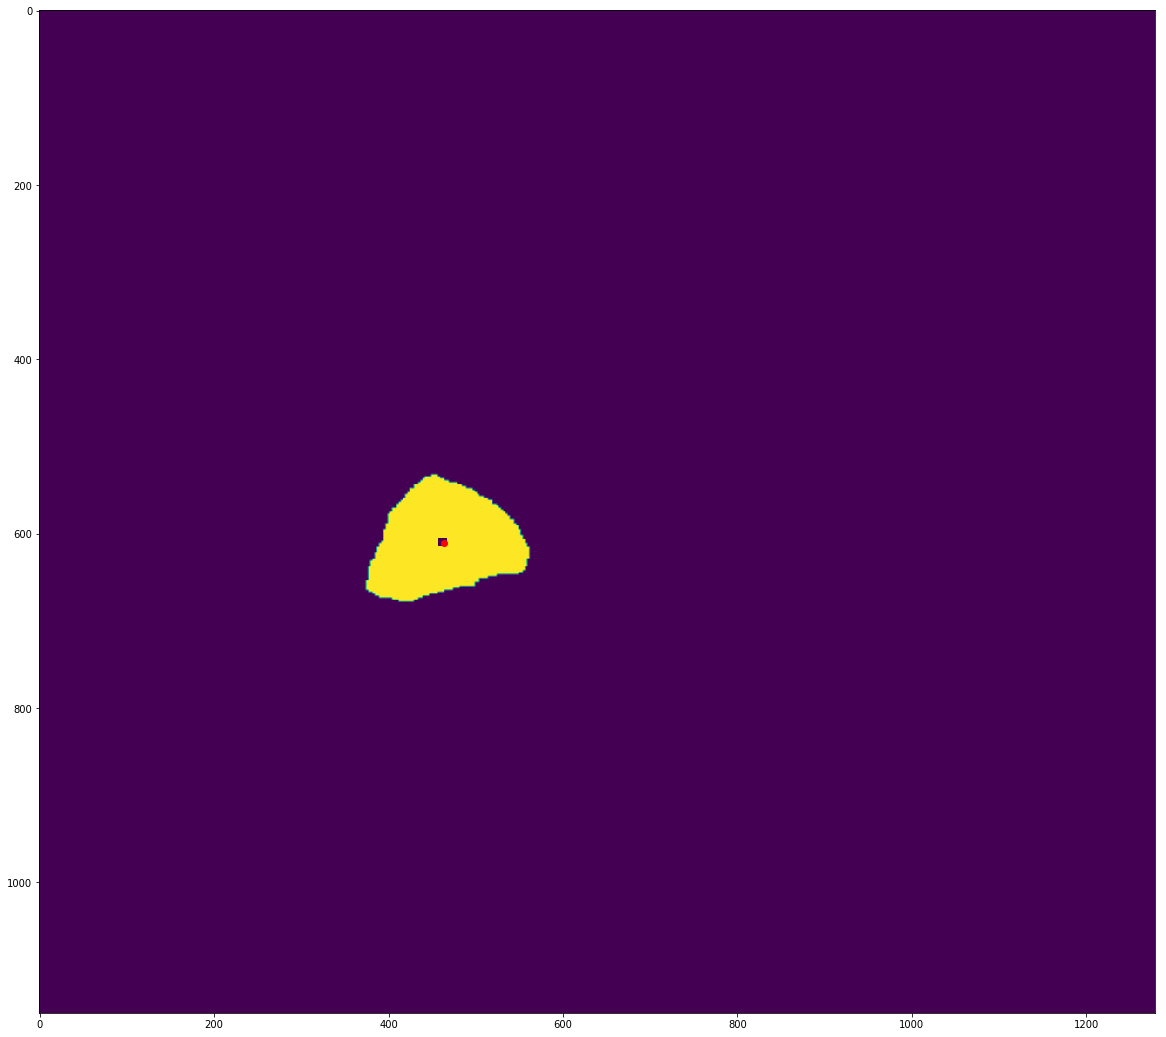

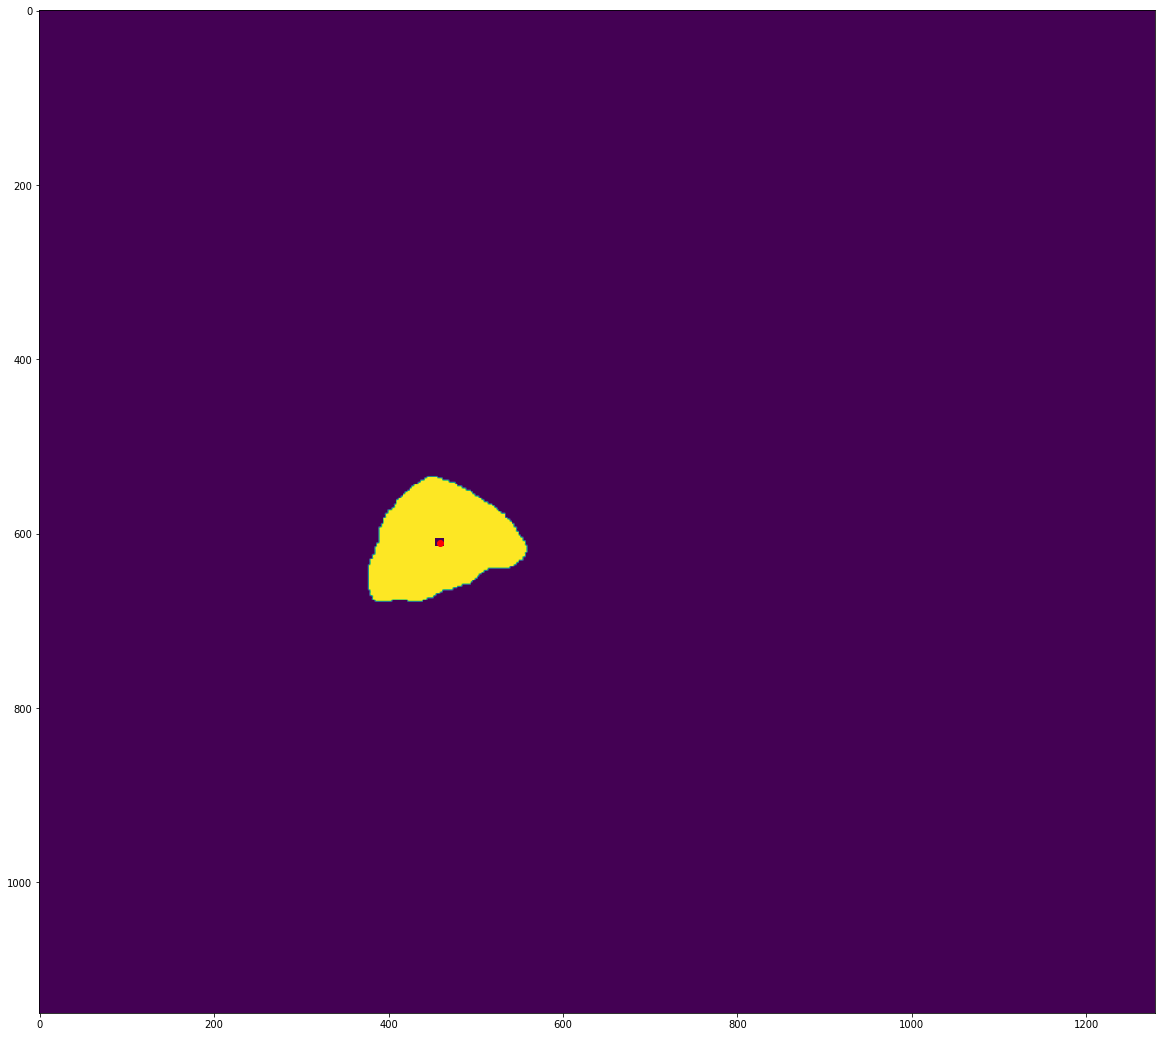

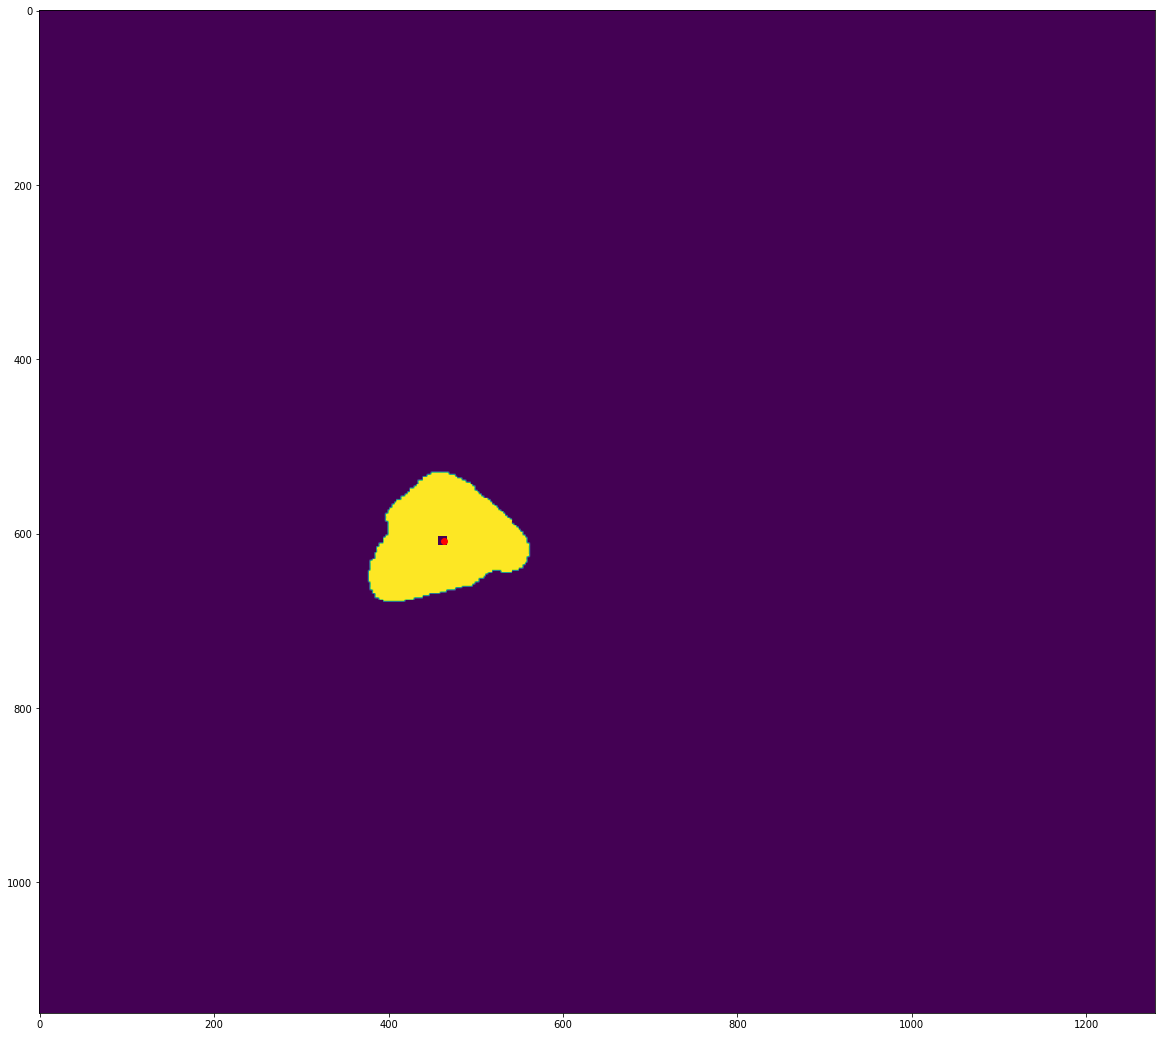

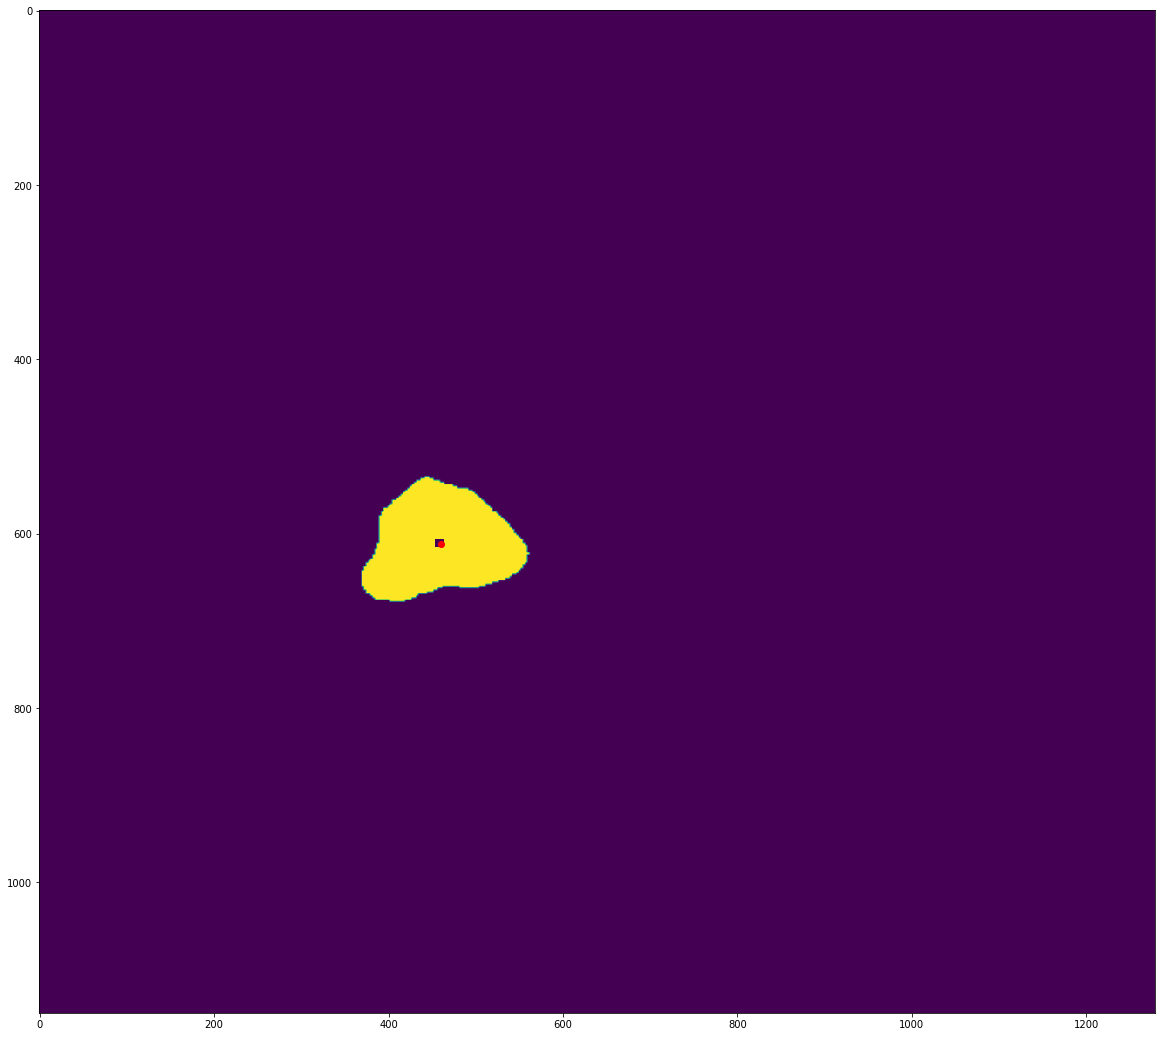

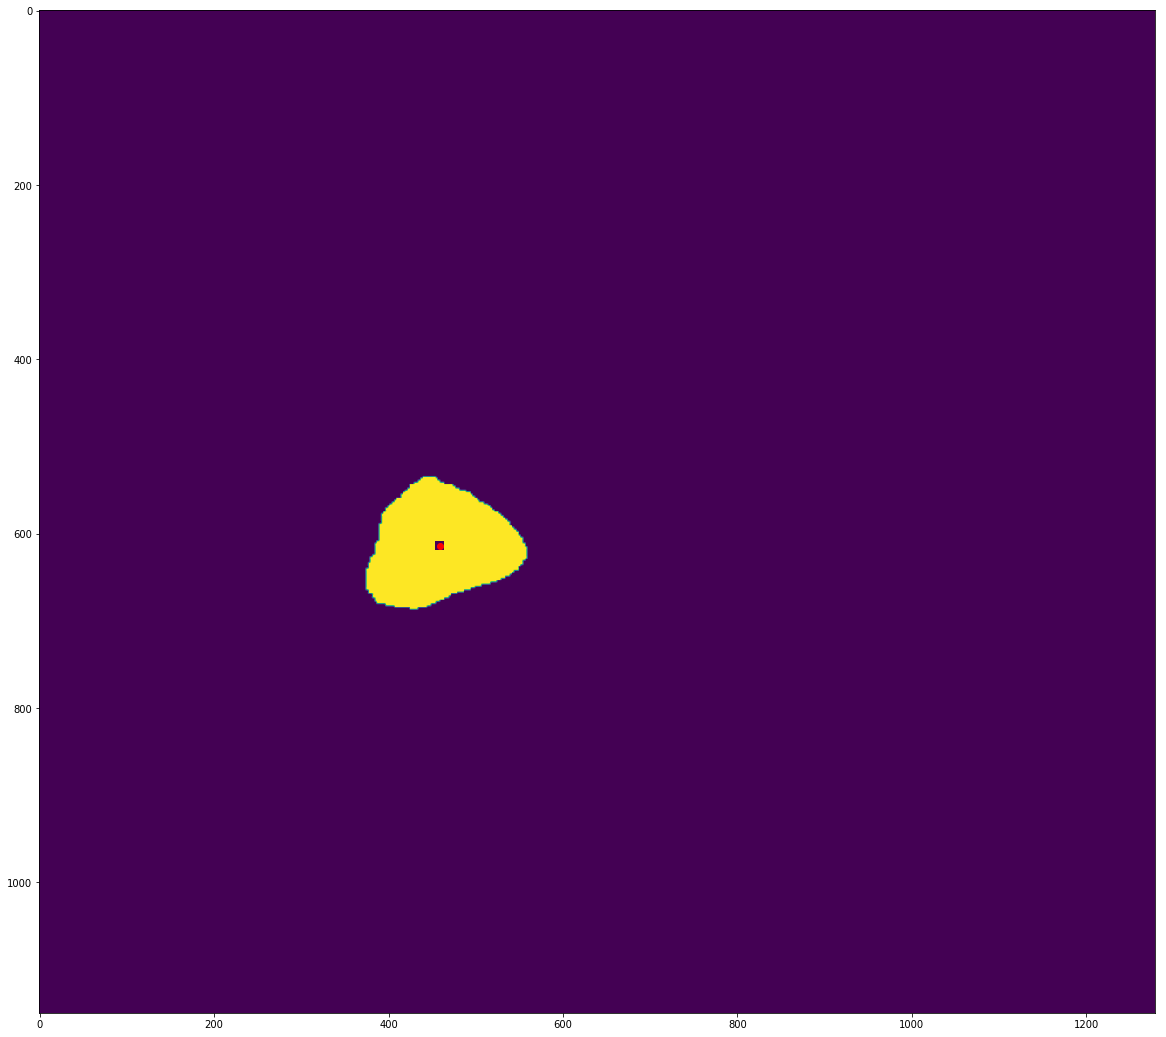

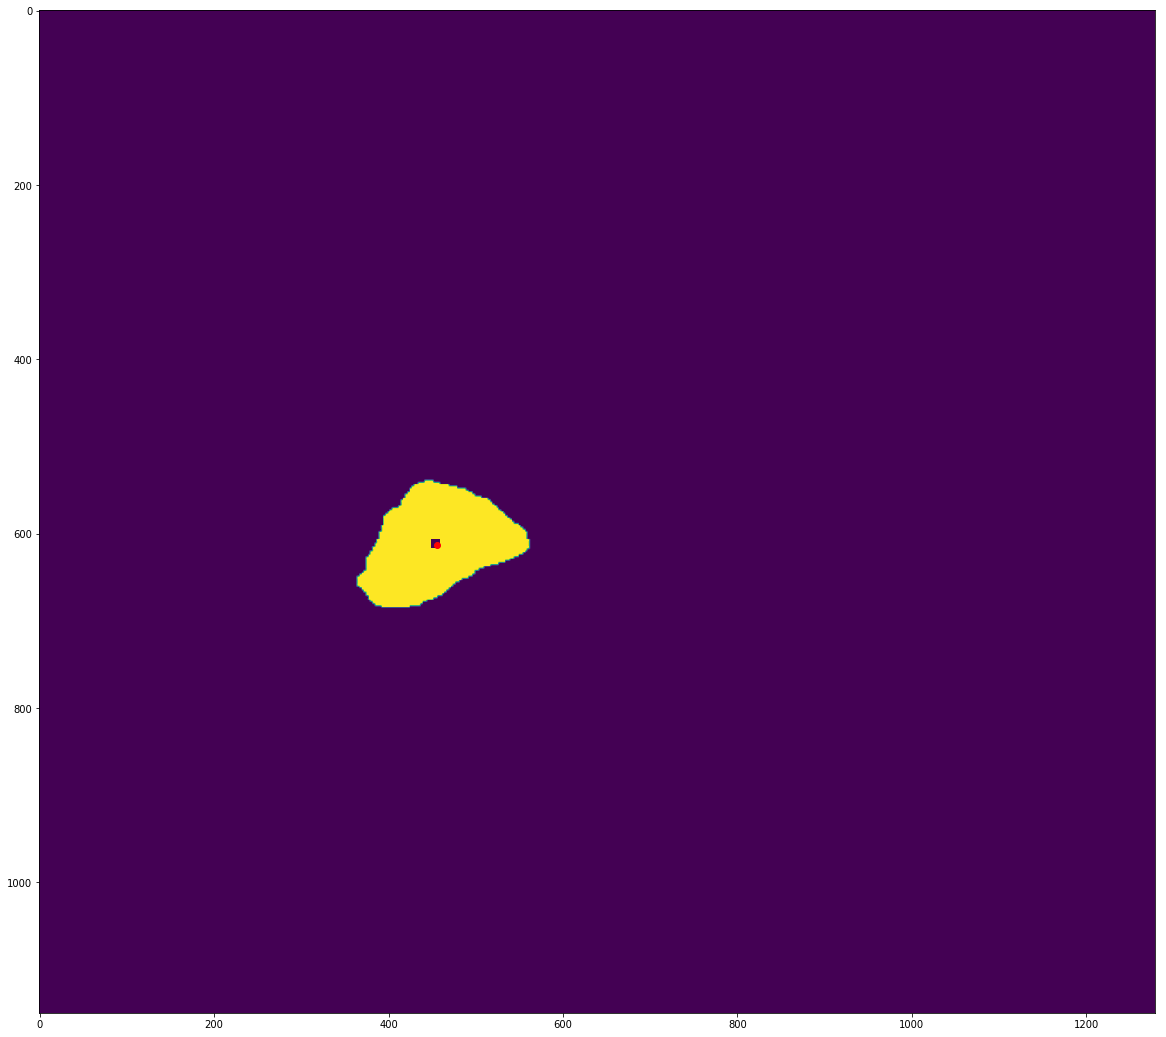

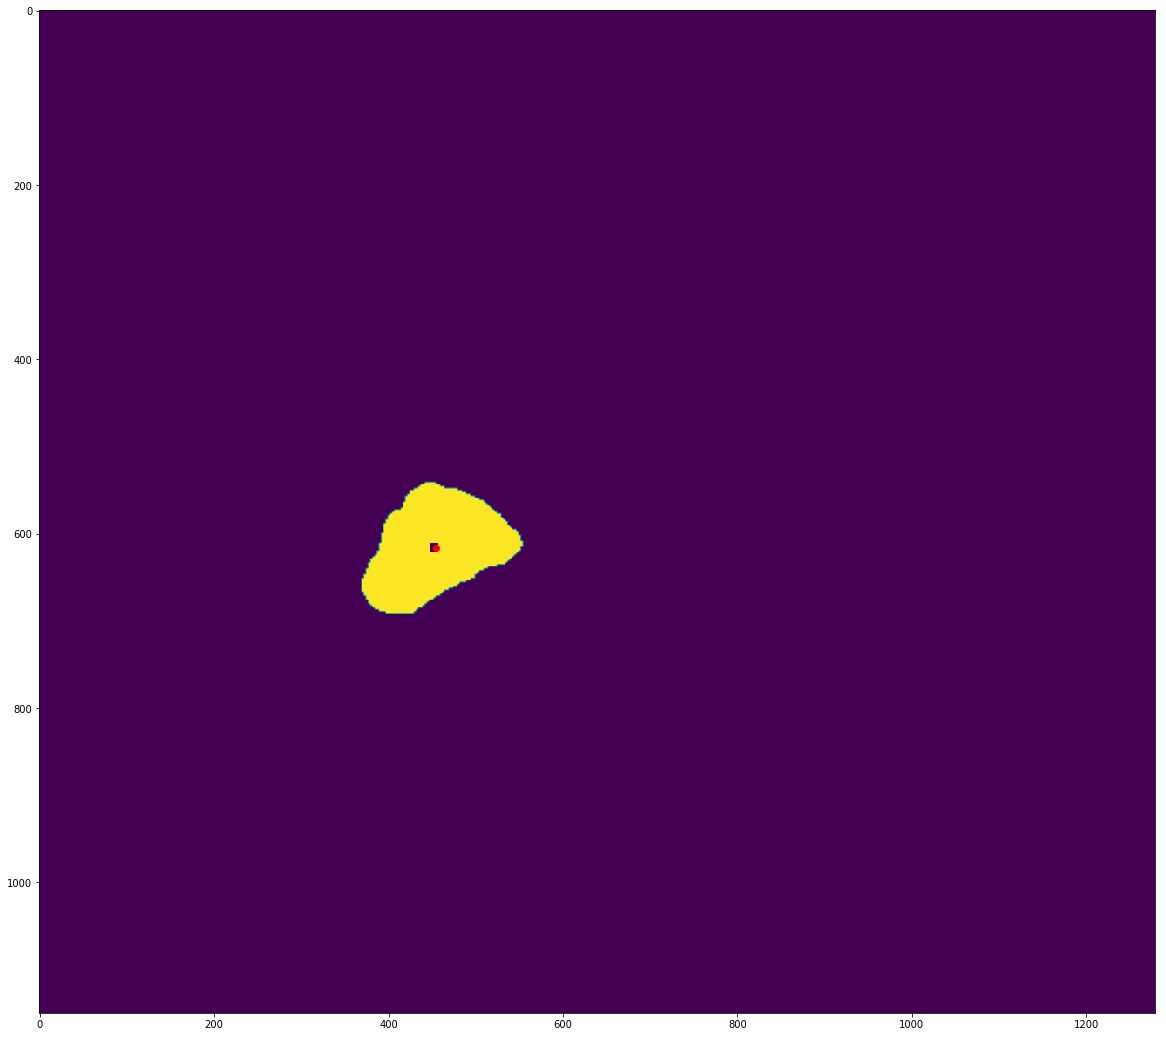

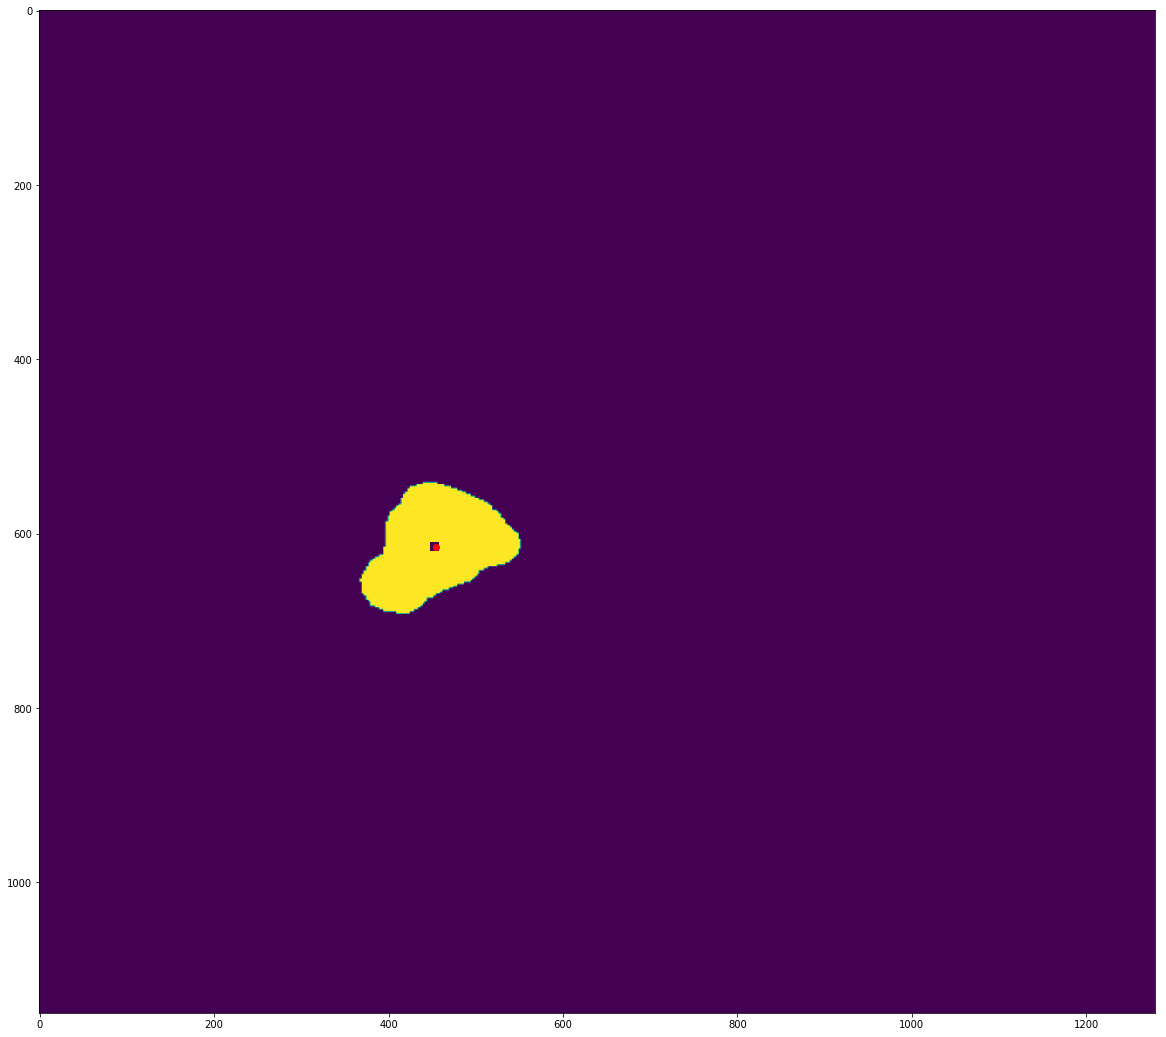

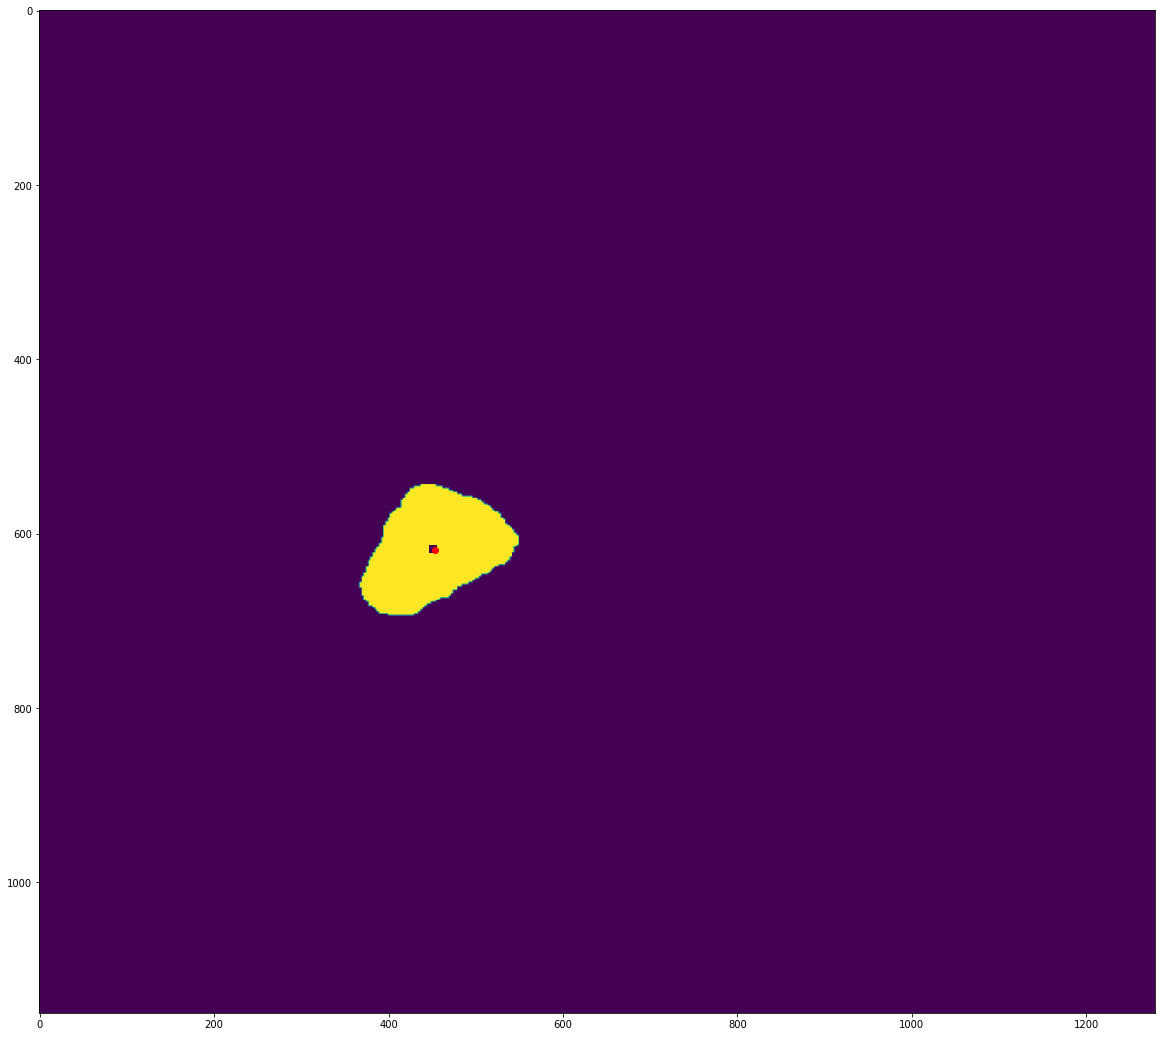

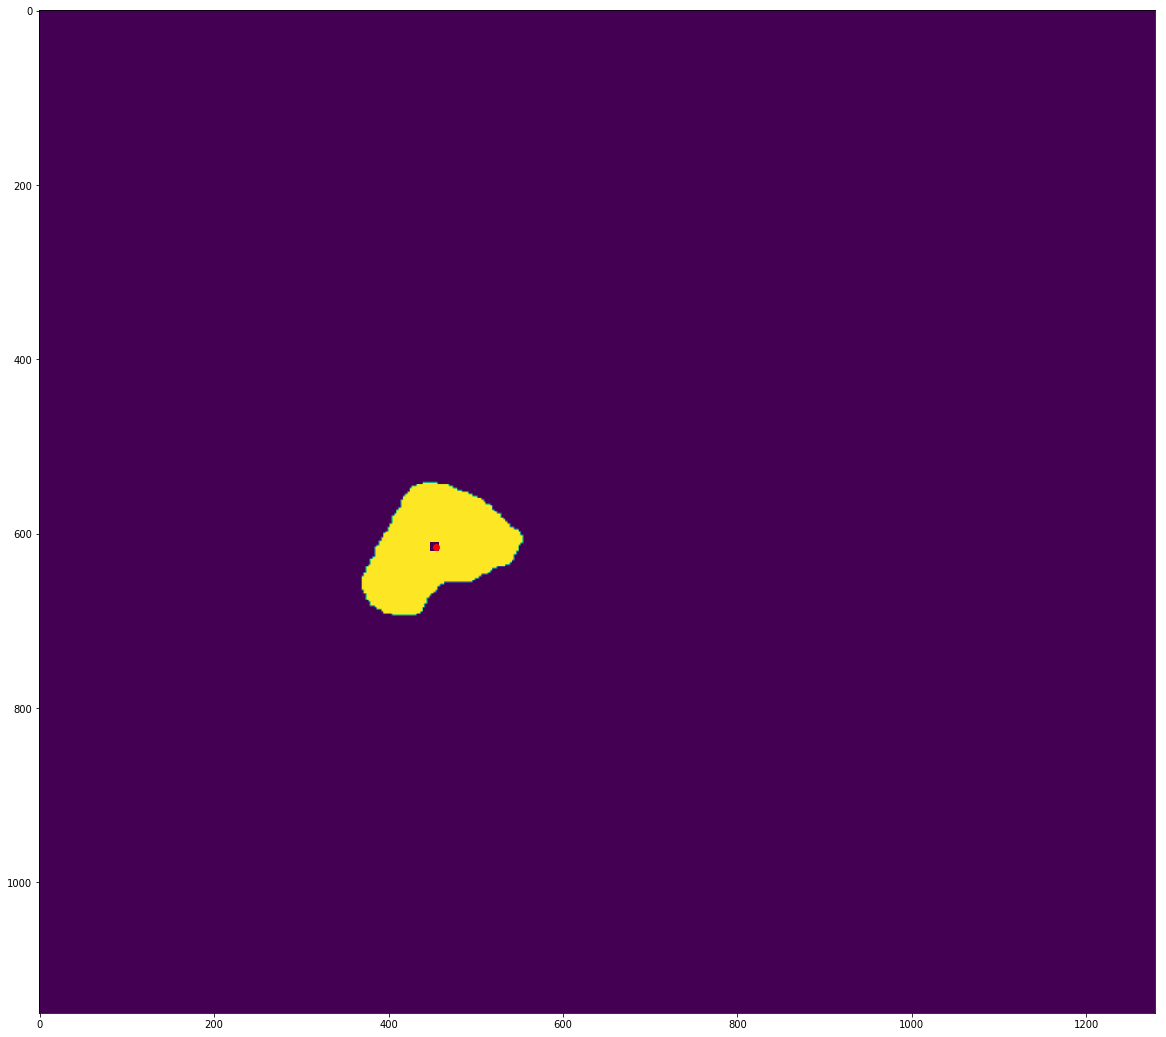

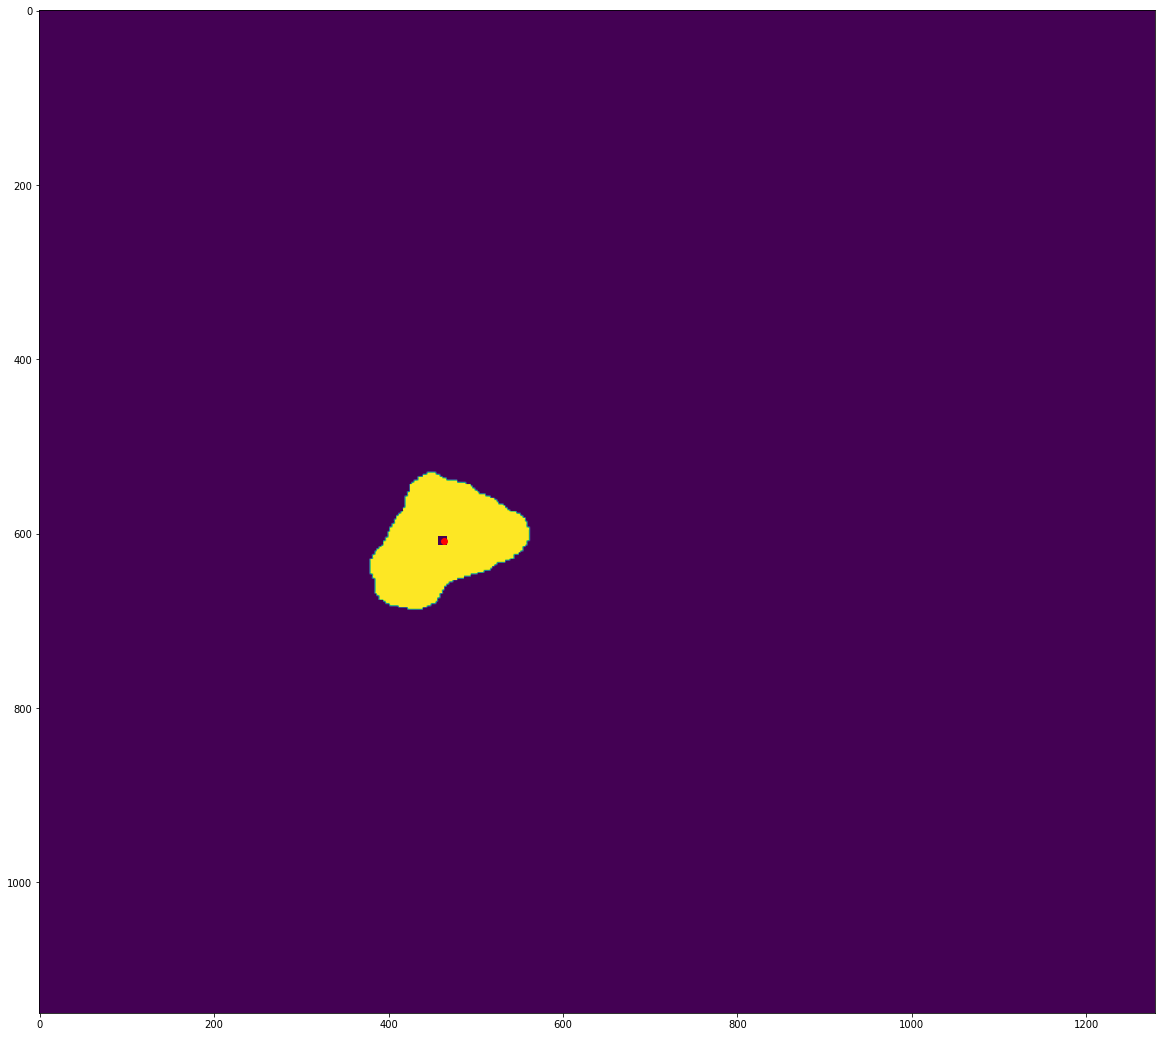

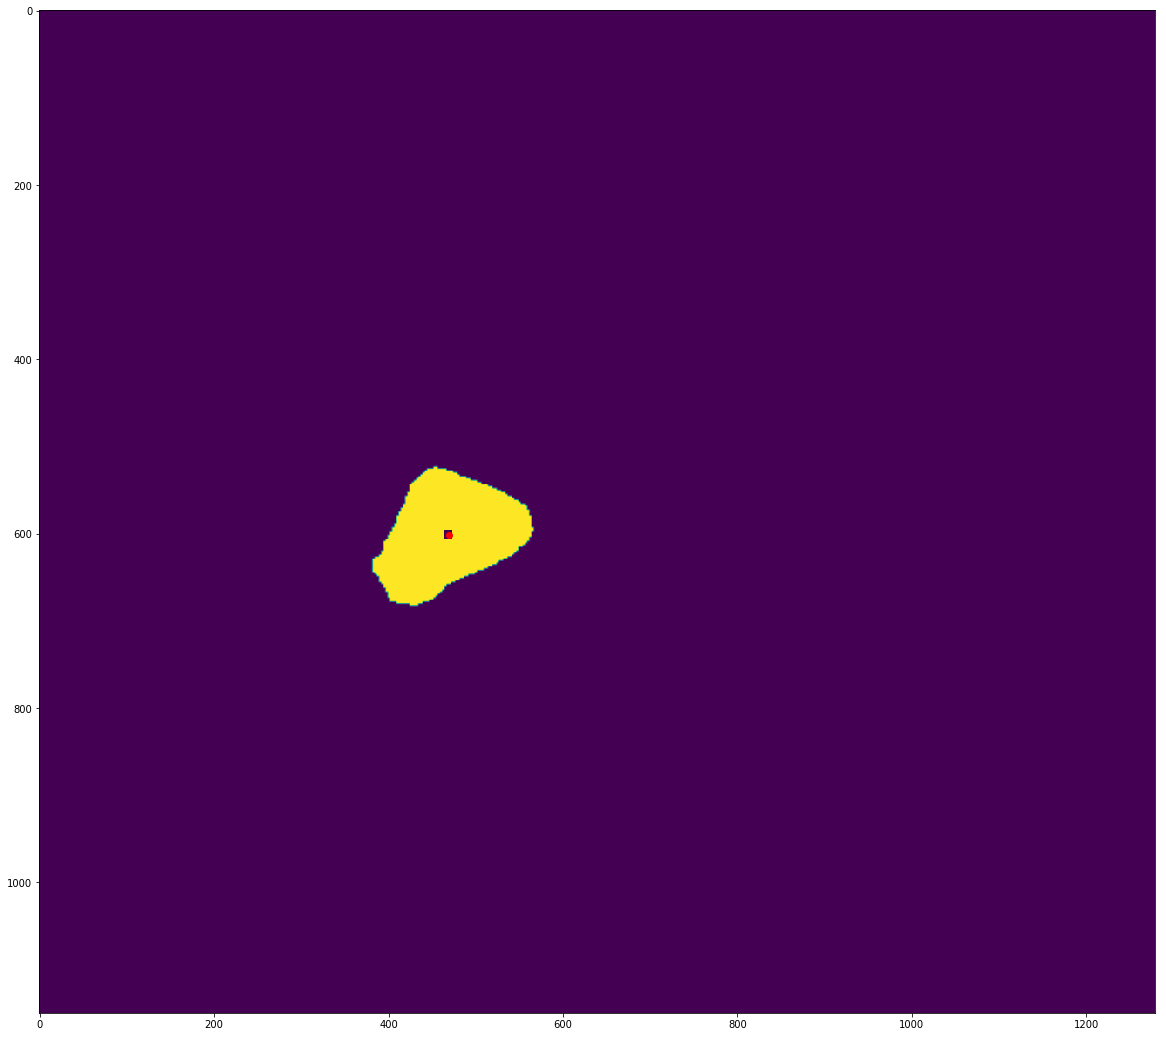

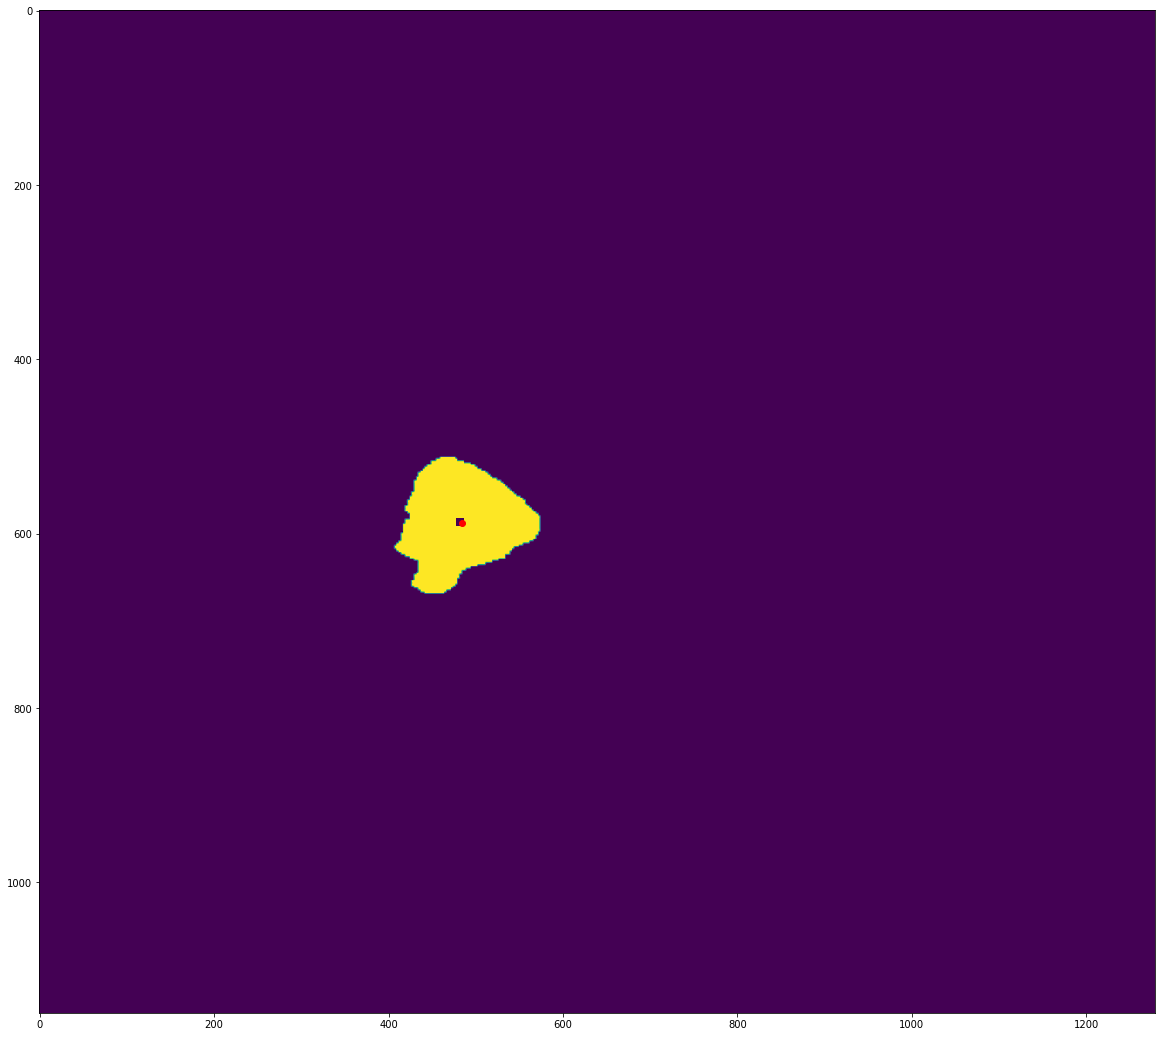

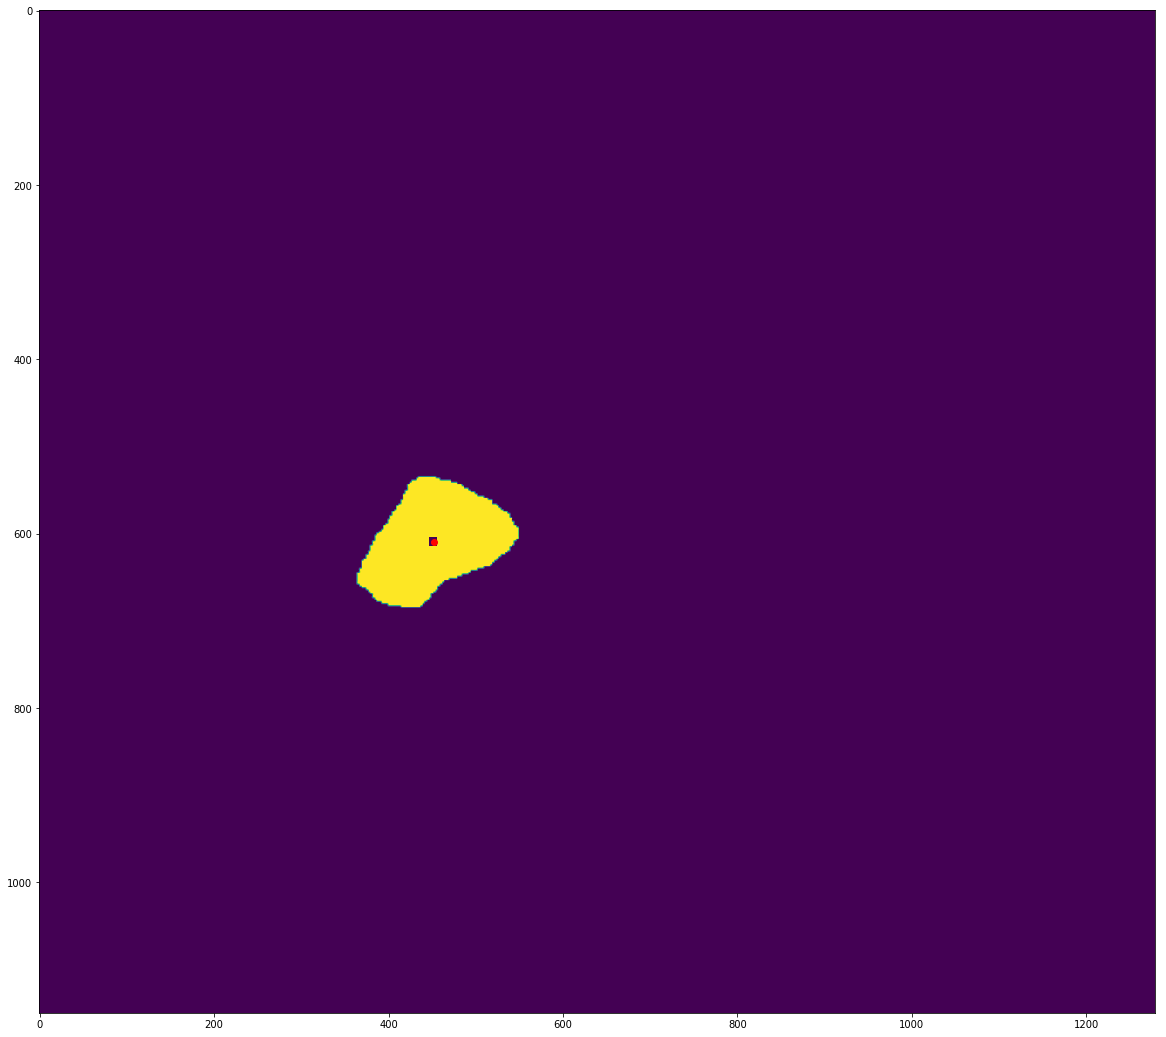

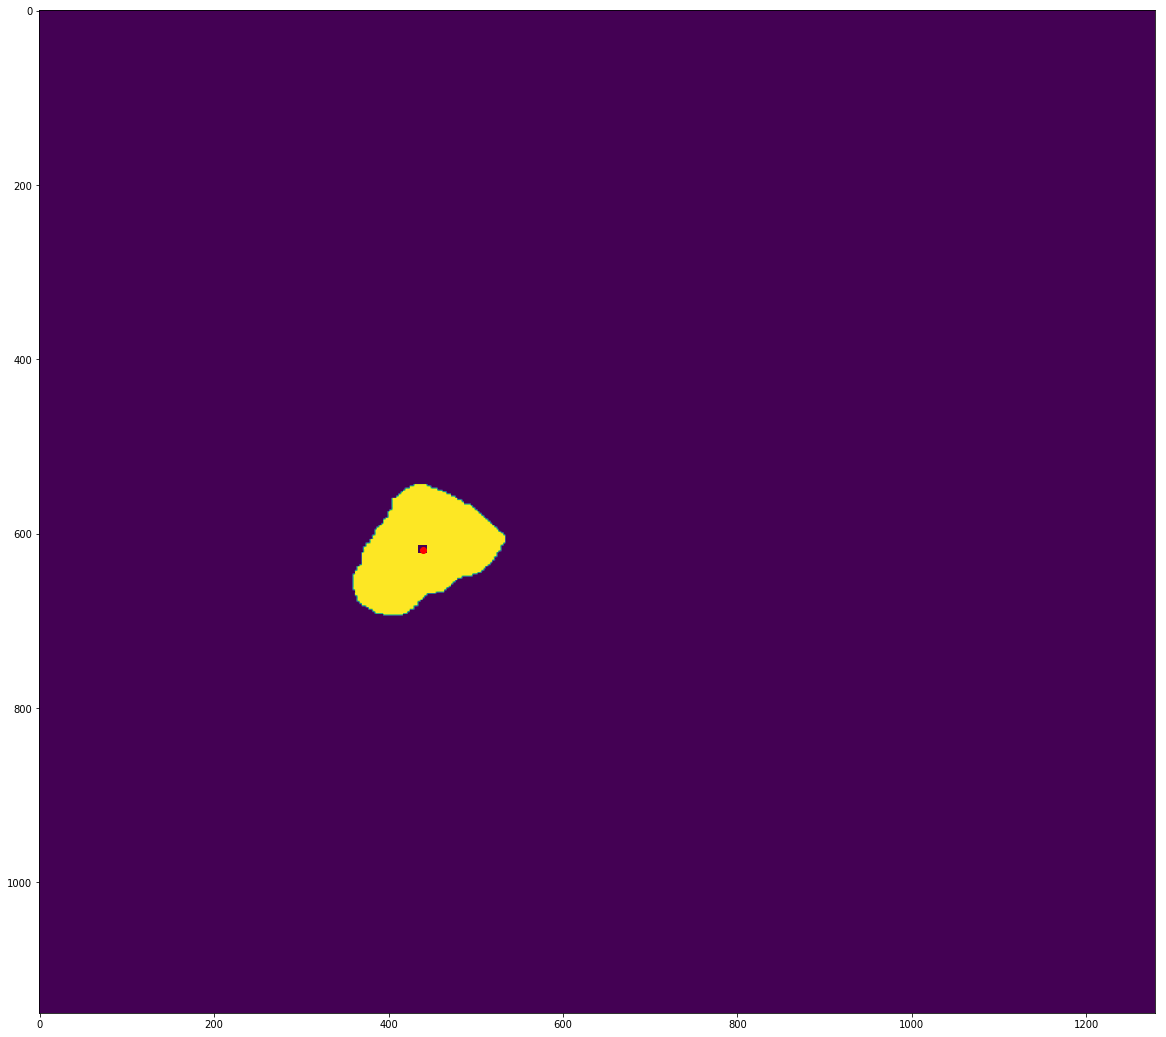

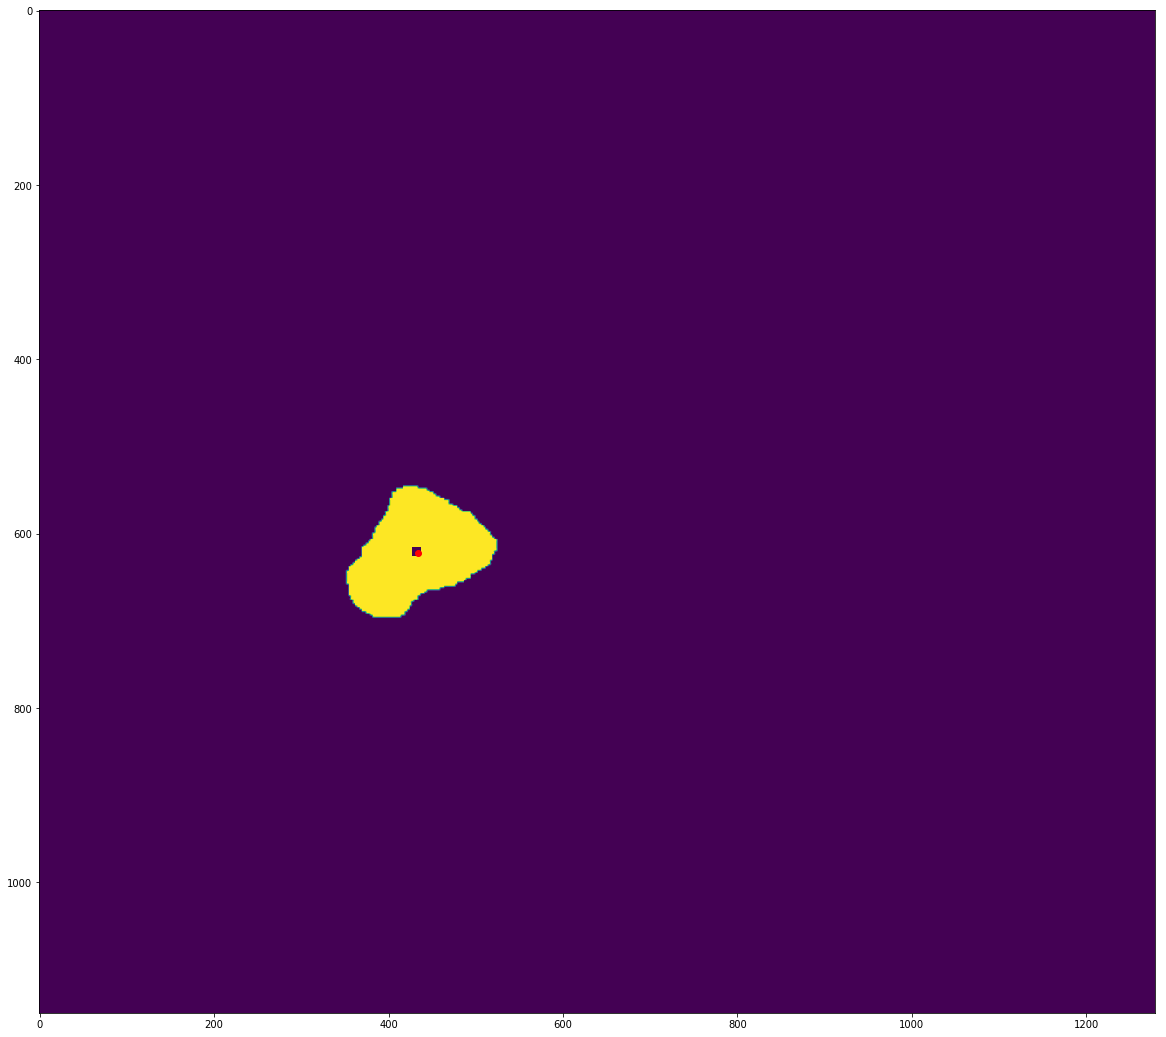

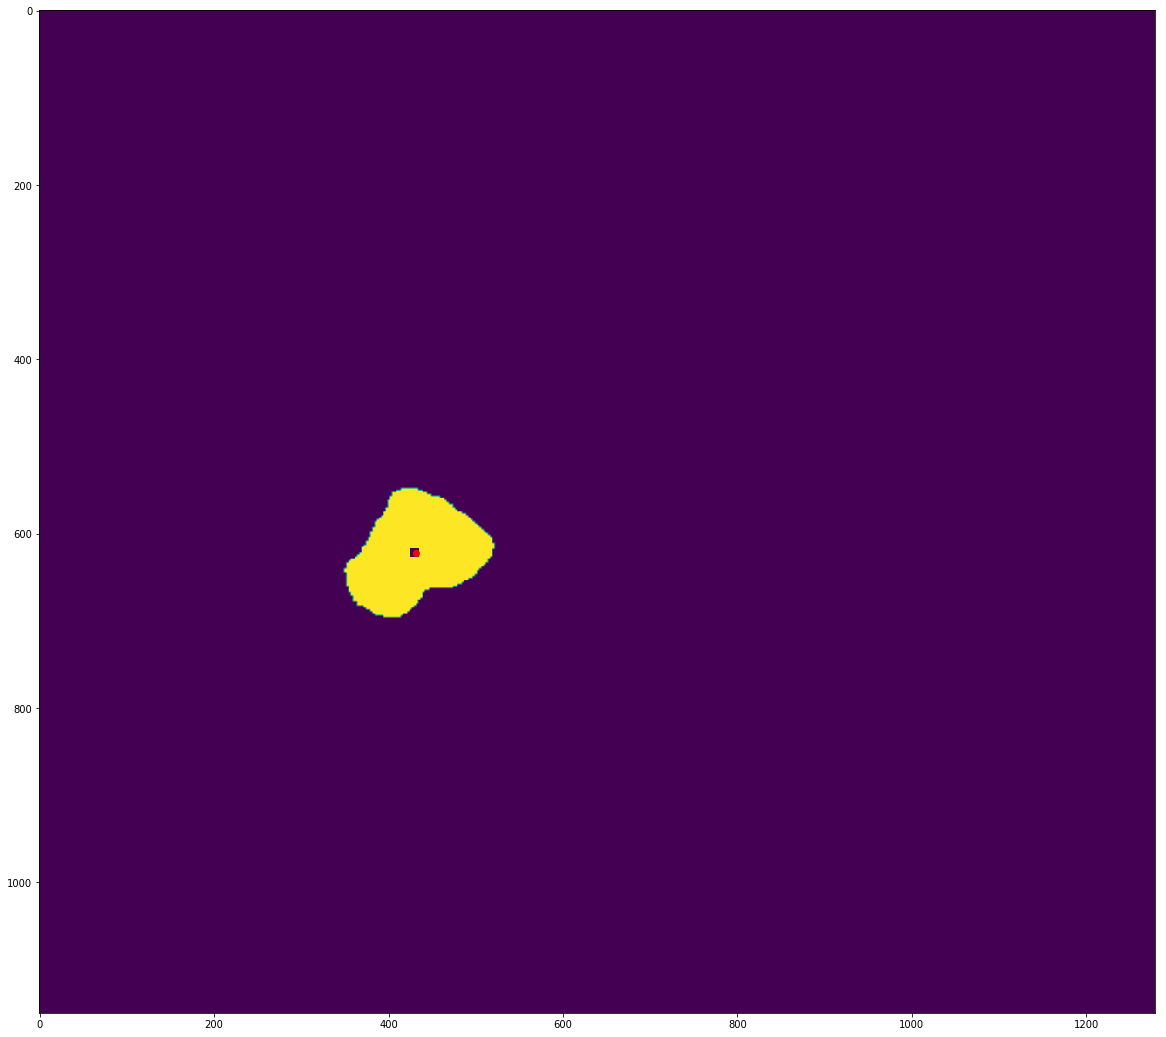

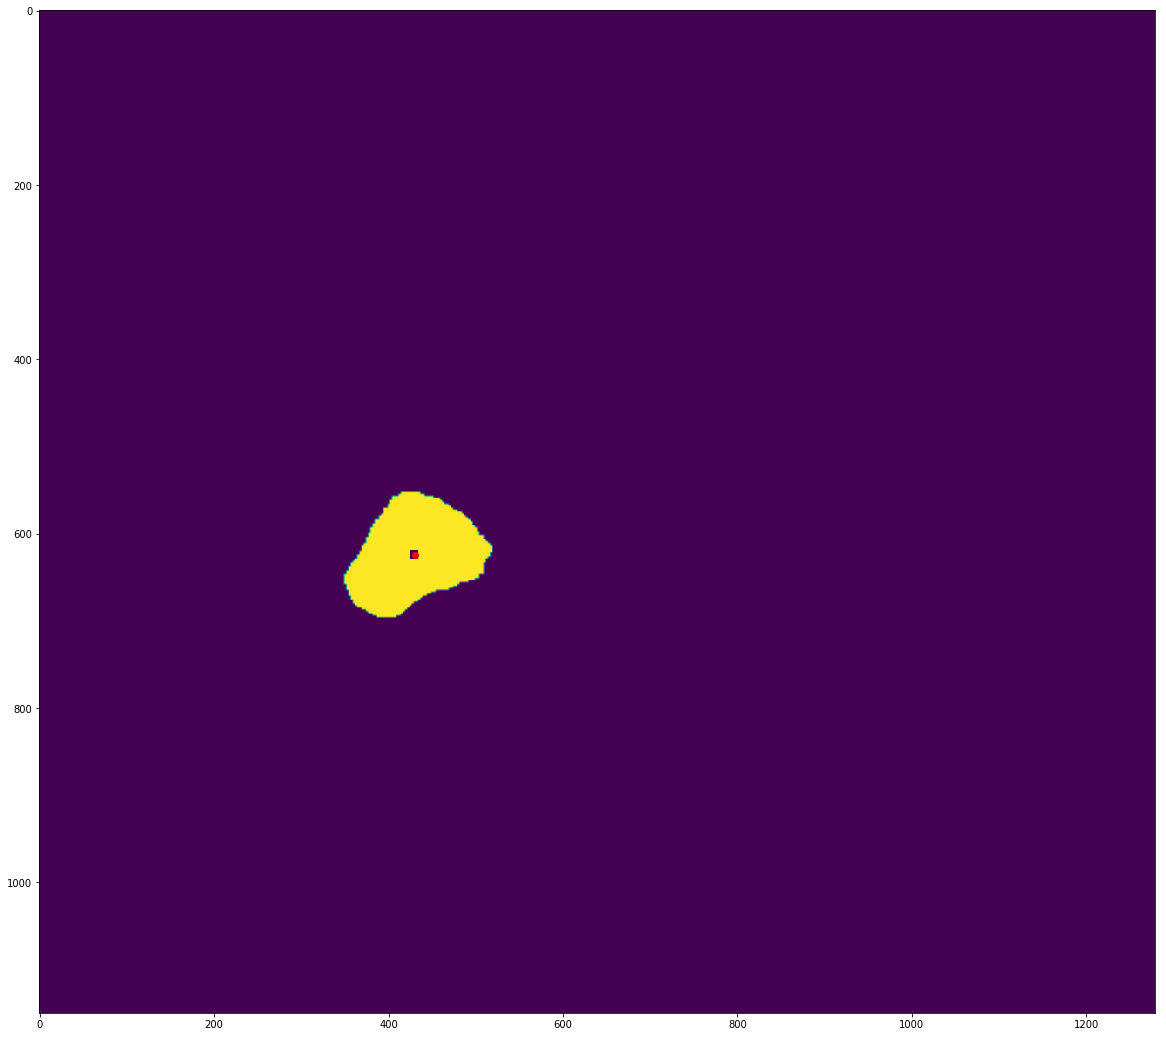

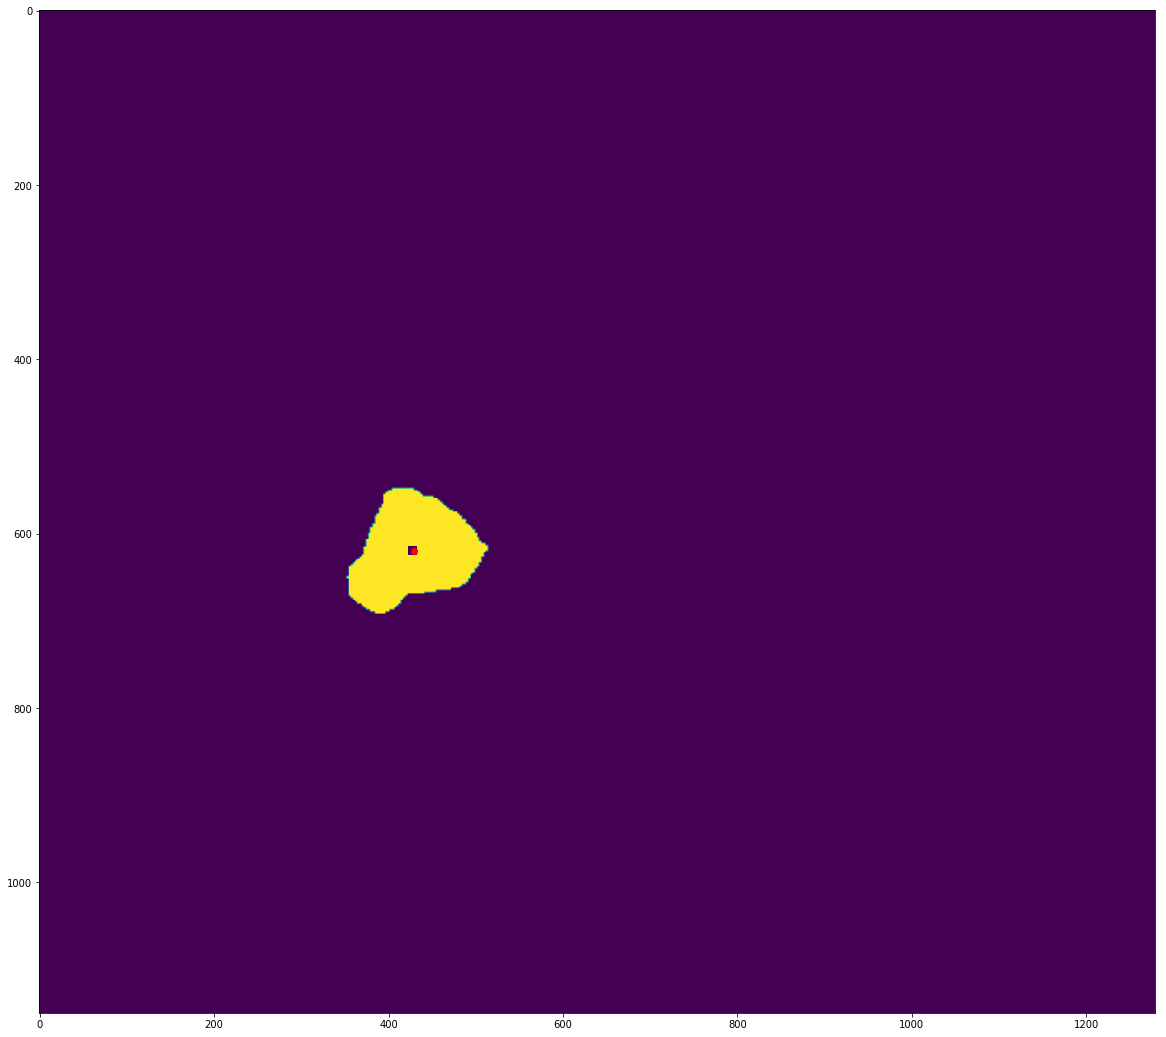

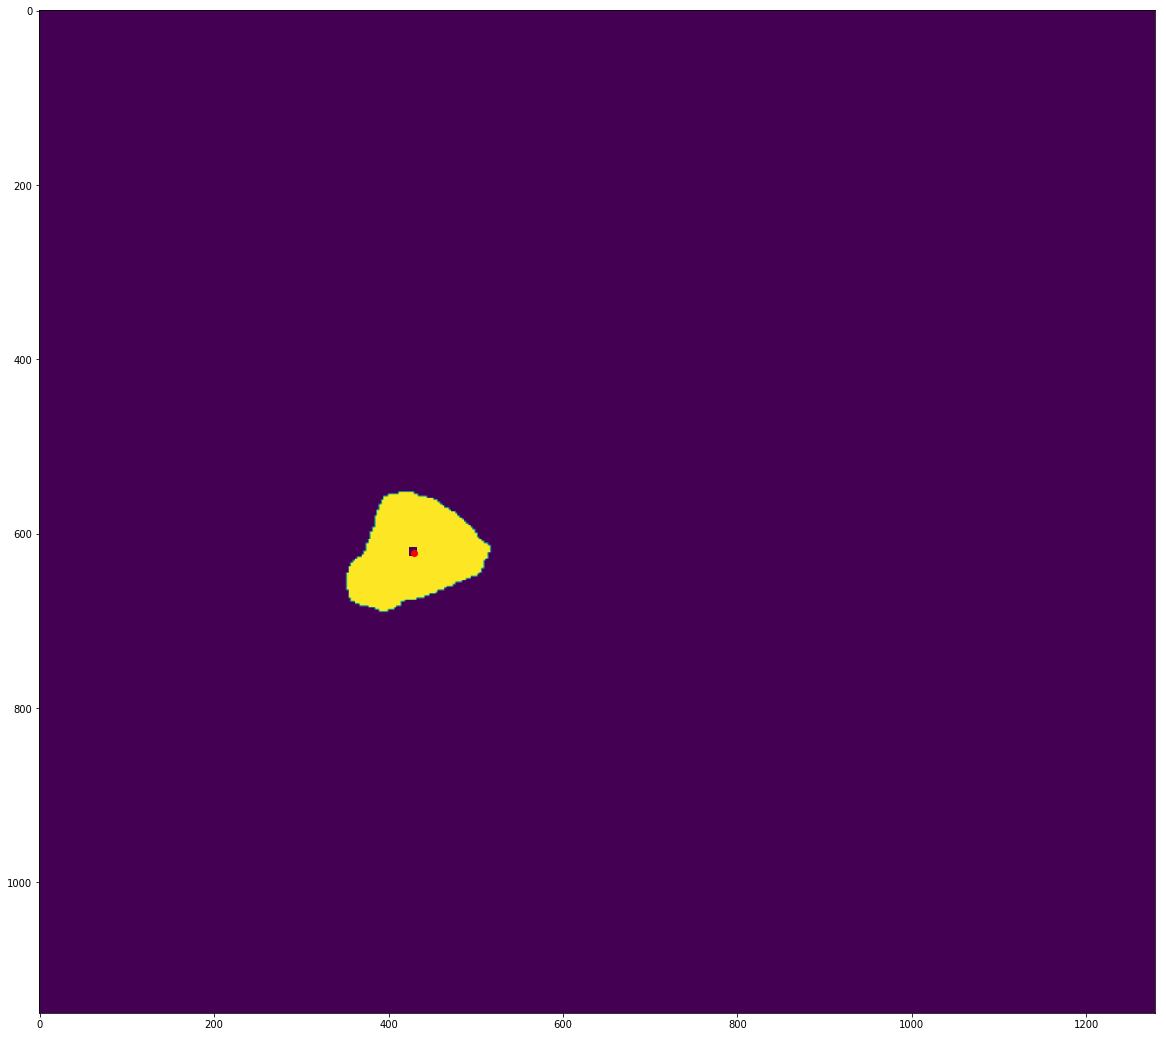

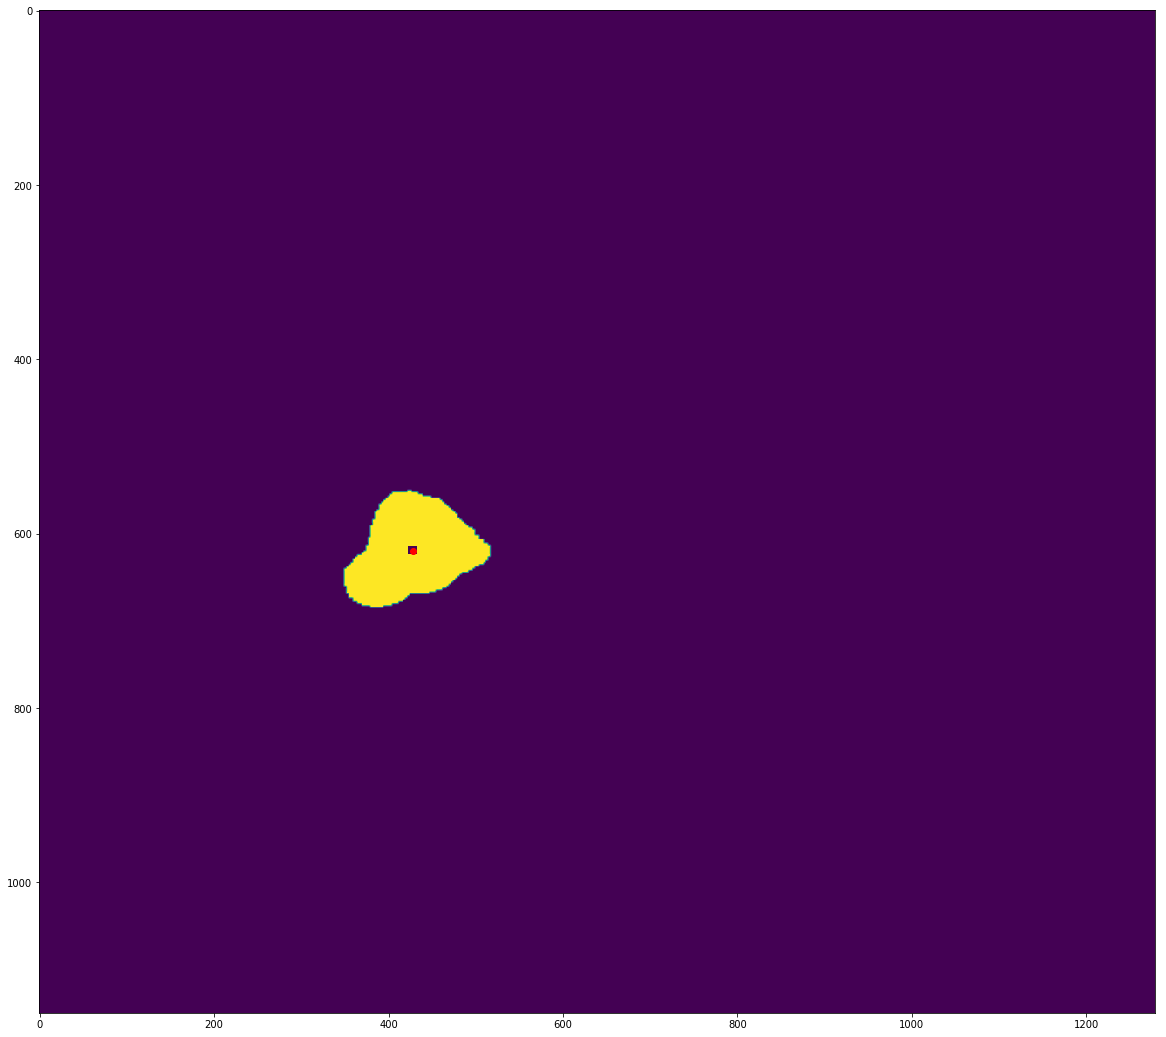

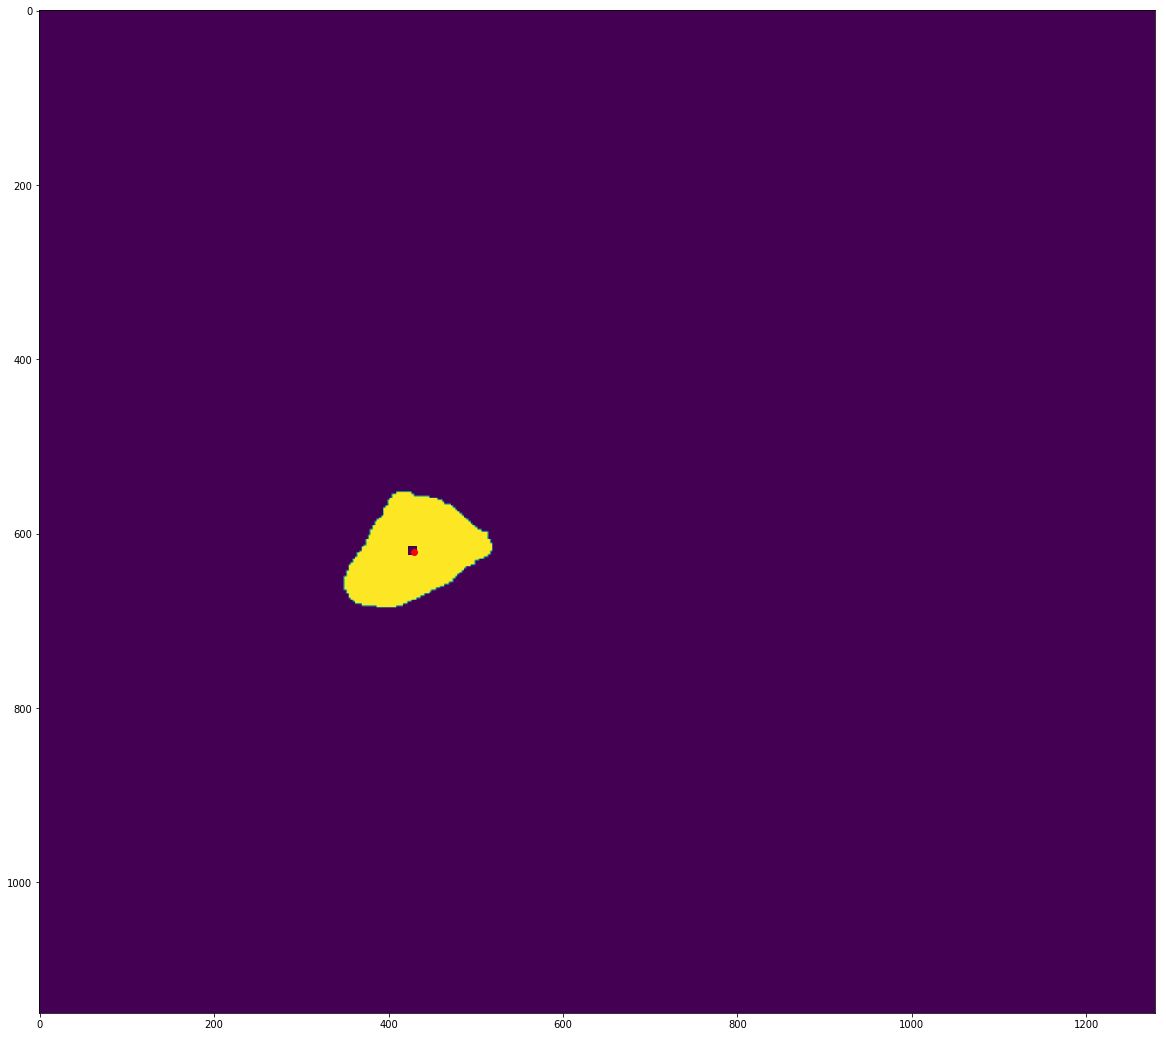

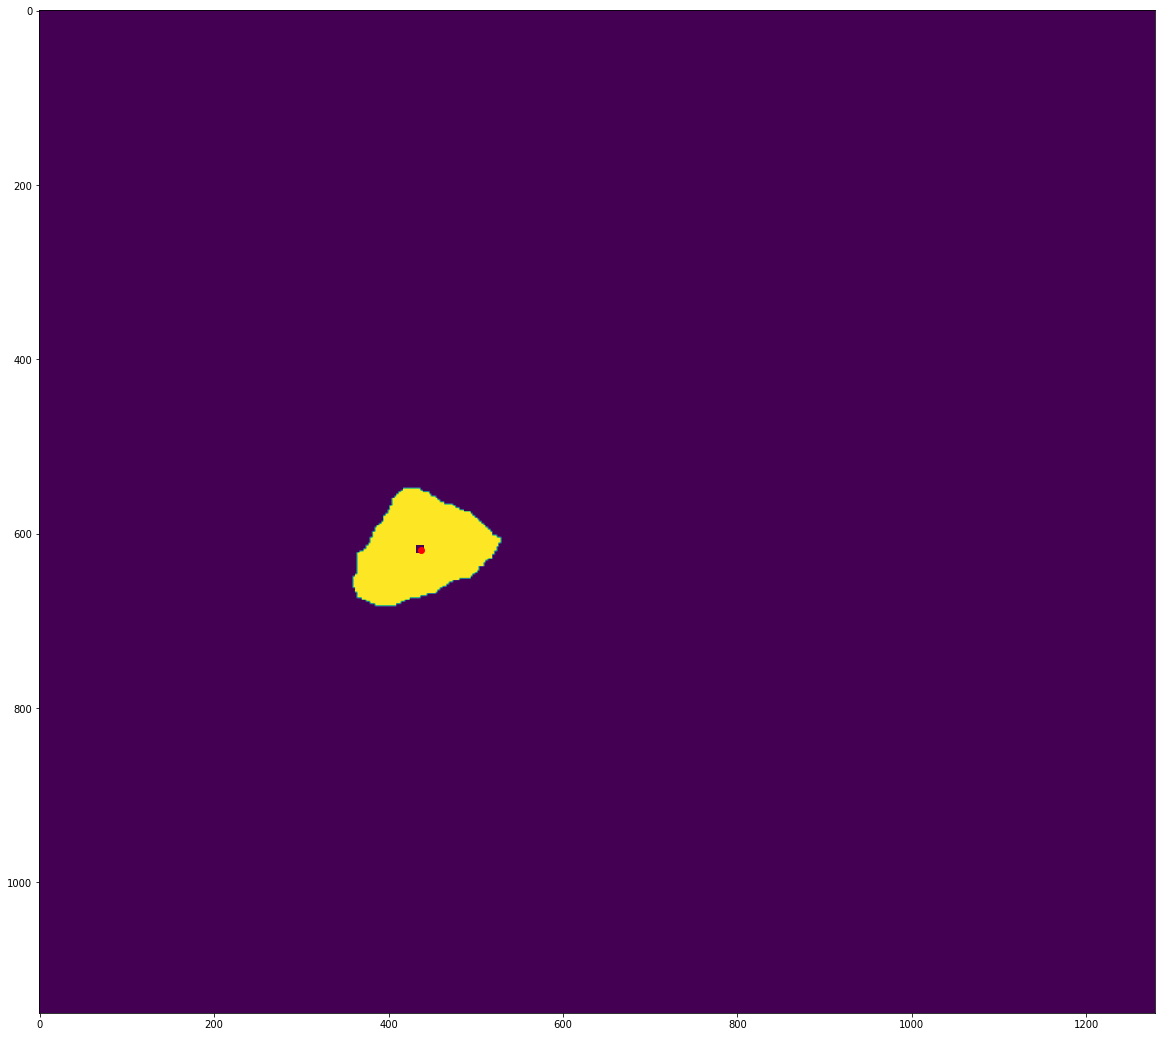

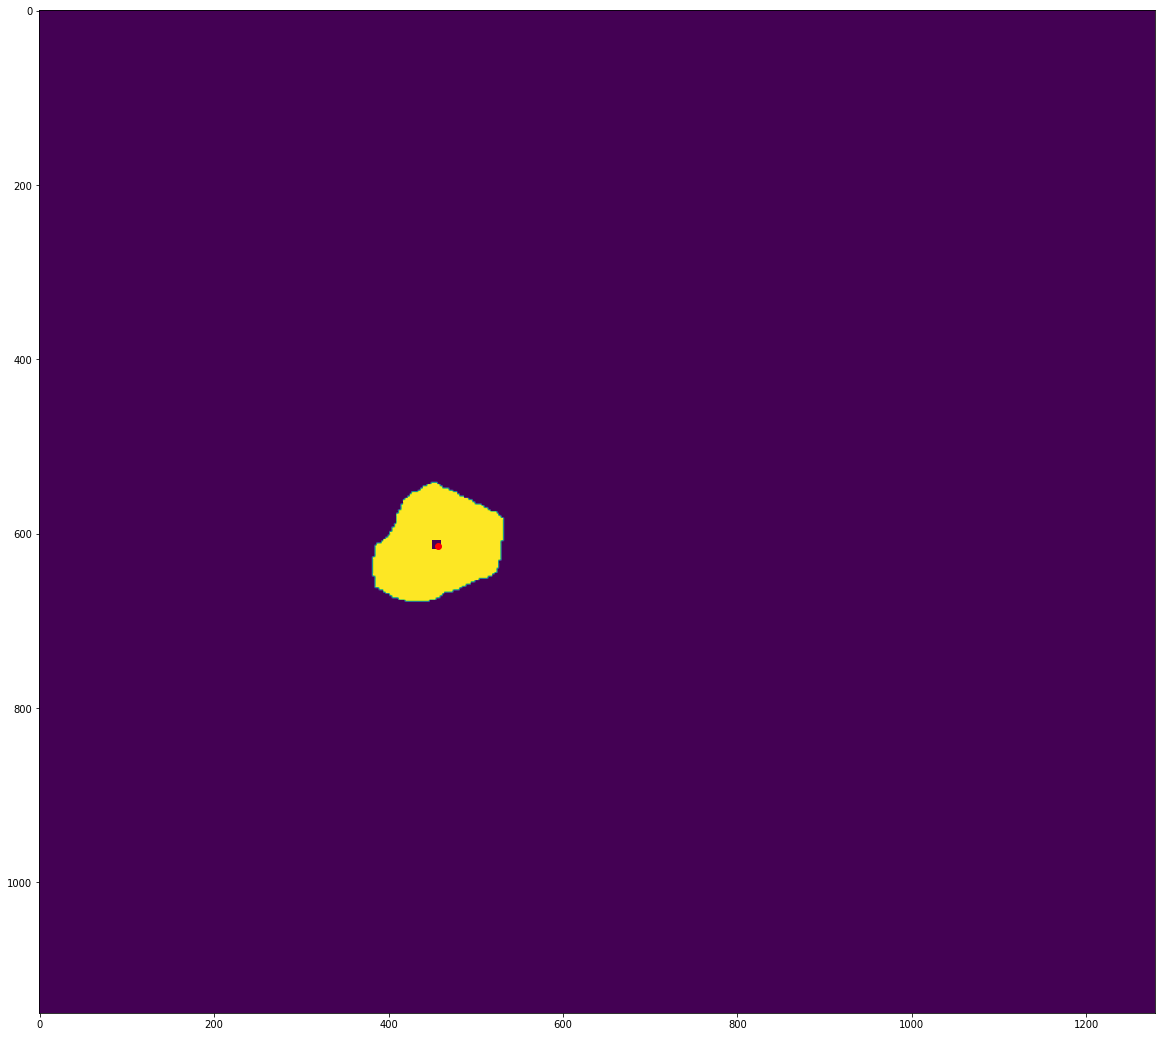

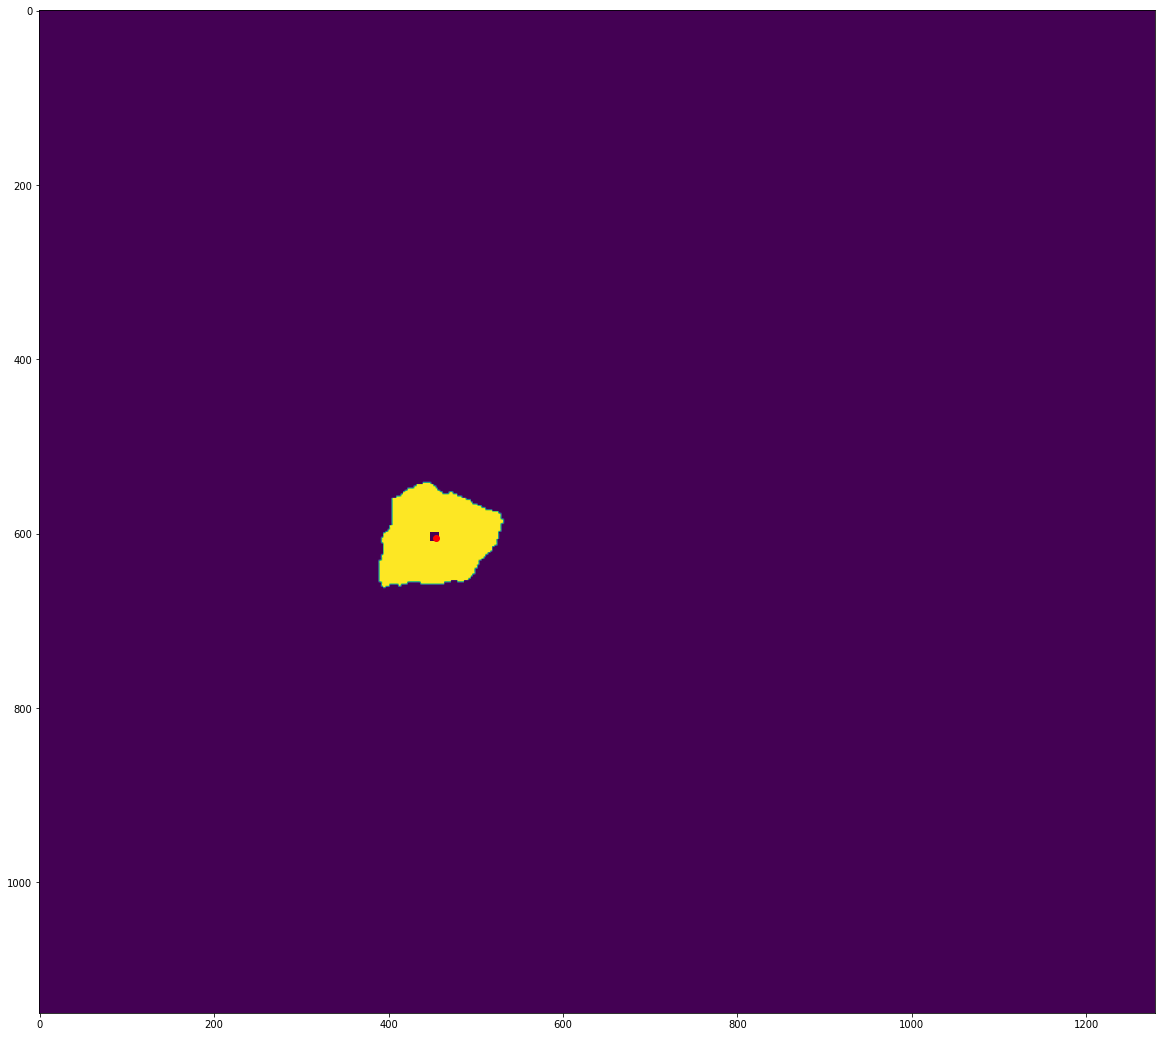

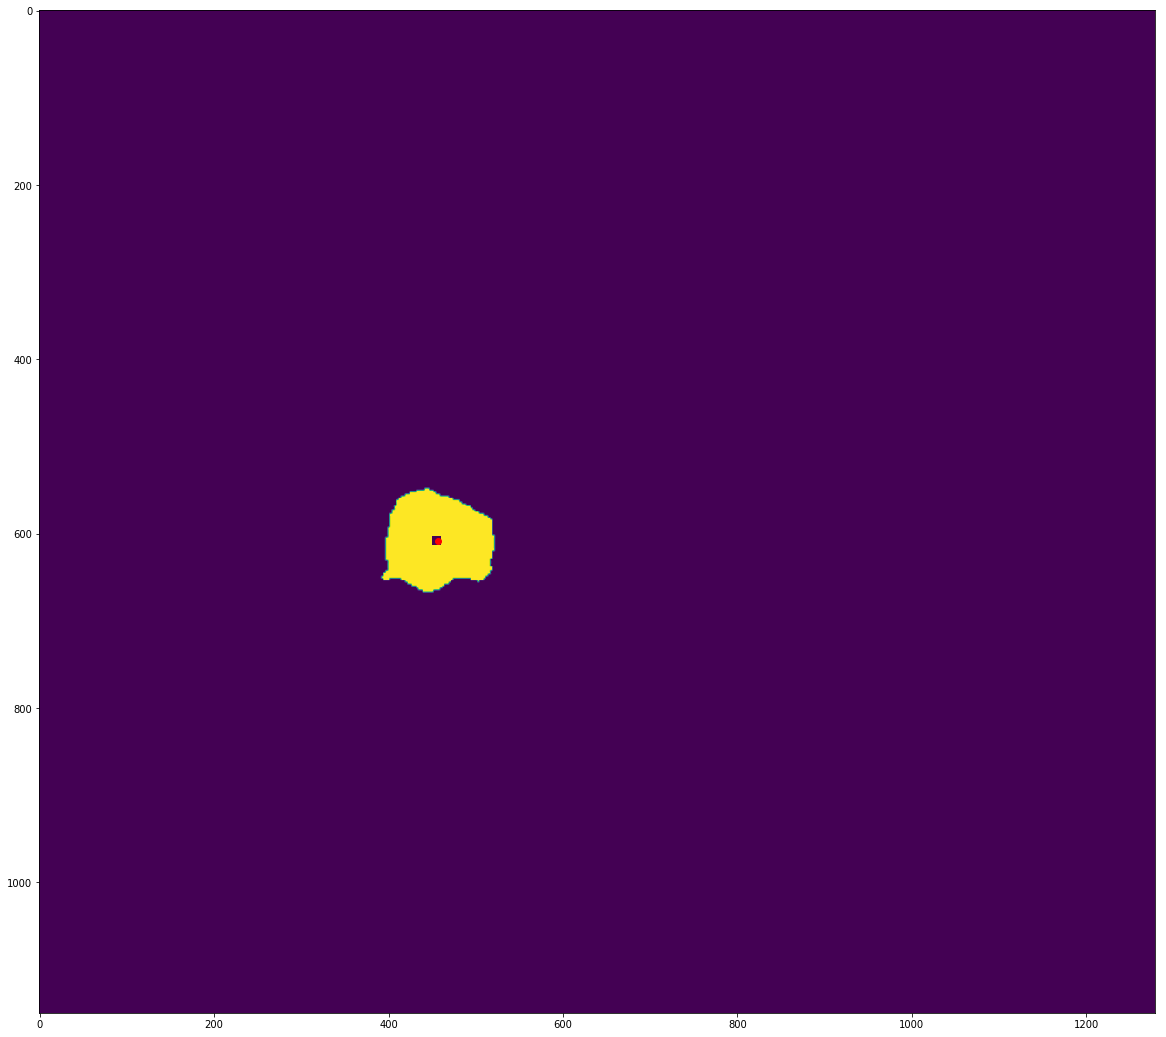

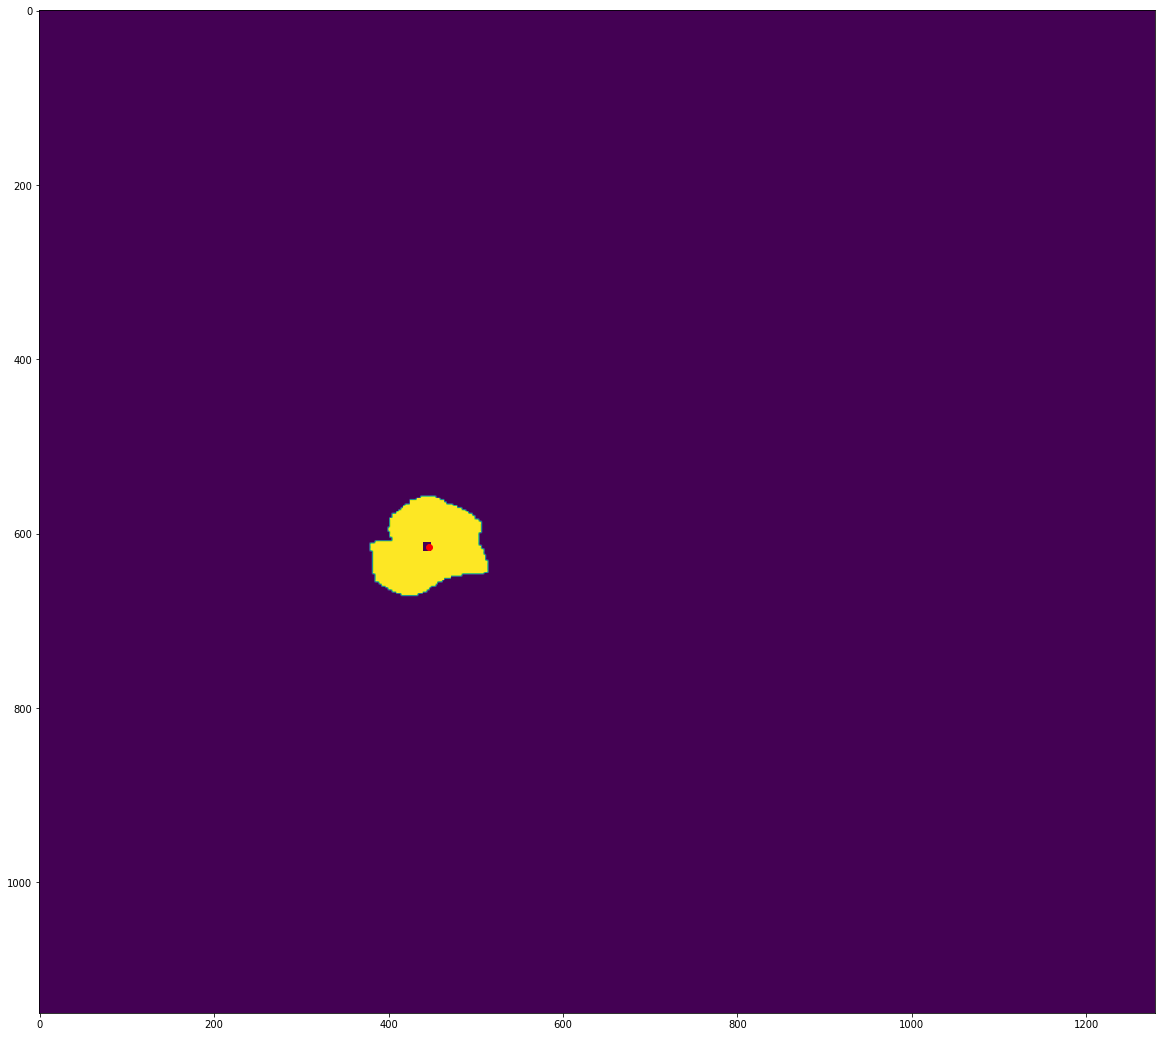

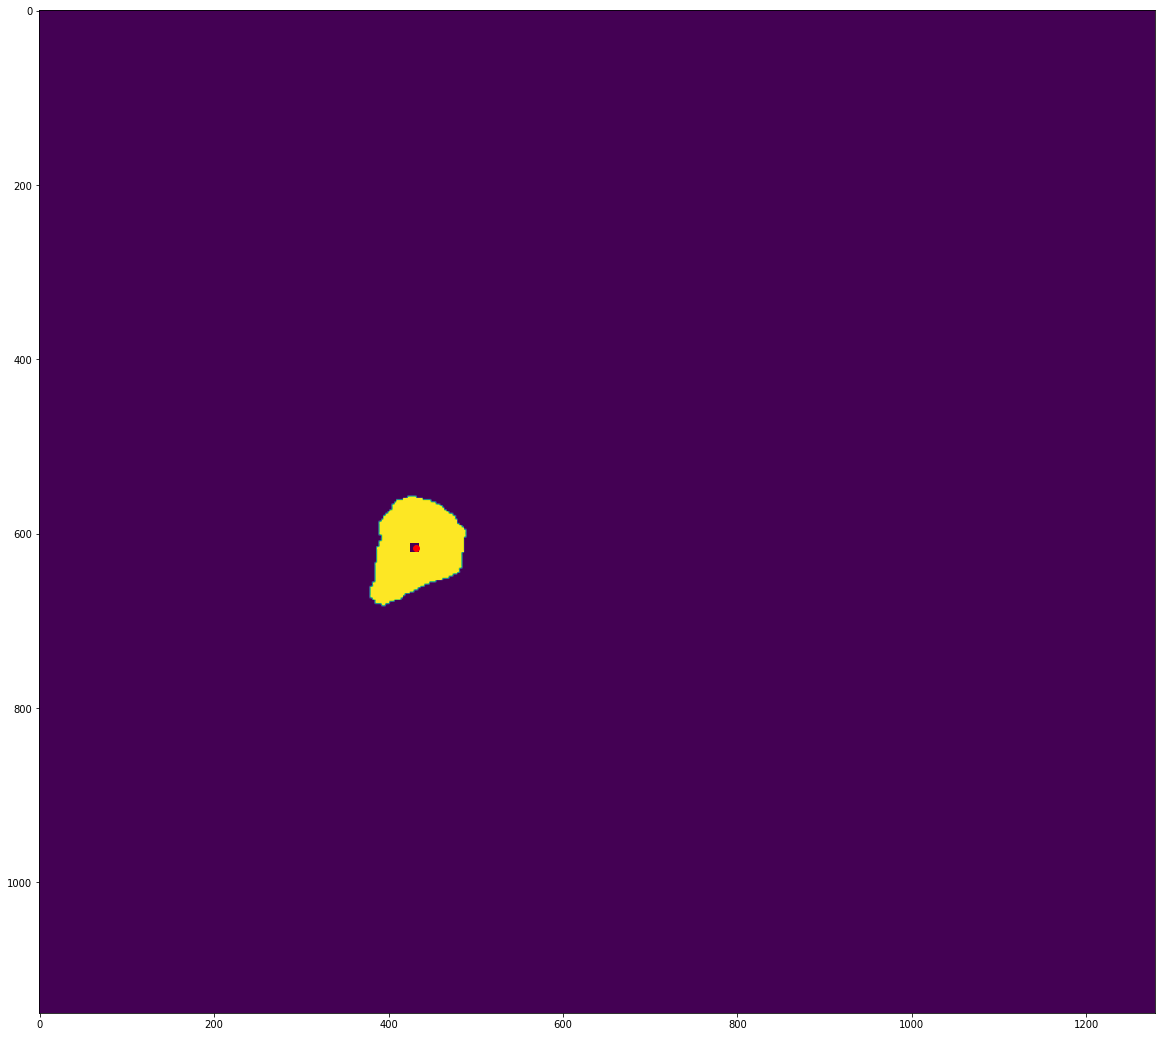

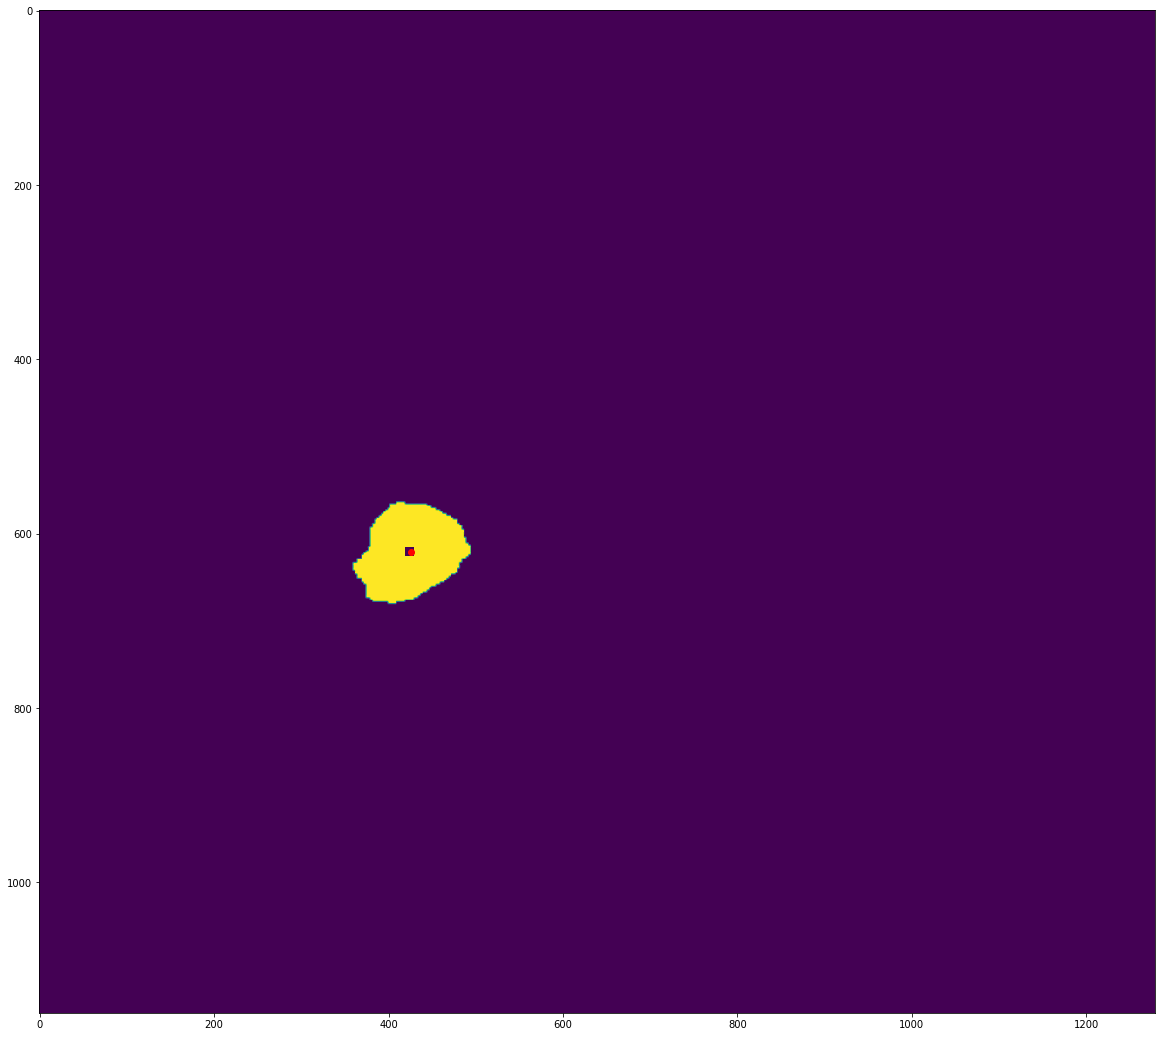

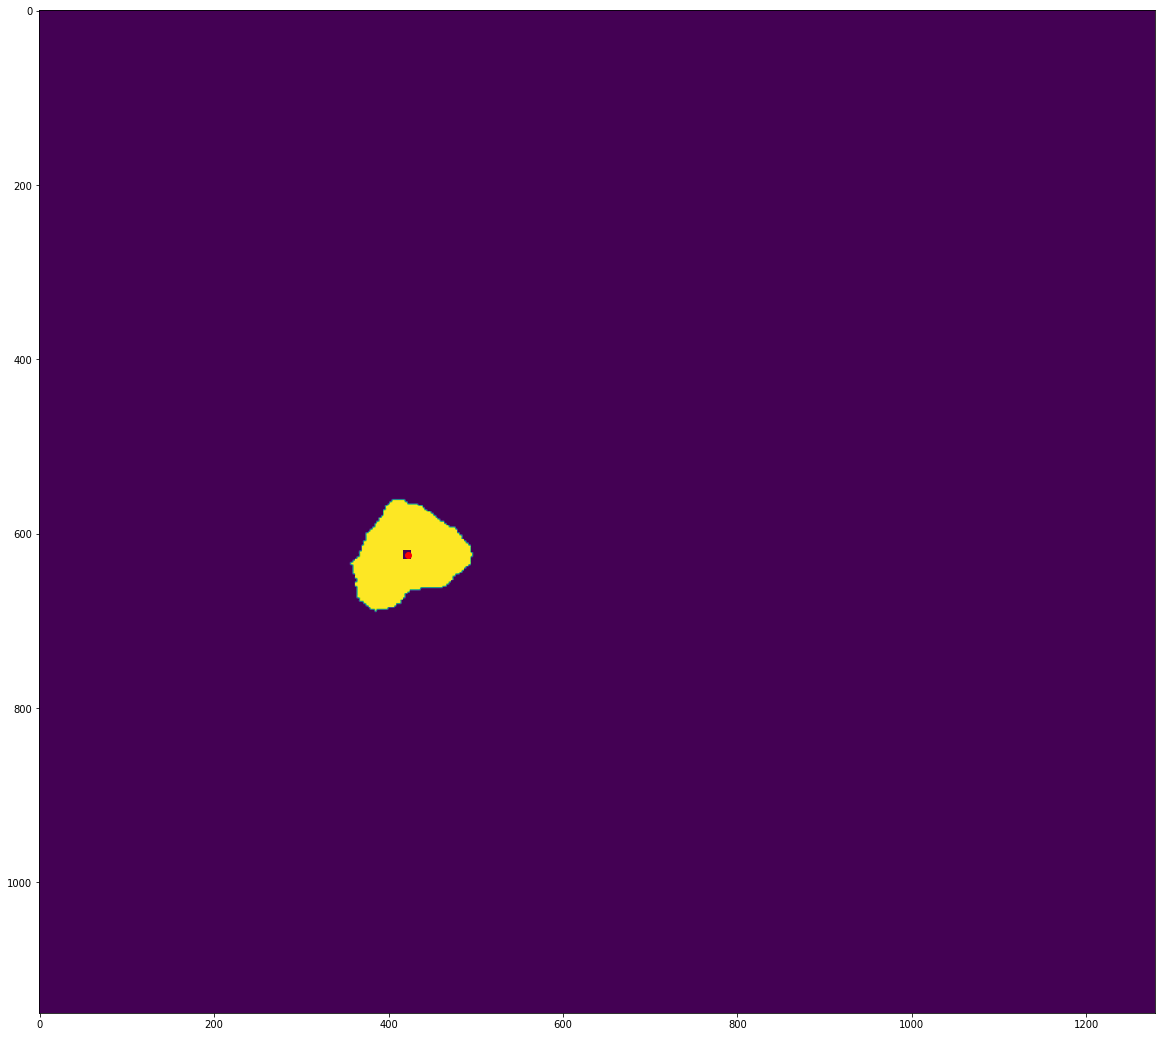

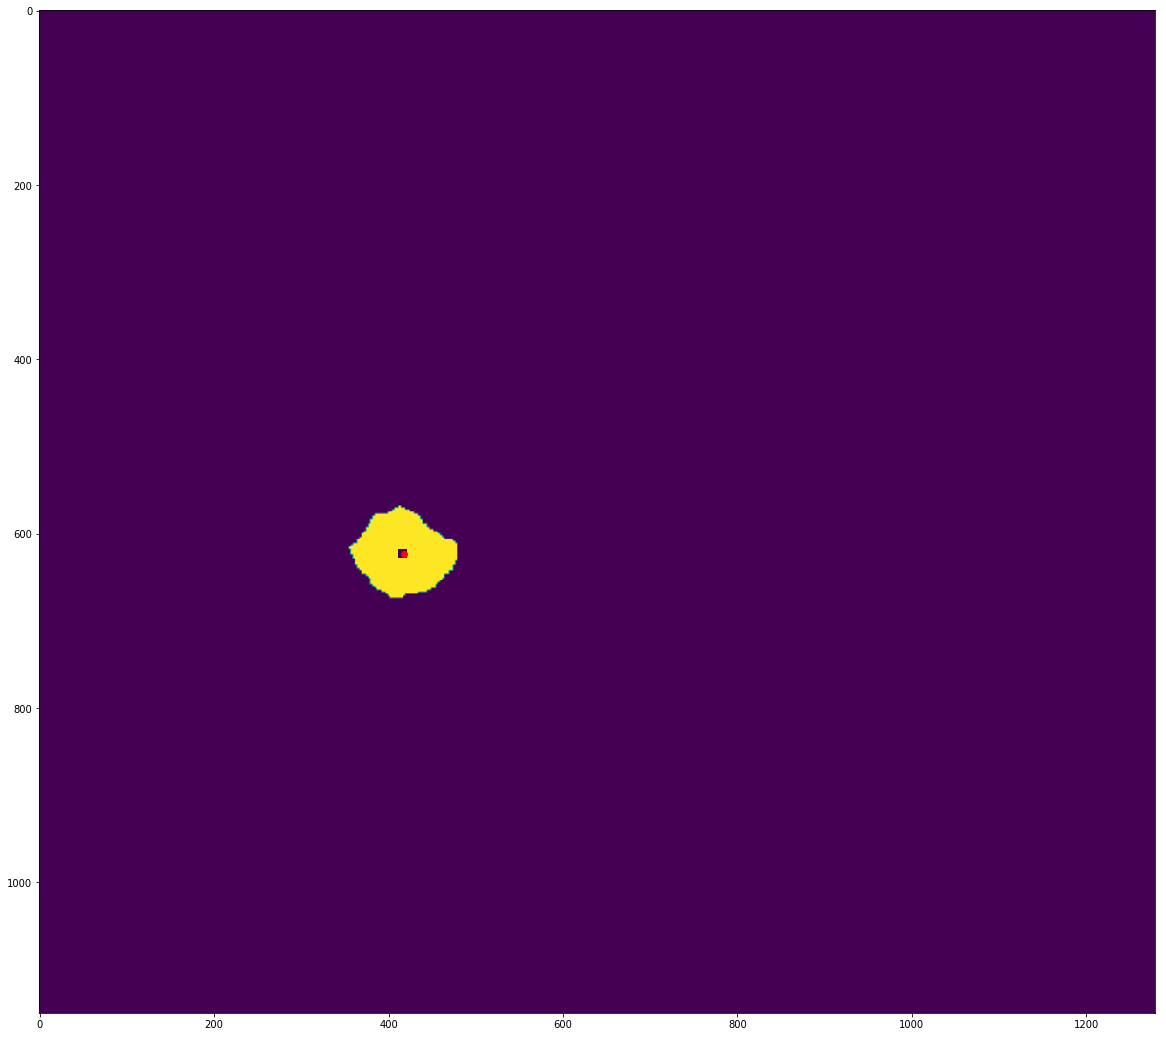

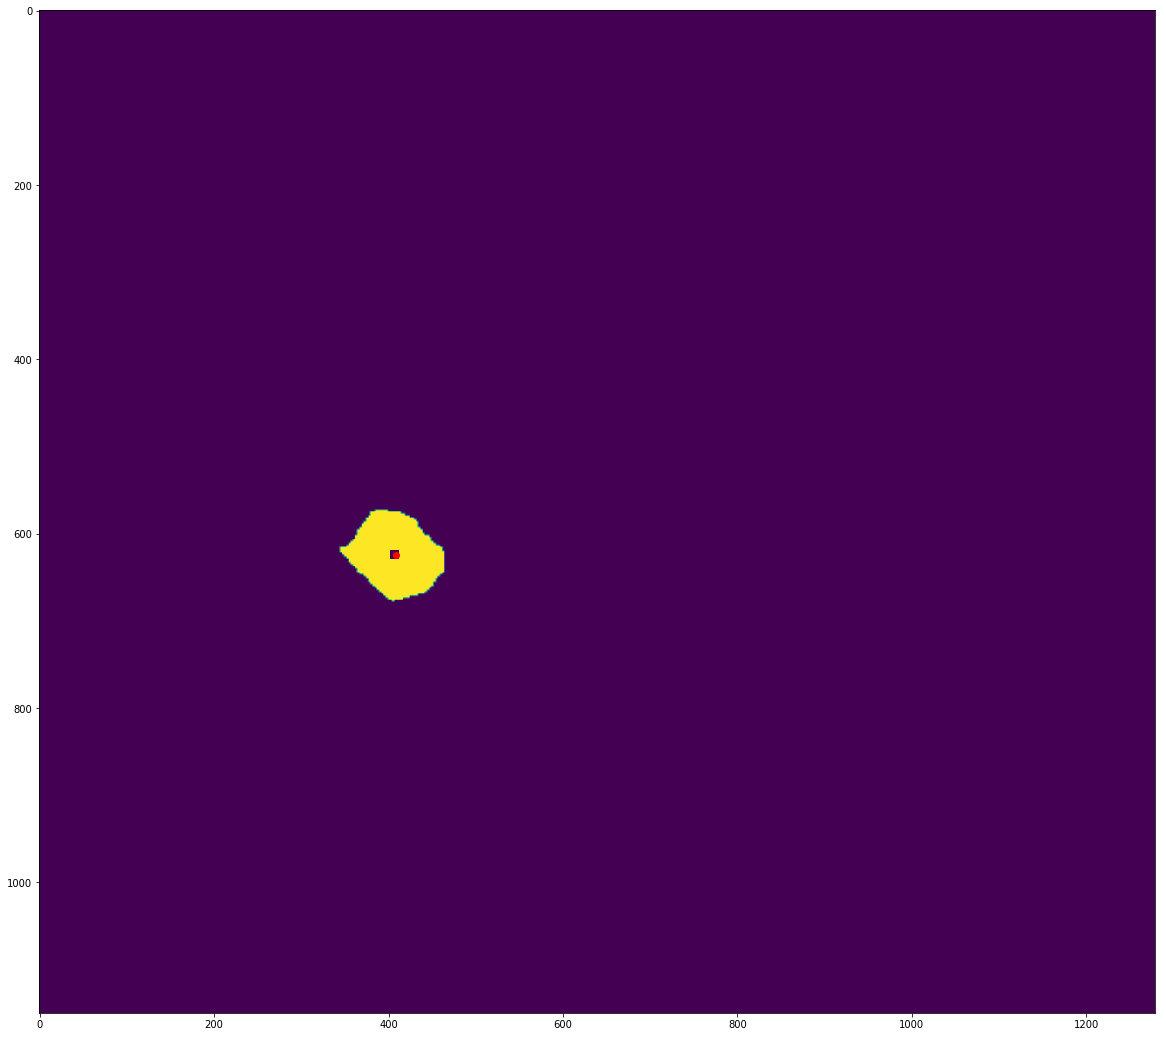

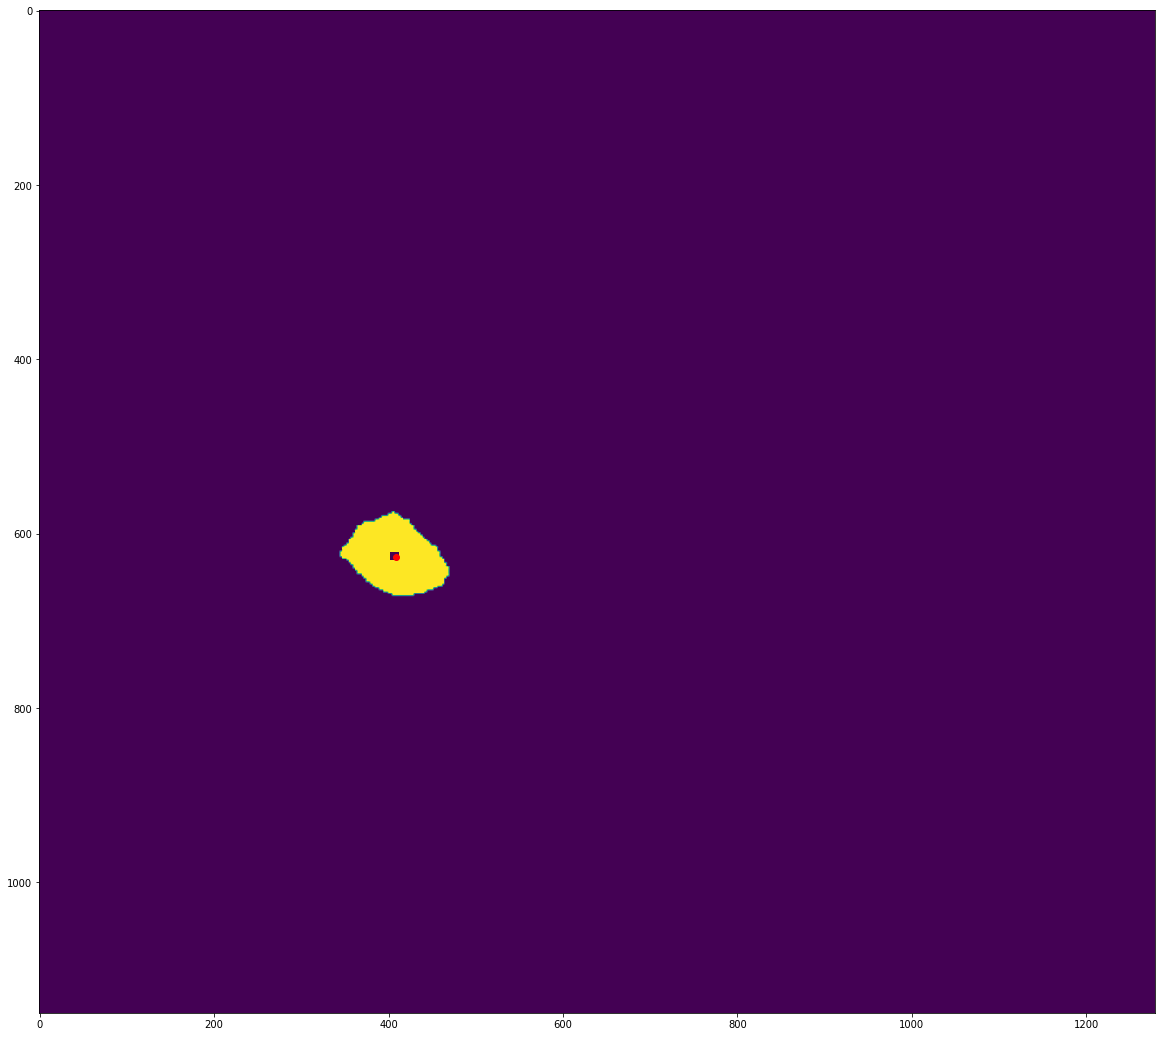

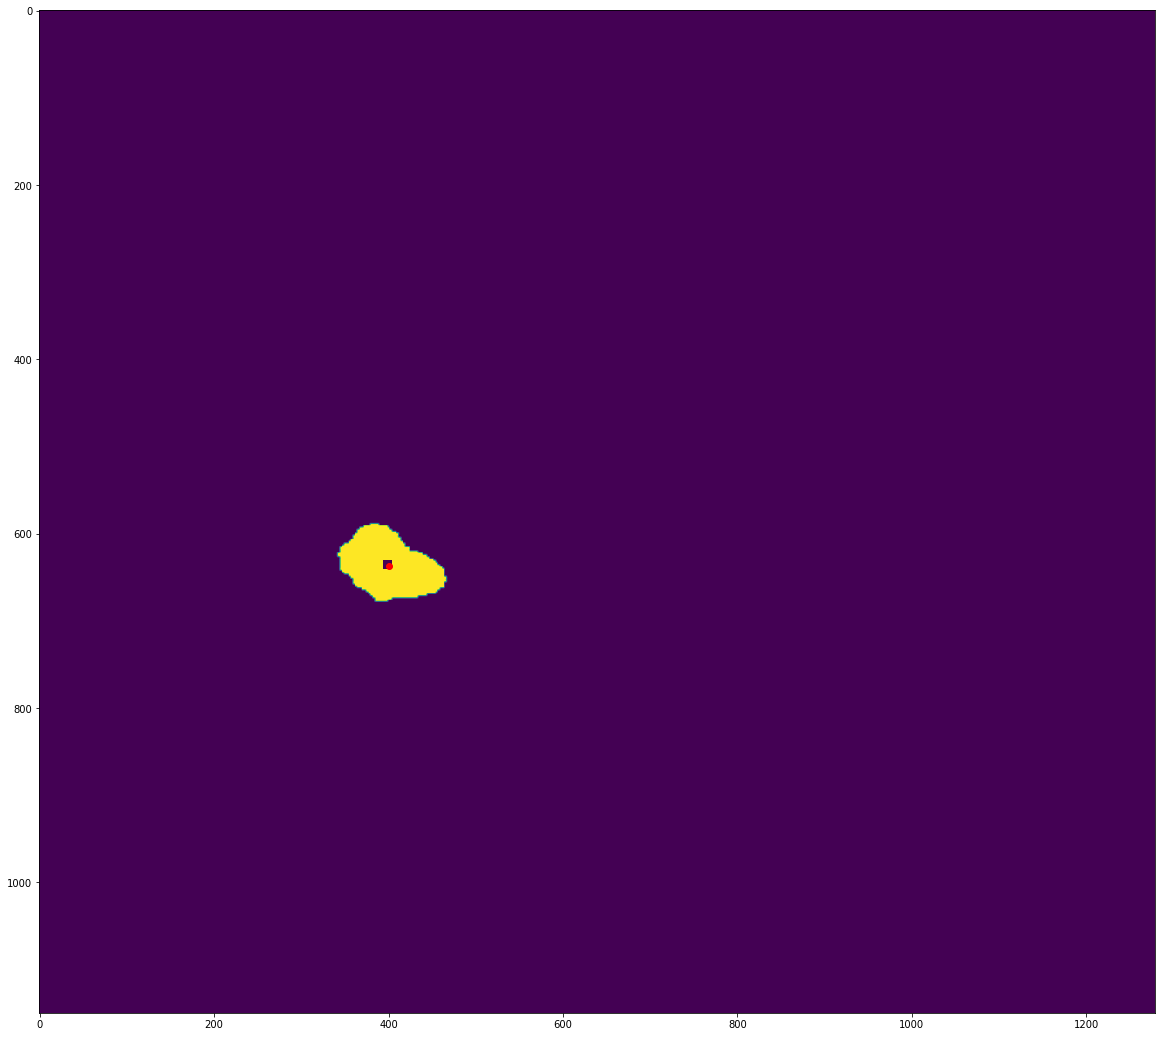

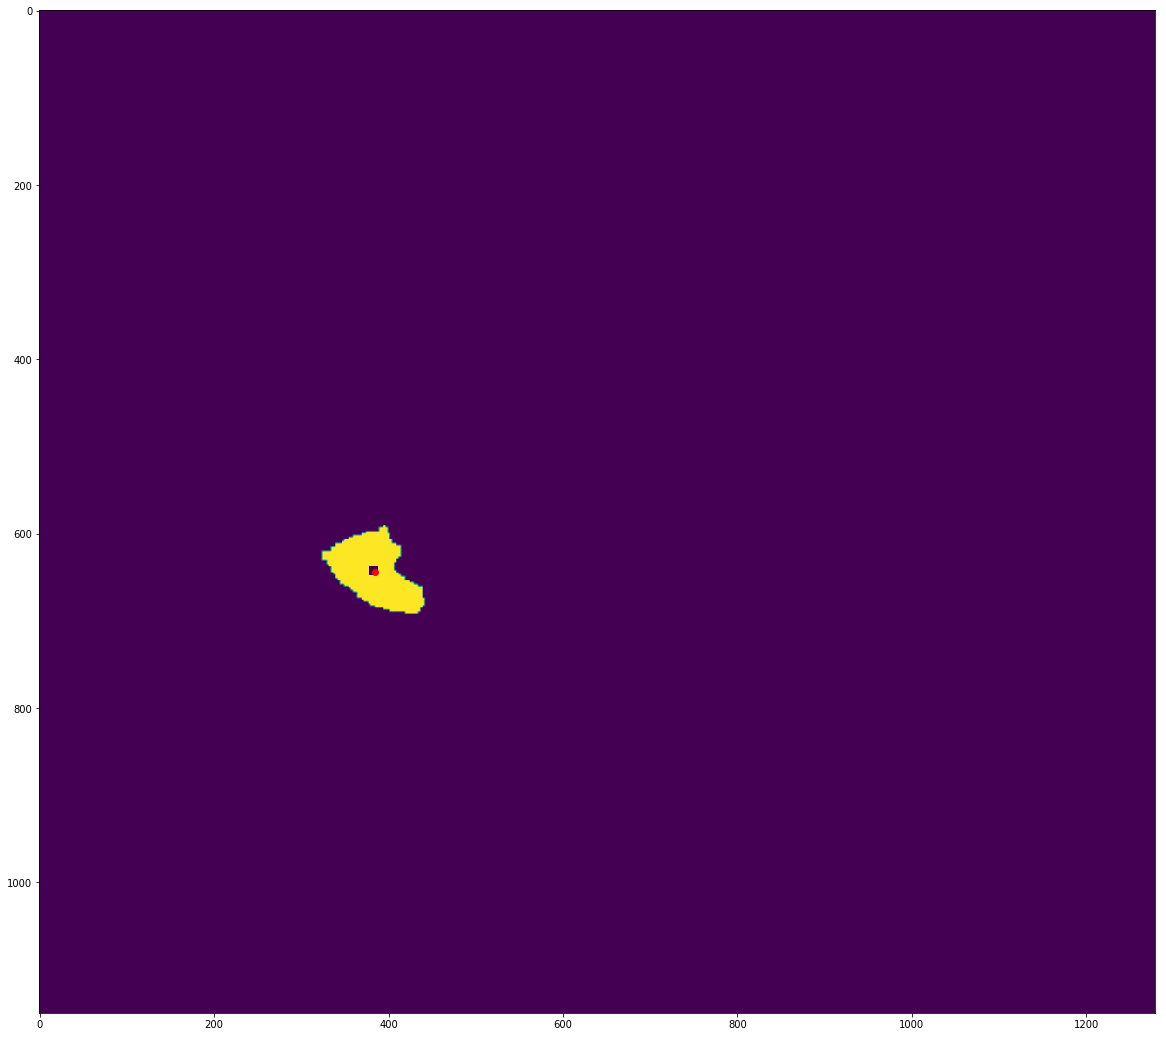

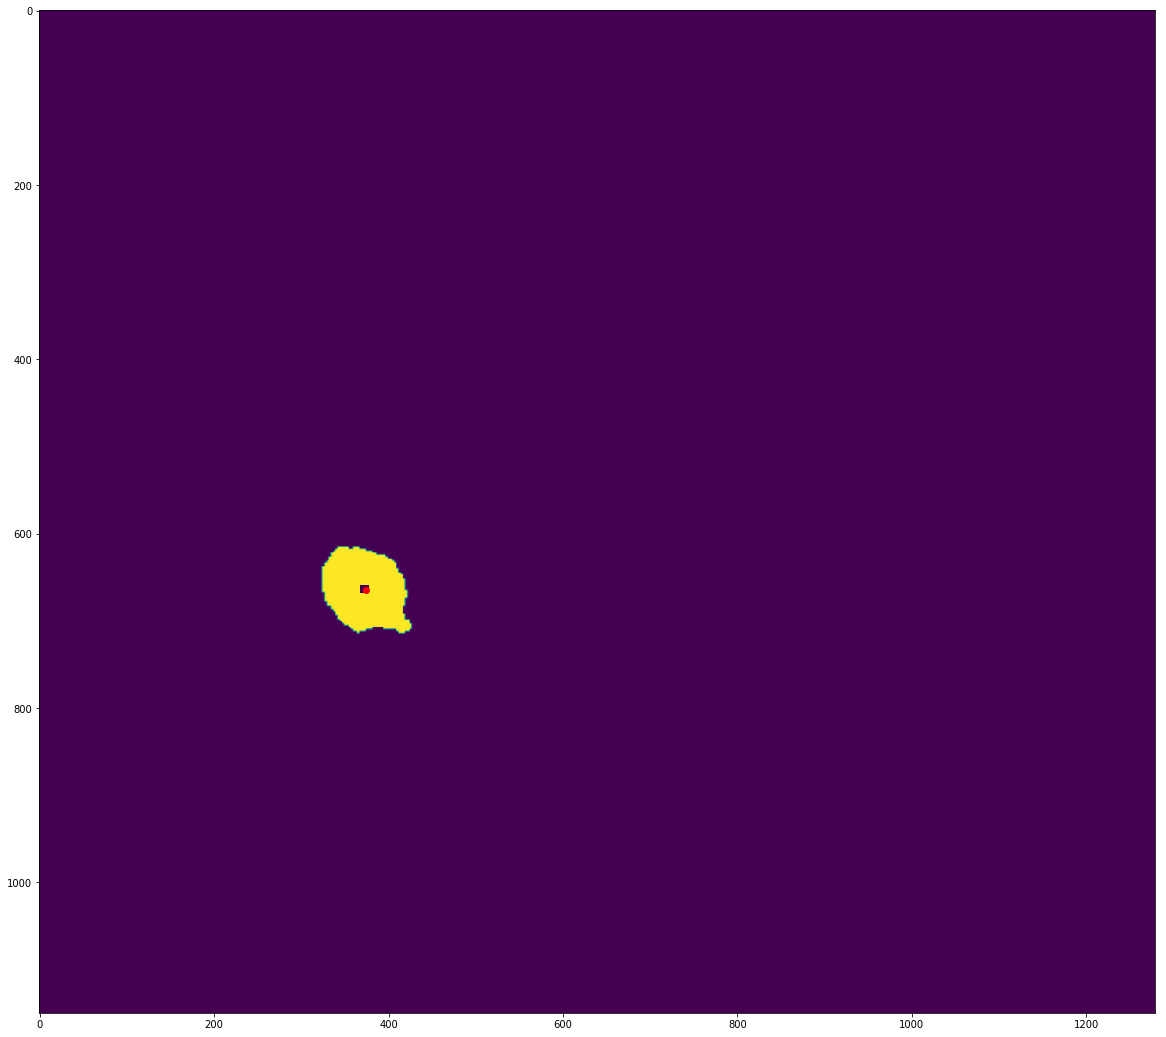

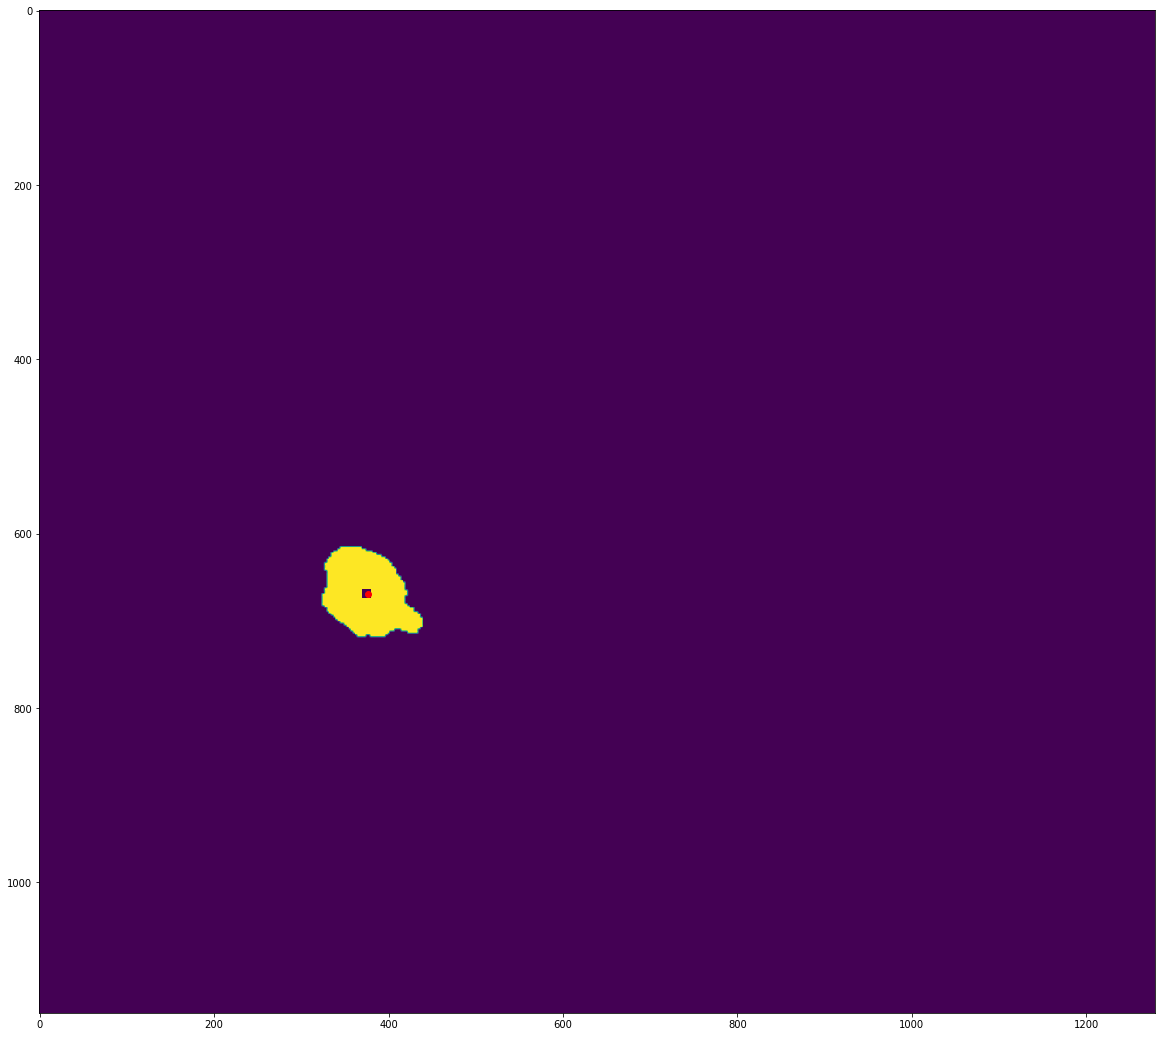

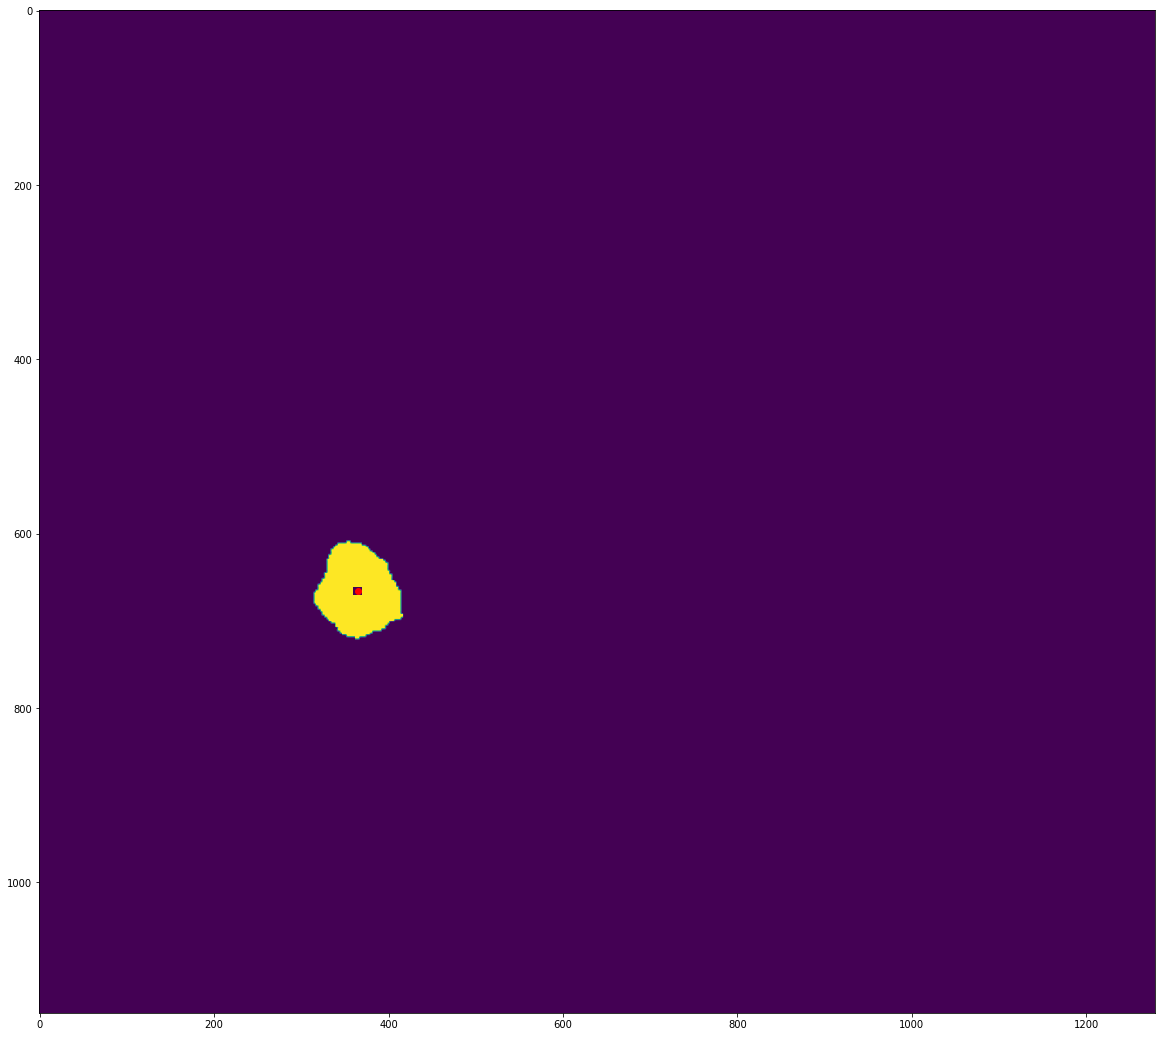

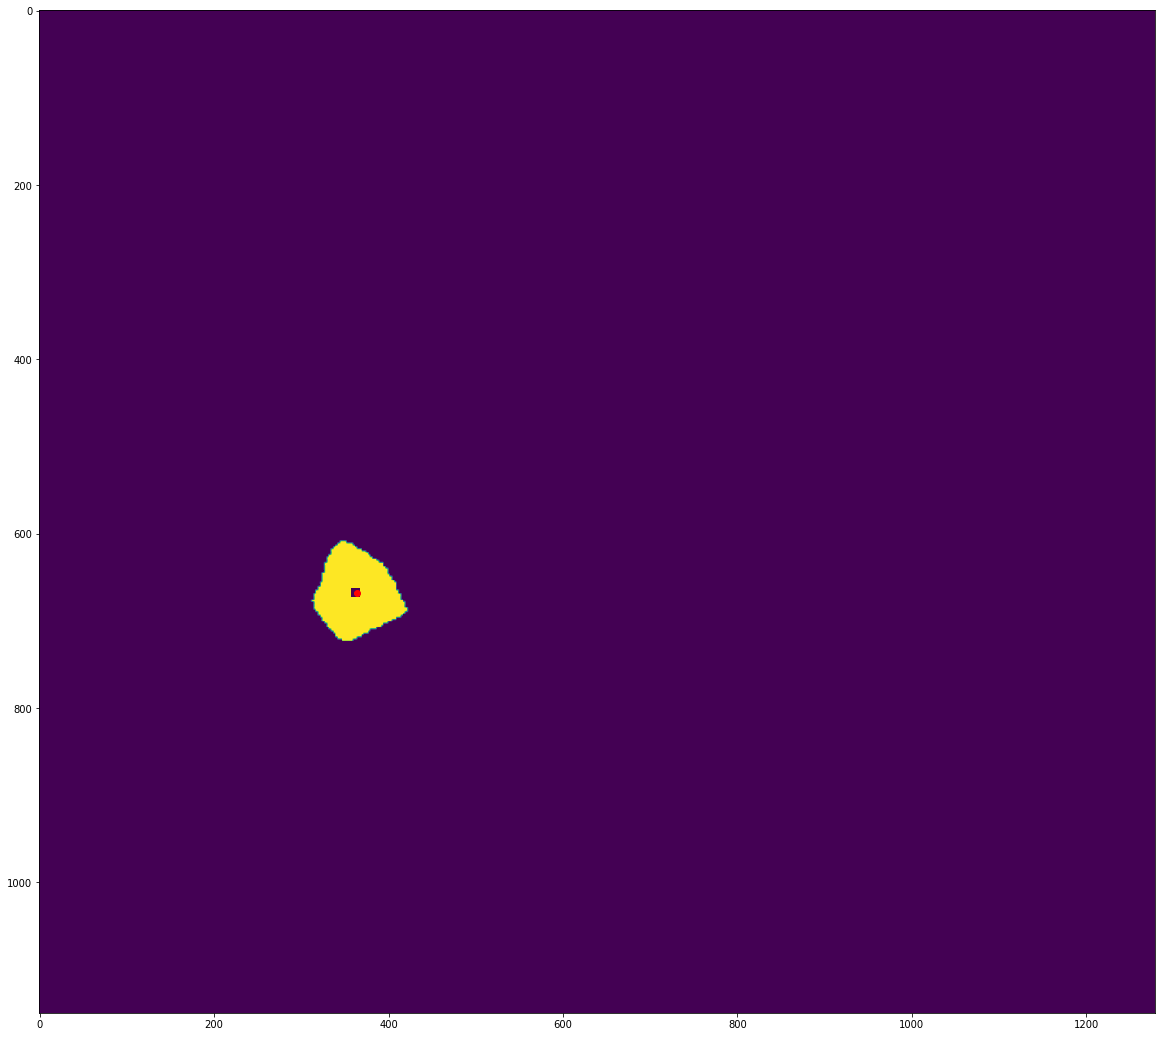

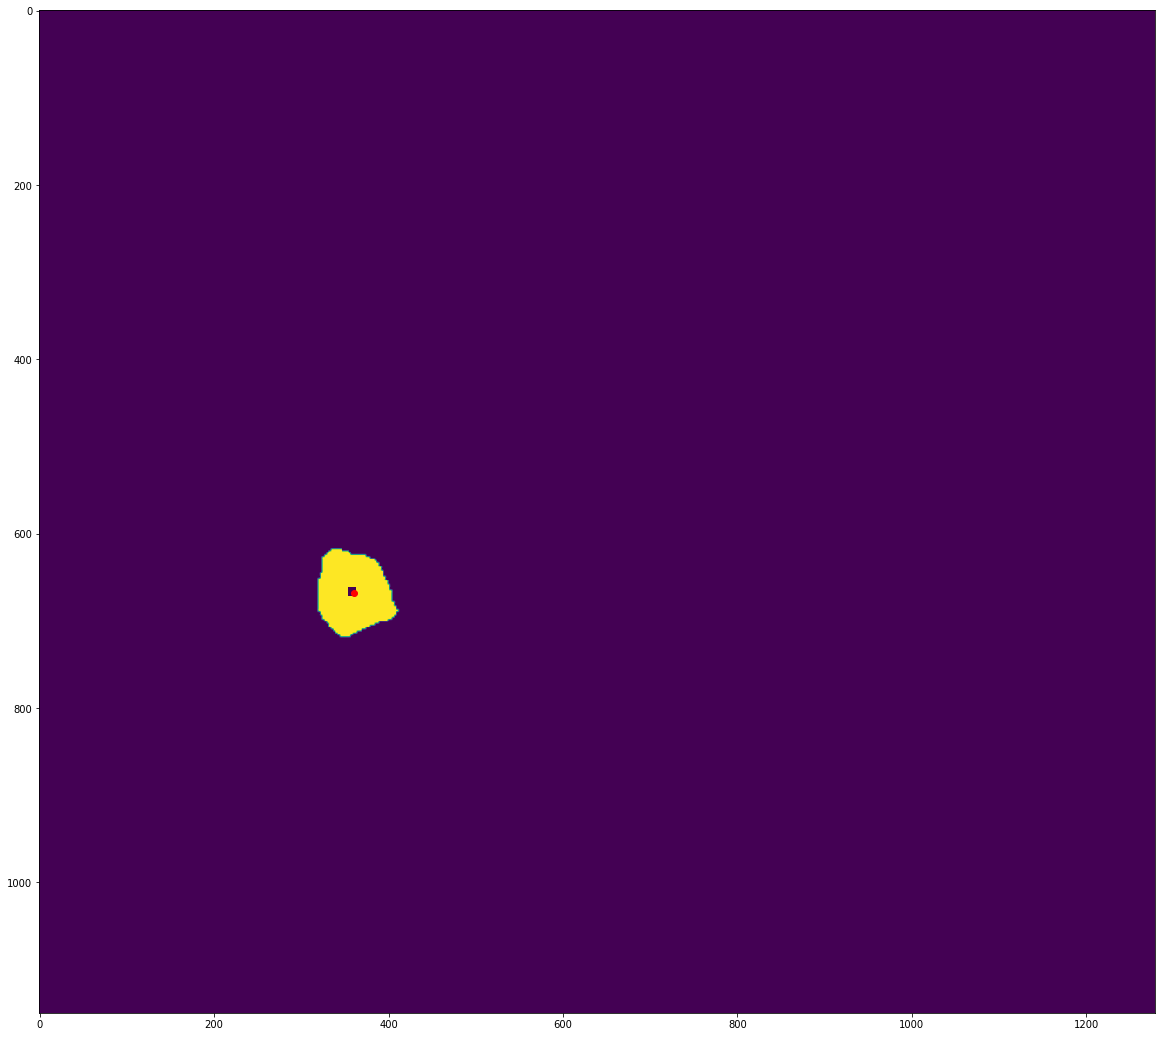

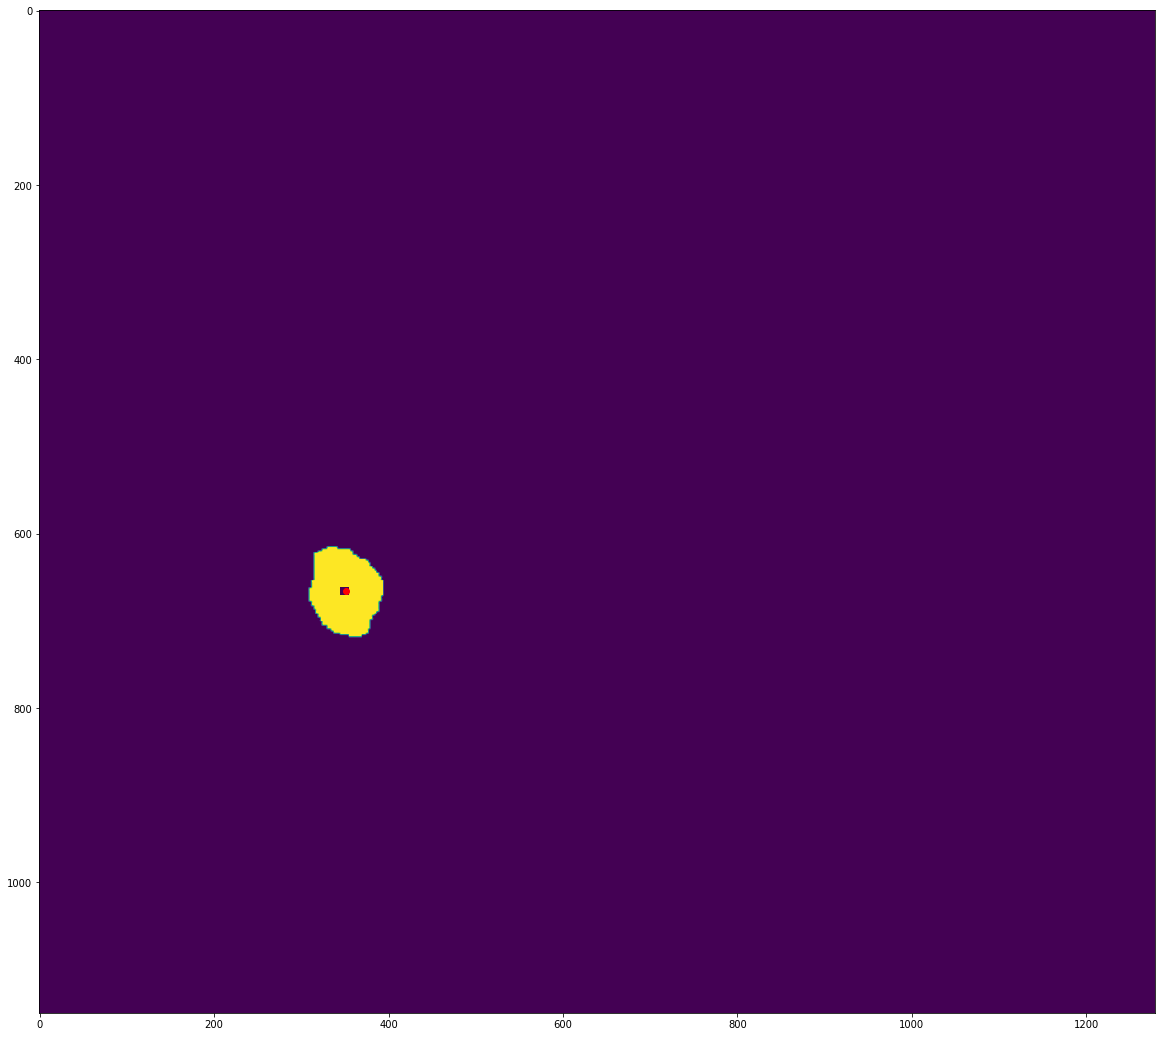

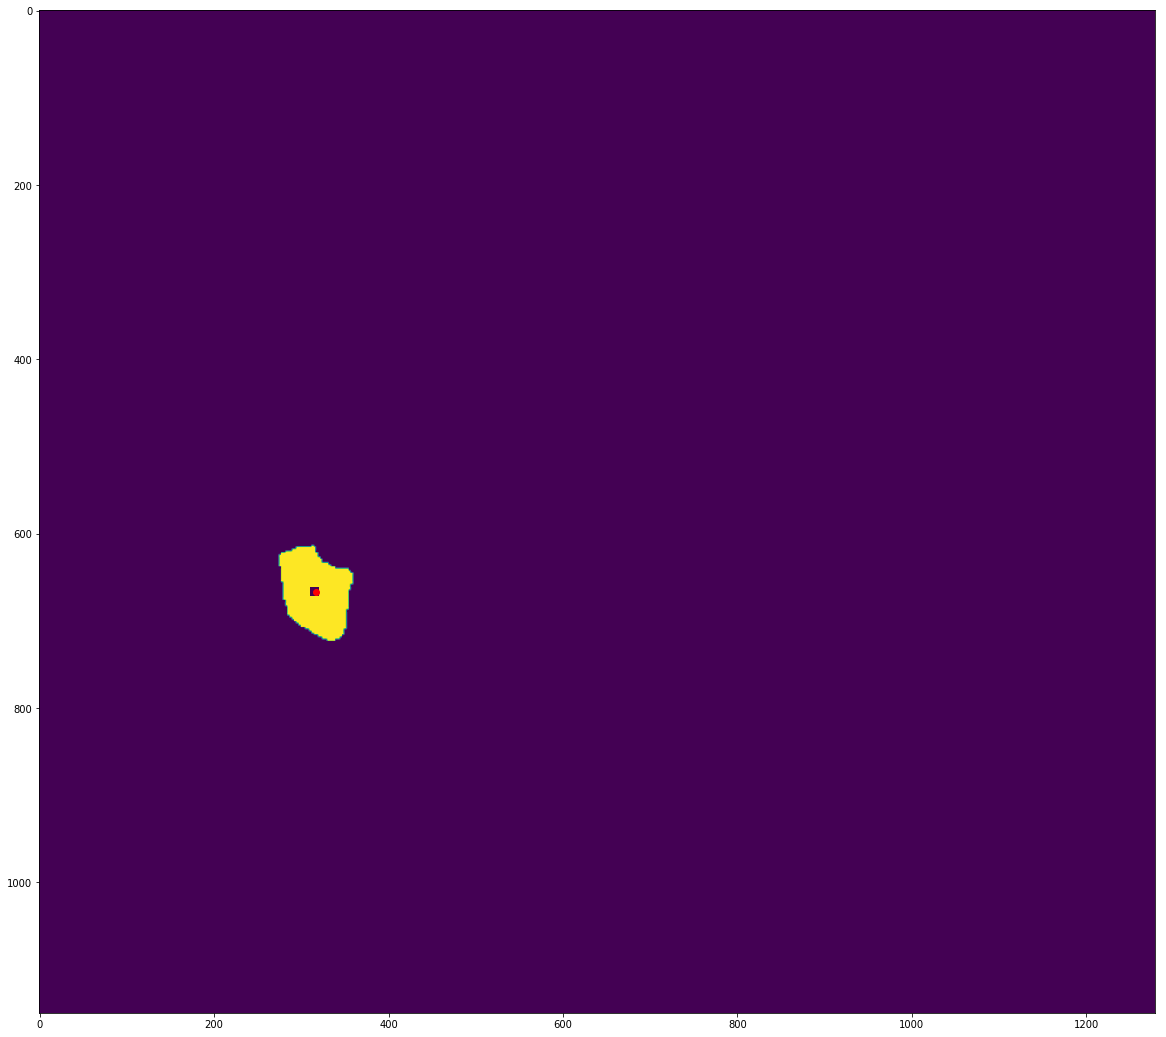

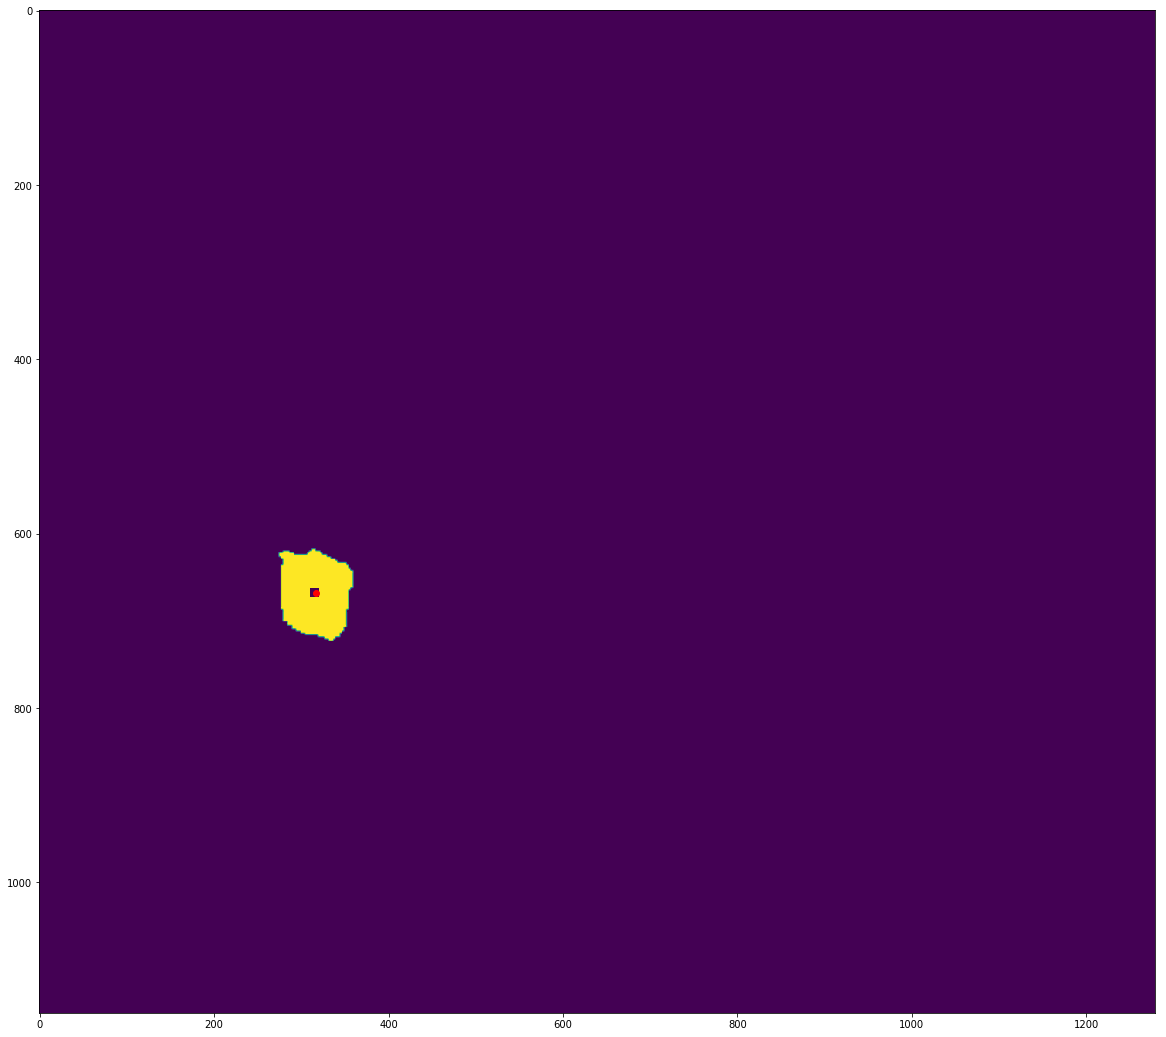

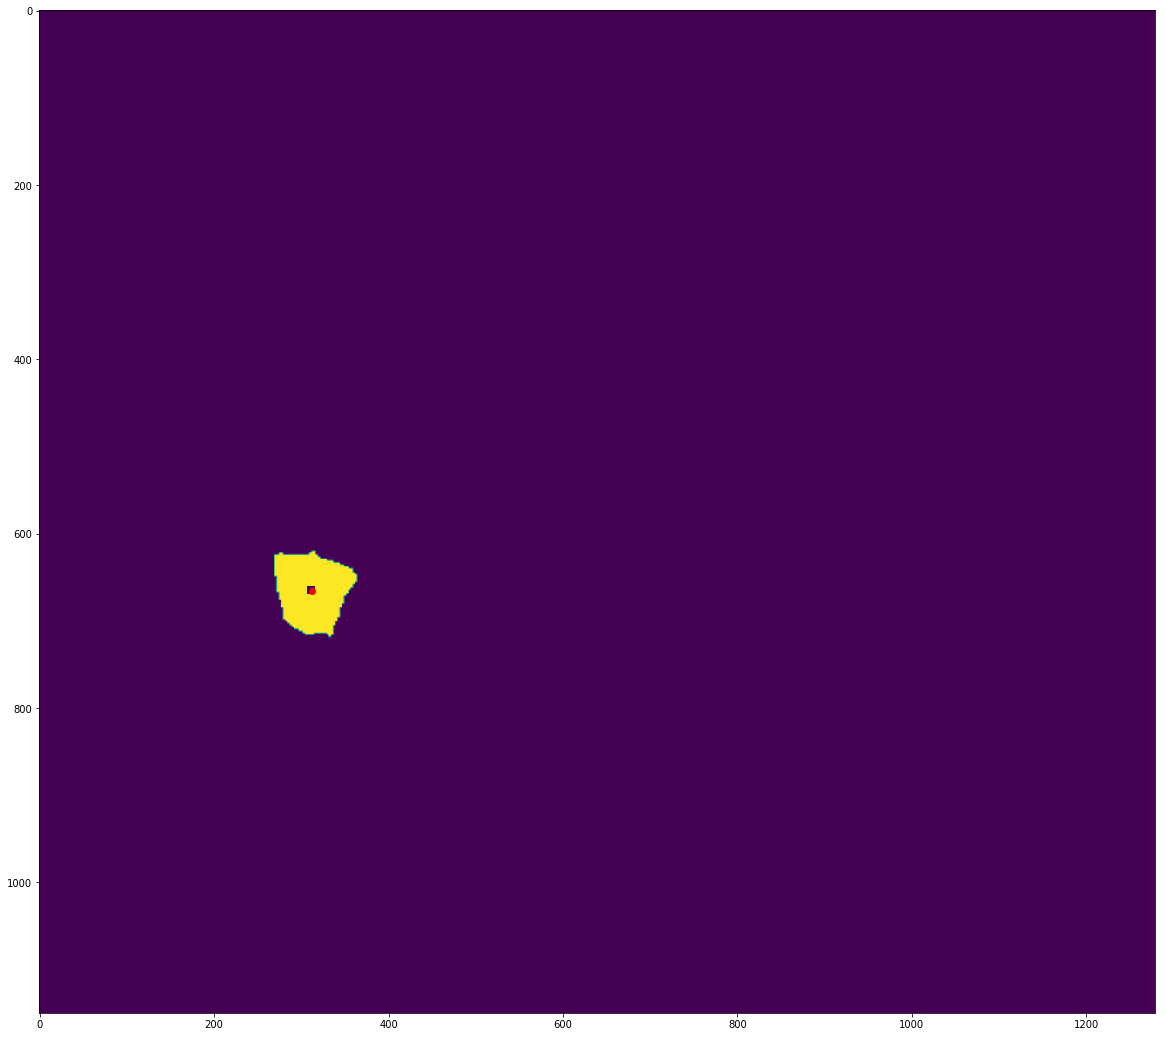

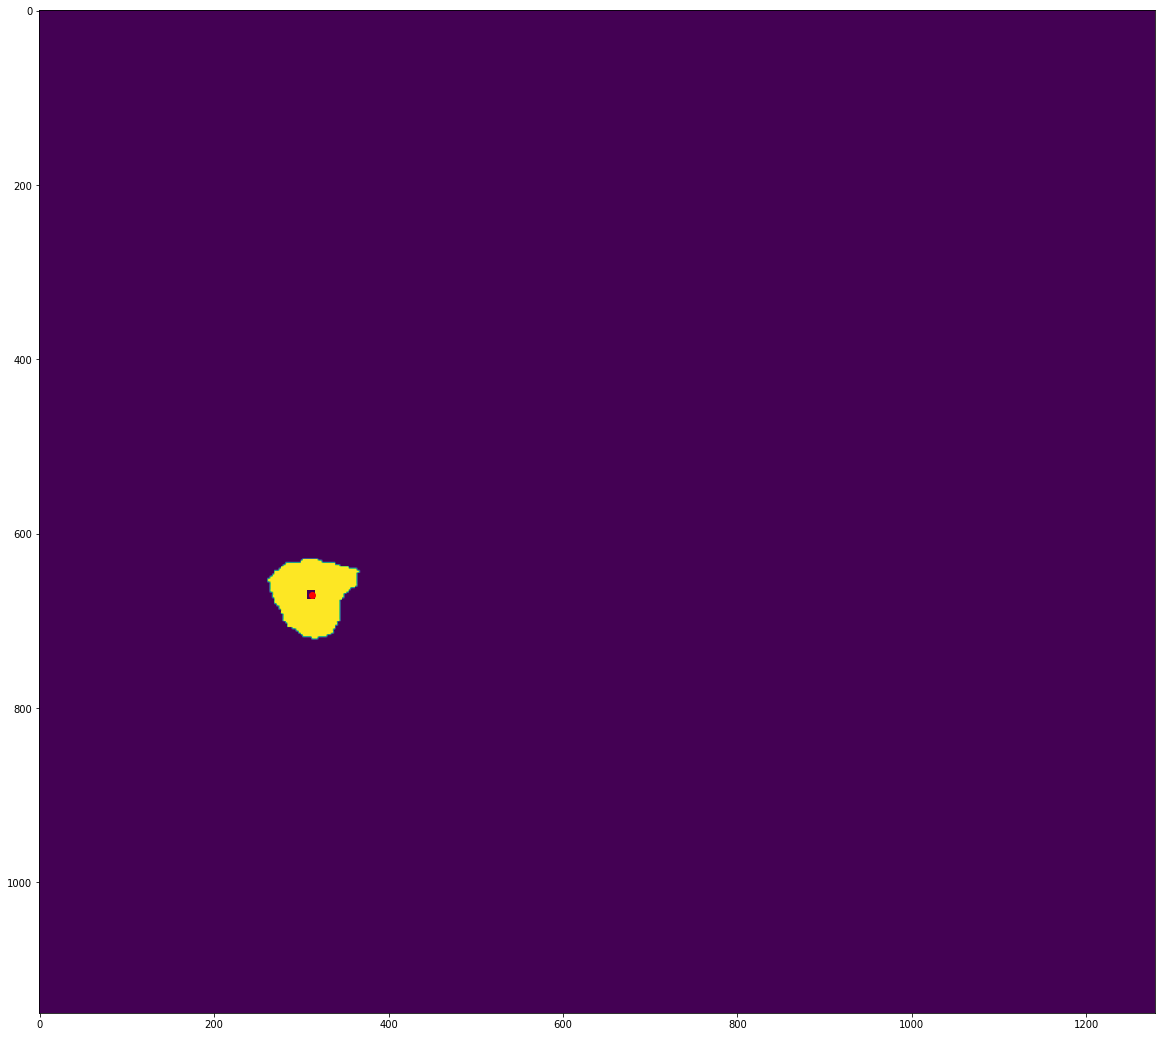

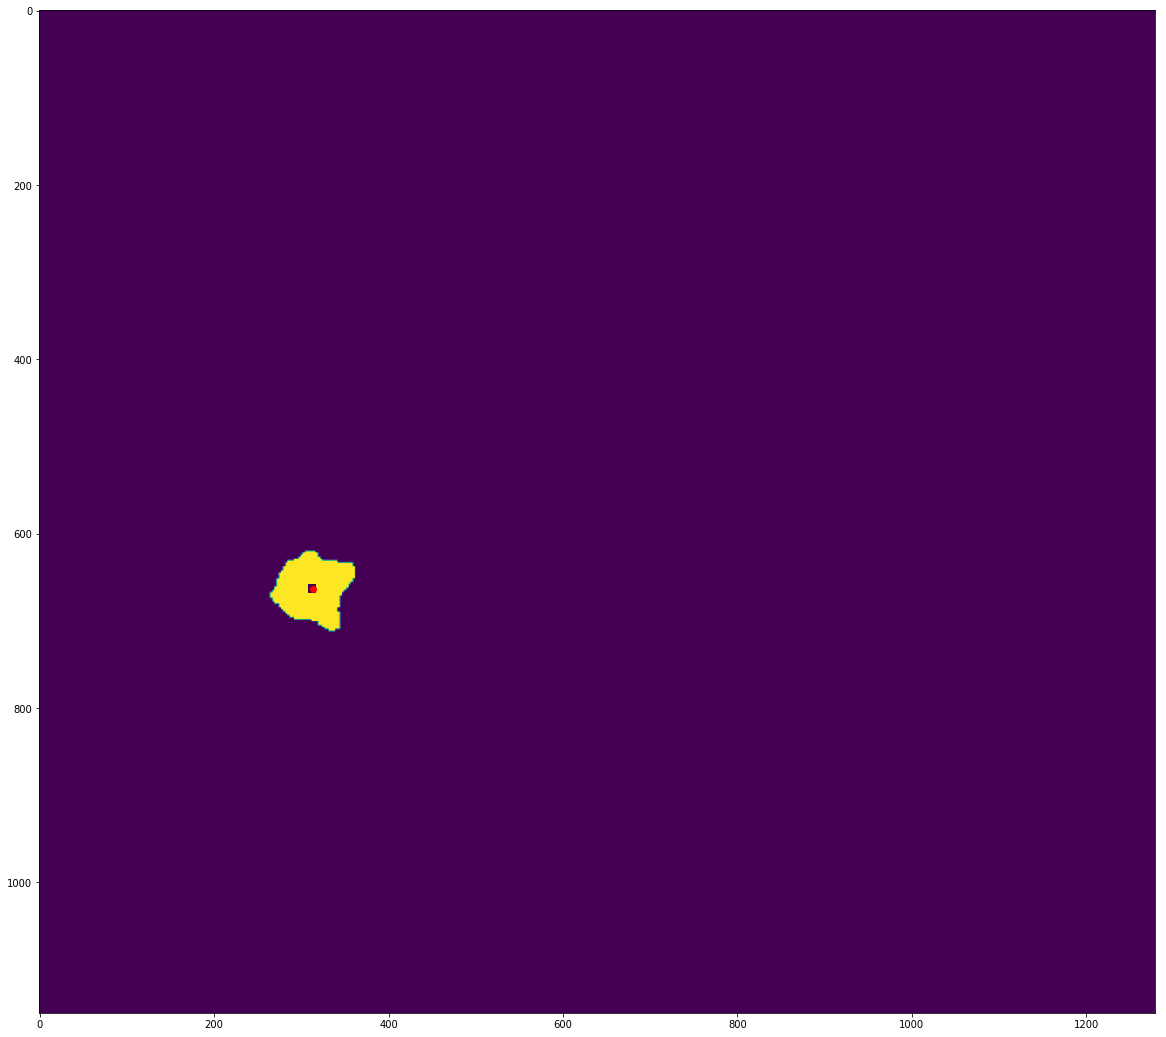

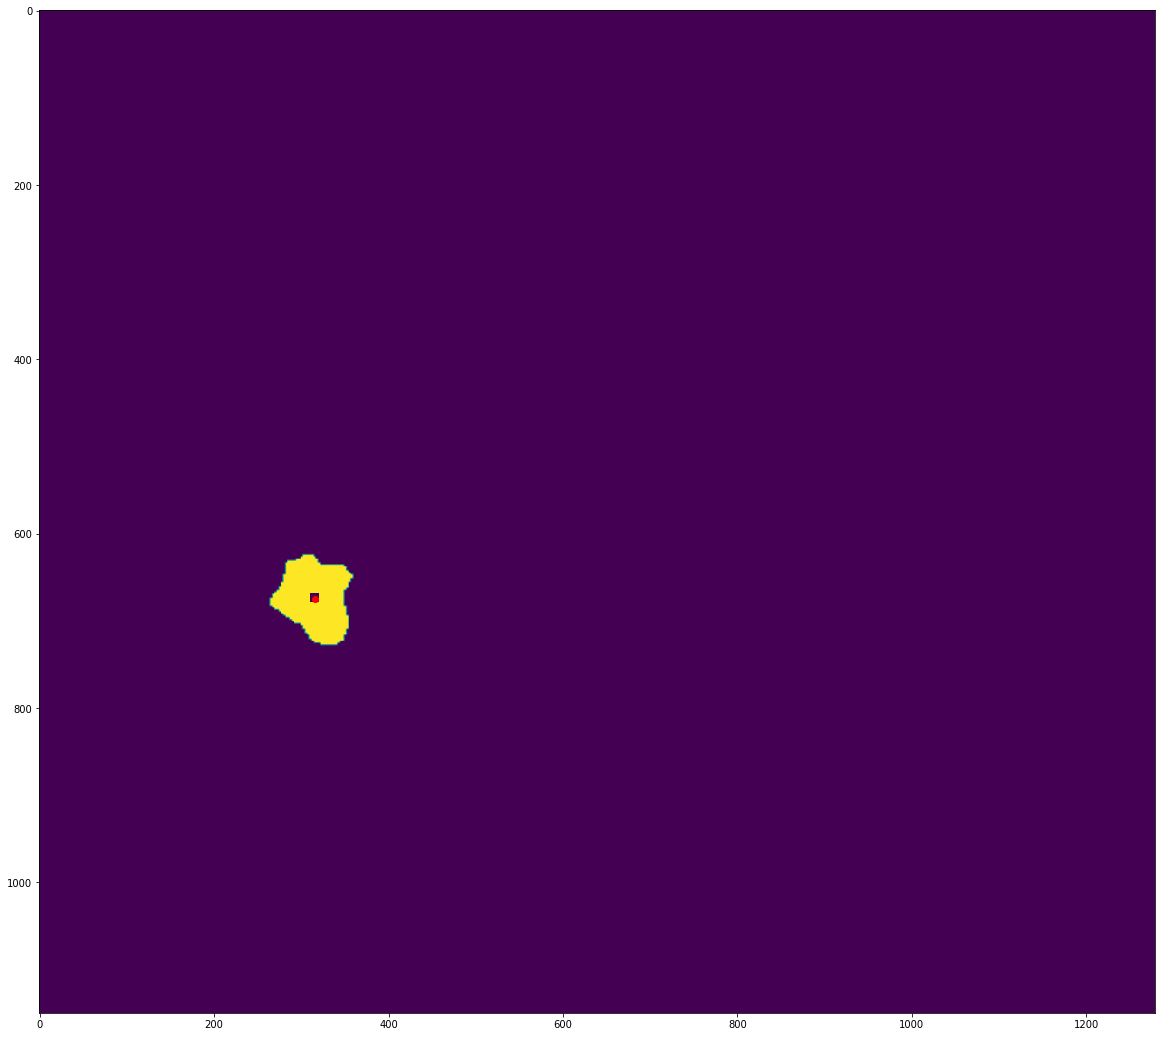

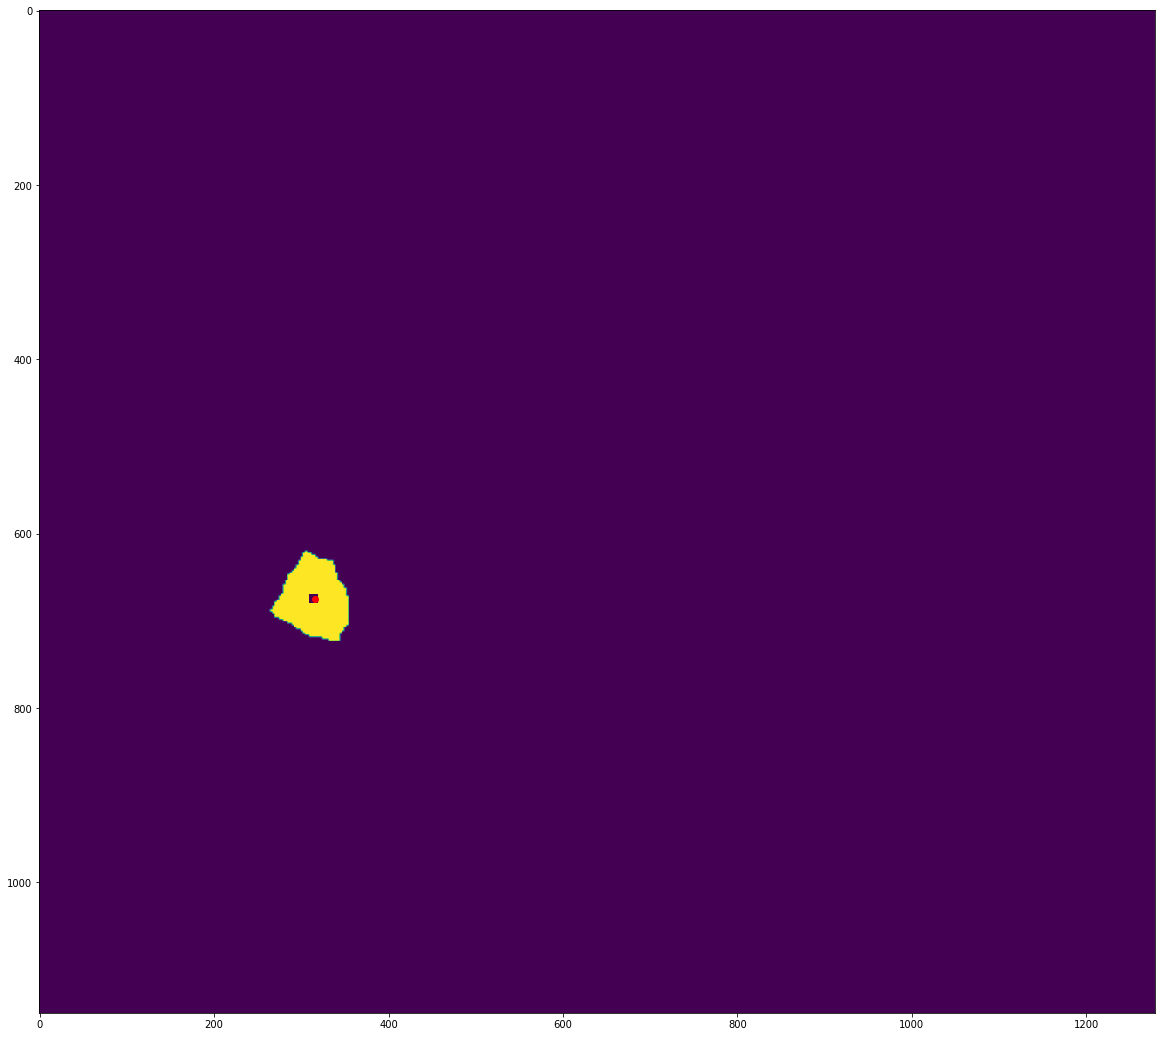

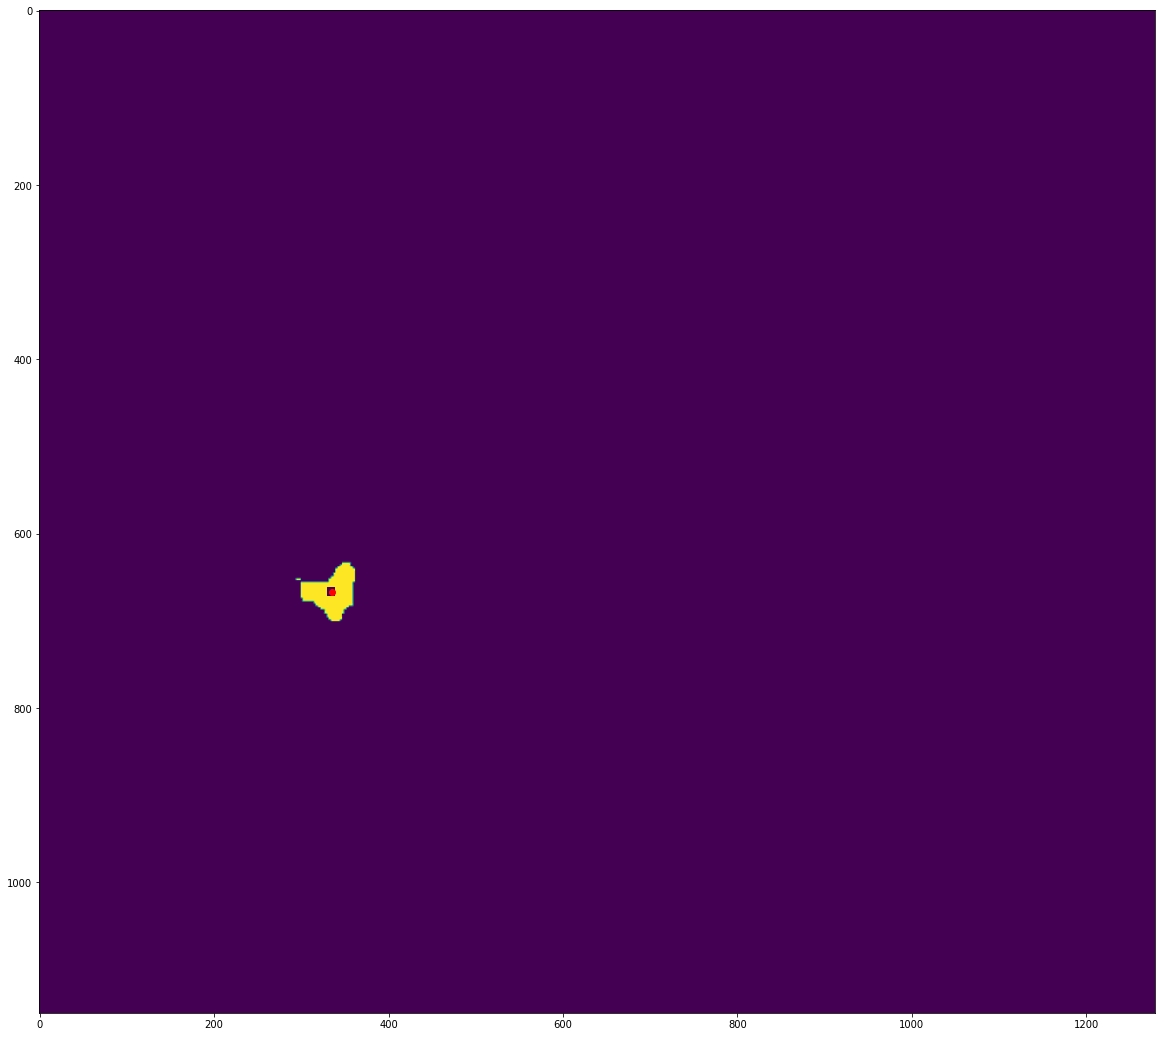

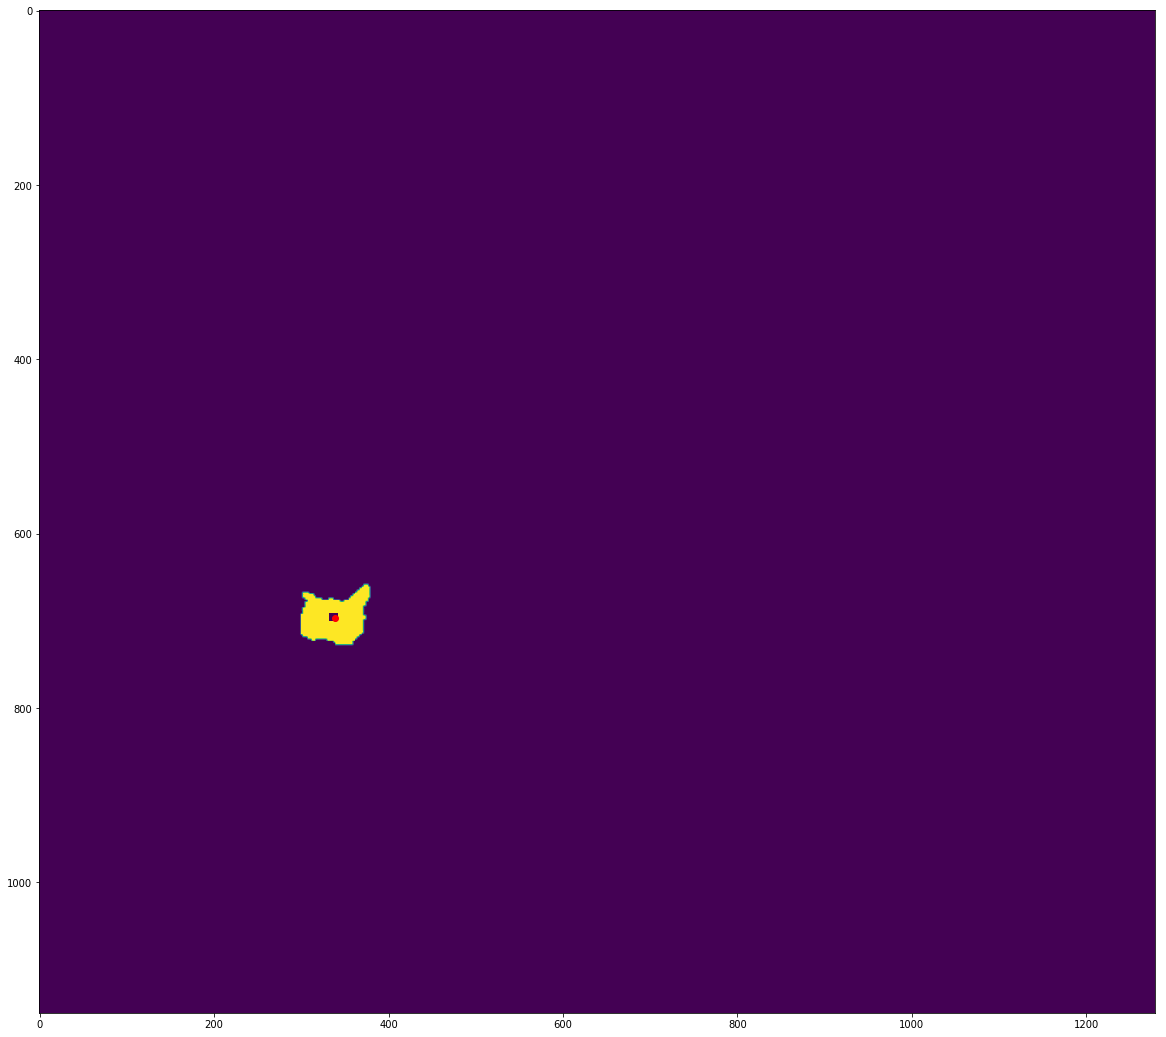

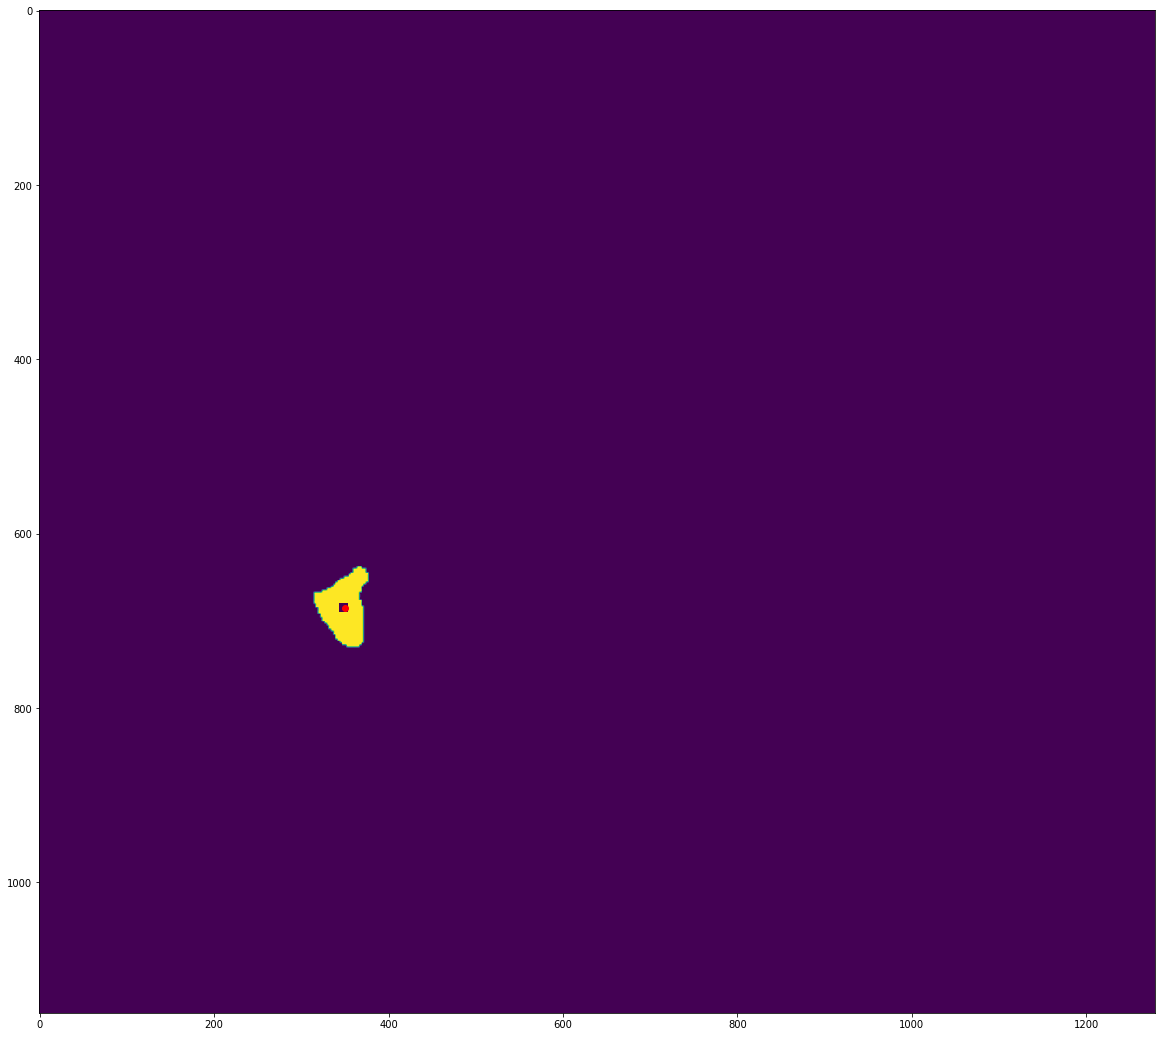

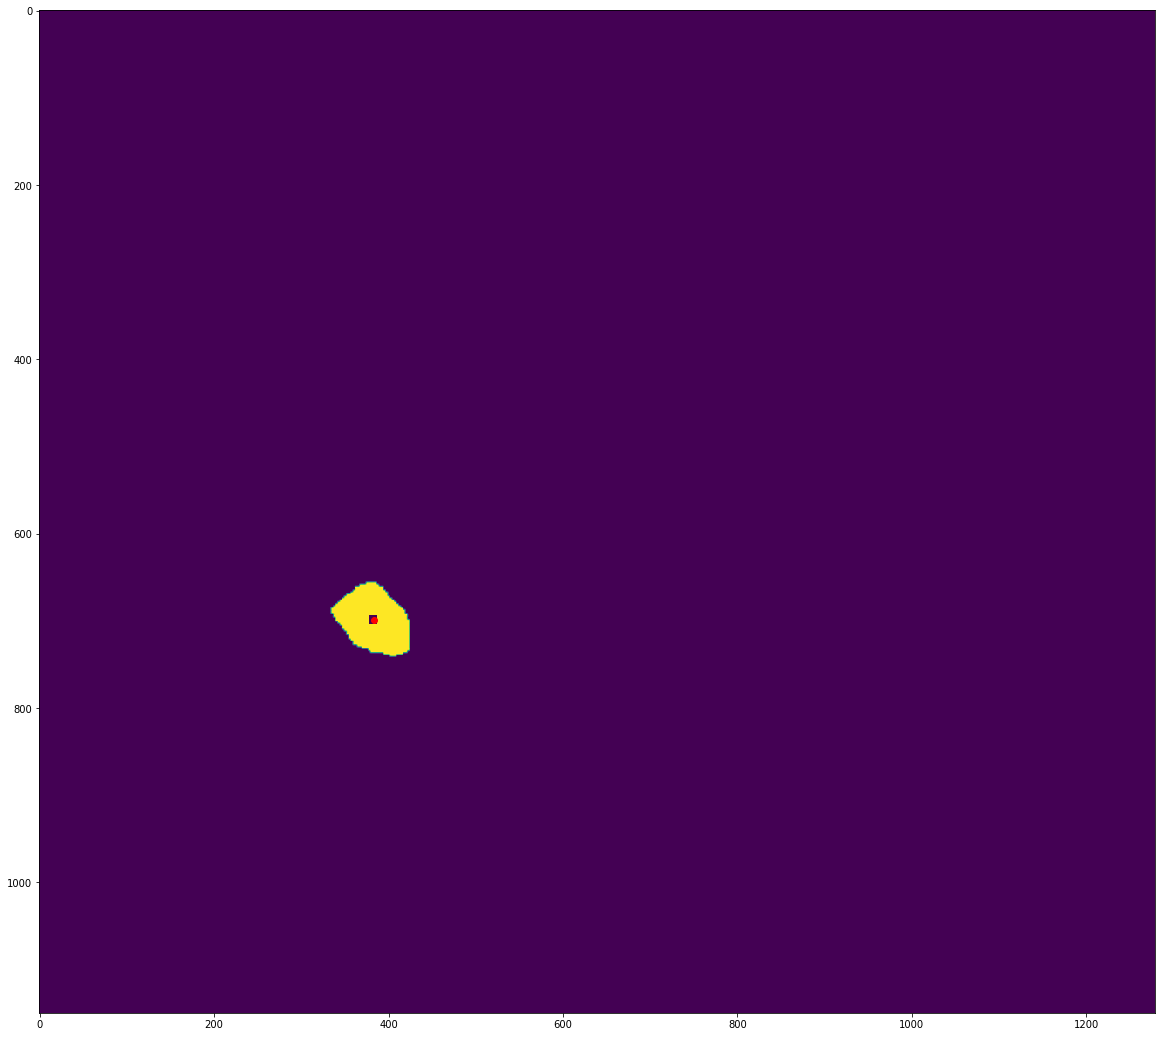

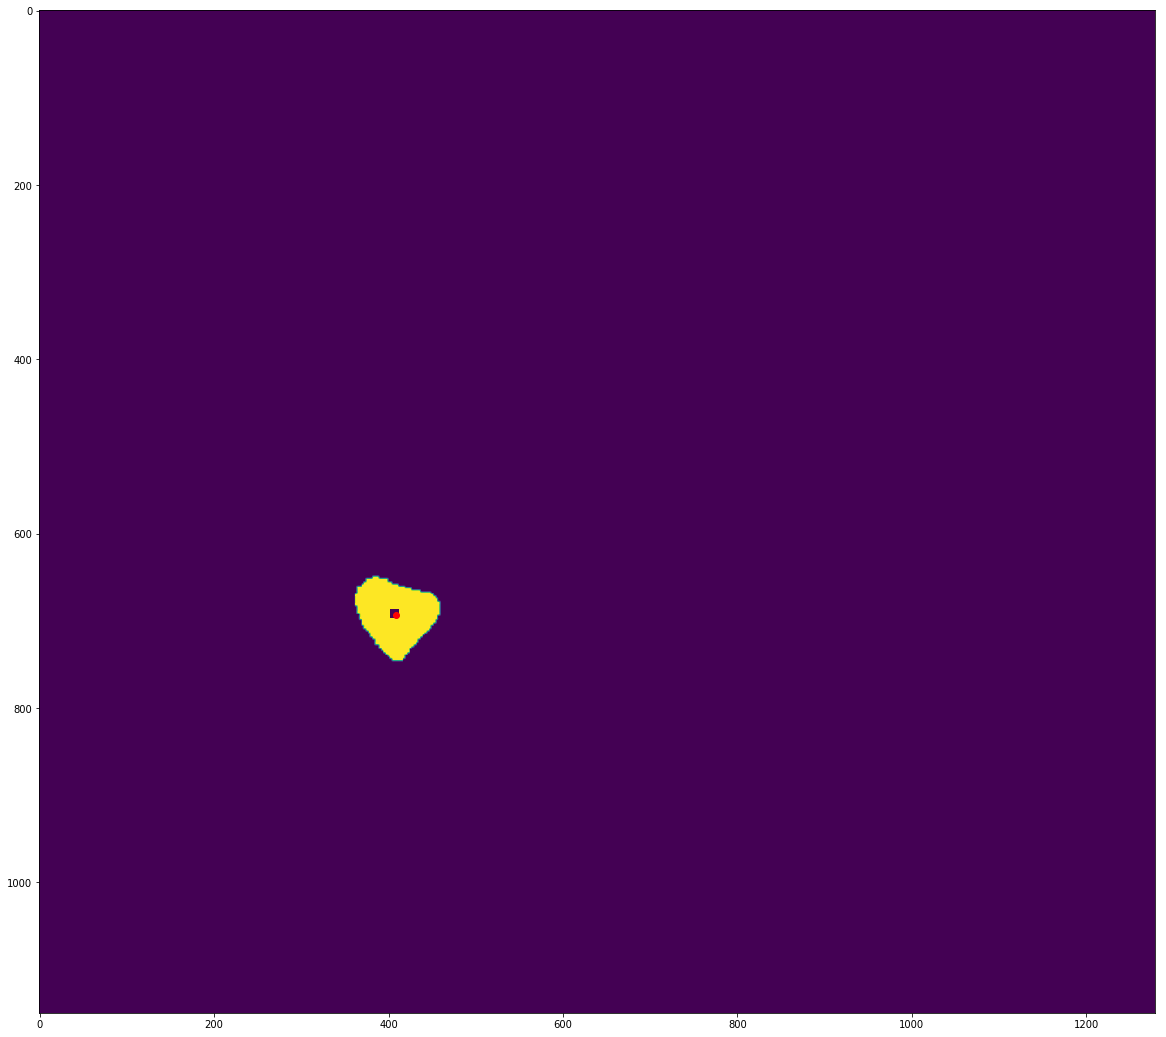

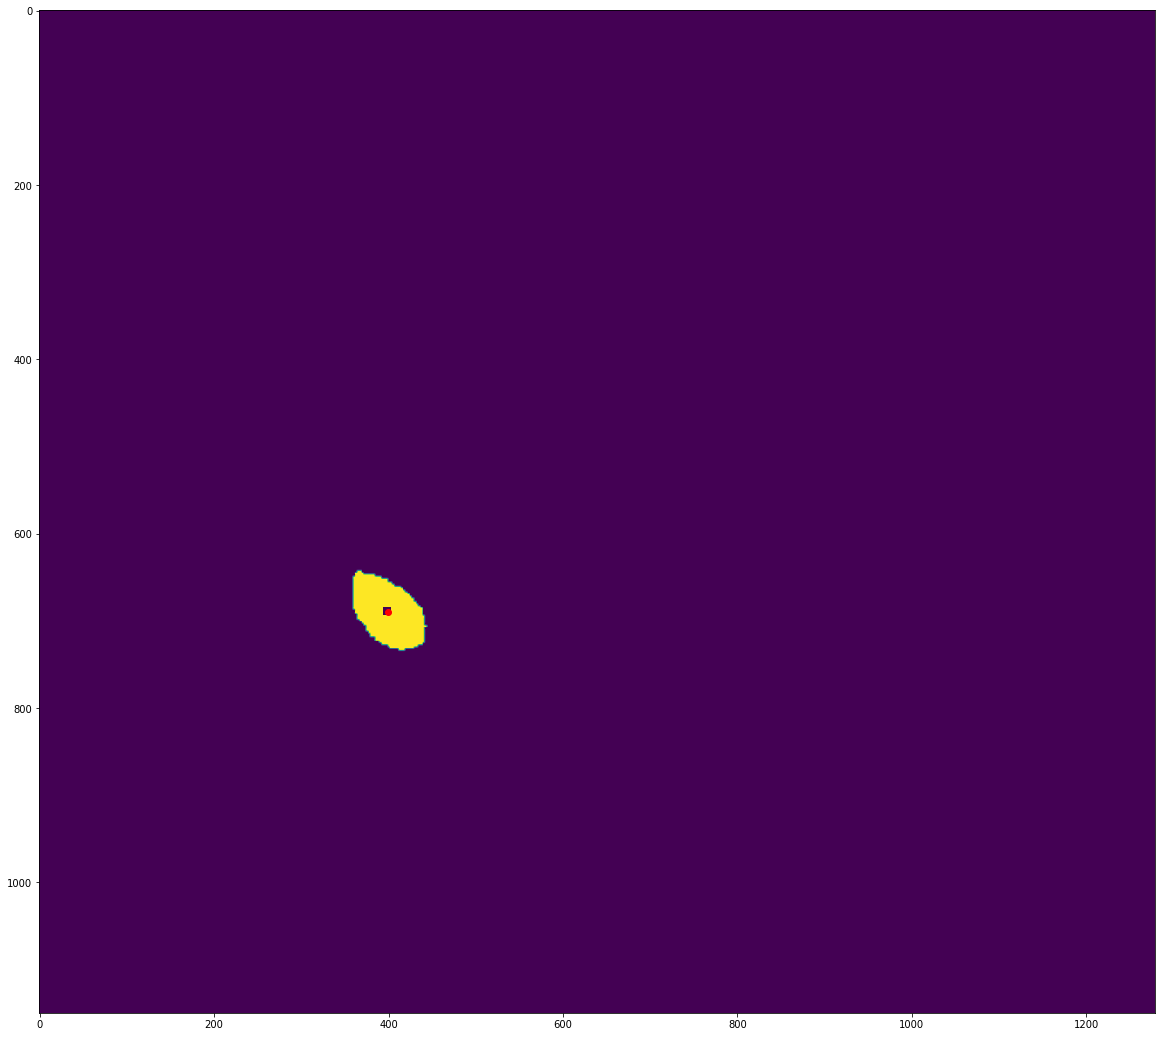

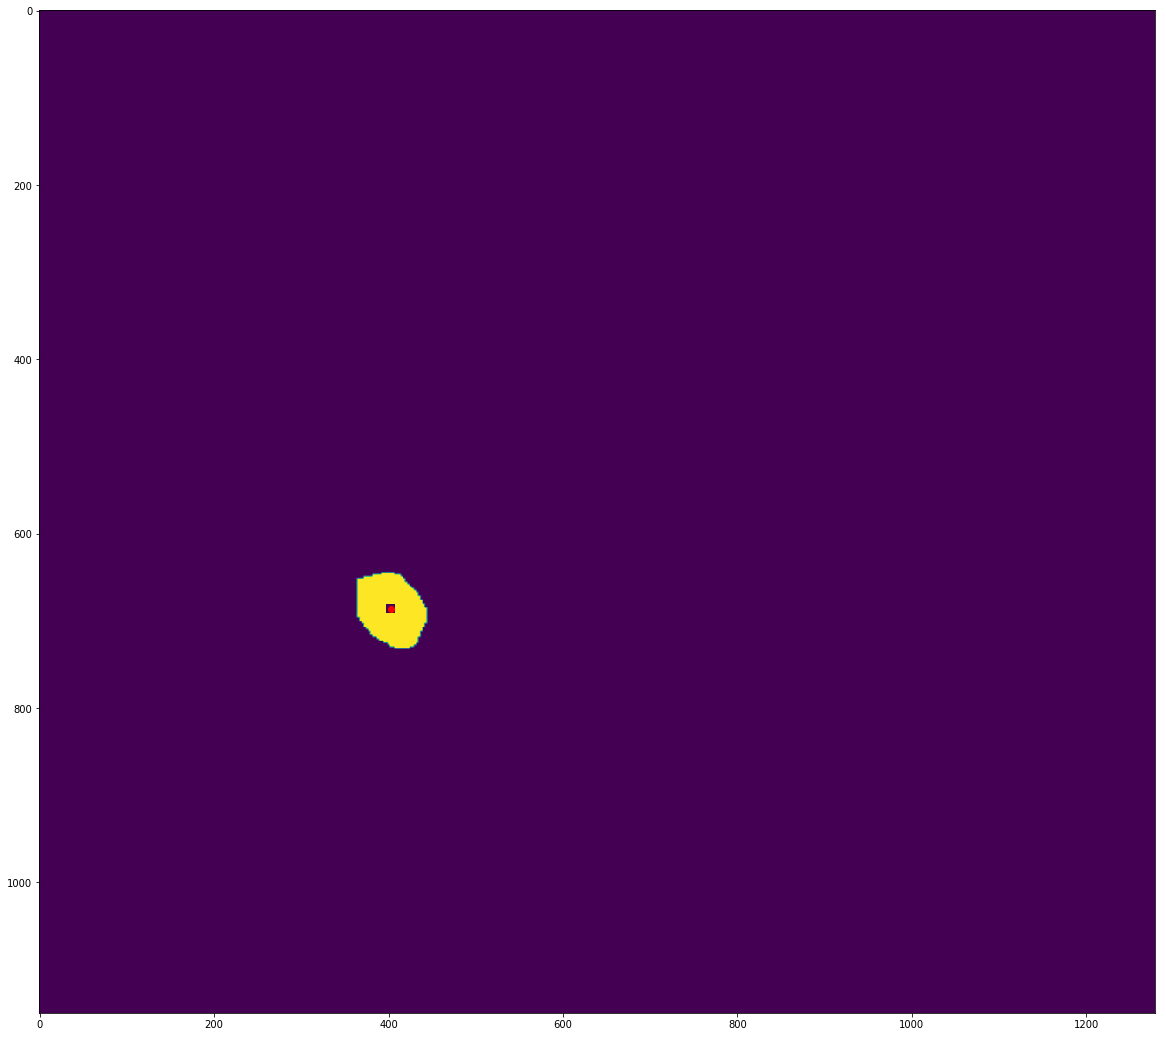

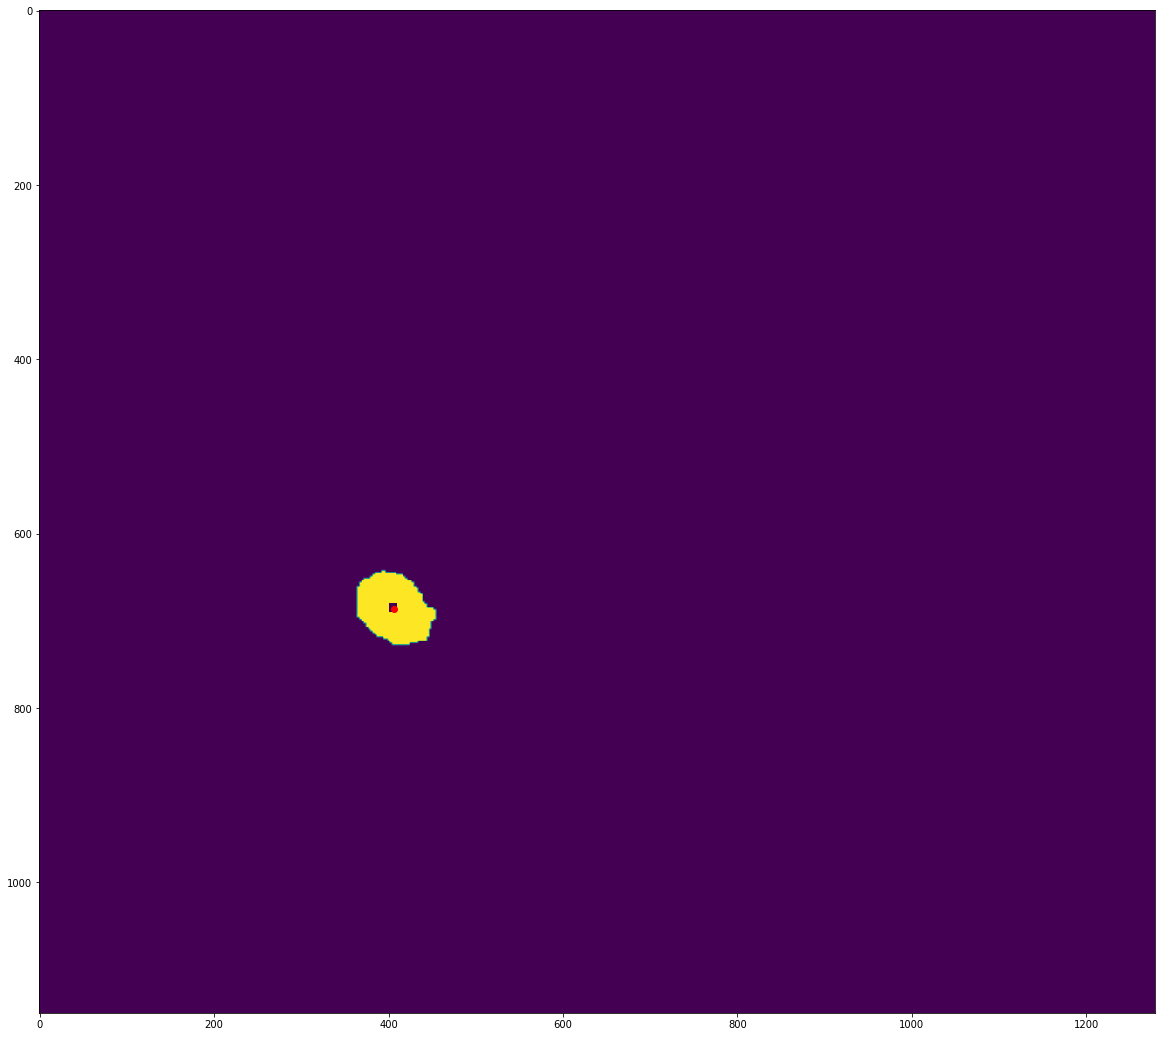

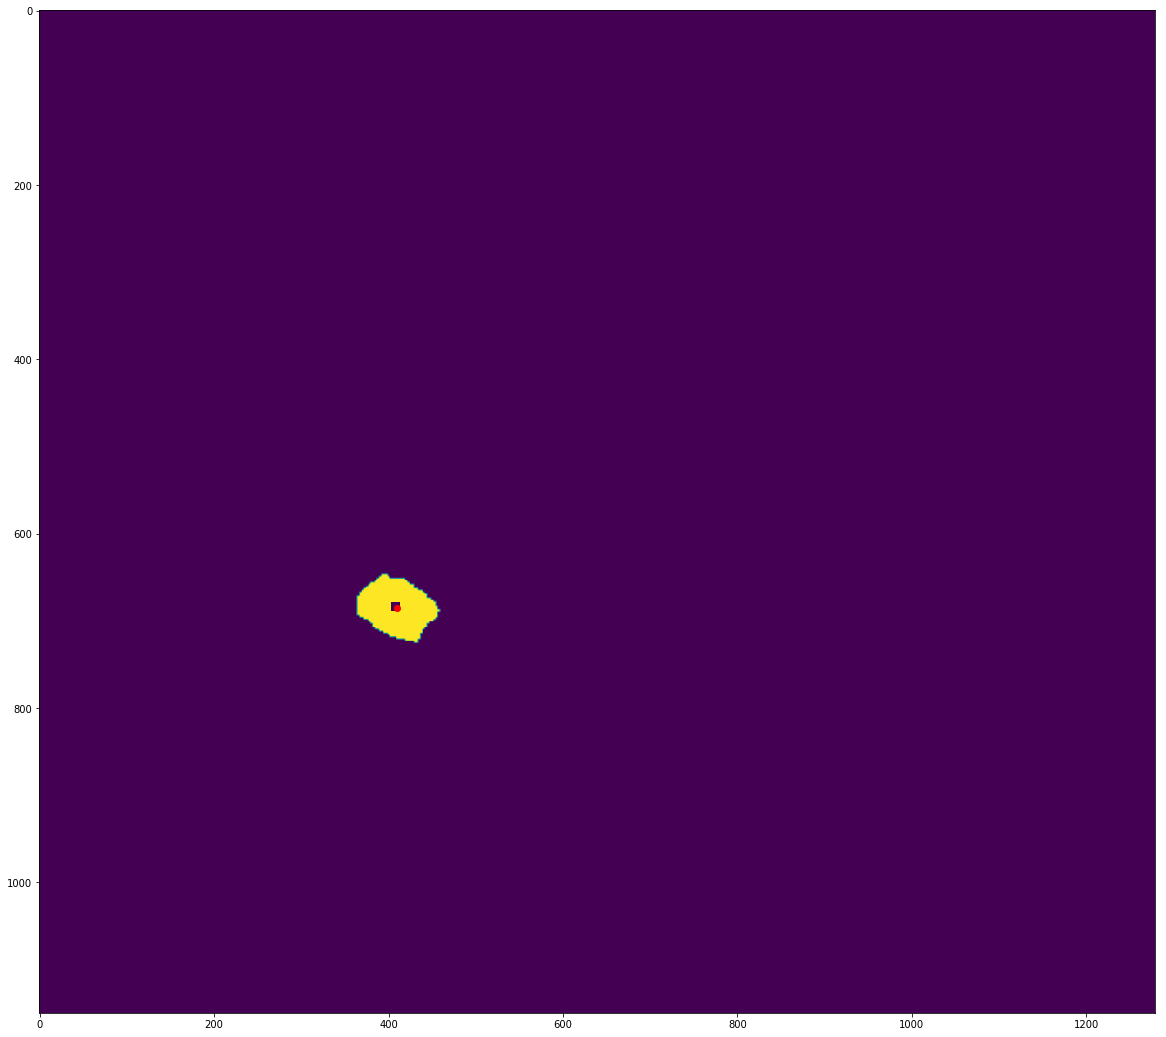

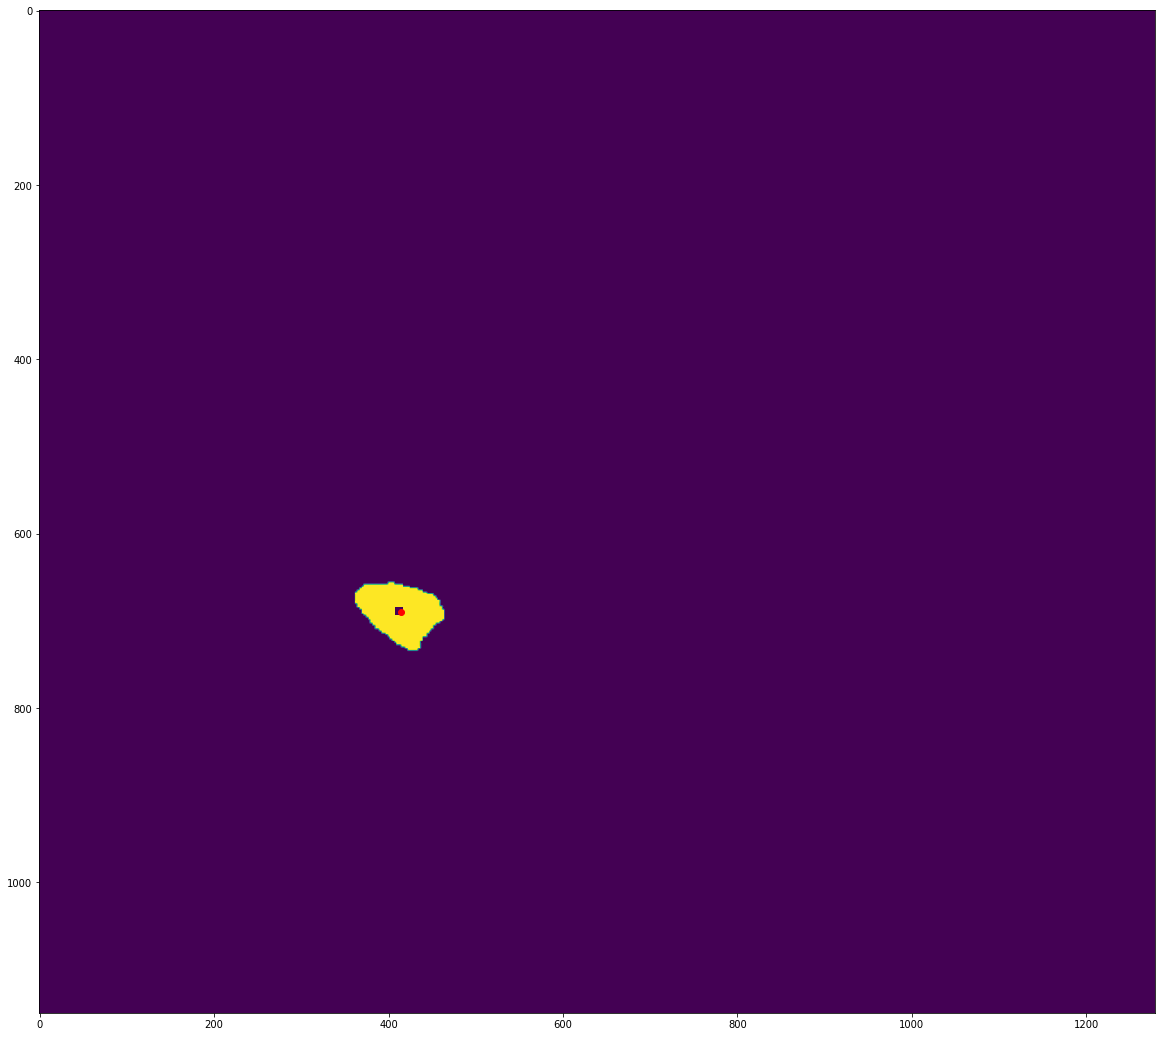

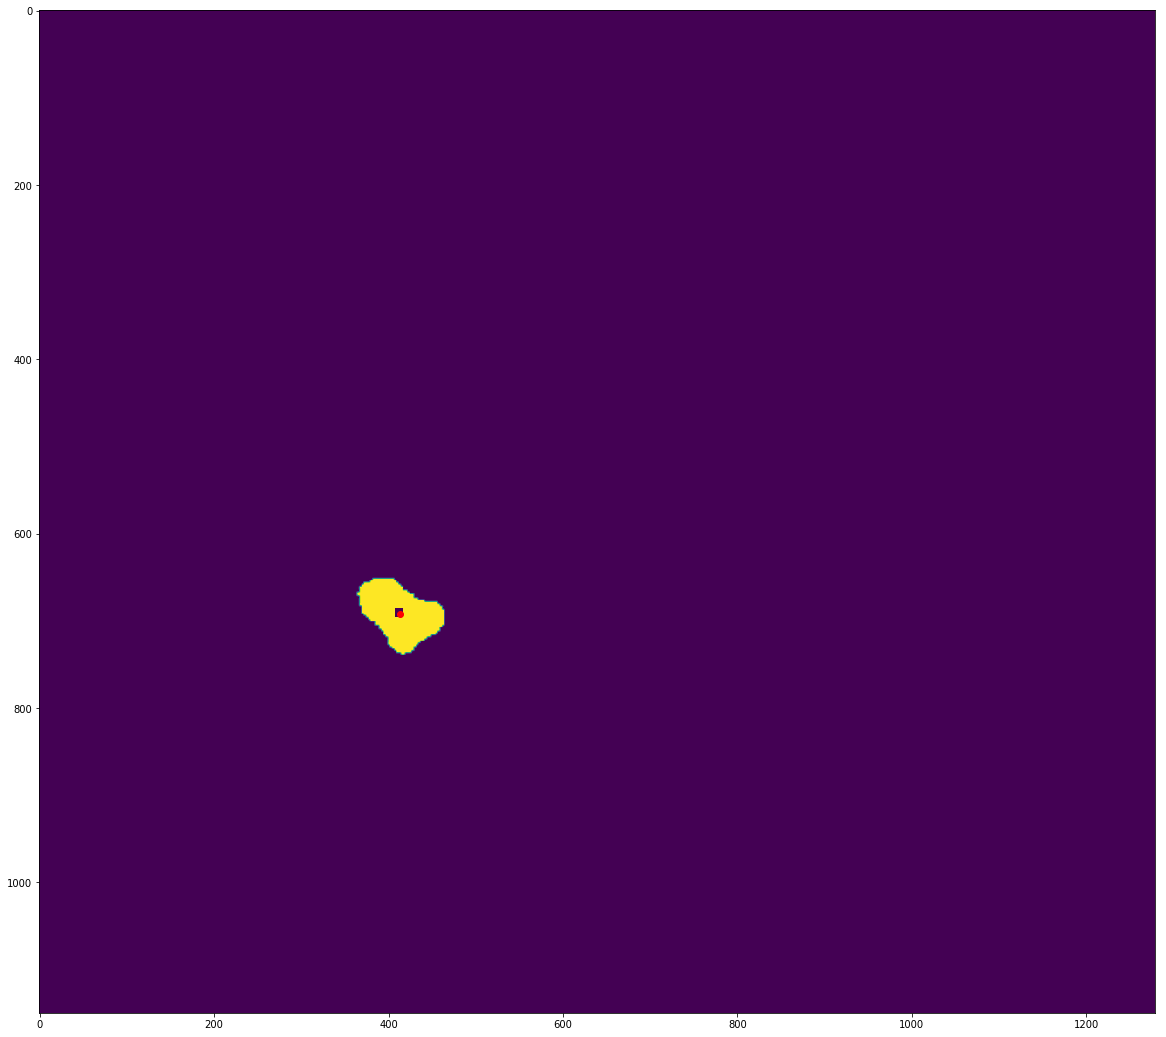

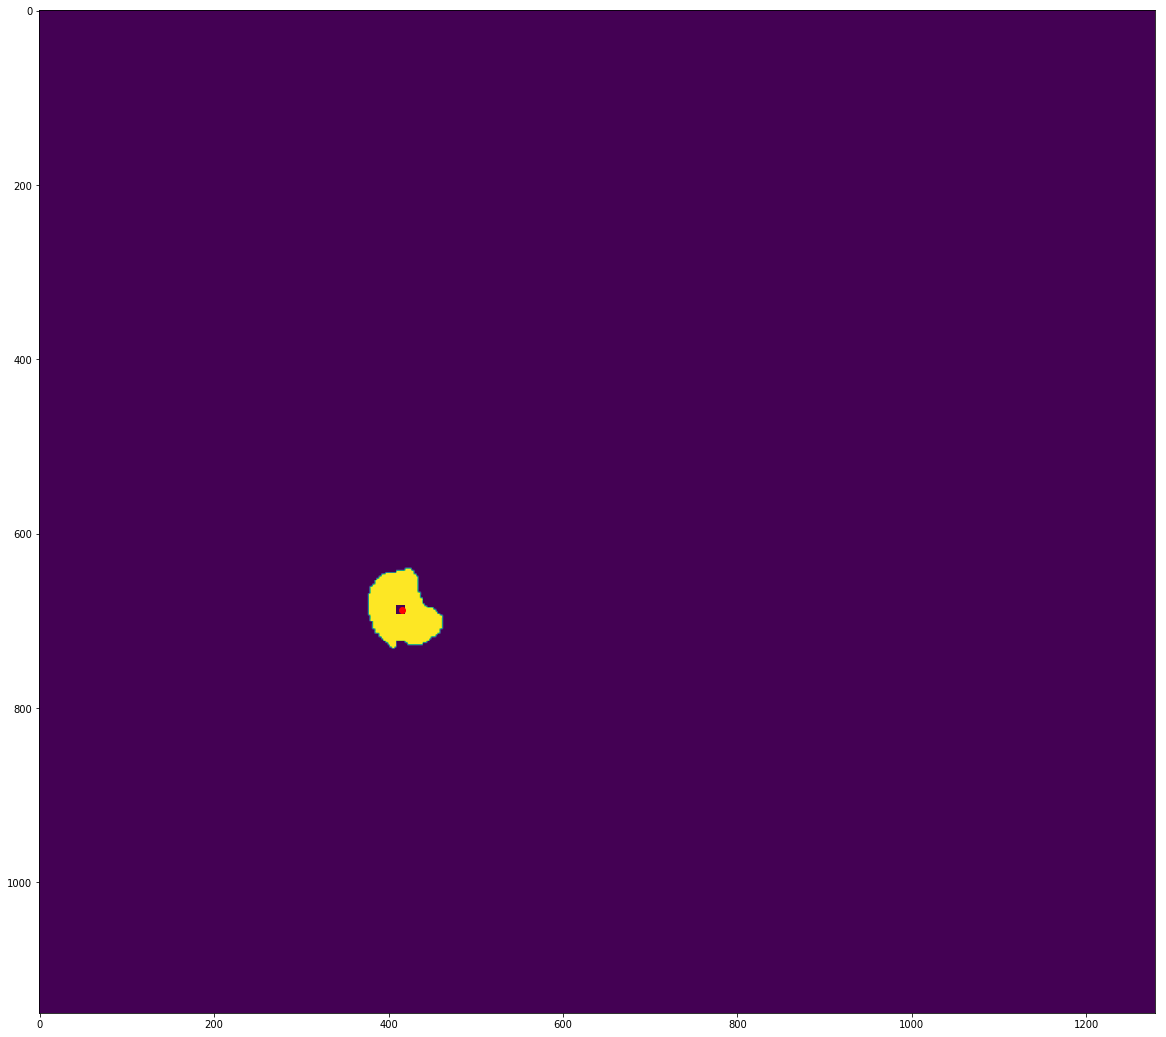

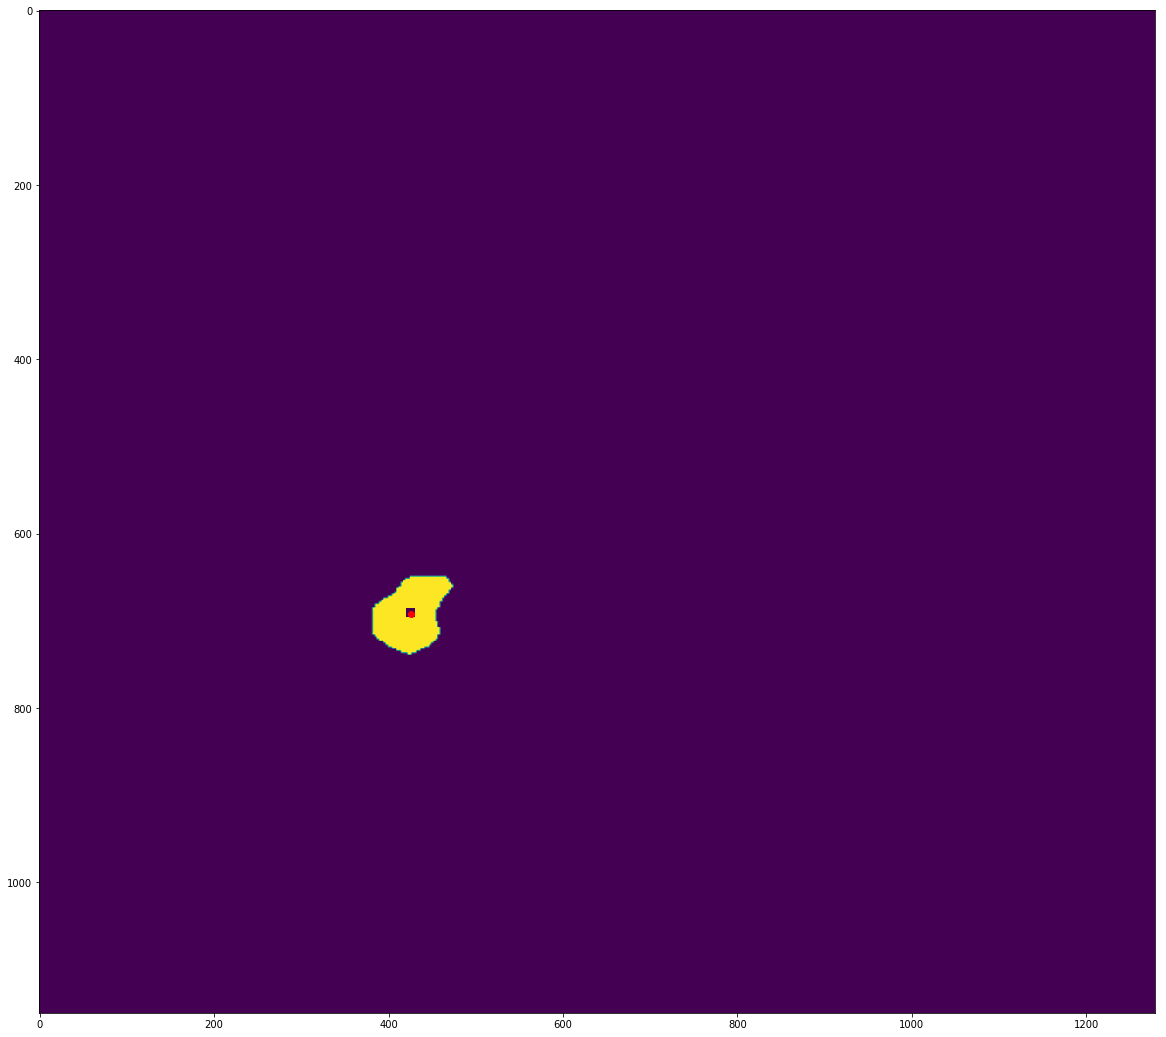

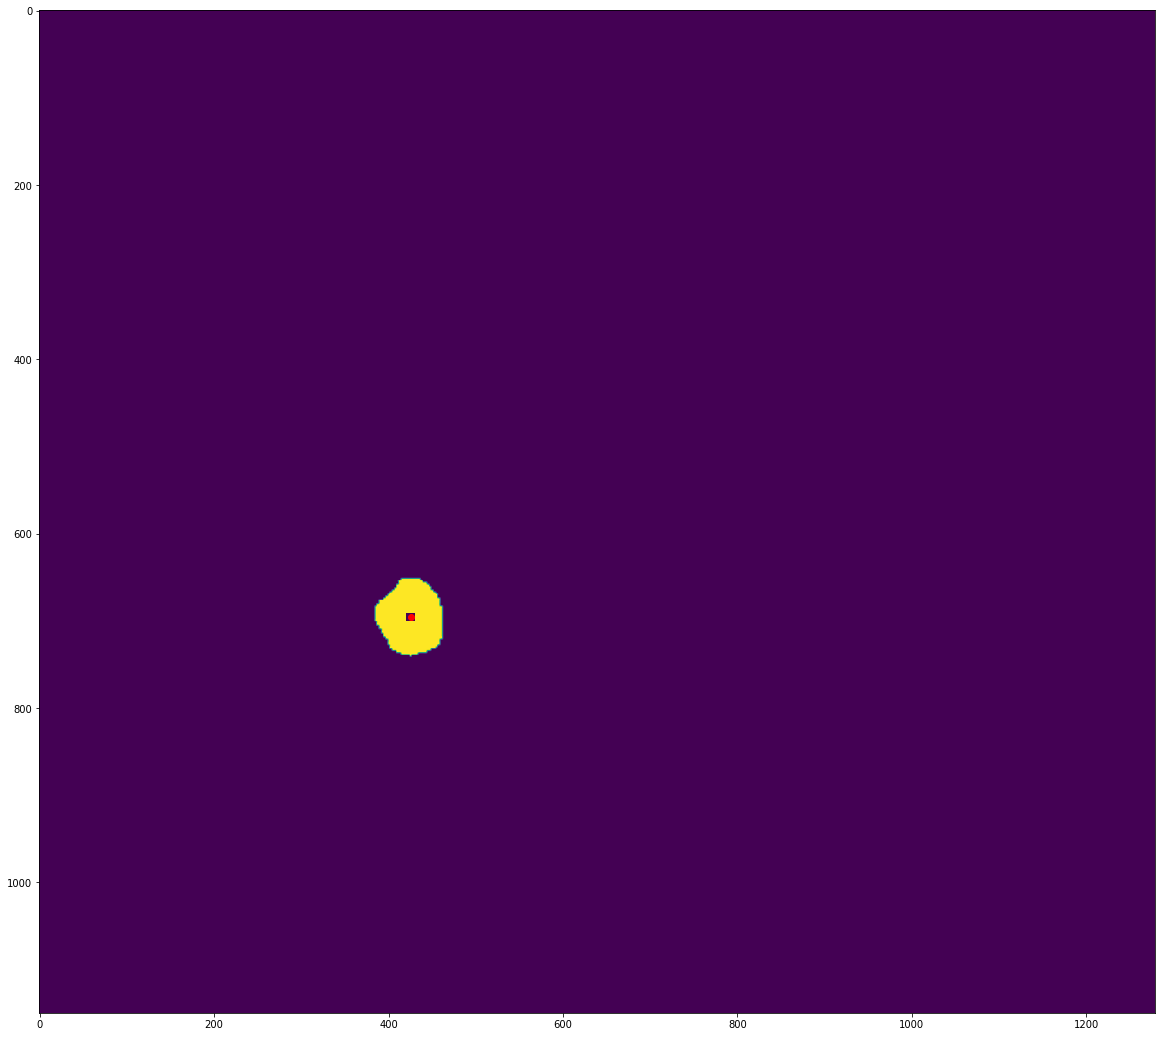

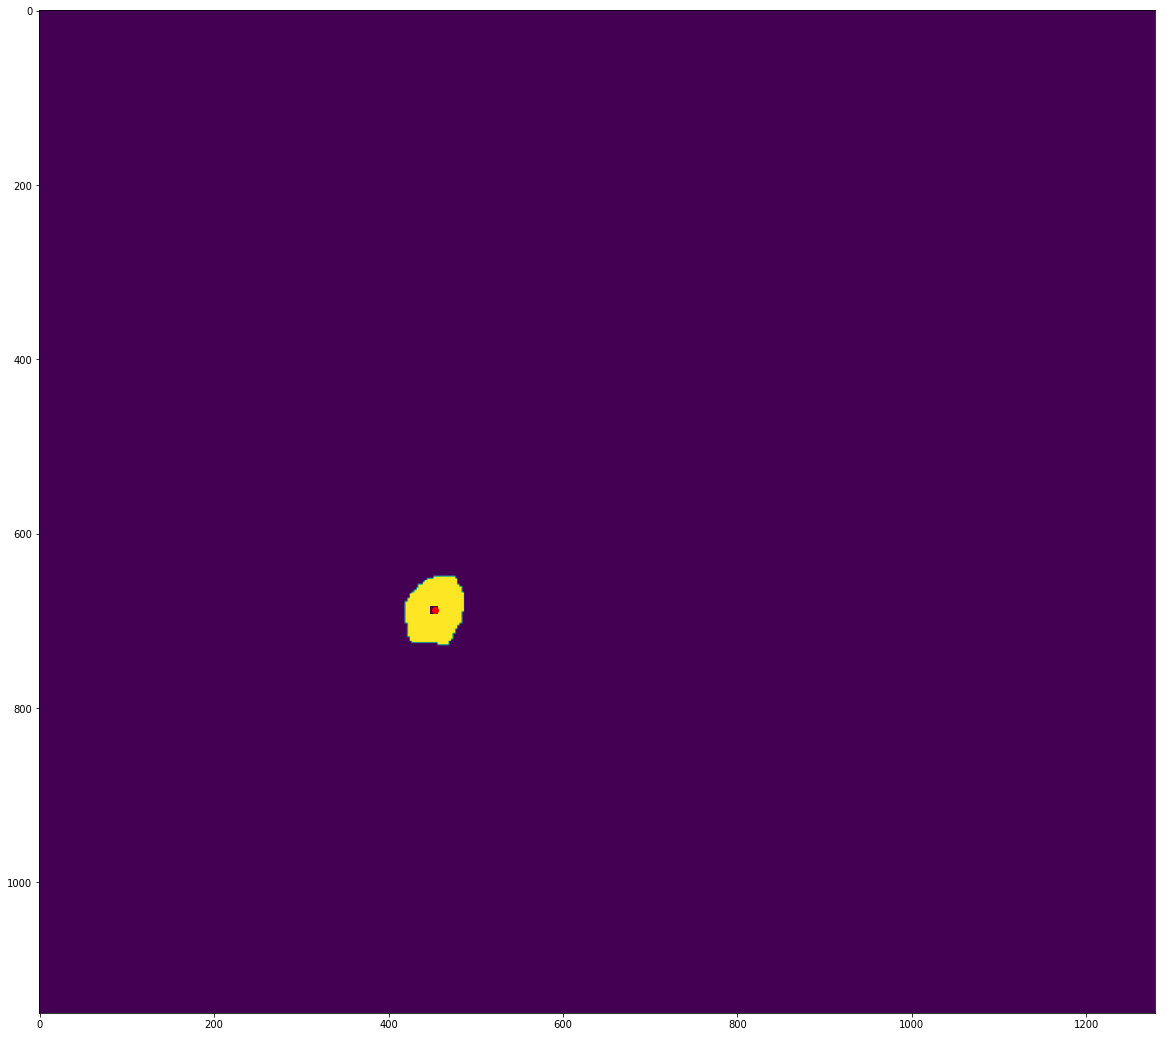

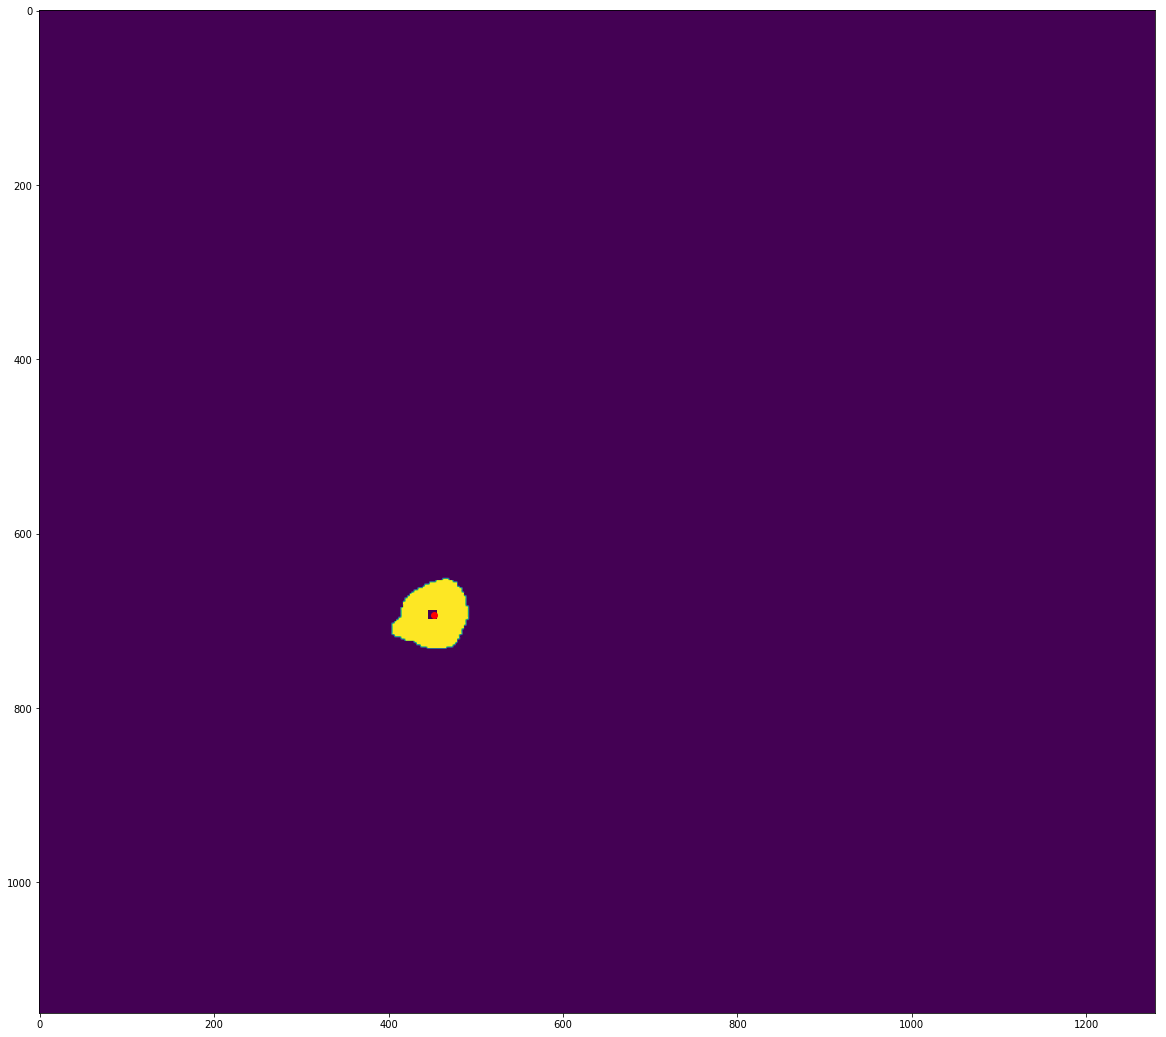

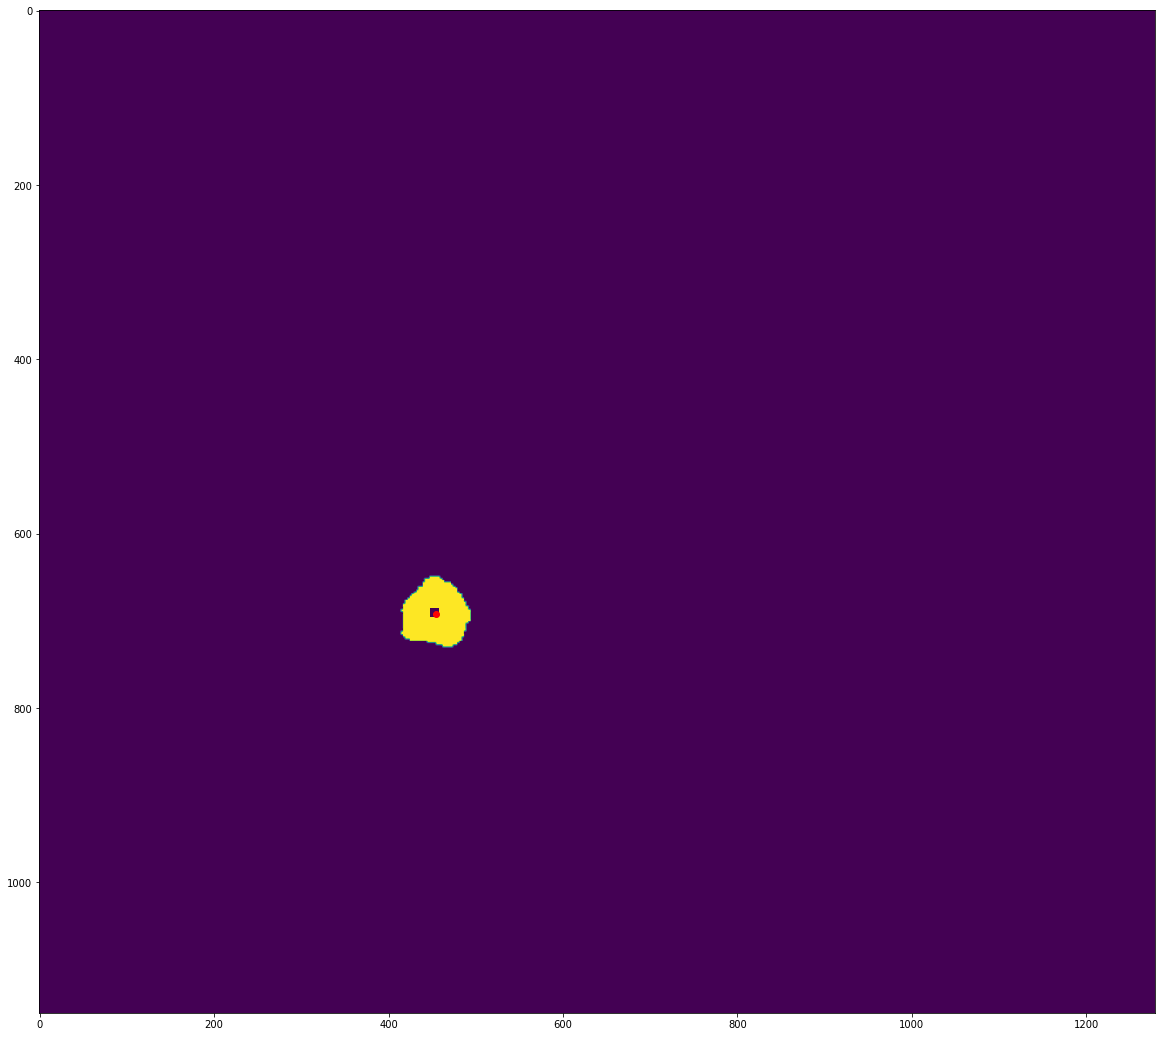

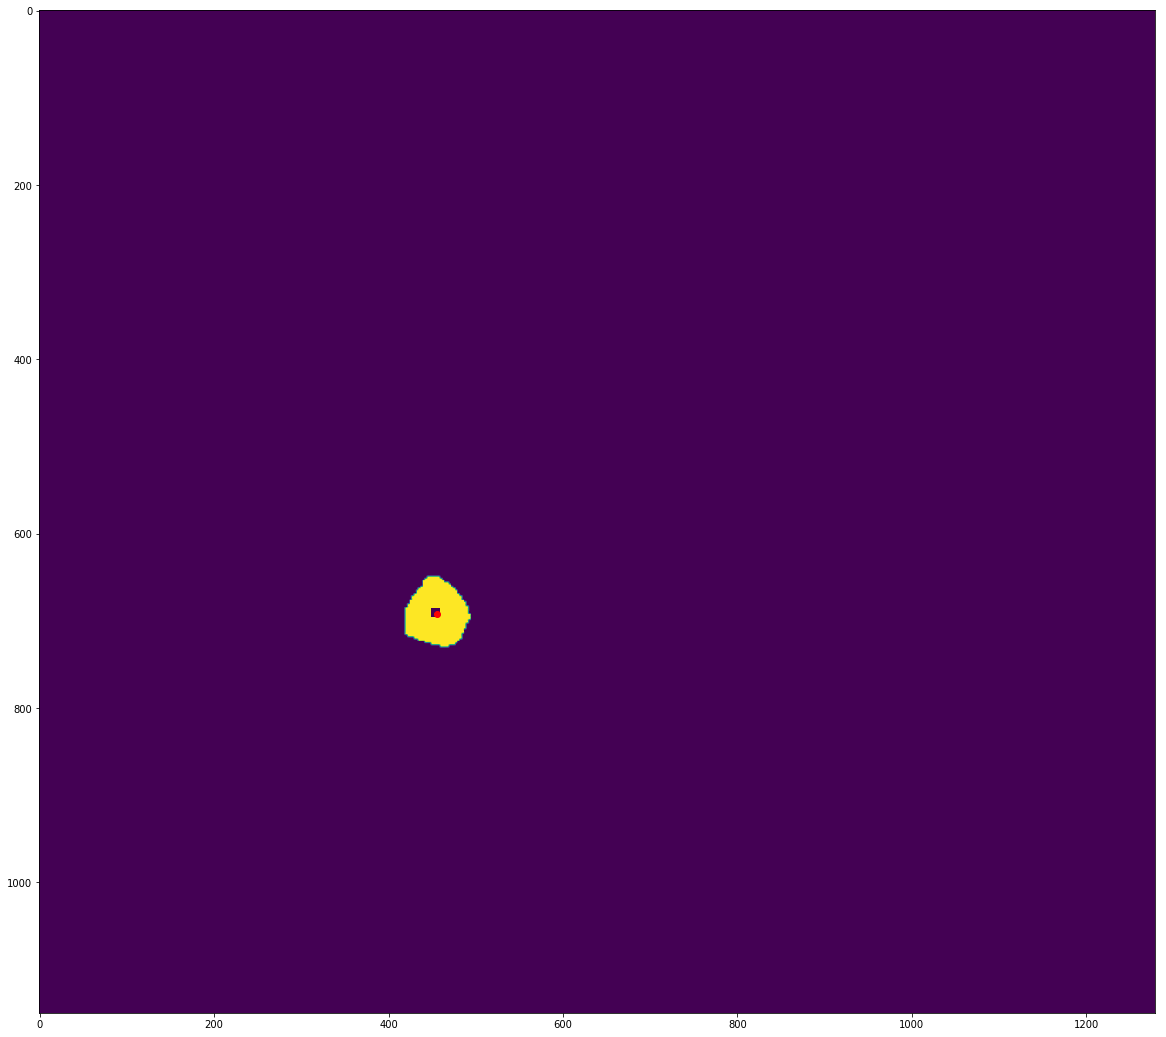

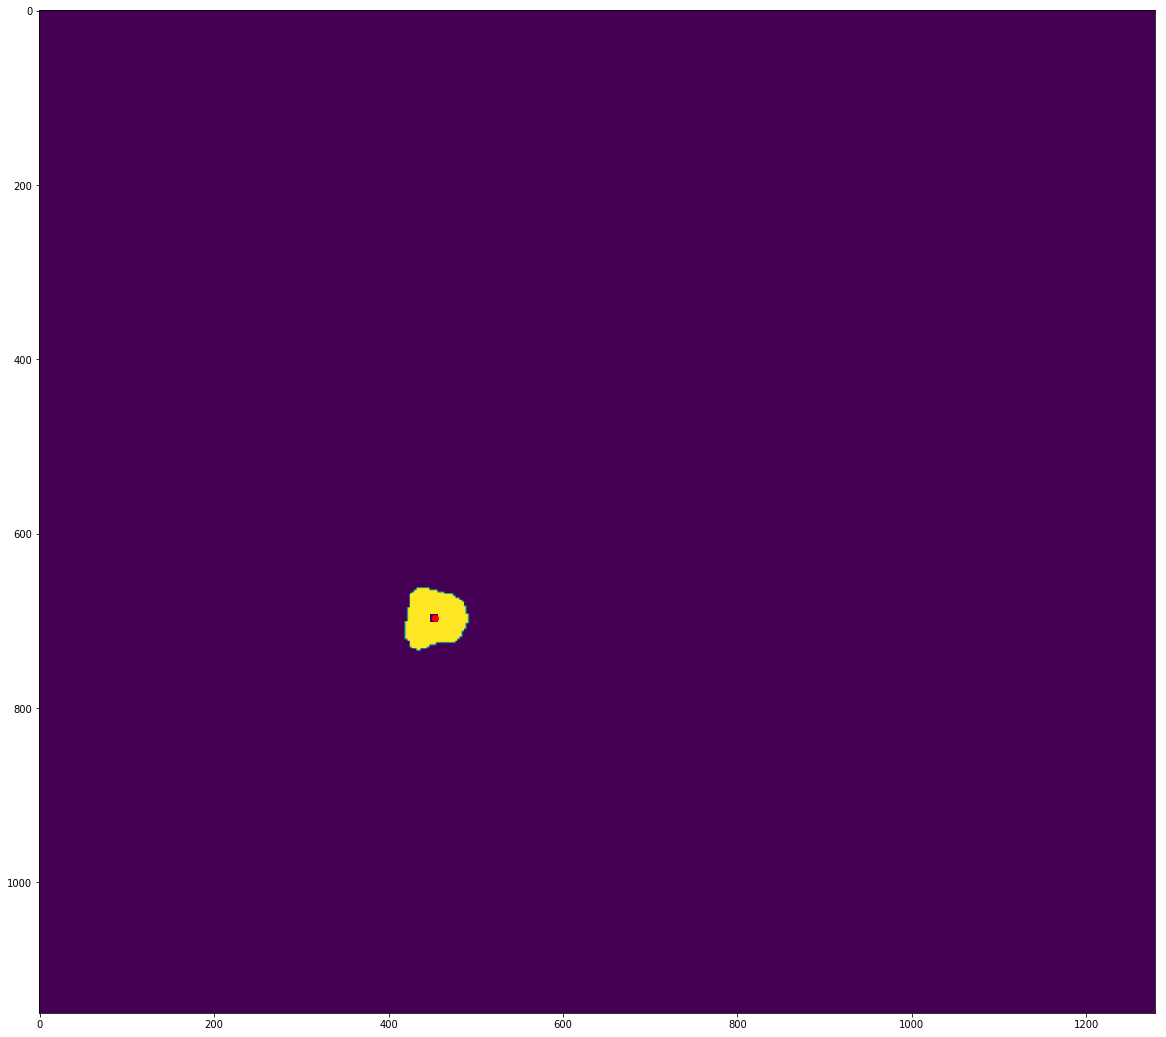

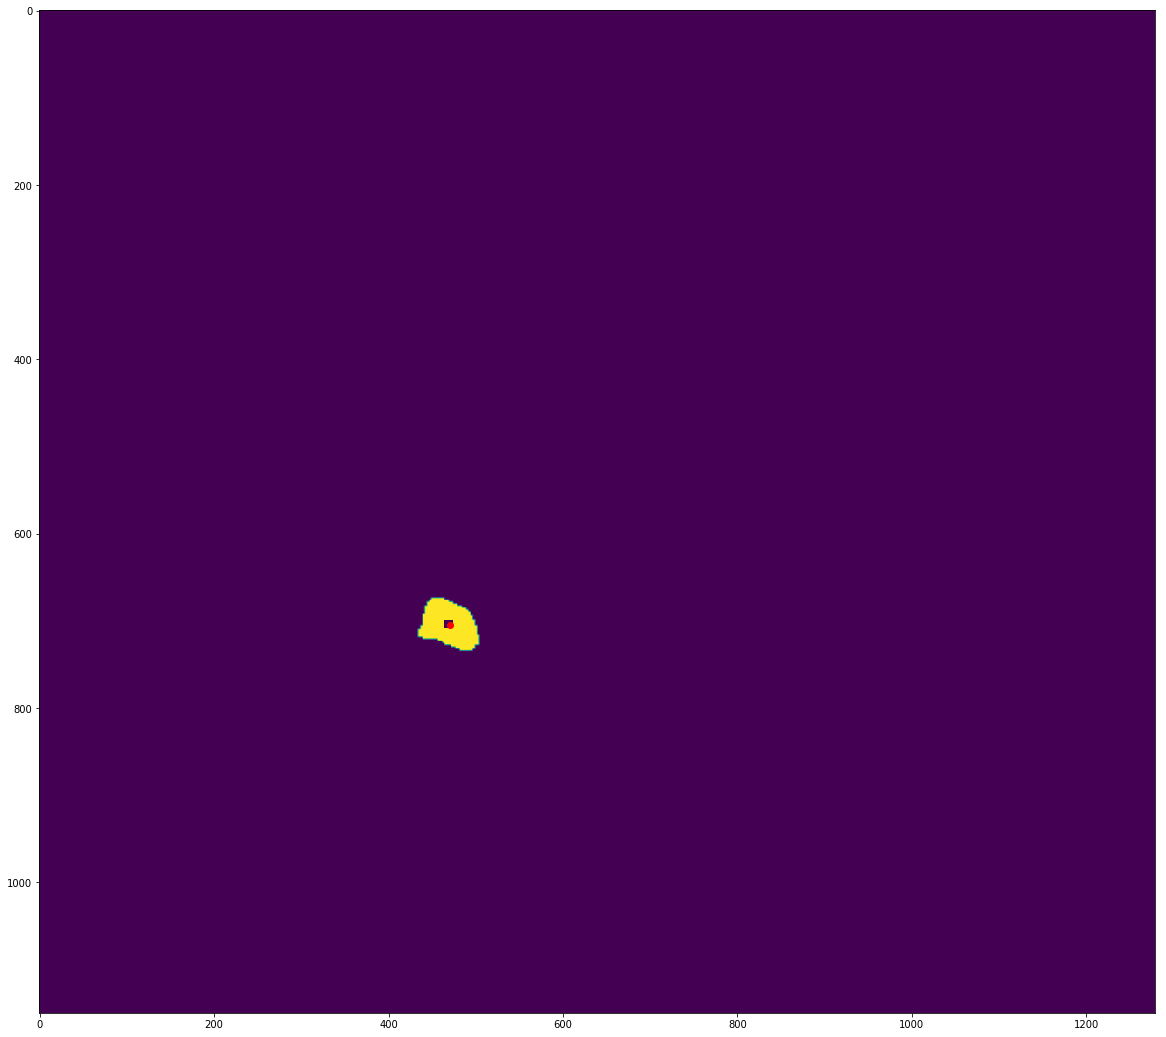

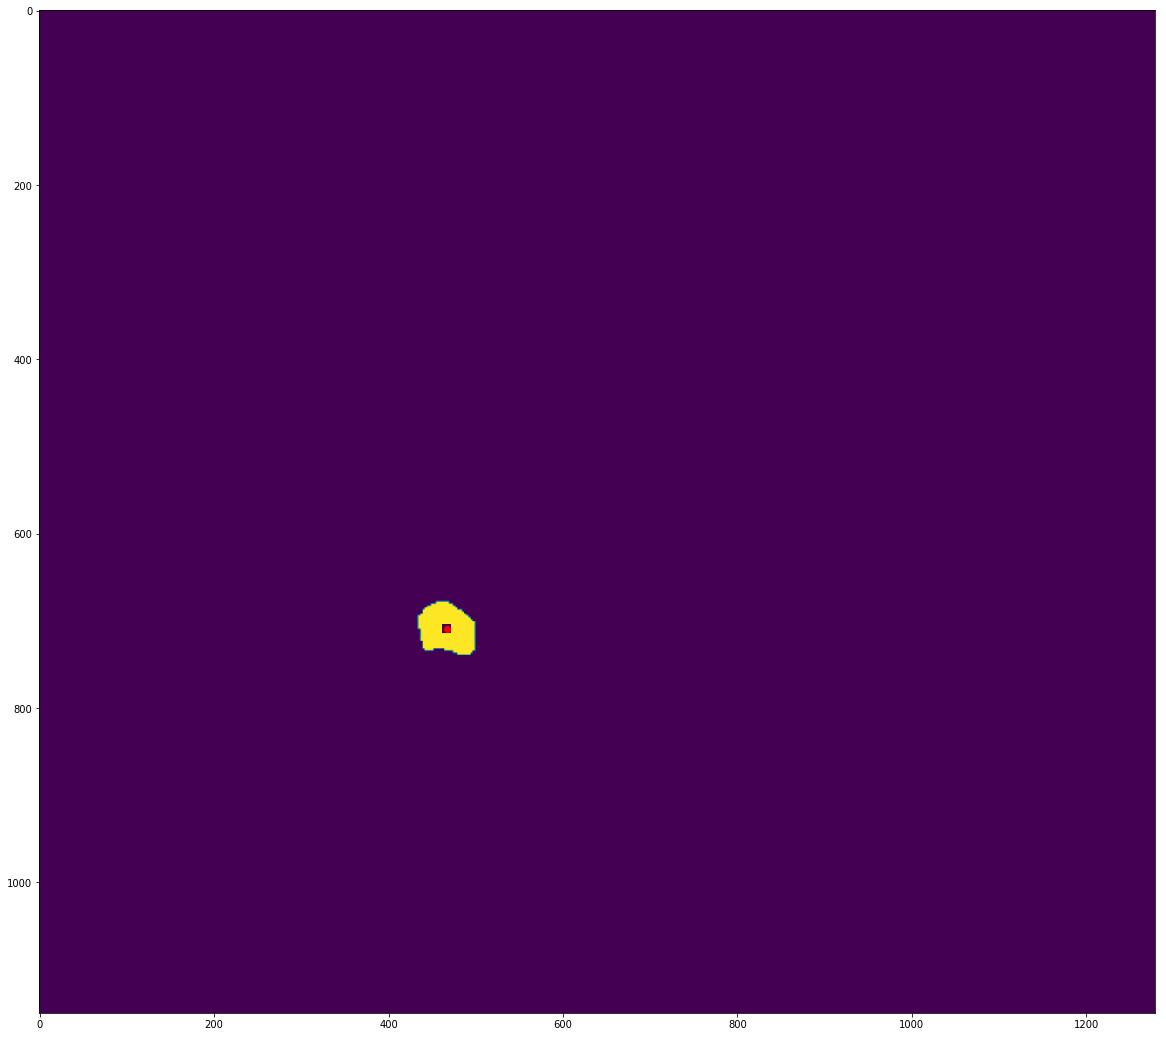

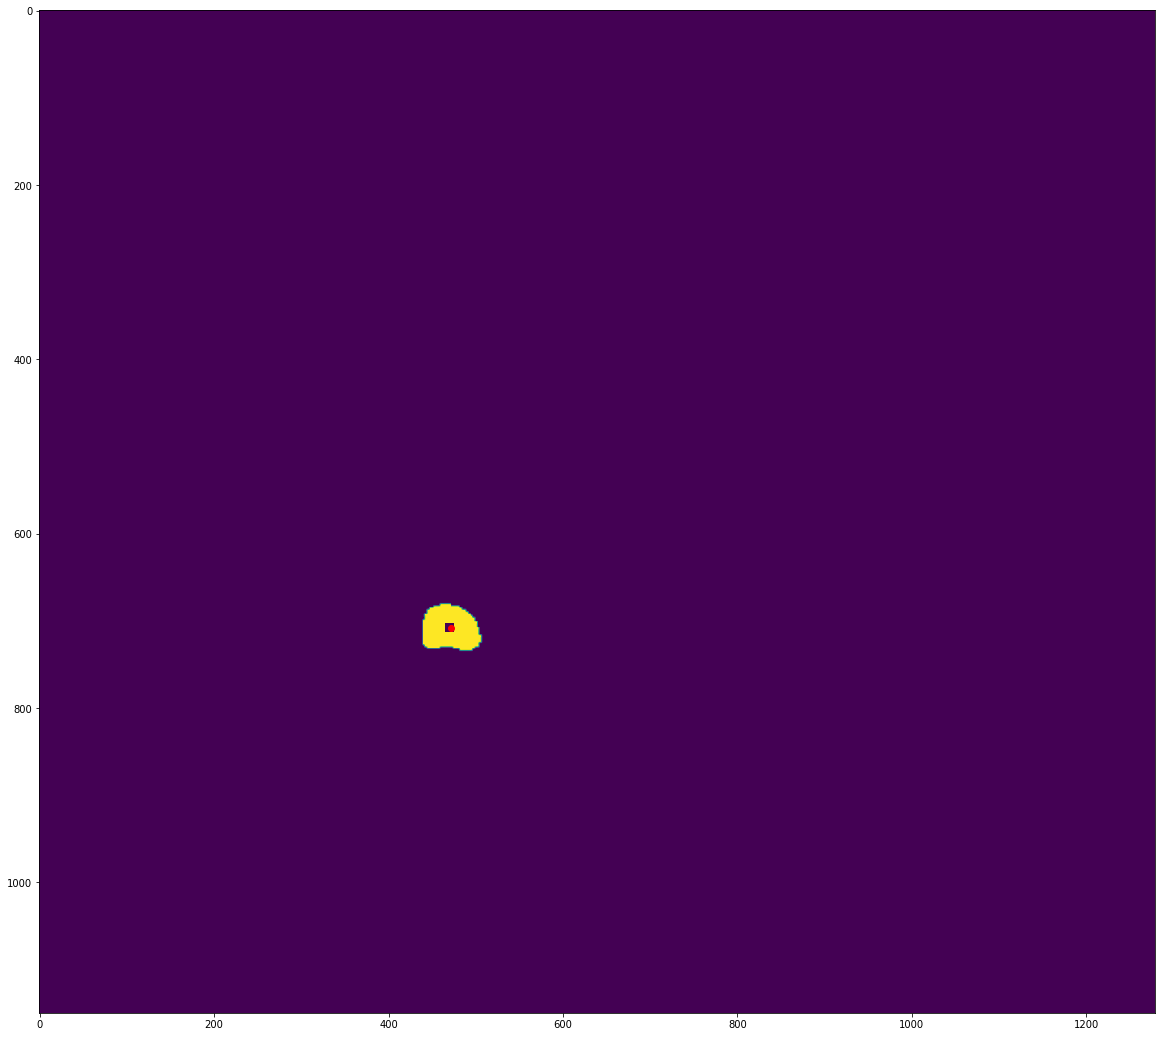

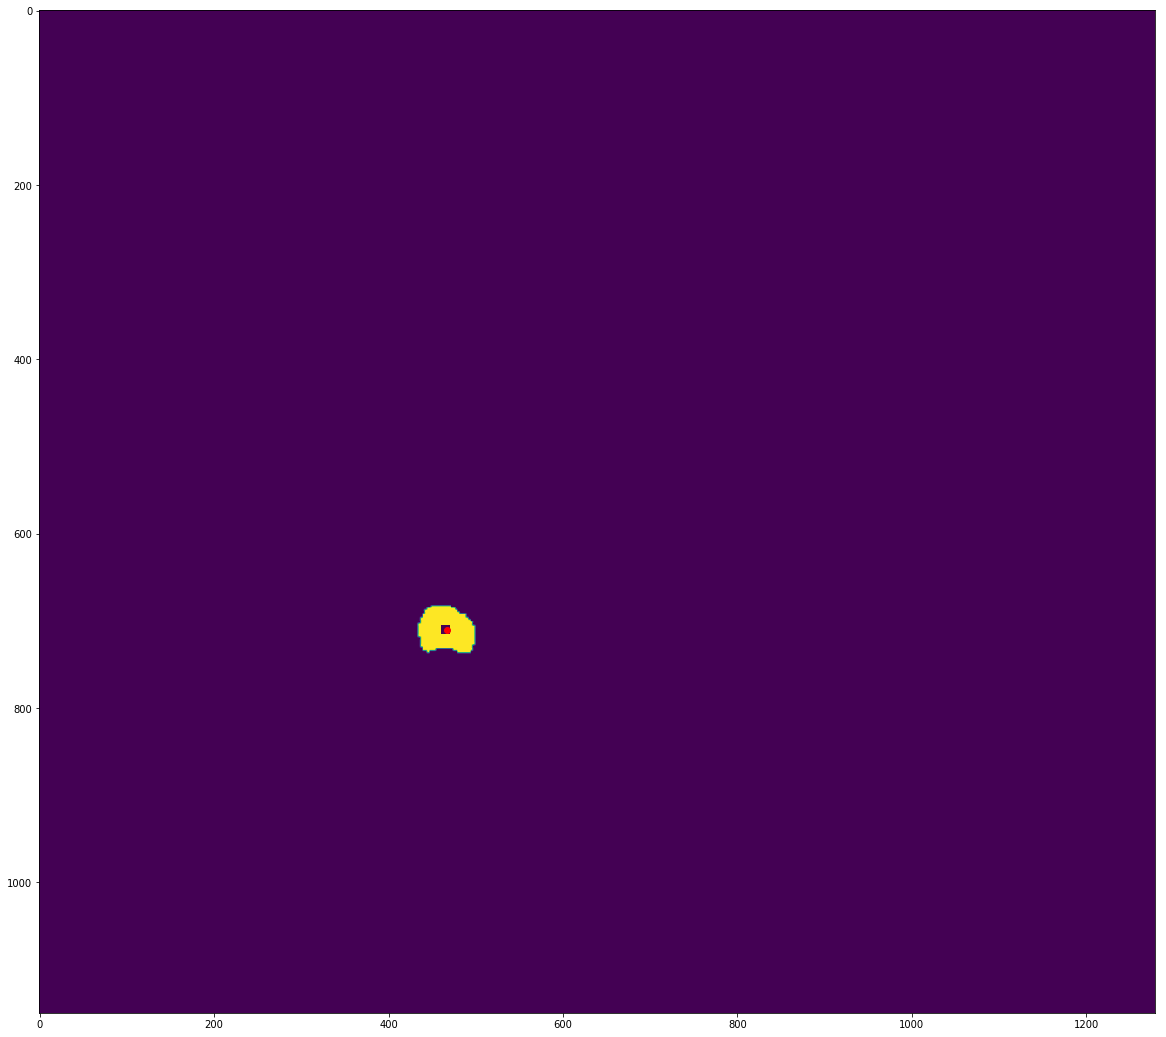

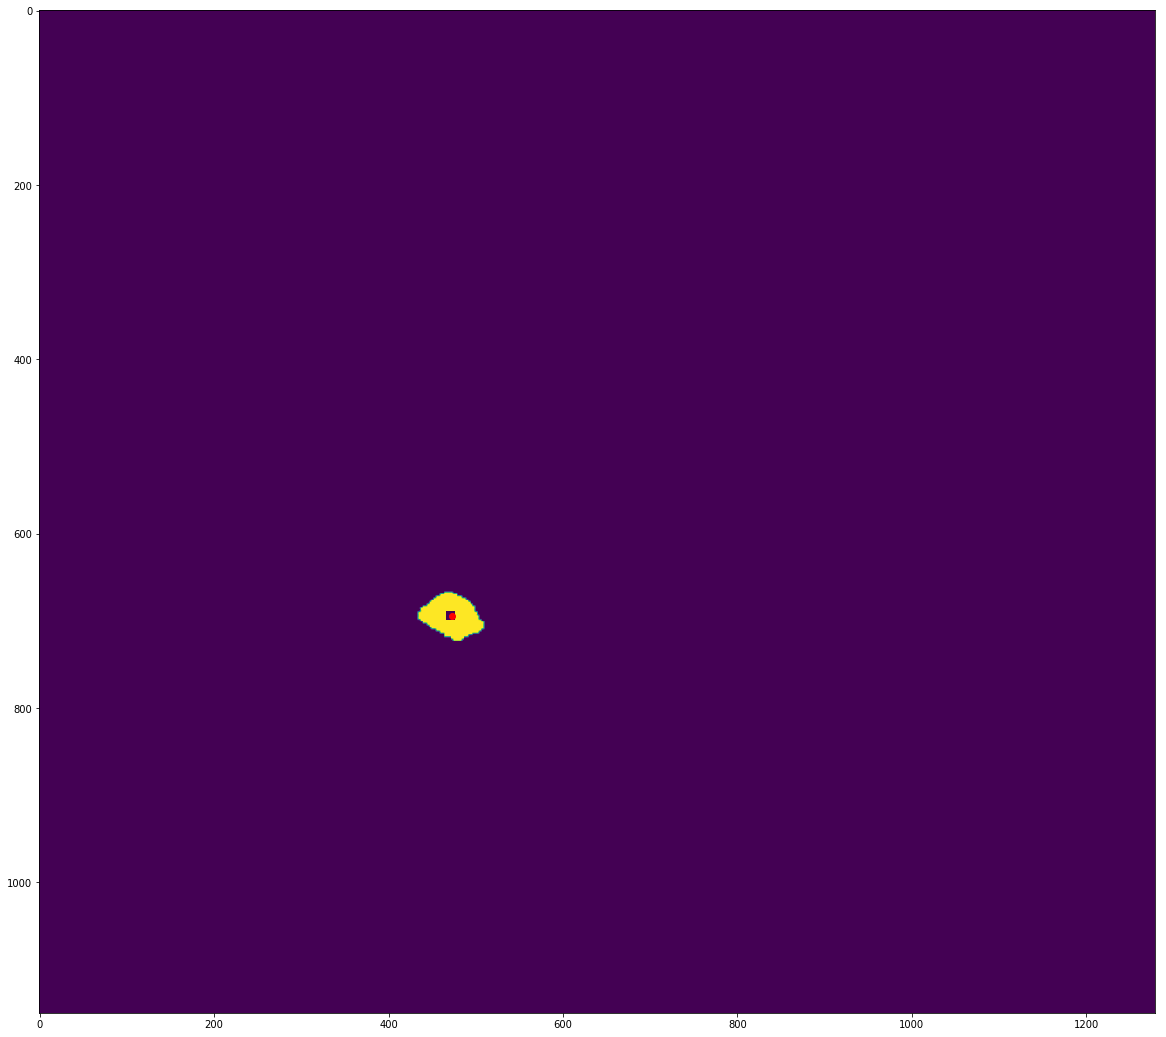

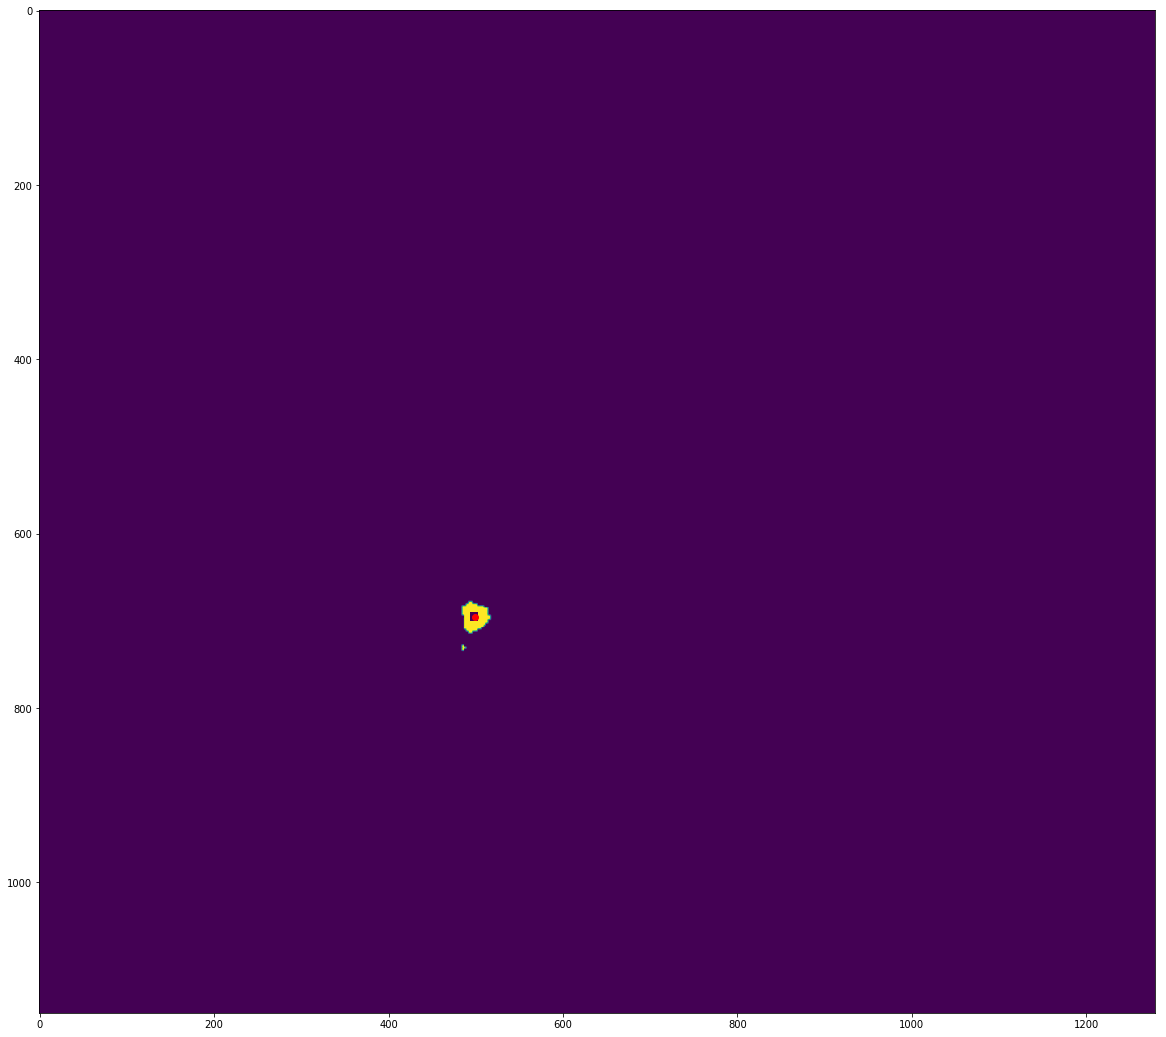

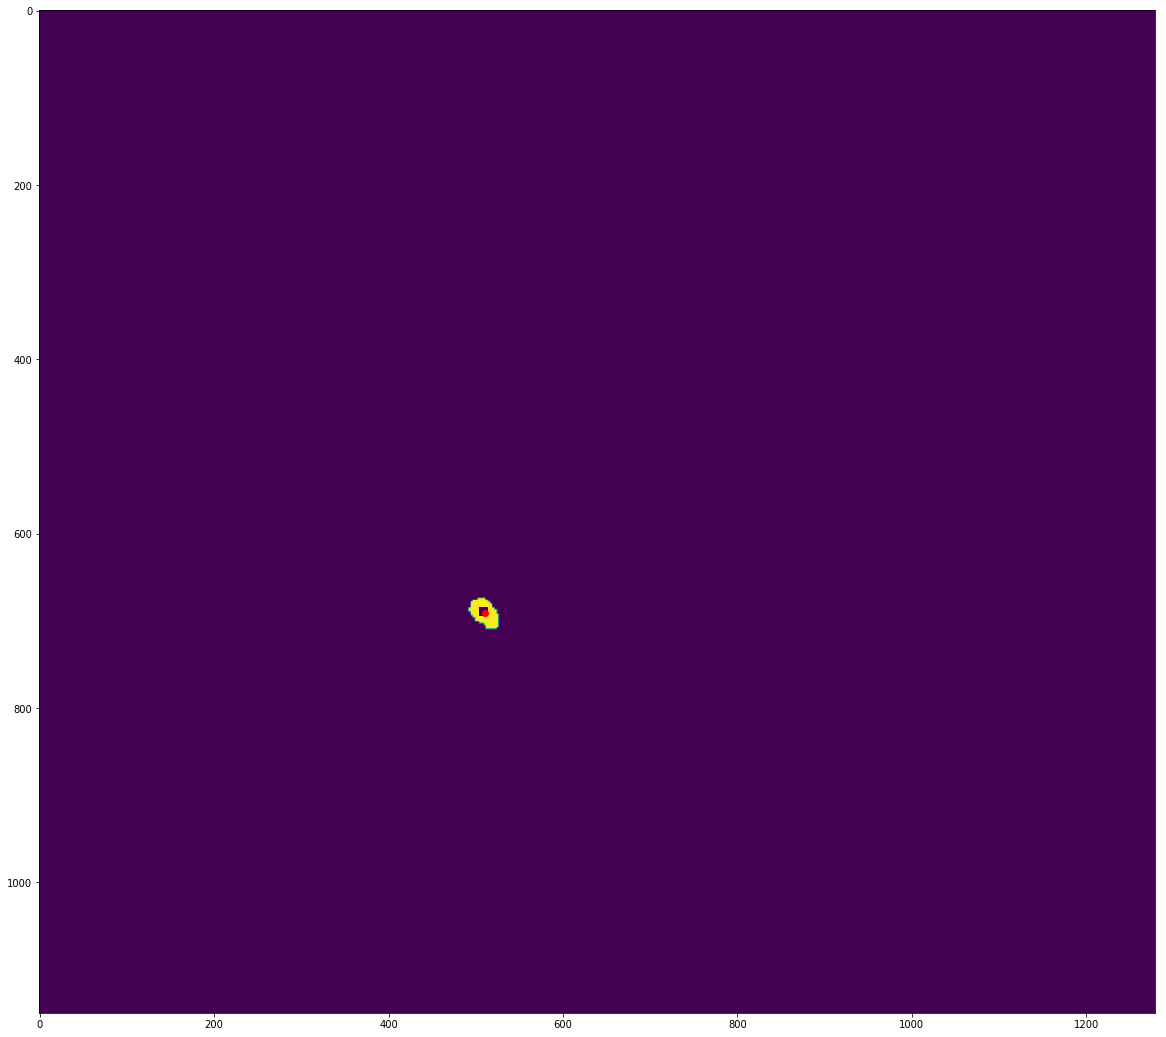

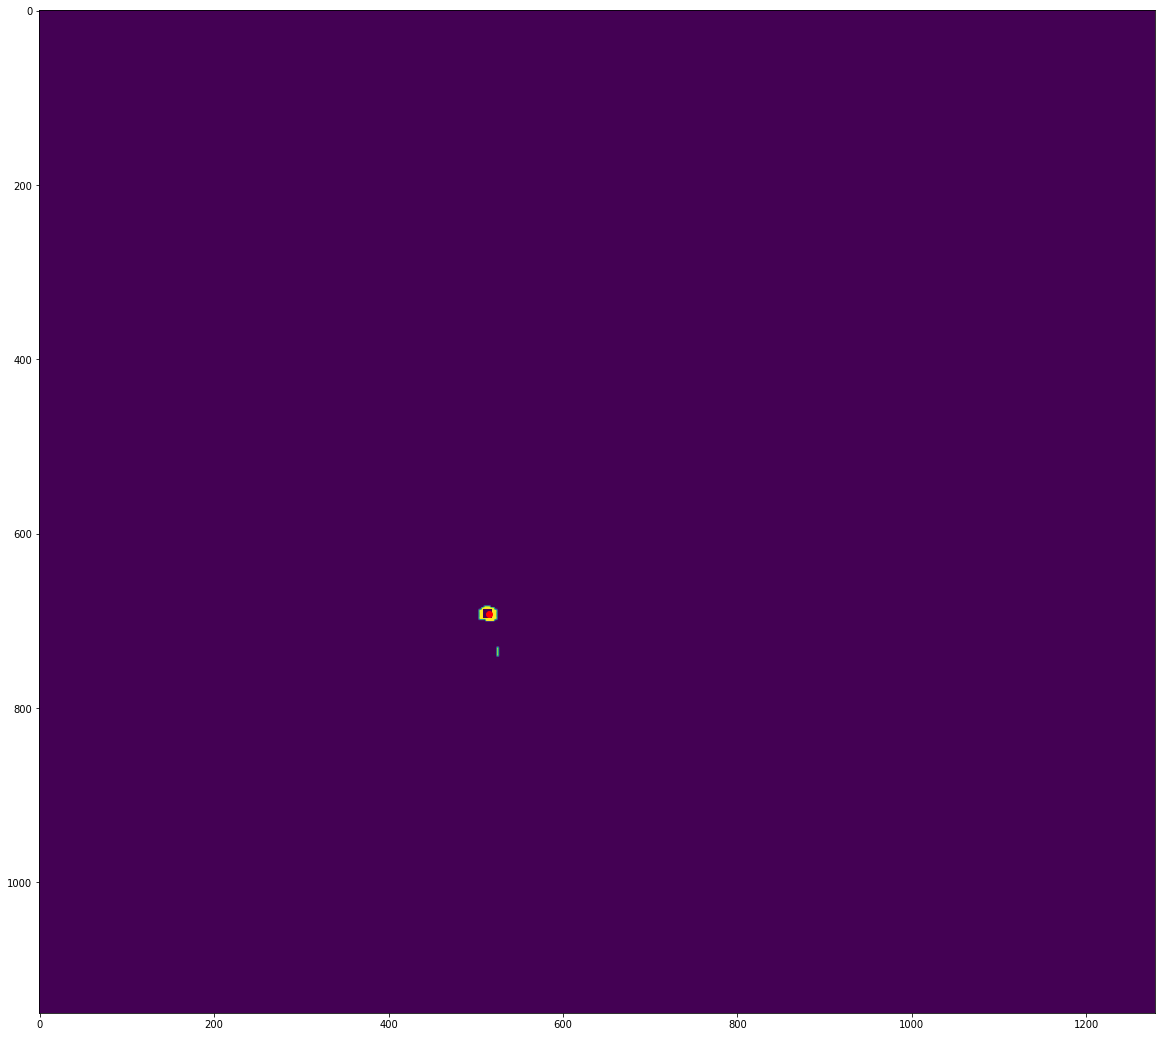

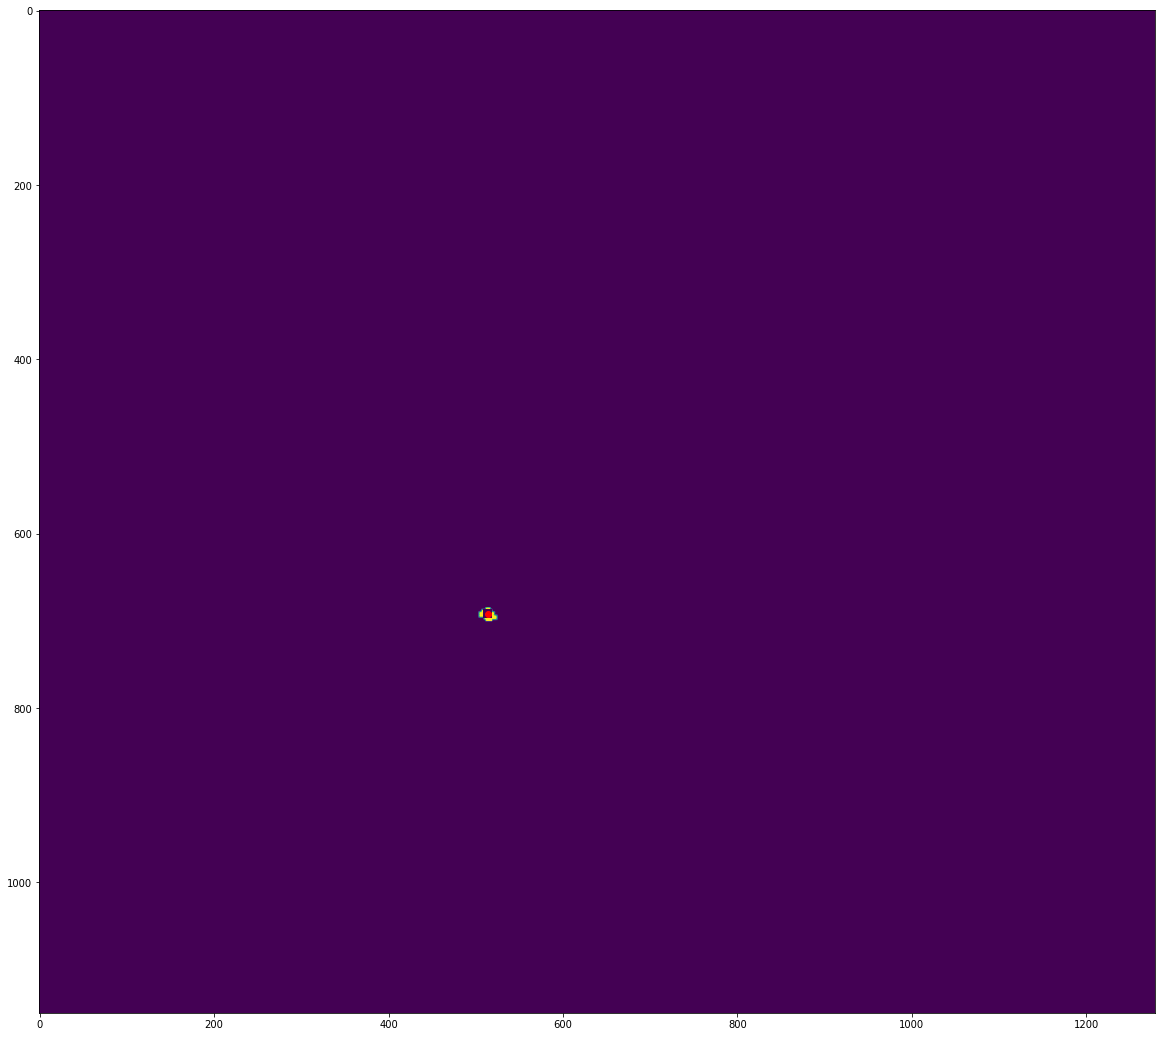

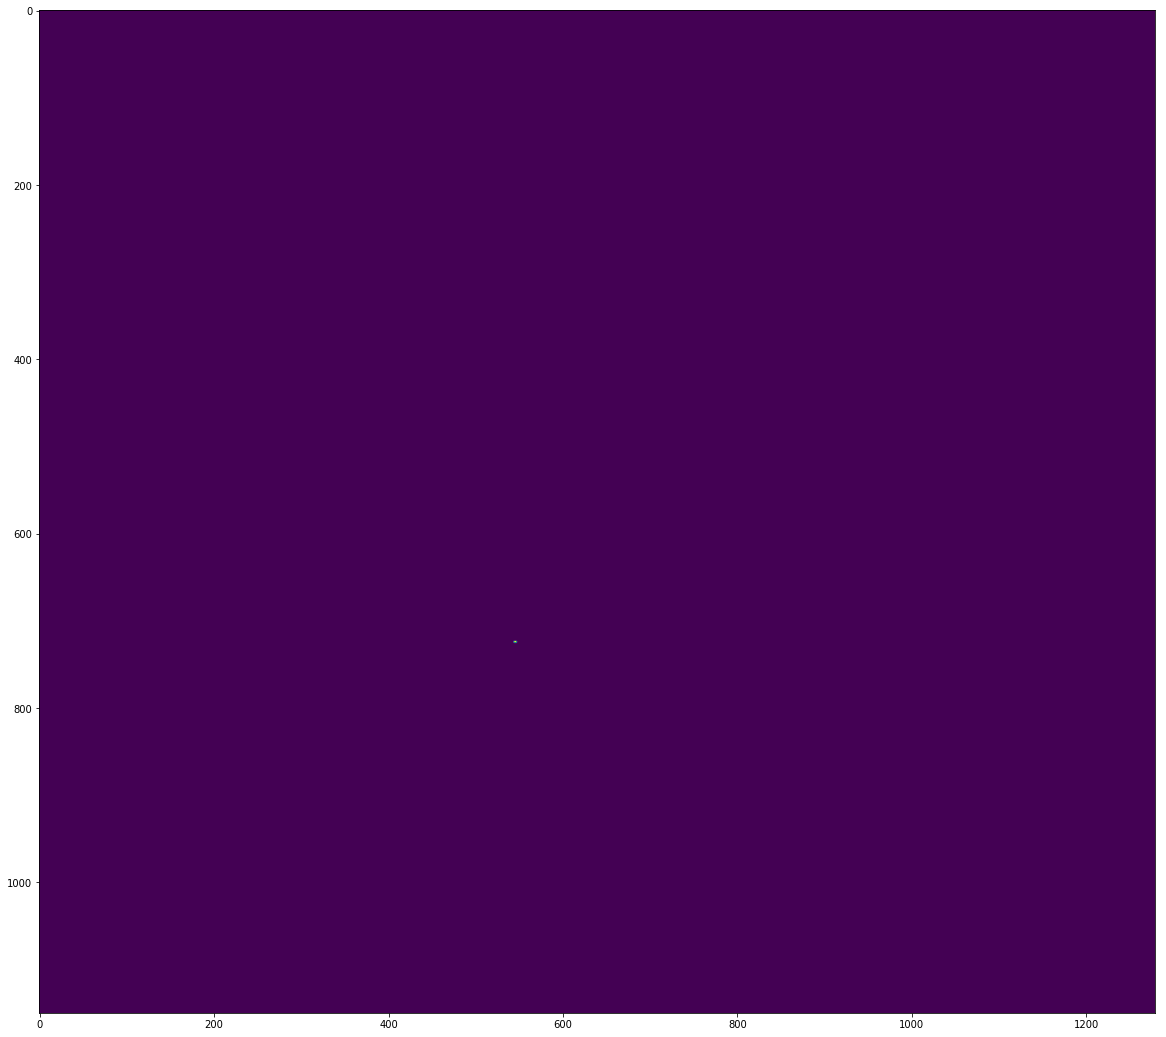

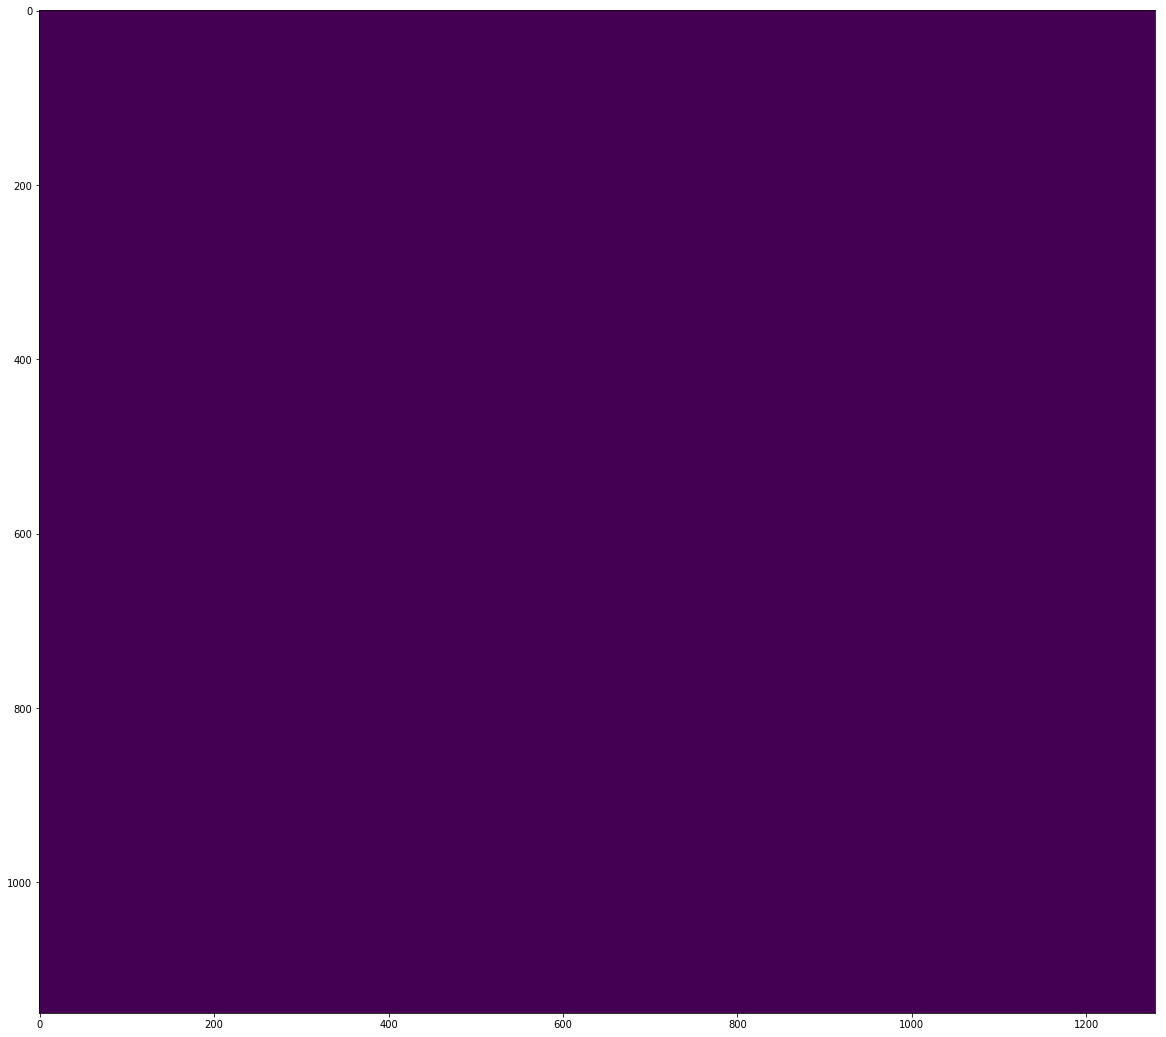

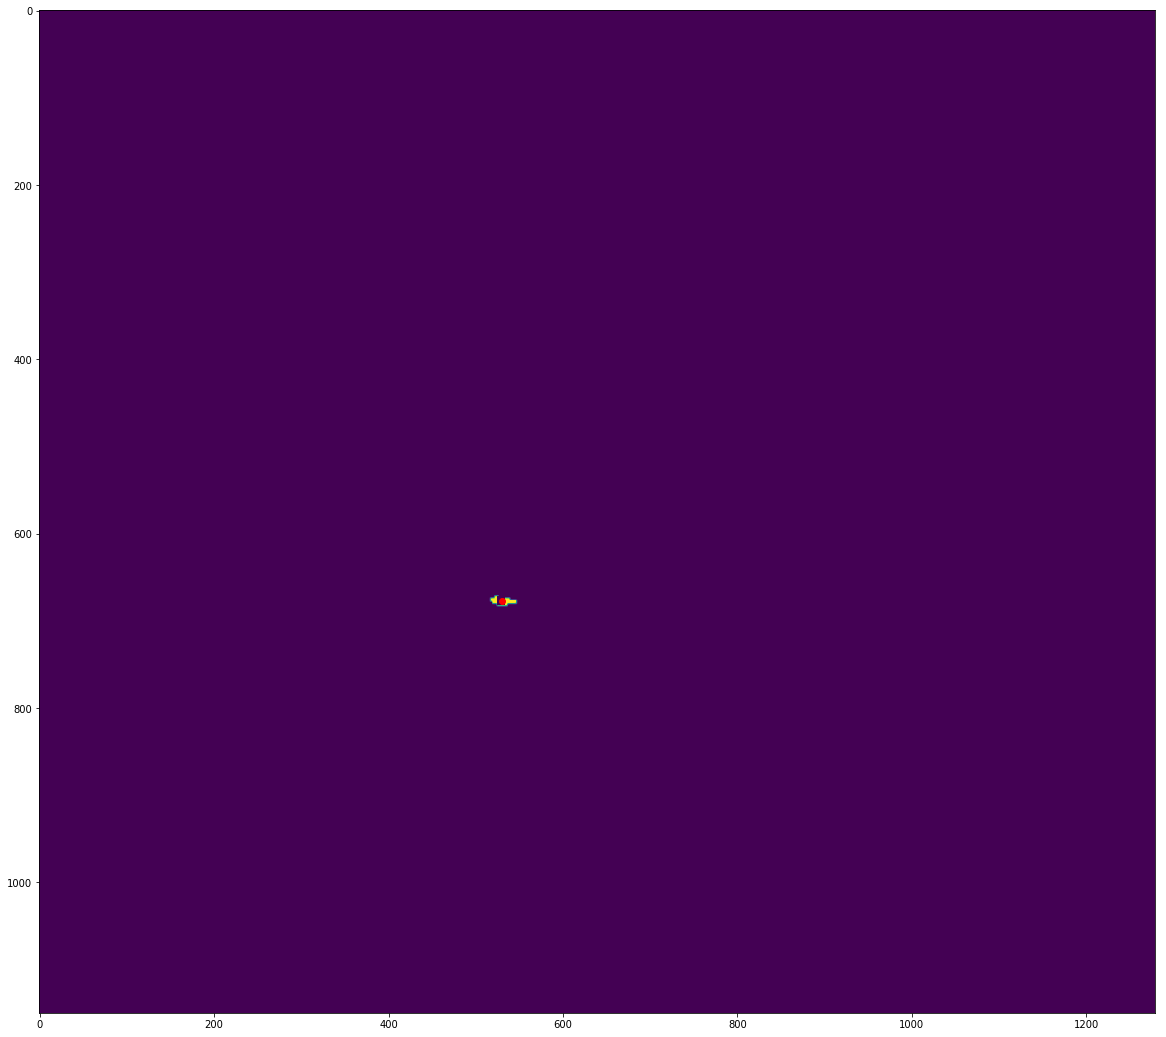

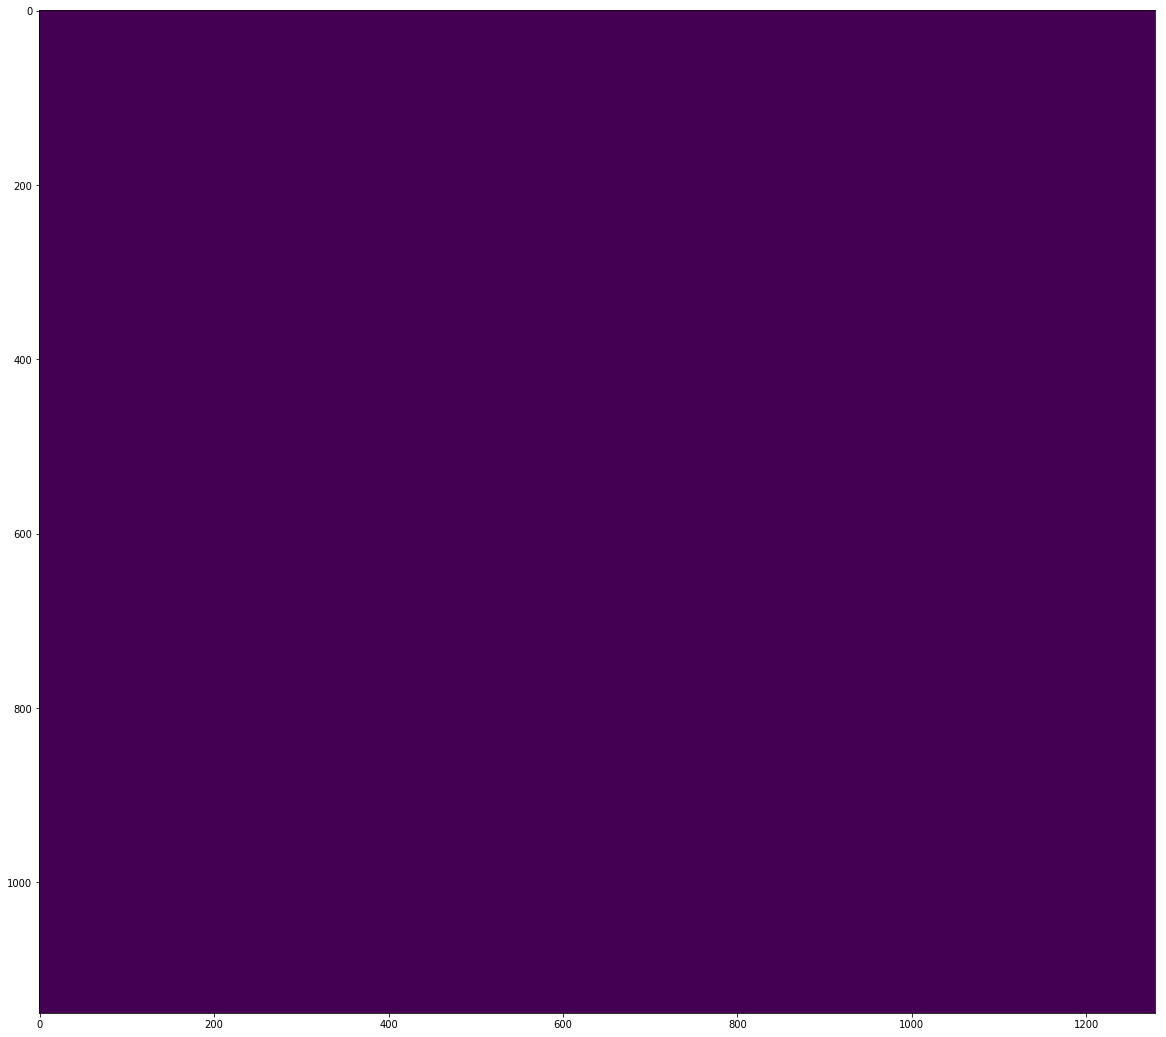

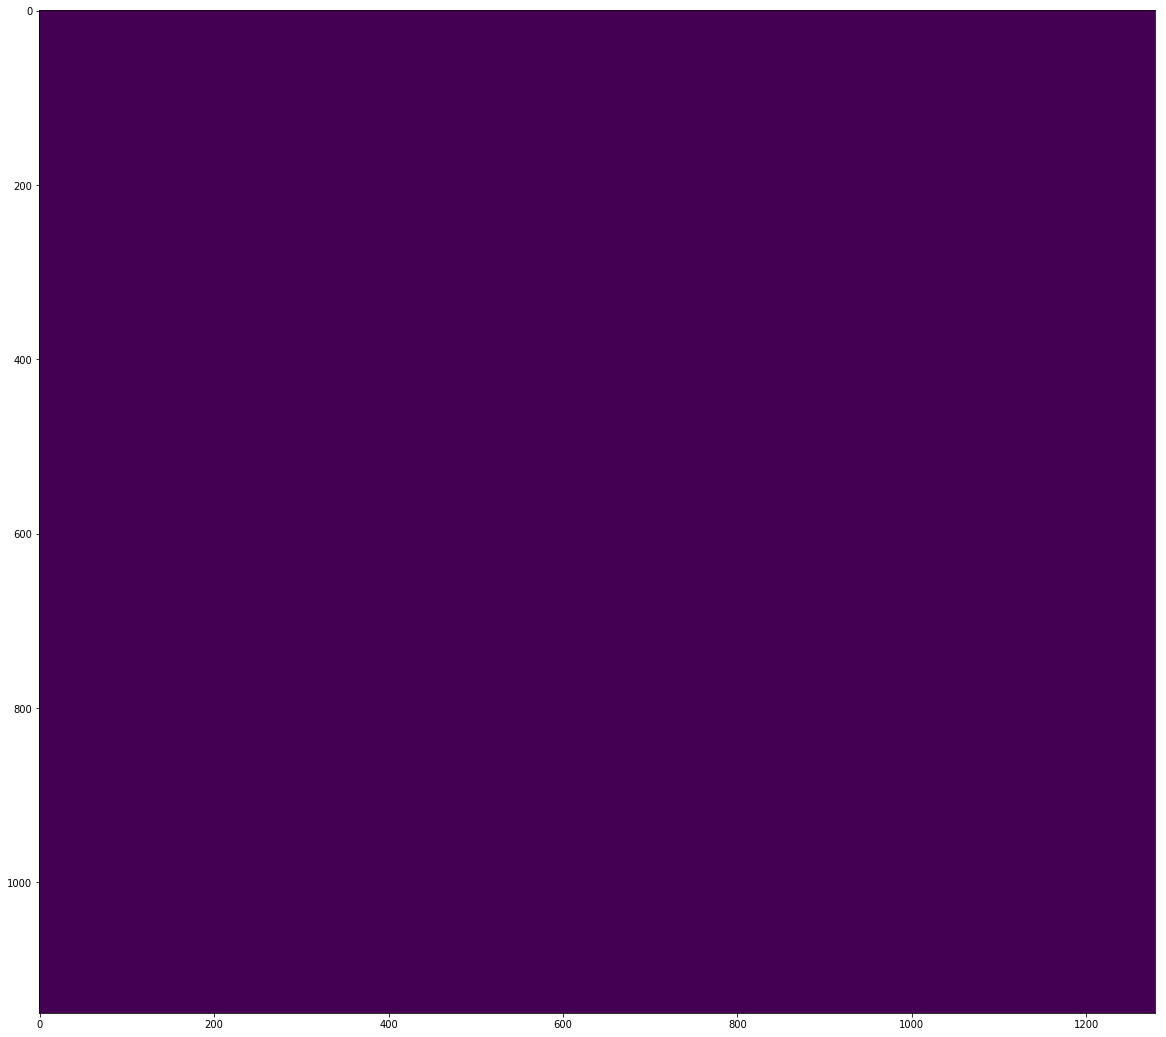

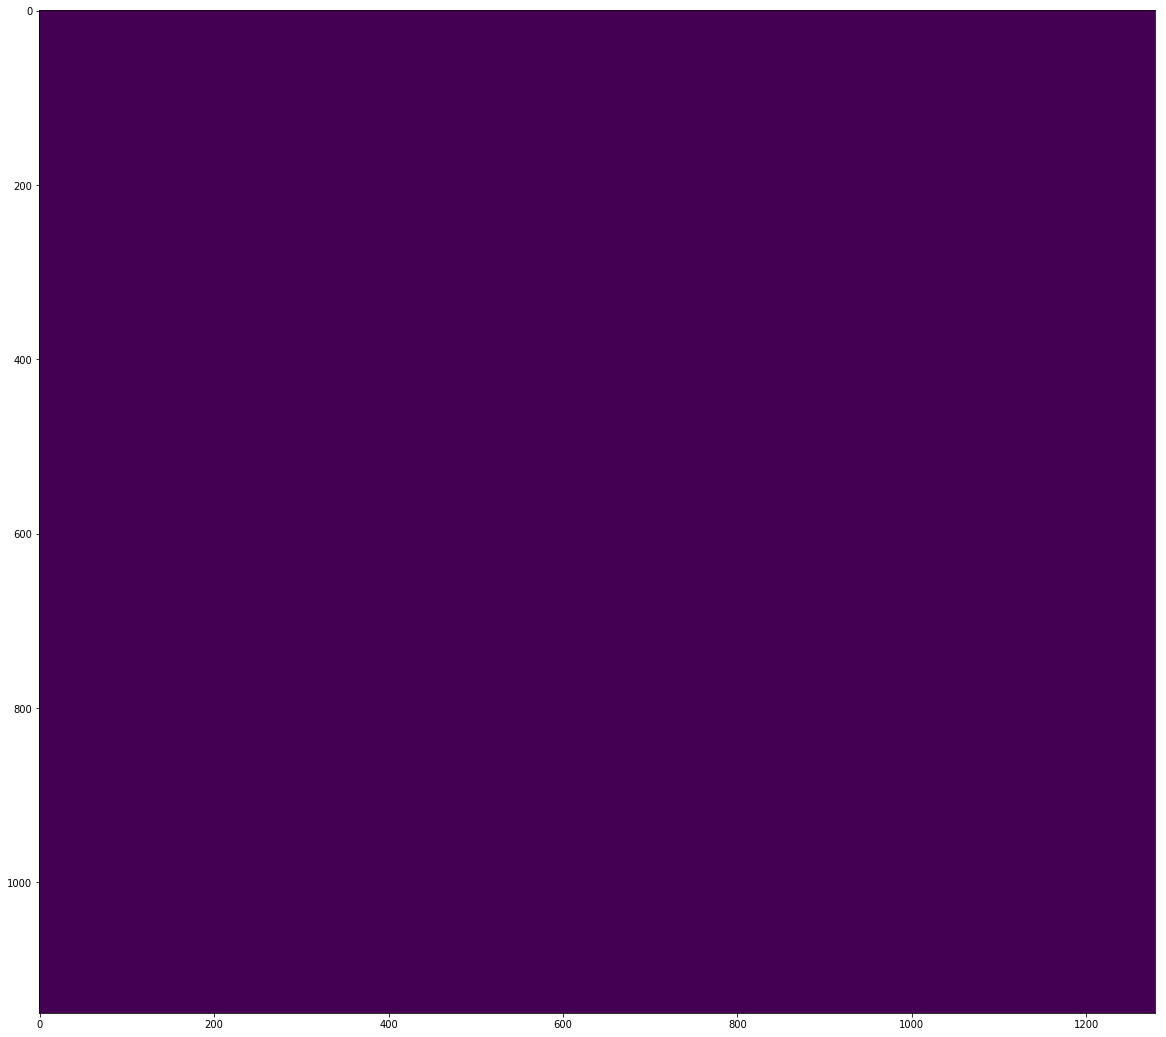

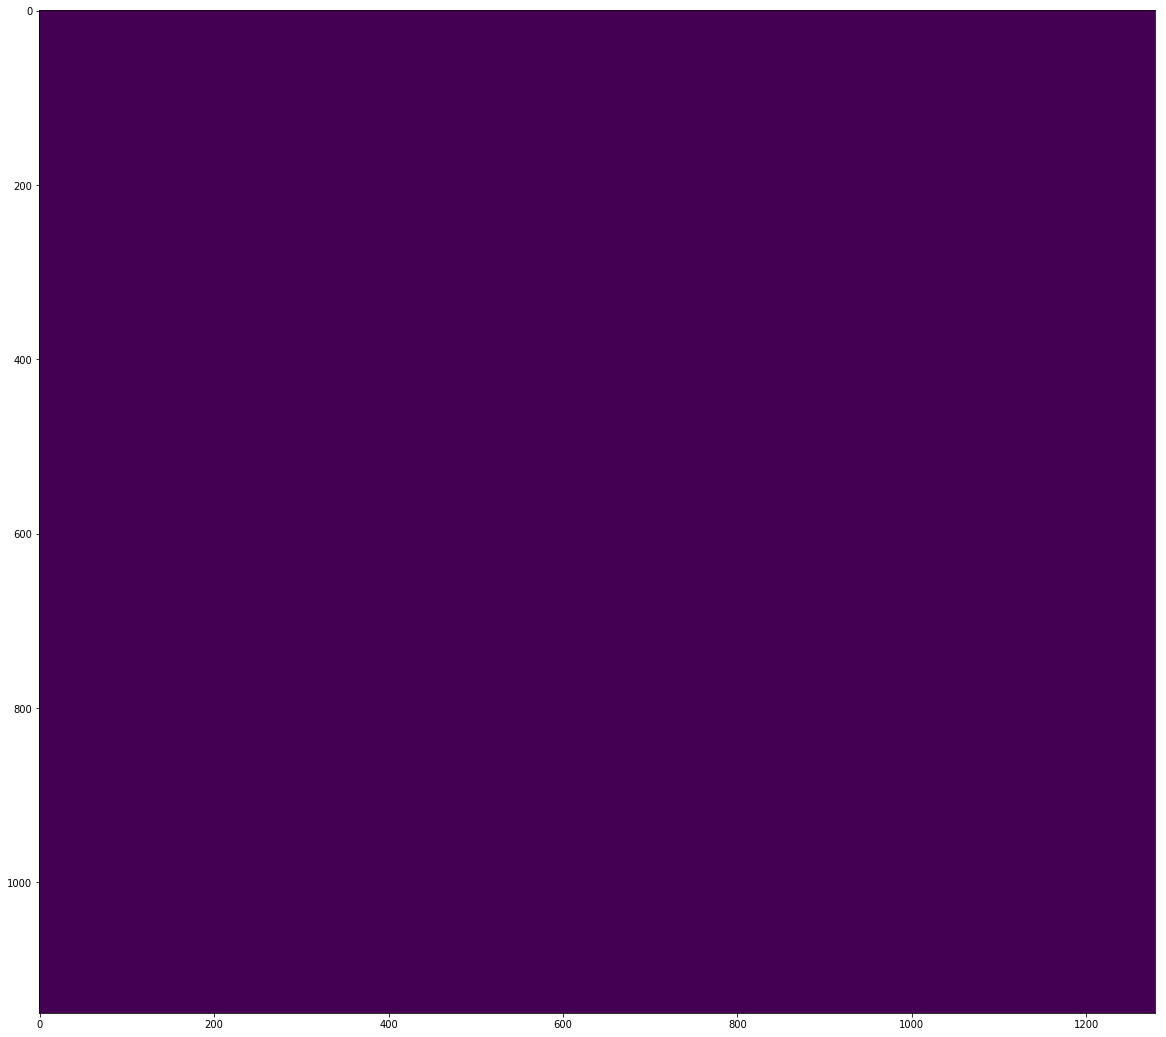

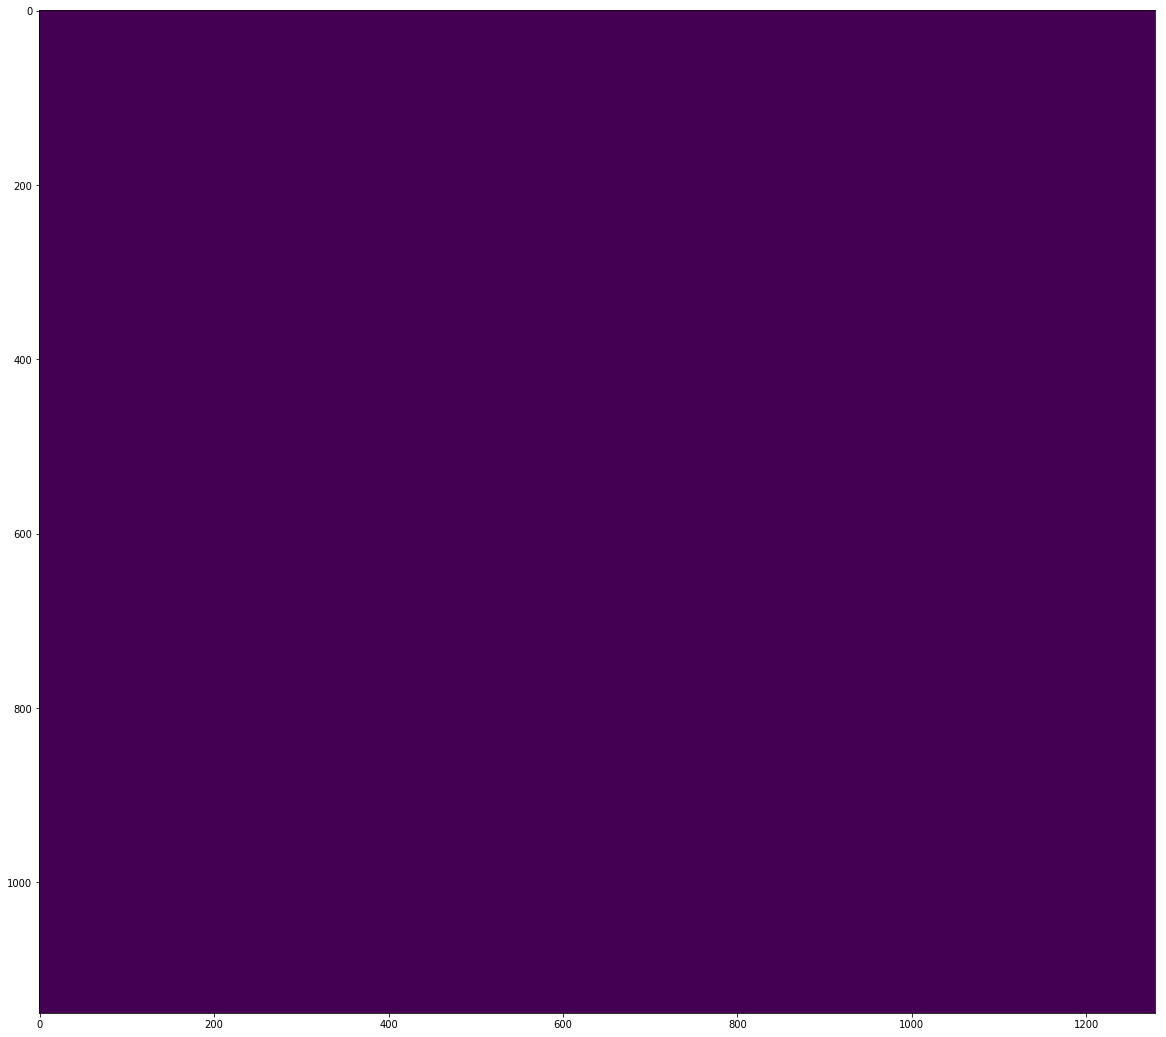

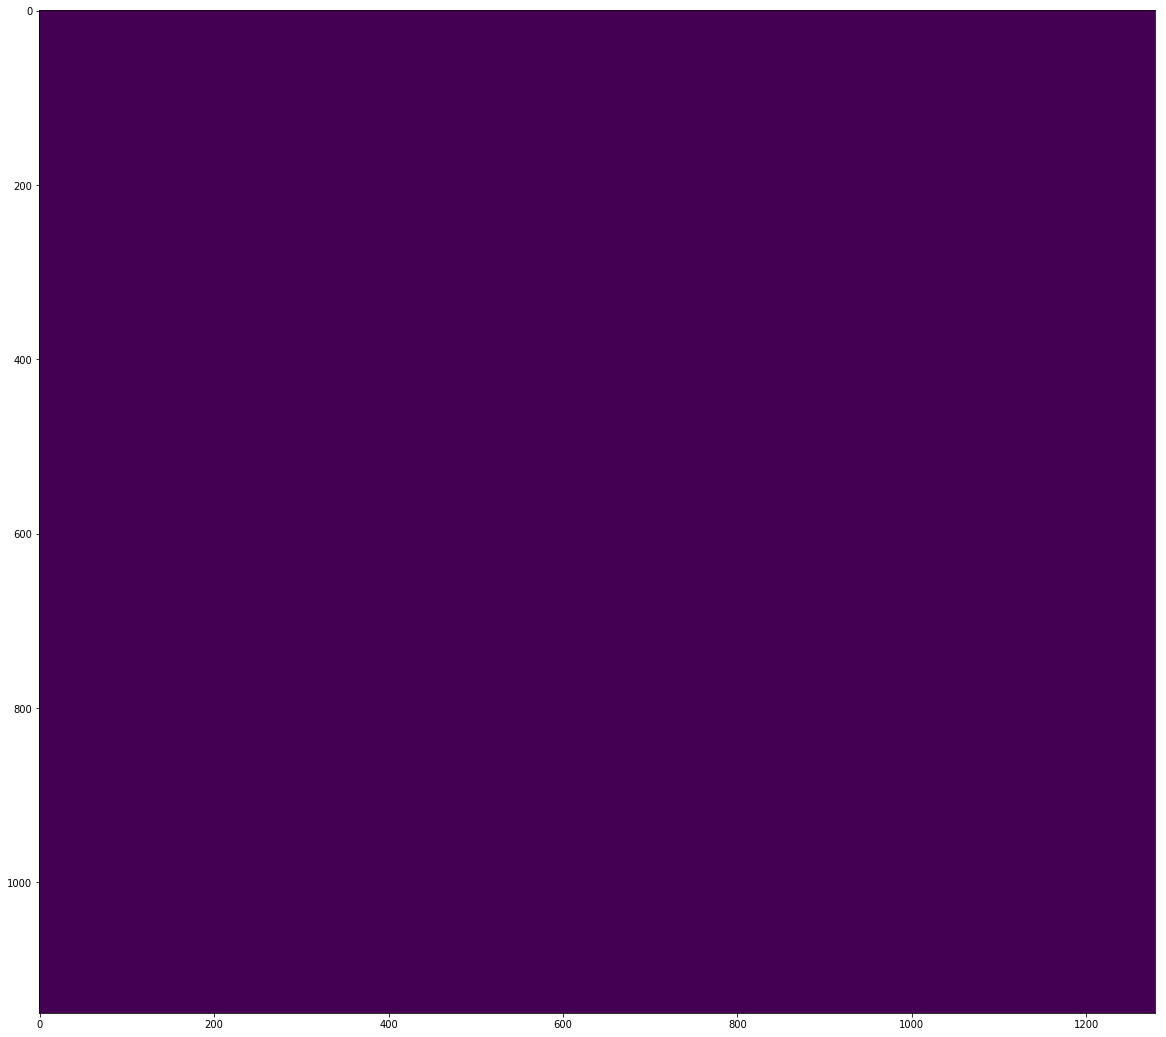

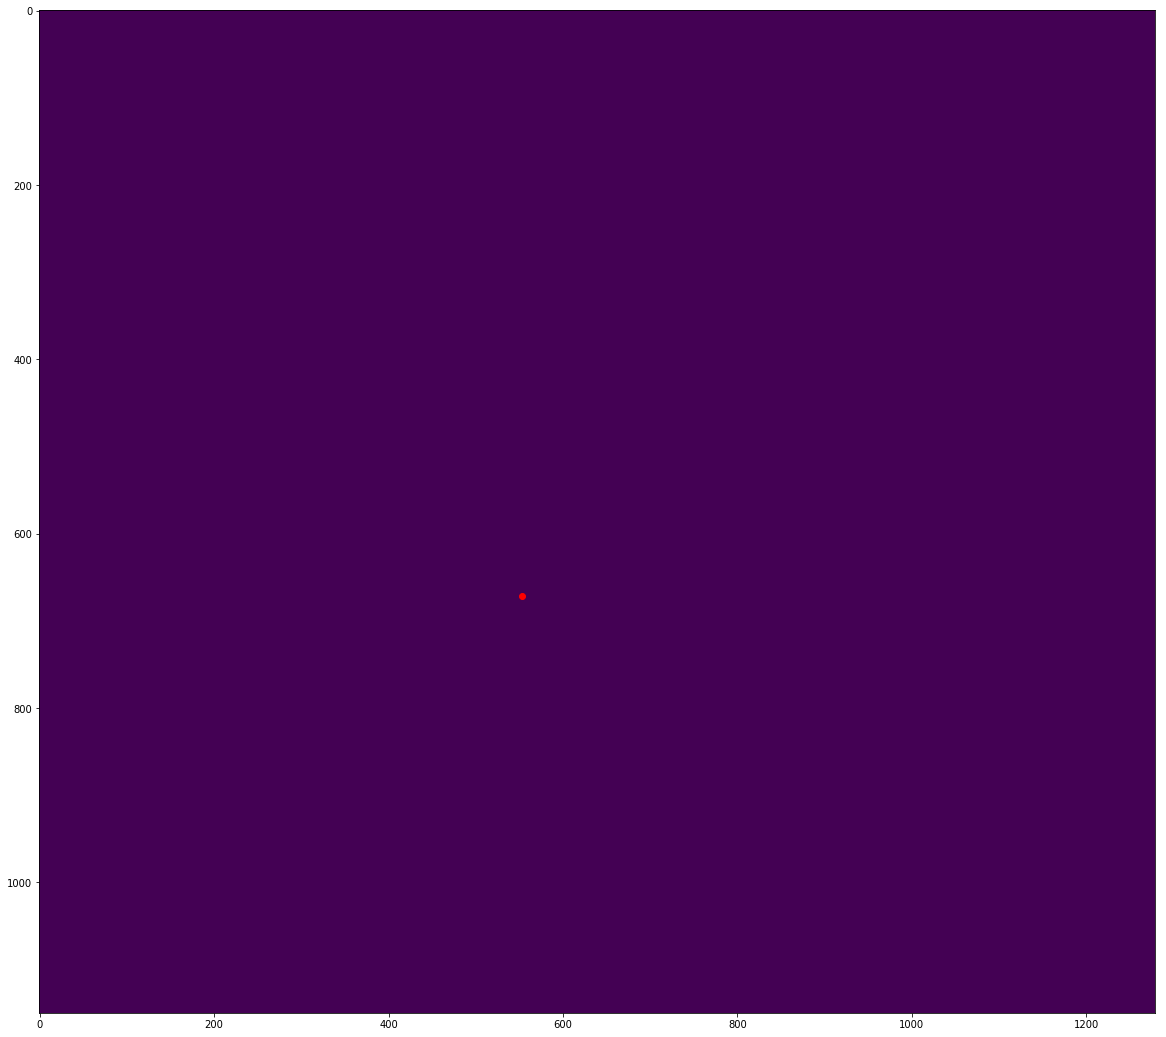

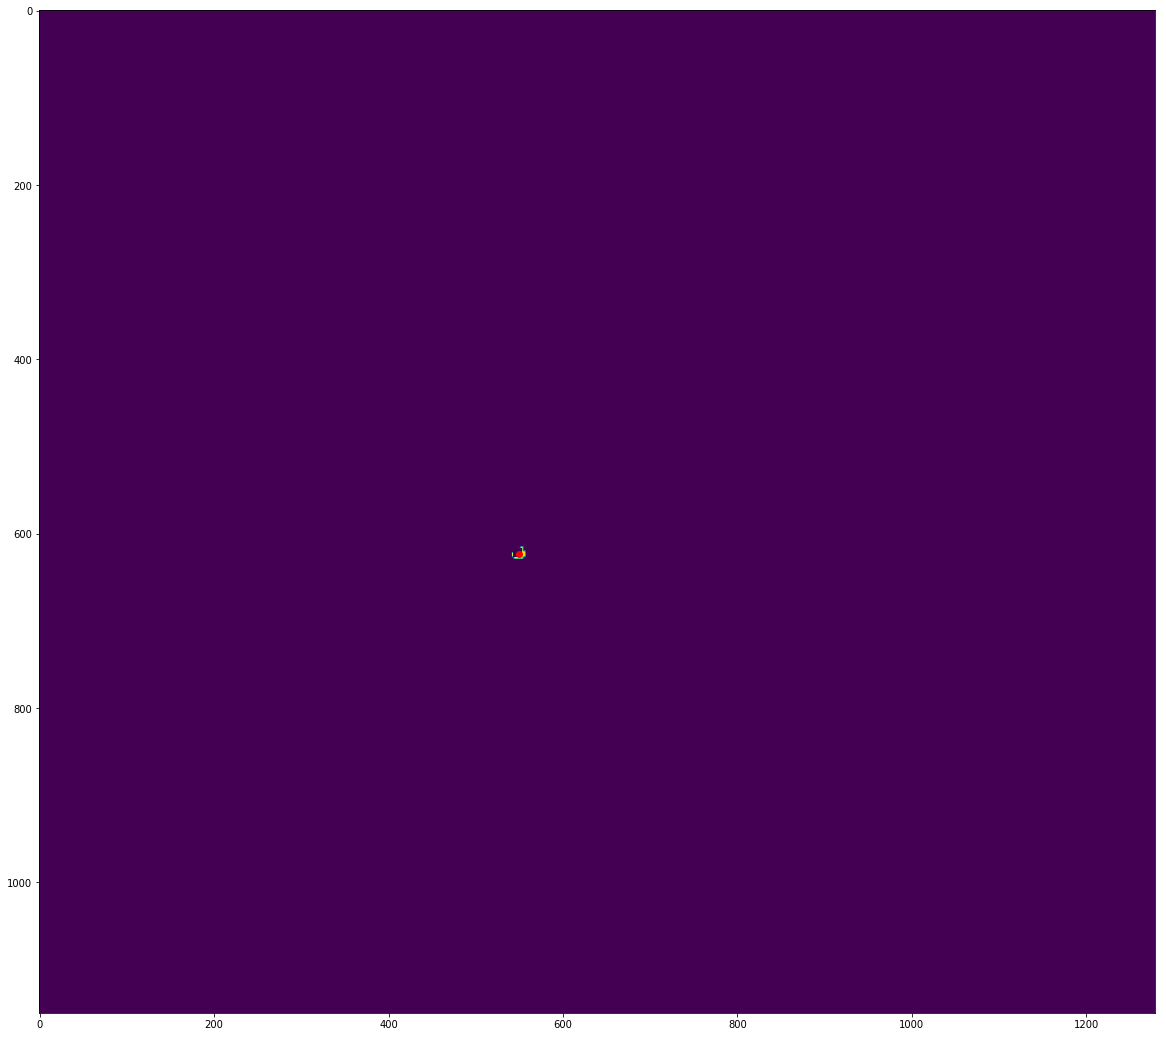

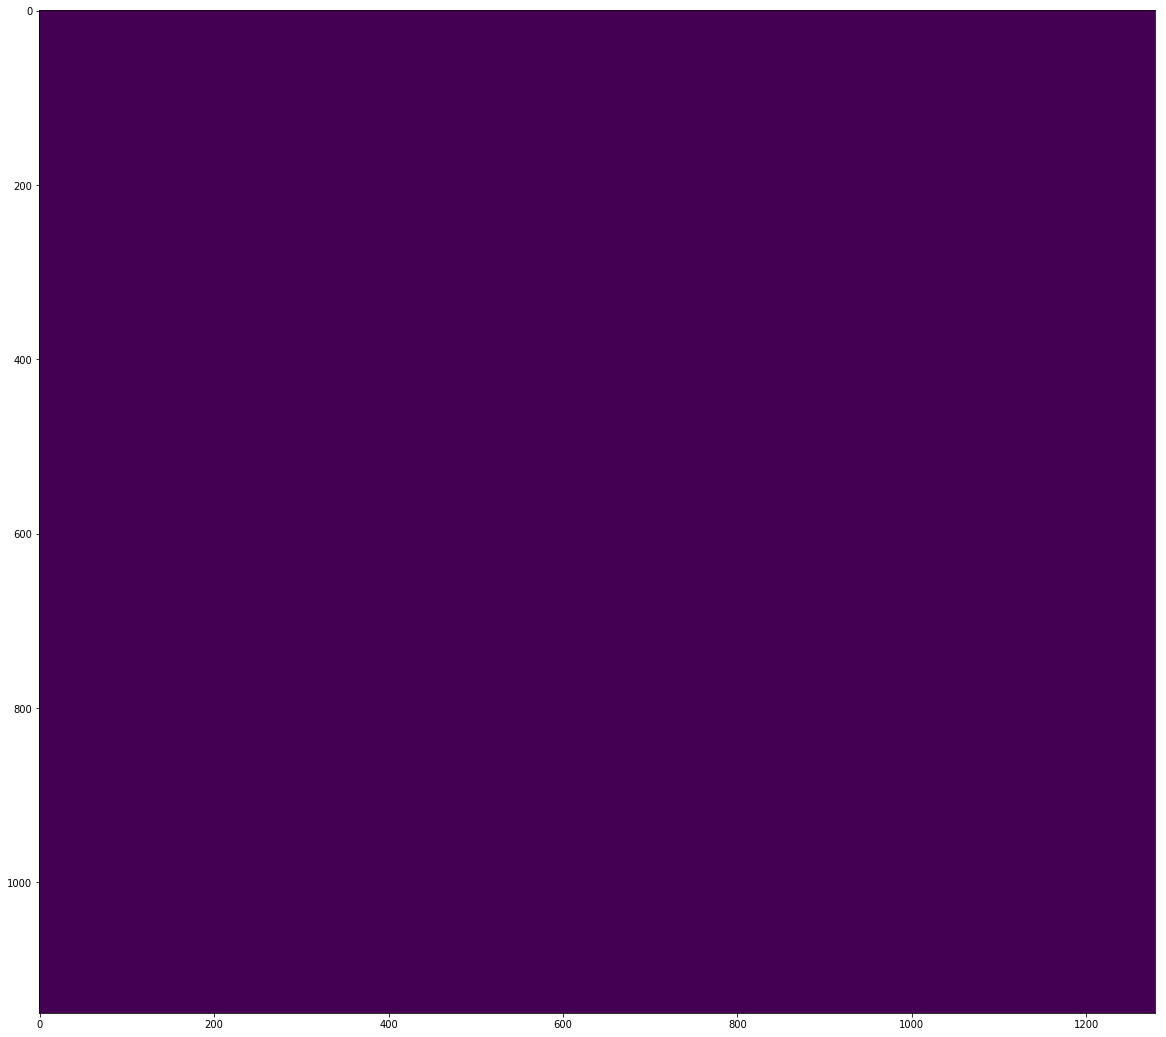

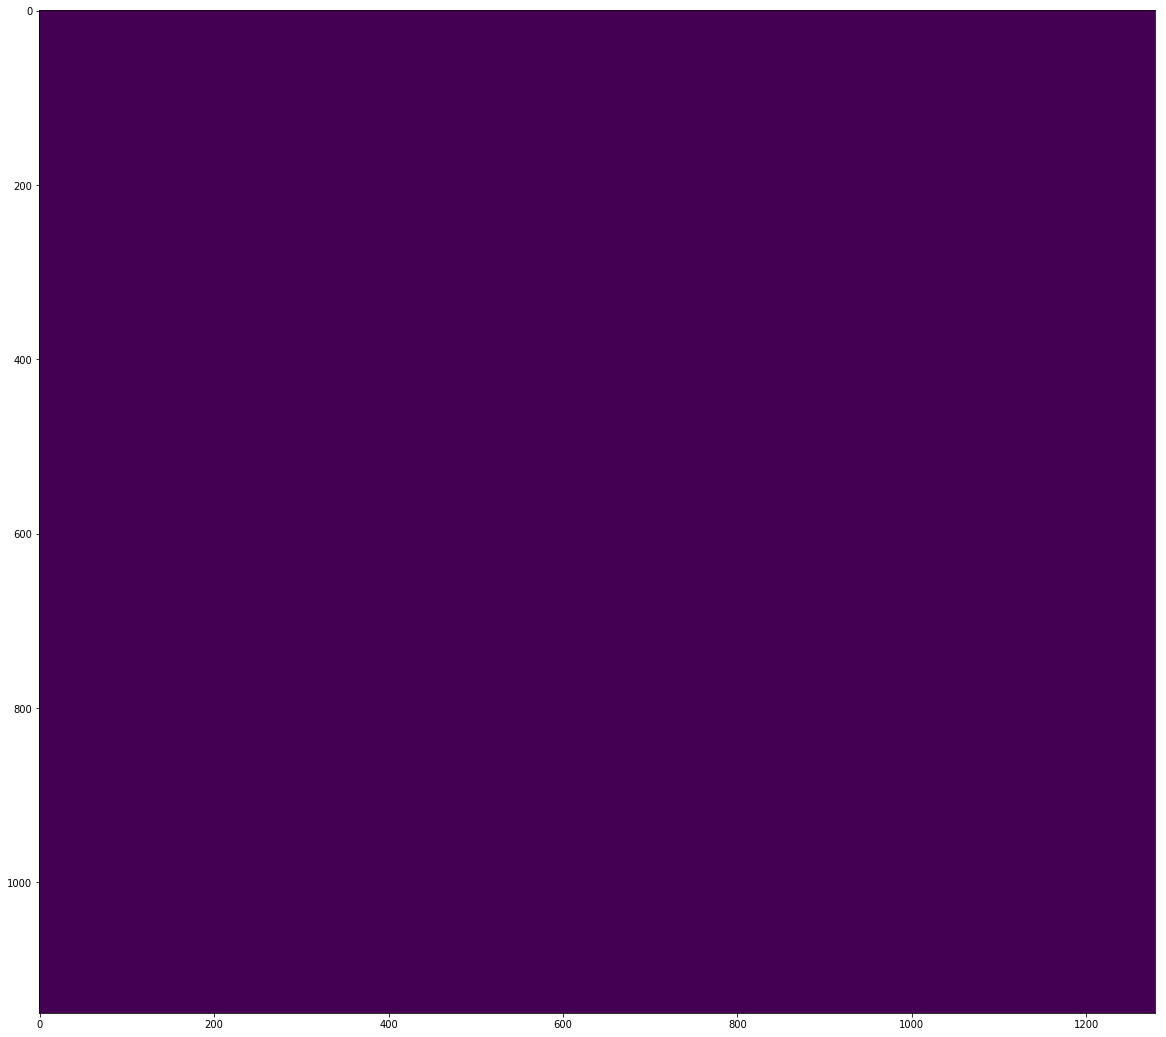

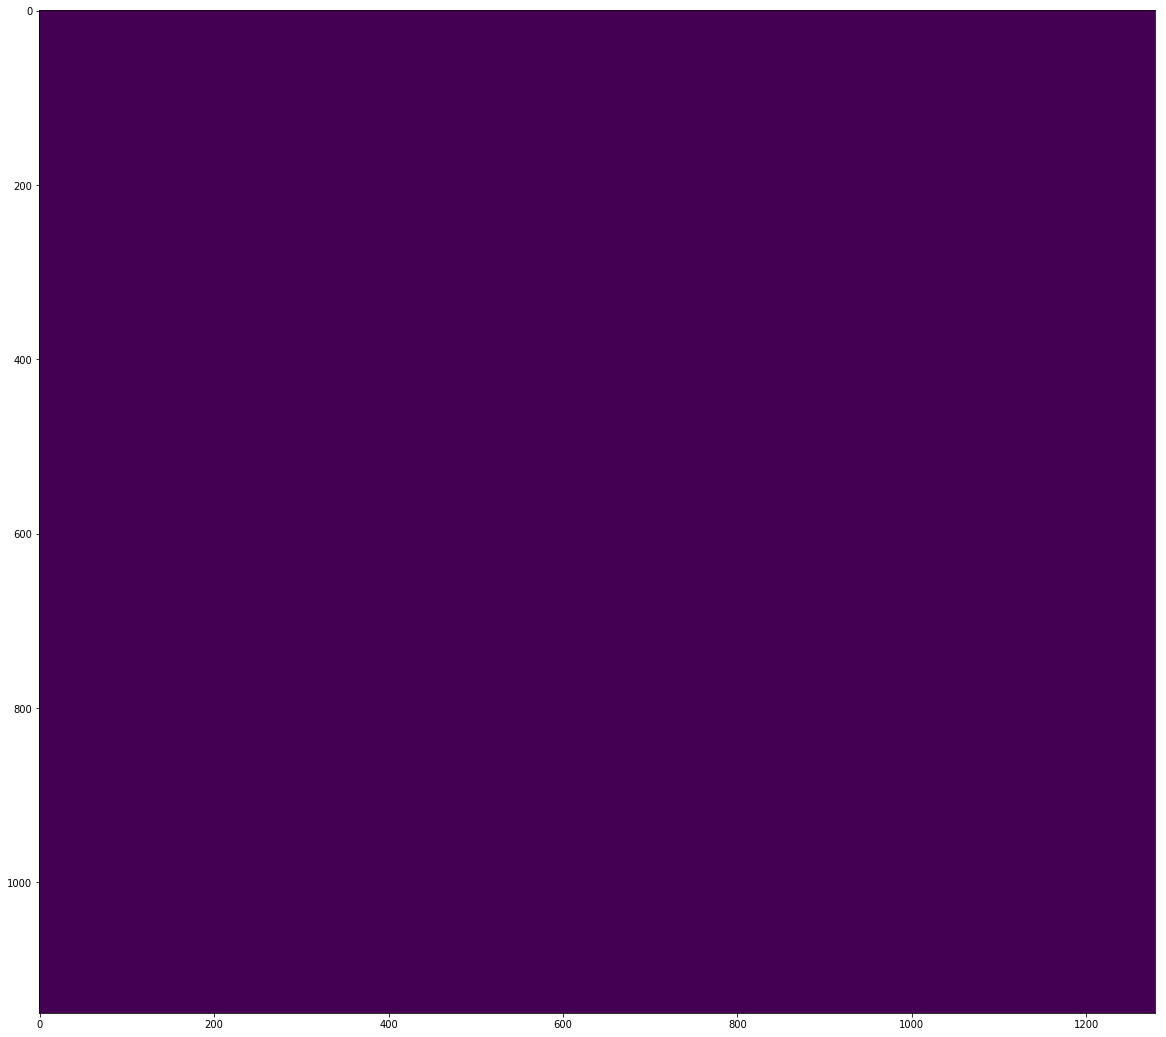

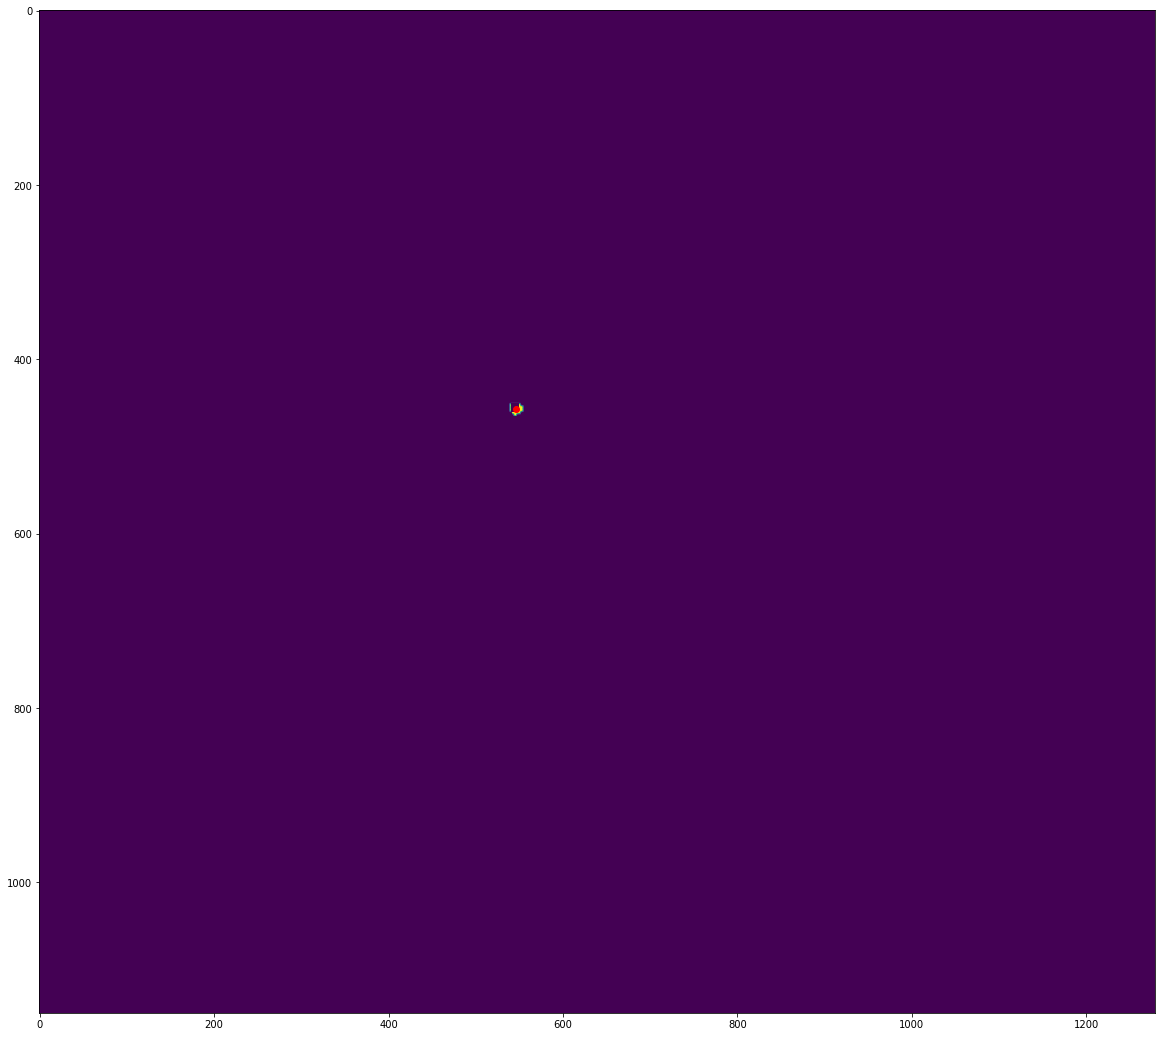

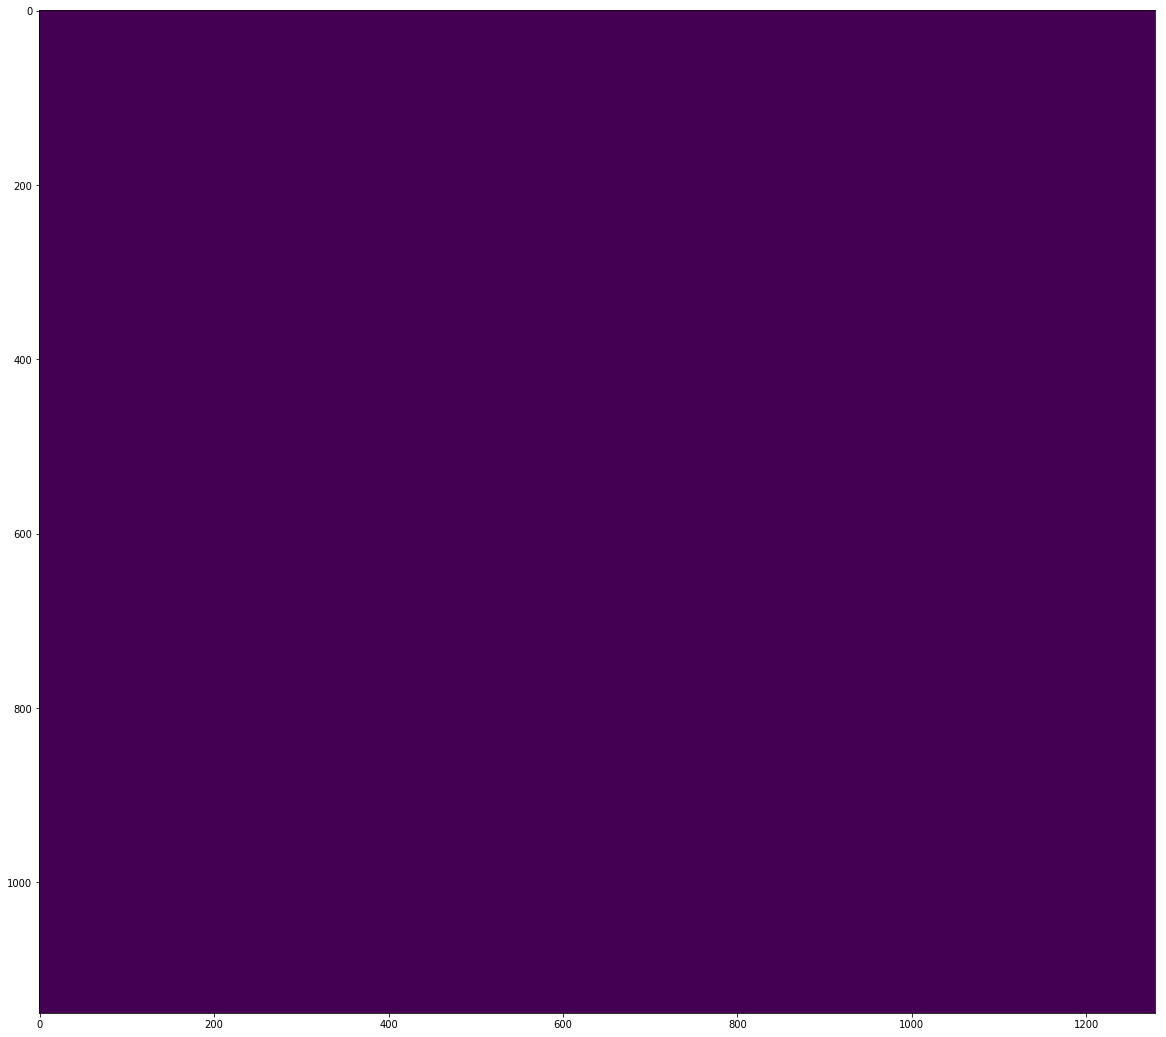

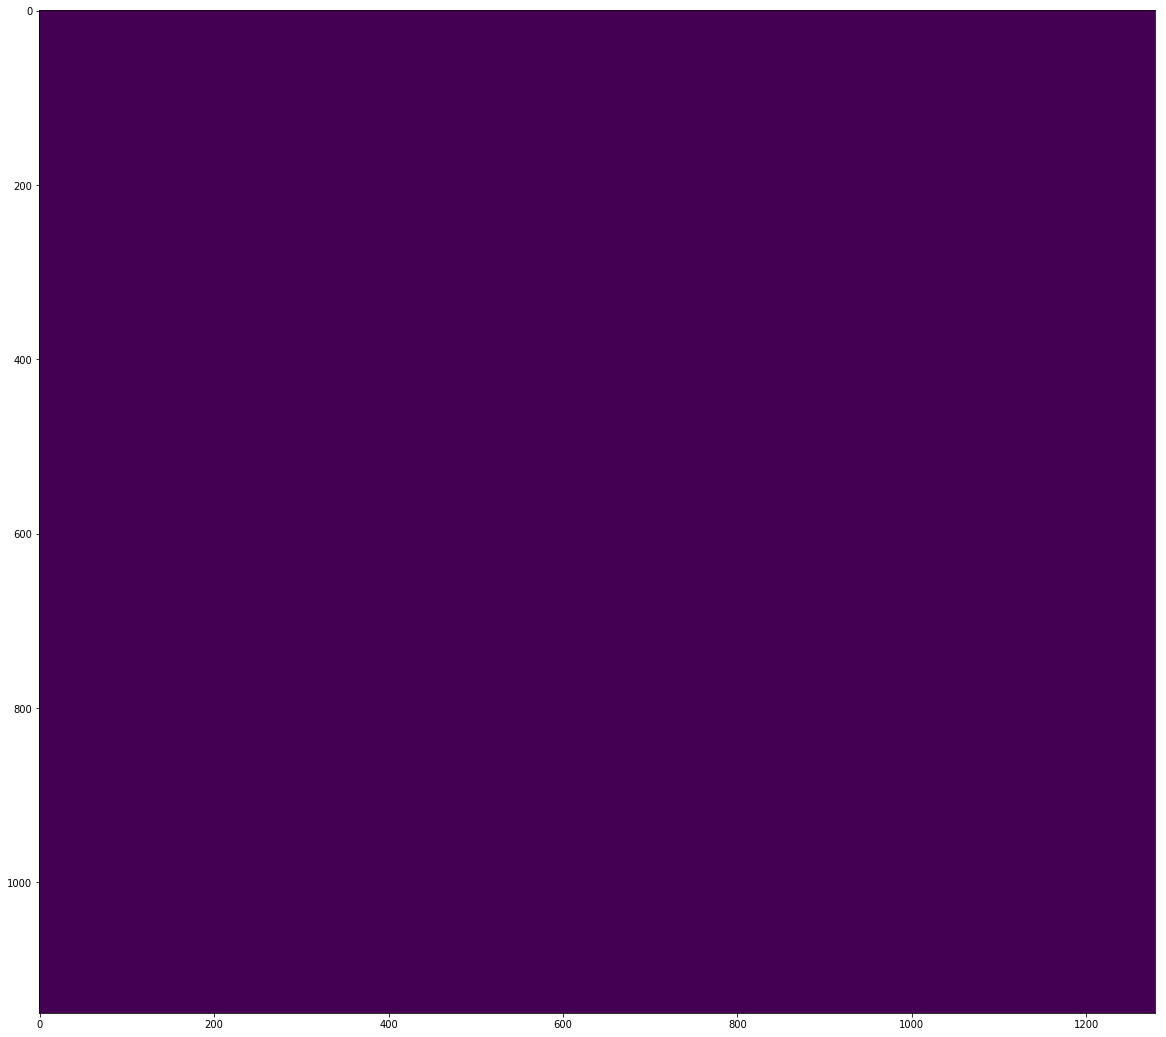

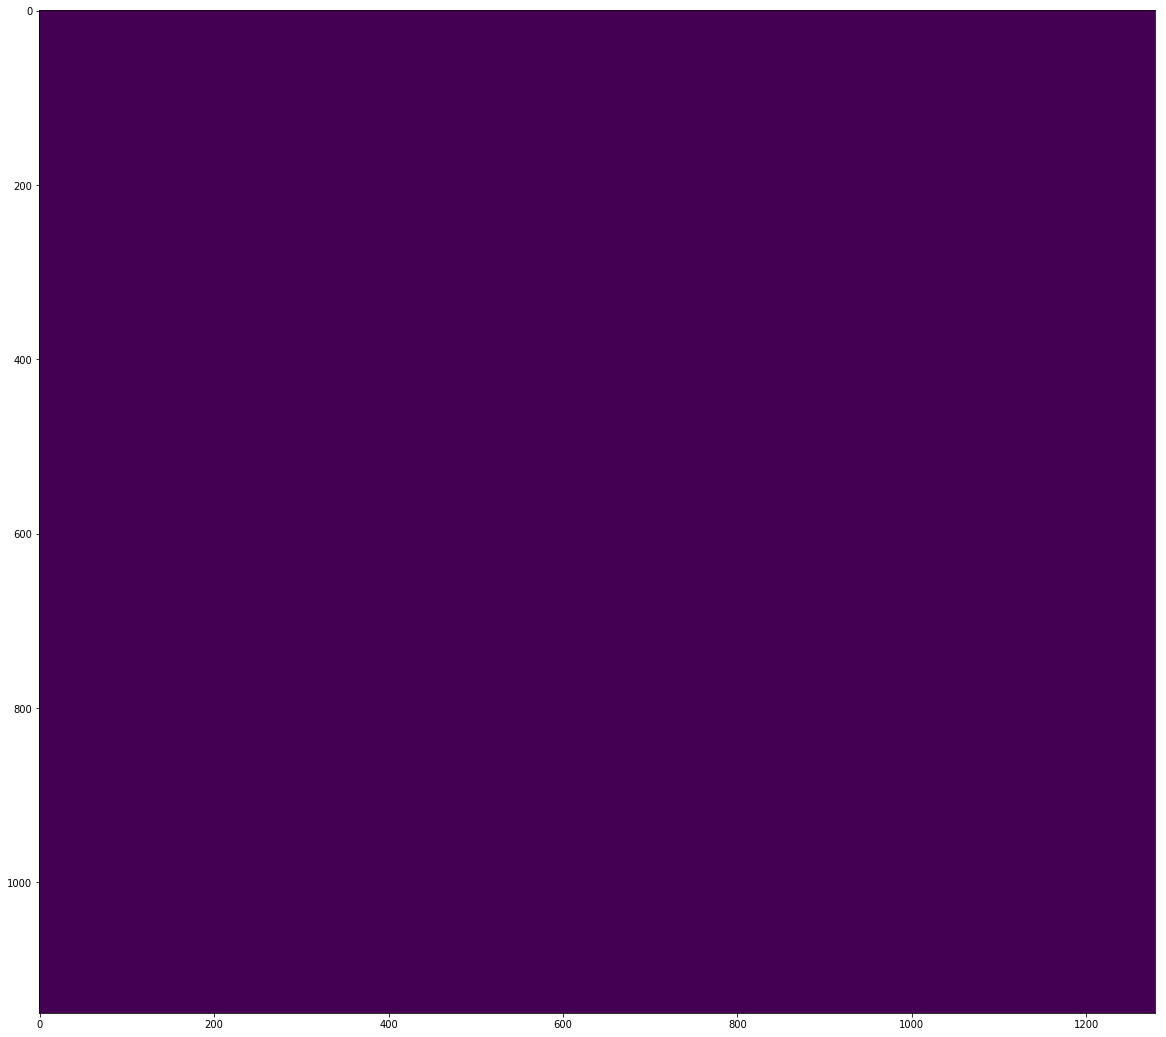

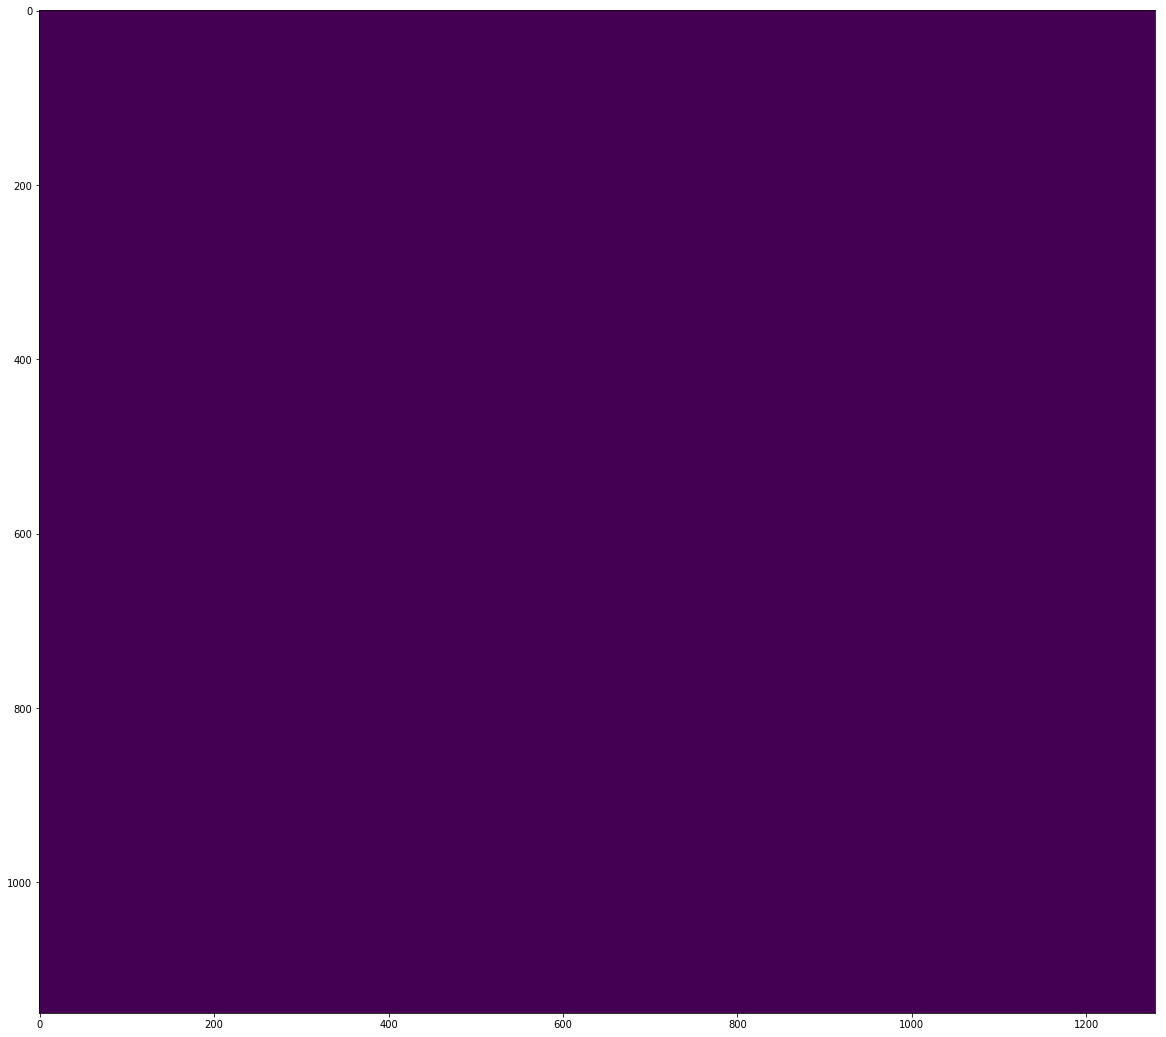

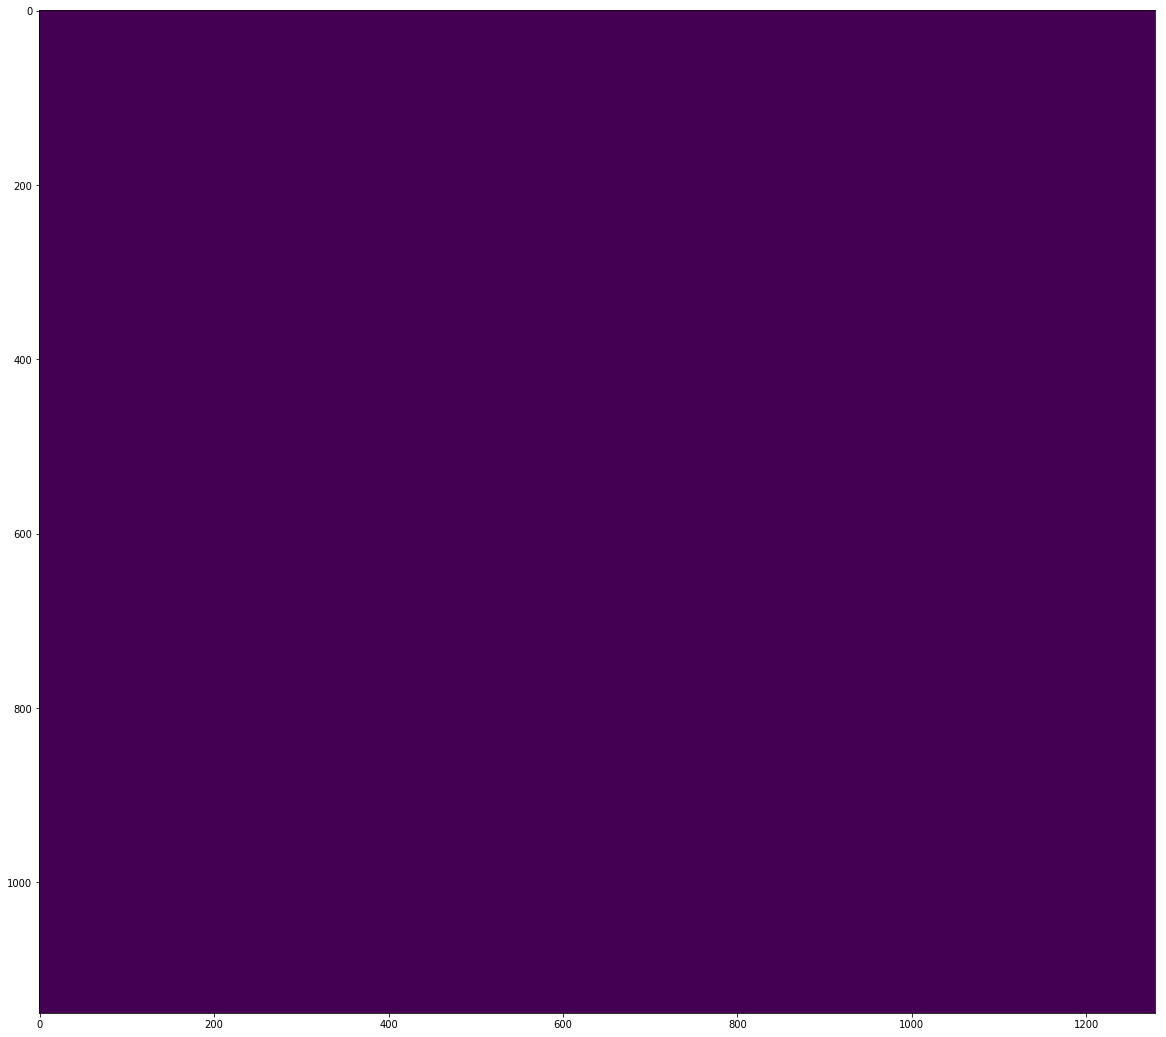

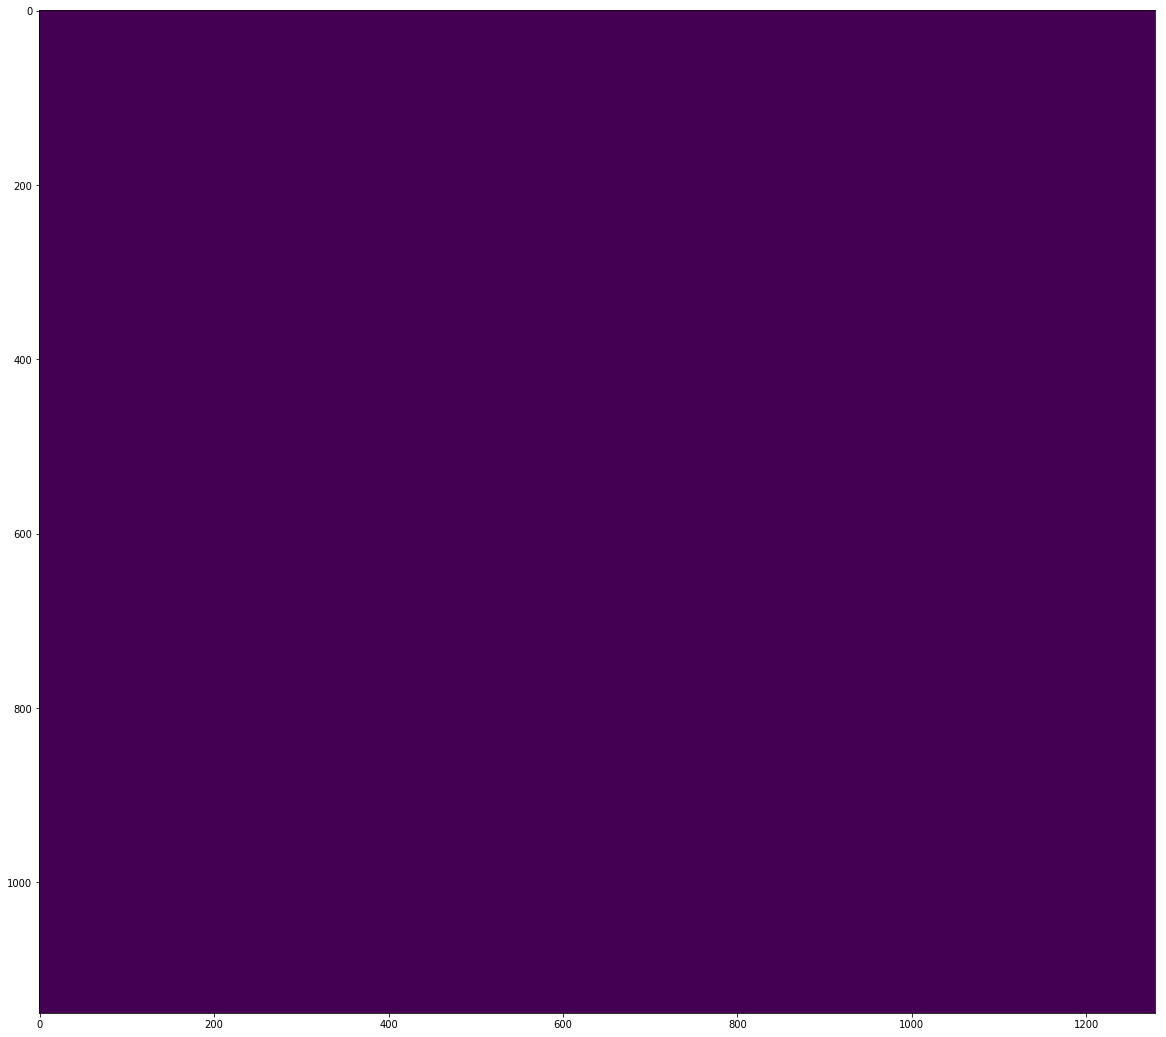

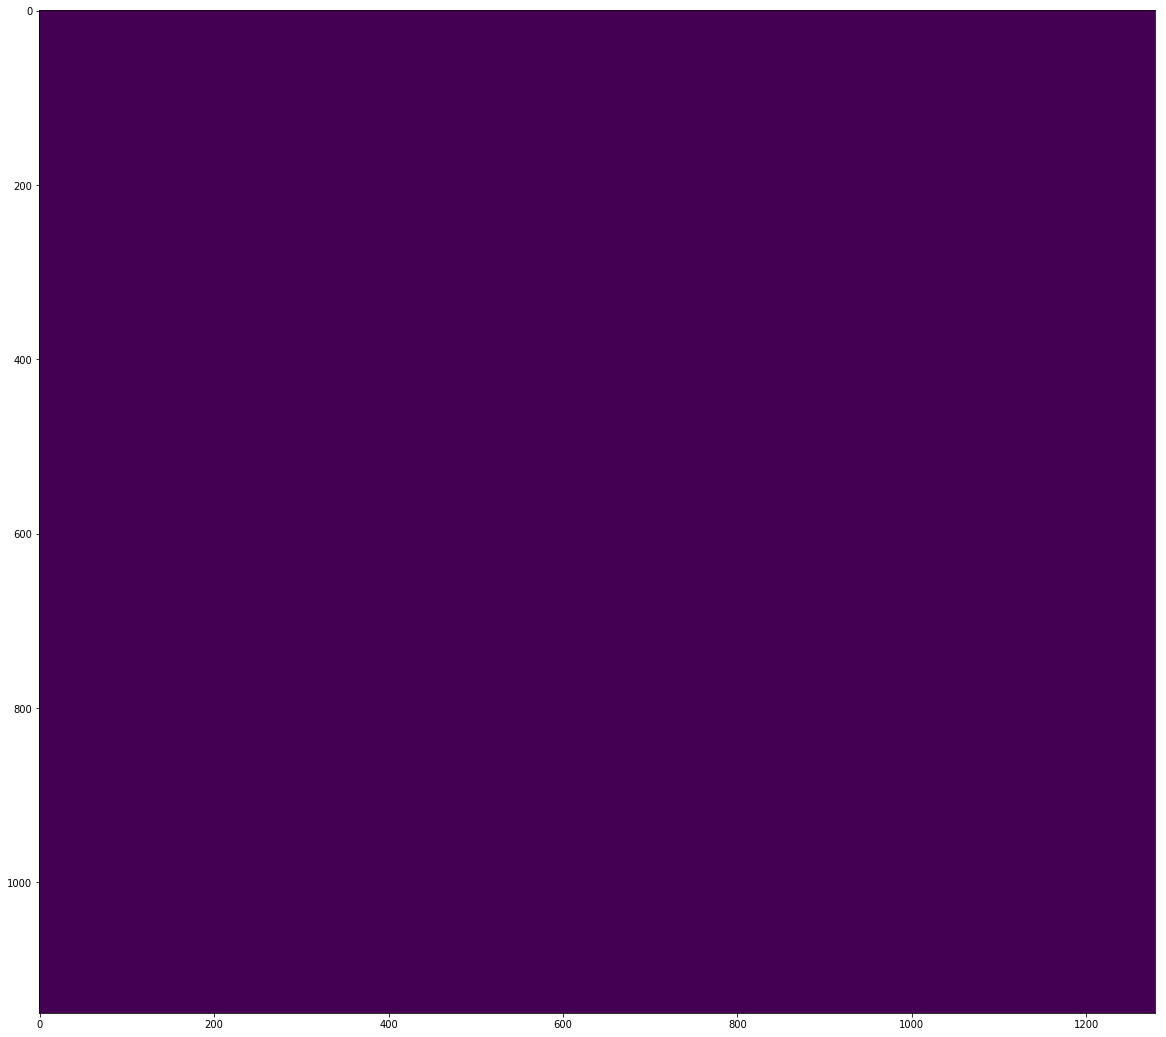

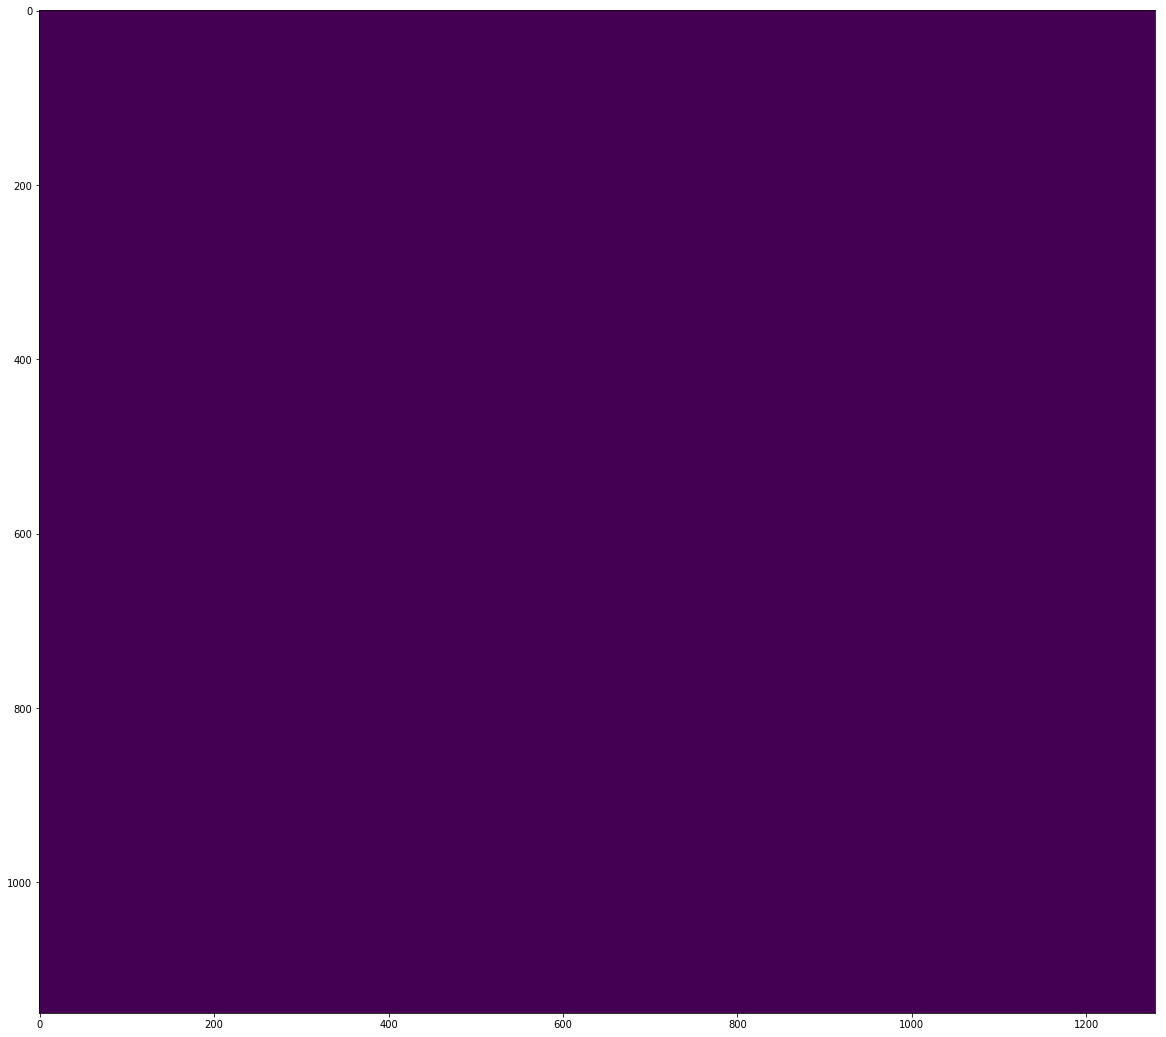

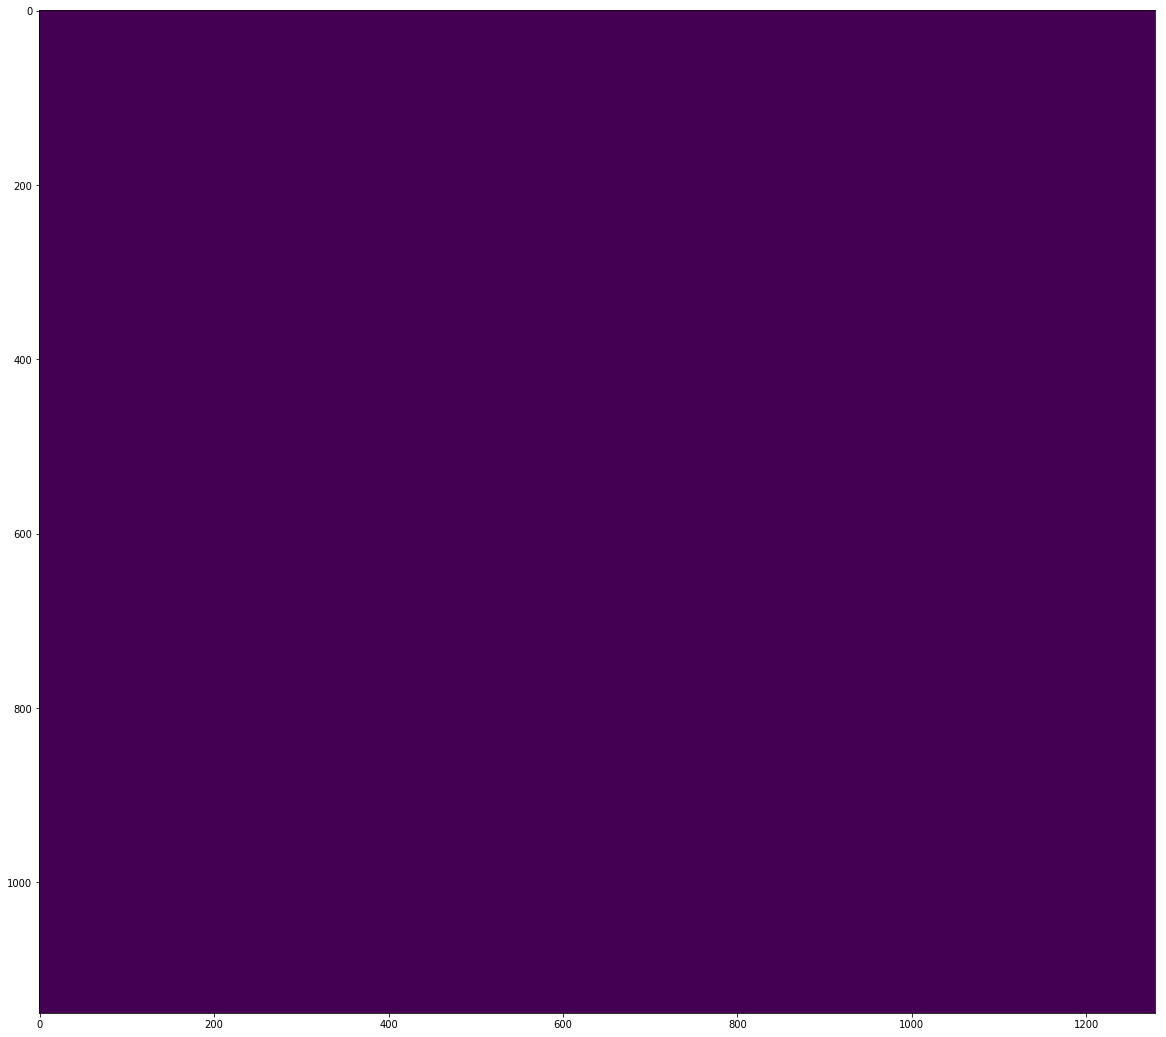

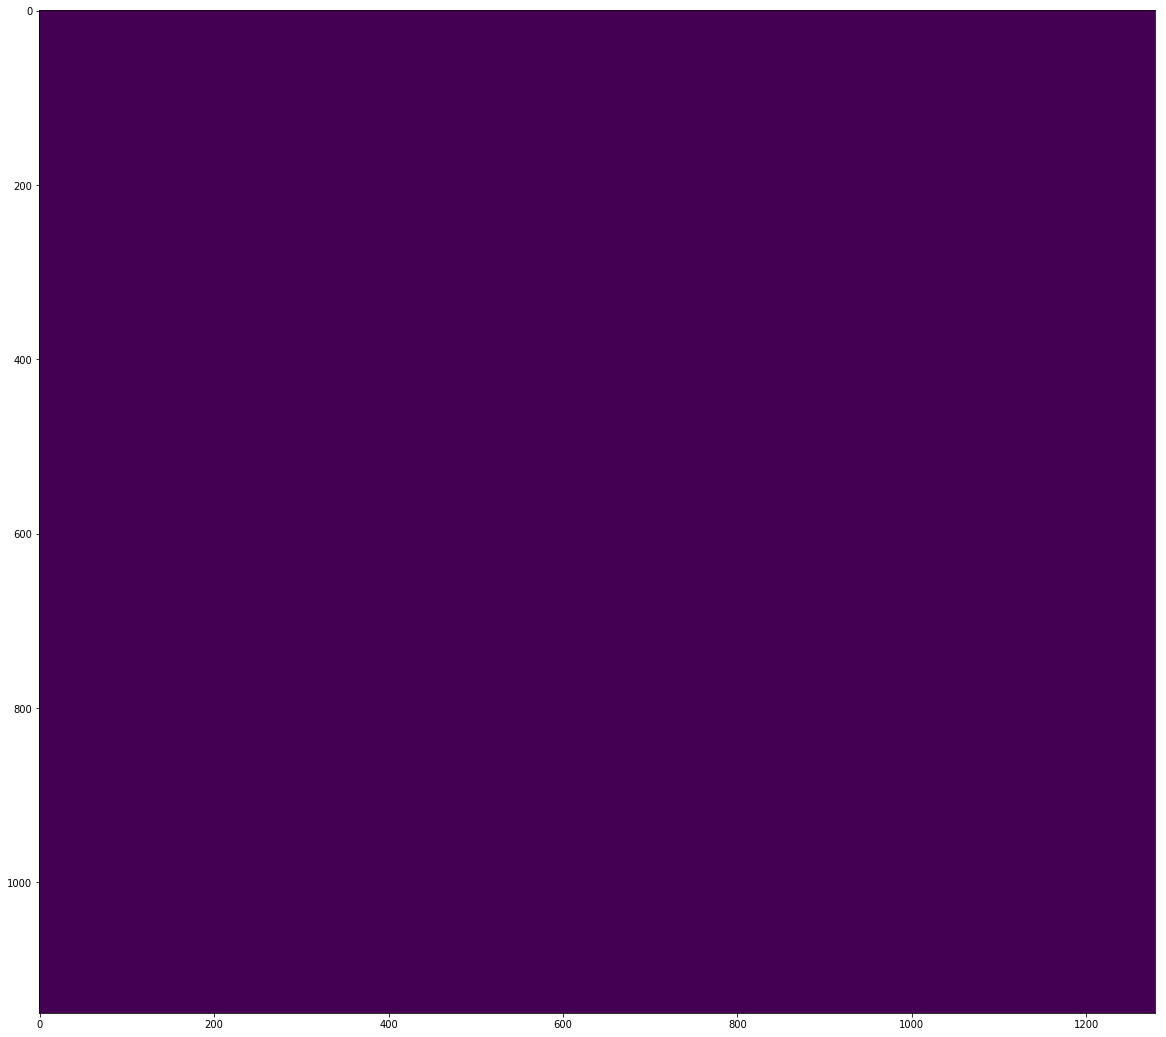

In [27]:
imgPath = './2019 APMCM Problems/2019 APMCM Problem A Attachment'
savedir = './result/'
for i in os.listdir(imgPath):
    #使用相对路径，但是也可以使用绝对路劲，因为后面的拼接是直接操作的，其实可以加path更好，但是我懒得写了 程理想
    print(i)
    findAndDrawMask(model, imgPath +'/'+ i,savedir + i )

In [33]:
def croppicture(imgPath):
    img = misc.imread(imgPath)
    misc.imsave(imgPath+'croped'+ '.png',img[:1150, 420:1700])

In [34]:
imgPath = './2019 APMCM Problems/2019 APMCM Problem A Attachment'
for i in os.listdir(imgPath):
    print(i)
    croppicture(imgPath+ '/' + i)

0497.bmp


E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


0497.bmpcroped.png
0498.bmp
0498.bmpcroped.png
0499.bmp
0499.bmpcroped.png
0500.bmp
0500.bmpcroped.png
0501.bmp
0501.bmpcroped.png
0502.bmp
0502.bmpcroped.png
0503.bmp
0503.bmpcroped.png
0504.bmp
0504.bmpcroped.png
0505.bmp
0505.bmpcroped.png
0506.bmp
0506.bmpcroped.png
0507.bmp
0507.bmpcroped.png
0508.bmp
0508.bmpcroped.png
0509.bmp
0509.bmpcroped.png
0510.bmp
0510.bmpcroped.png
0511.bmp
0511.bmpcroped.png
0512.bmp
0512.bmpcroped.png
0513.bmp
0513.bmpcroped.png
0514.bmp
0514.bmpcroped.png
0515.bmp
0515.bmpcroped.png
0516.bmp
0516.bmpcroped.png
0517.bmp
0517.bmpcroped.png
0518.bmp
0518.bmpcroped.png
0519.bmp
0519.bmpcroped.png
0520.bmp
0520.bmpcroped.png
0521.bmp
0521.bmpcroped.png
0522.bmp
0522.bmpcroped.png
0523.bmp
0523.bmpcroped.png
0524.bmp
0524.bmpcroped.png
0525.bmp
0525.bmpcroped.png
0526.bmp
0526.bmpcroped.png
0527.bmp
0527.bmpcroped.png
0528.bmp
0528.bmpcroped.png
0529.bmp
0529.bmpcroped.png
0530.bmp
0530.bmpcroped.png
0531.bmp
0531.bmpcroped.png
0532.bmp
0532.bmpcroped.png
0

In [73]:
def calArea(imgFile):
    img = misc.imread(imgFile)
    #print(img[500:600,500:600])
    img_flat = img.reshape(1150 * 1280)
    res = 0
    for i in img_flat:
        if i == 255:
            res = res+1
    print(res)

In [78]:
imgPath = './result/识别轮廓/'
for i in os.listdir(imgPath):
    print(i.split('.')[0],':')
    calArea(imgPath+ i)

0497 :


E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


22781
0498 :
20310
0499 :
23709
0500 :
22485
0501 :
20241
0502 :
18146
0503 :
17404
0504 :
17642
0505 :
15716
0506 :
16058
0507 :
16600
0508 :
17719
0509 :
17495
0510 :
17264
0511 :
16755
0512 :
17425
0513 :
17494
0514 :
18249
0515 :
17069
0516 :
16369
0517 :
16306
0518 :
16756
0519 :
16522
0520 :
16804
0521 :
17279
0522 :
15441
0523 :
16375
0524 :
15631
0525 :
15278
0526 :
15073
0527 :
14857
0528 :
13954
0529 :
13915
0530 :
13591
0531 :
13668
0532 :
13848
0533 :
13979
0534 :
11638
0535 :
10811
0536 :
10139
0537 :
8922
0538 :
10177
0539 :
10572
0540 :
8087
0541 :
7668
0542 :
7293
0543 :
6713
0544 :
6096
0545 :
7193
0546 :
7857
0547 :
7423
0548 :
7459
0549 :
6283
0550 :
6205
0551 :
6060
0552 :
6471
0553 :
6060
0554 :
6032
0555 :
5266
0556 :
6079
0557 :
5603
0558 :
2134
0559 :
3401
0560 :
3195
0561 :
4861
0562 :
5722
0563 :
4886
0564 :
5007
0565 :
5208
0566 :
4448
0567 :
4828
0568 :
4898
0569 :
4918
0570 :
5208
0571 :
4917
0572 :
4020
0573 :
4748
0574 :
4376
0575 :
4104
0576 :
3660
0577 

OSError: cannot identify image file './result/识别轮廓/desktop.ini'

In [ ]:
def get_config(data_url):
    root_dir = os.listdir(data_url)
    img_path = [os.path.join(data_url, i, 'img.png') for i in root_dir]
    label_path = [os.path.join(data_url, i, 'label.png') for i in root_dir]
    config_df = pd.DataFrame({'img_path': img_path, 'label_path': label_path})
    return config_df


def affine_transform(pt, t):
    new_pt = np.array([pt[0], pt[1], 1.]).T
    new_pt = np.dot(t, new_pt)
    return new_pt[:2]


def get_affine_transform(center, scale, rot, output_size, shift=np.array([0, 0], dtype=np.float32), inv=0):
    if not isinstance(scale, np.ndarray) and not isinstance(scale, list):
        scale = np.array([scale, scale])

    scale_tmp = scale * output_size
    src_w = scale_tmp[0]
    dst_w = output_size[0]
    dst_h = output_size[1]

    rot_rad = np.pi * rot / 180
    src_dir = get_dir([0, src_w * -0.5], rot_rad)
    dst_dir = np.array([0, dst_w * -0.5], np.float32)

    src = np.zeros((3, 2), dtype=np.float32)
    dst = np.zeros((3, 2), dtype=np.float32)
    src[0, :] = center + scale_tmp * shift
    src[1, :] = center + src_dir + scale_tmp * shift
    dst[0, :] = [dst_w * 0.5, dst_h * 0.5]
    dst[1, :] = np.array([dst_w * 0.5, dst_h * 0.5]) + dst_dir

    src[2:, :] = get_3rd_point(src[0, :], src[1, :])
    dst[2:, :] = get_3rd_point(dst[0, :], dst[1, :])

    if inv:
        trans = cv2.getAffineTransform(np.float32(dst), np.float32(src))
    else:
        trans = cv2.getAffineTransform(np.float32(src), np.float32(dst))

    return trans


def get_dir(src_point, rot_rad):
    sn, cs = np.sin(rot_rad), np.cos(rot_rad)

    src_result = [0, 0]
    src_result[0] = src_point[0] * cs - src_point[1] * sn
    src_result[1] = src_point[0] * sn + src_point[1] * cs

    return src_result


def get_3rd_point(a, b):
    direct = a - b
    return b + np.array([-direct[1], direct[0]], dtype=np.float32)


def adjustData(img, mask, target_size=(512, 512), is_train=True):
    for i in range(len(img)):
        img[i] = img[i][:1150, 420:1700]
        mask[i] = mask[i][:1150, 420:1700]
        if is_train:
            # random horizontal flip
            if random.random() <= 0.5:
                img[i] = img[i][:, ::-1]
                mask[i] = mask[i][:, ::-1]
            # random vertical flip
            if random.random() <= 0.5:
                img[i] = img[i][::-1, :]
                mask[i] = mask[i][::-1, :]
            # random scale and rotation
            s = 1
            c = np.array(img[i].shape) / 2
            sf = 0.3
            rf = 30
            s = s * np.clip(np.random.randn() * sf + 1, 1 - sf, 1 + sf)
            r = np.clip(np.random.randn() * rf, -rf * 2, rf * 2) if random.random() <= 0.6 else 0
            trans = get_affine_transform(c, s, r, img[i].shape)

            img[i] = cv2.warpAffine(img[i], trans, img[i].shape[::-1], flags=cv2.INTER_LINEAR)
            mask[i] = cv2.warpAffine(mask[i], trans, img[i].shape[::-1], flags=cv2.INTER_NEAREST)

    new_img = np.expand_dims(np.array([misc.imresize(i, target_size, 'bilinear') for i in img]), -1) / 255.
    new_mask = np.expand_dims(np.array([misc.imresize(i, target_size, 'nearest') for i in mask]), -1)
    new_mask[new_mask != 0] = 1
    return new_img, new_mask


def trainGenerator(batch_size, config_df, target_size=(512, 512)):
    while True:
        config = config_df.sample(n=batch_size, replace=True).copy()
        img = [misc.imread(path, mode='L') for path in config['img_path']]
        mask = [misc.imread(path, mode='L') for path in config['label_path']]
        img, mask = adjustData(img, mask, target_size, is_train=True)
        yield (img, mask)

In [24]:
data_url = 'E:/Jupyter/NNMODEL/2019APMCM/data'
config = get_config(data_url)
train_config = config.iloc[::2]
trainGene = trainGenerator(1, train_config, (512, 512))

NameError: name 'get_config' is not defined

In [ ]:
for (img, mask) in trainGene:
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 2, 1)
    plt.imshow(img[0, :, :, 0])
    plt.subplot(1, 2, 2)
    plt.imshow(mask[0, :, :, 0])
    break